<a href="https://colab.research.google.com/github/zahwaardiansyah04/Deep-Learning-Lanjut/blob/main/Tugas_DCGAN_Deep_Learning_Lanjut_Pertemuan_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [3]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 99% 0.99G/1.00G [00:07<00:00, 161MB/s]
100% 1.00G/1.00G [00:07<00:00, 141MB/s]
Dataset downloaded and extracted to /content/dataset/


In [4]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [5]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [6]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - d_loss: 0.5019 - g_loss: 0.7425

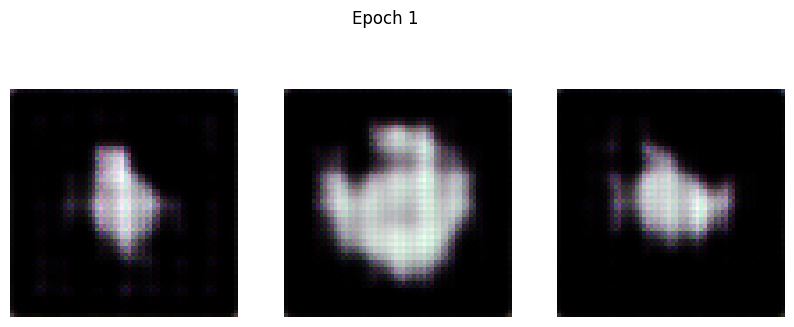

100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - d_loss: 0.5023 - g_loss: 0.7427
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - d_loss: 0.6725 - g_loss: 0.7119

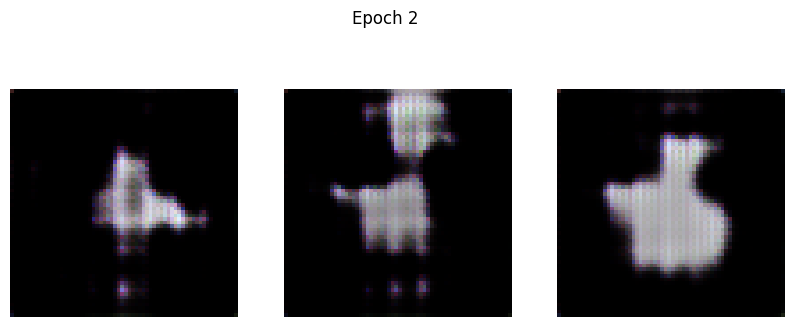

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - d_loss: 0.6726 - g_loss: 0.7119
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - d_loss: 0.6660 - g_loss: 0.7159

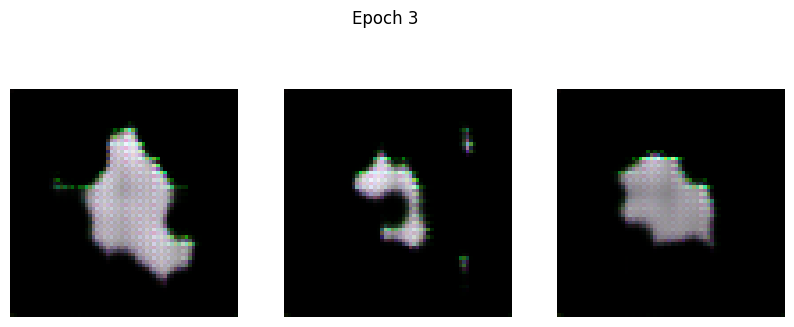

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - d_loss: 0.6660 - g_loss: 0.7161
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 0.6727 - g_loss: 0.7300

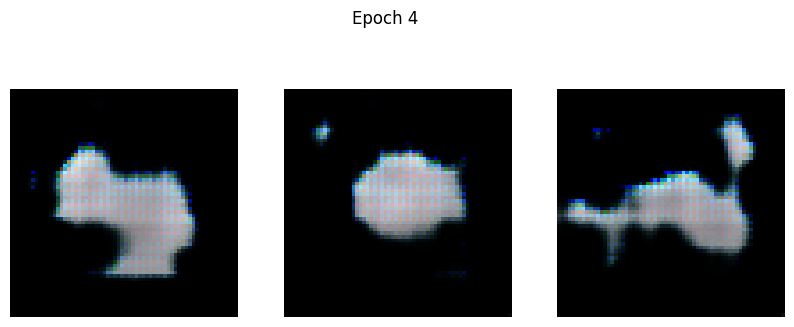

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - d_loss: 0.6726 - g_loss: 0.7303
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6543 - g_loss: 0.7786

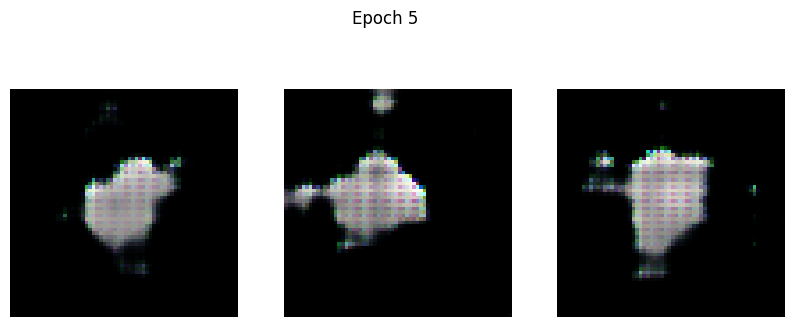

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.6543 - g_loss: 0.7788
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.6722 - g_loss: 0.7890

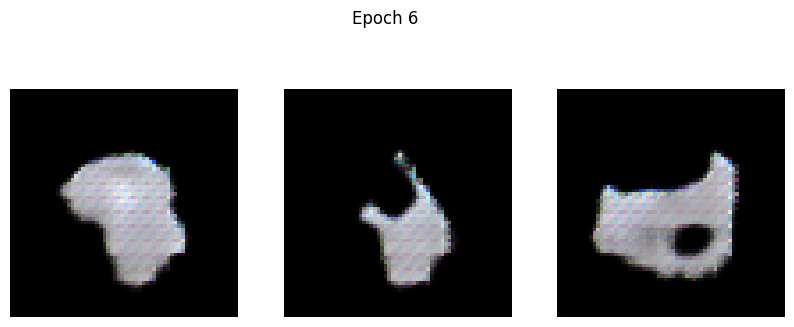

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.6721 - g_loss: 0.7890
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.6639 - g_loss: 0.7733

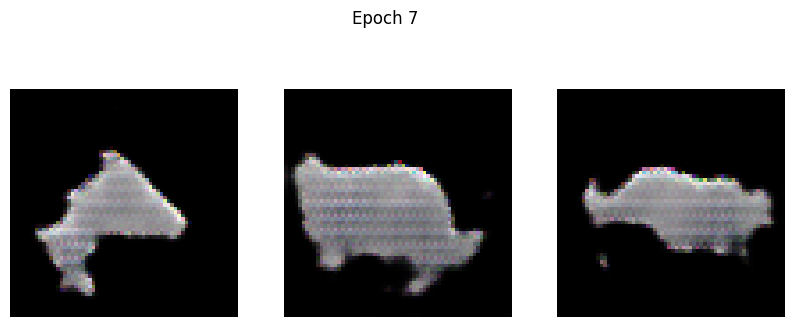

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.6639 - g_loss: 0.7734
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6526 - g_loss: 0.7663

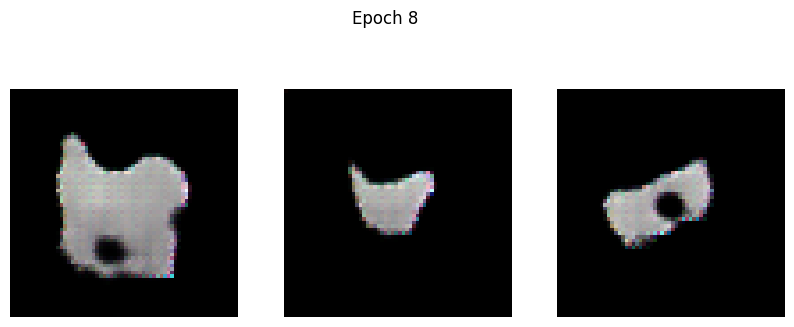

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.6526 - g_loss: 0.7665
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.6573 - g_loss: 0.7517

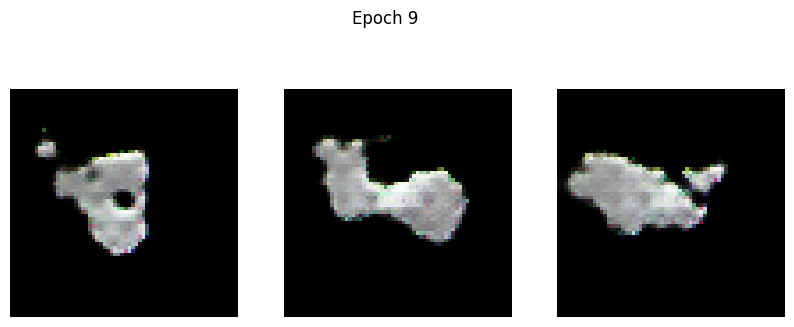

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.6573 - g_loss: 0.7516
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6581 - g_loss: 0.7702

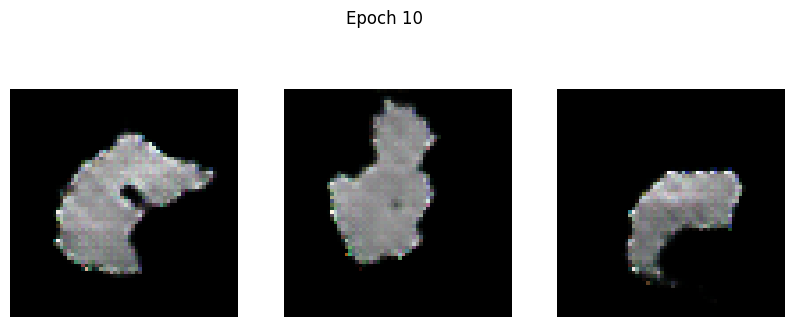

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6581 - g_loss: 0.7701
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6646 - g_loss: 0.7432

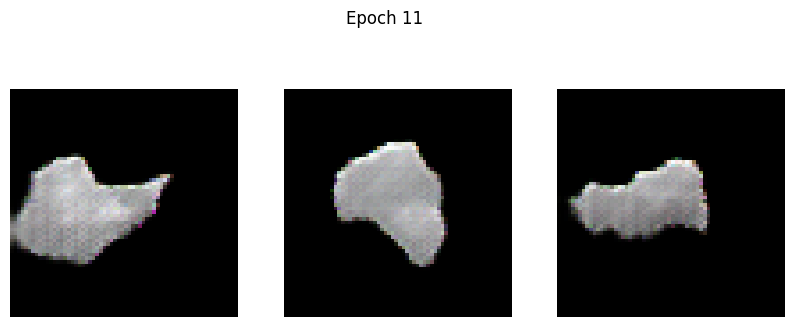

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6645 - g_loss: 0.7432
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6552 - g_loss: 0.7539

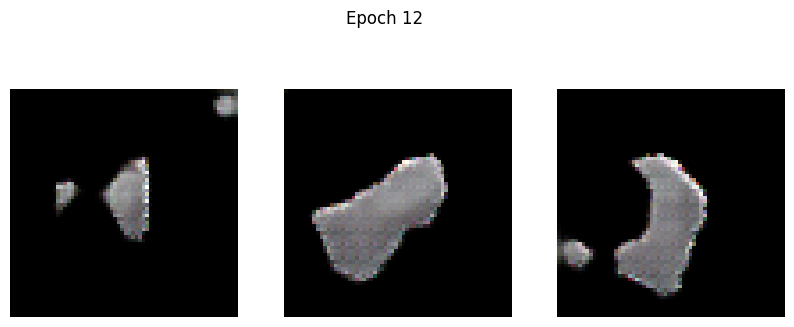

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6552 - g_loss: 0.7540
Epoch 13/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6448 - g_loss: 0.7779

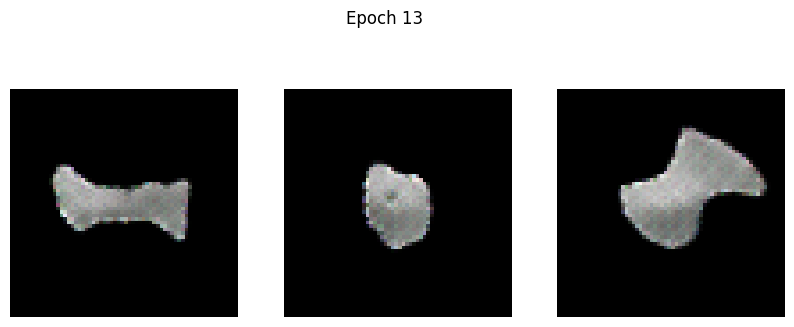

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6447 - g_loss: 0.7779
Epoch 14/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6374 - g_loss: 0.8229

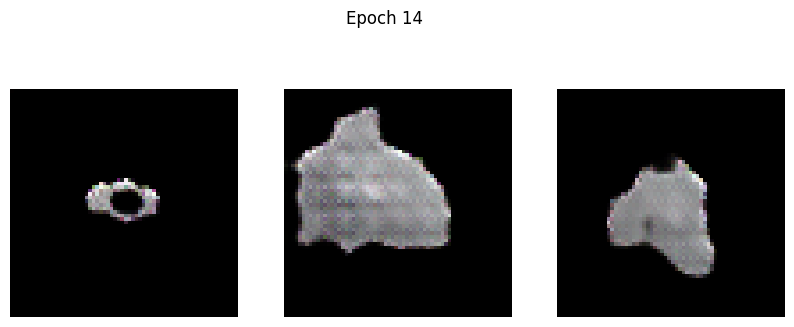

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6374 - g_loss: 0.8229
Epoch 15/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6180 - g_loss: 0.8581

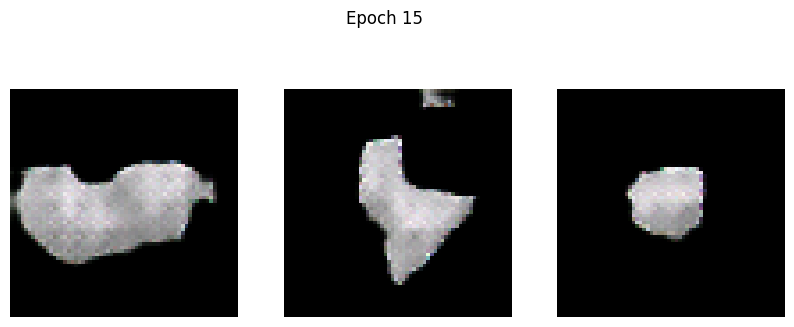

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6180 - g_loss: 0.8582
Epoch 16/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6107 - g_loss: 0.8956

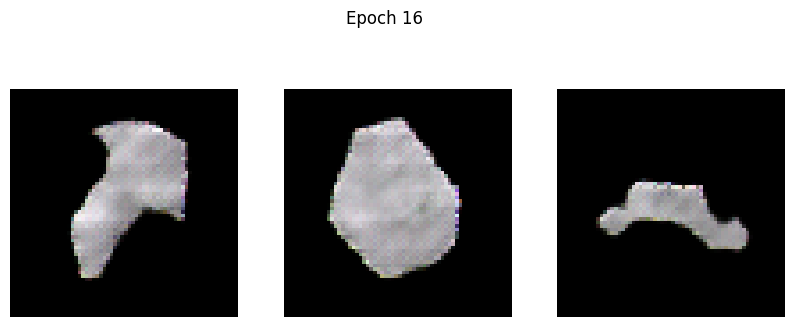

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6107 - g_loss: 0.8957
Epoch 17/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5925 - g_loss: 0.9388

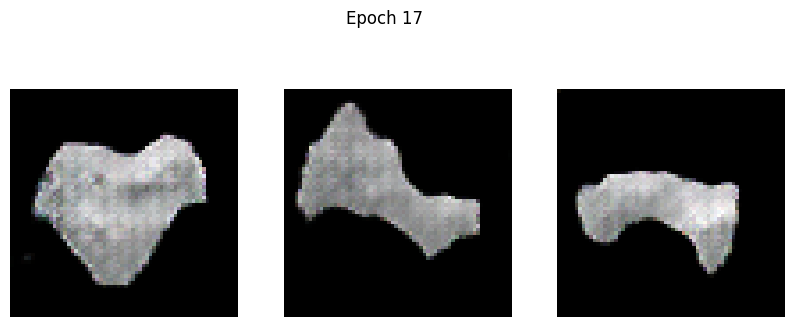

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5925 - g_loss: 0.9390
Epoch 18/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5763 - g_loss: 0.9160

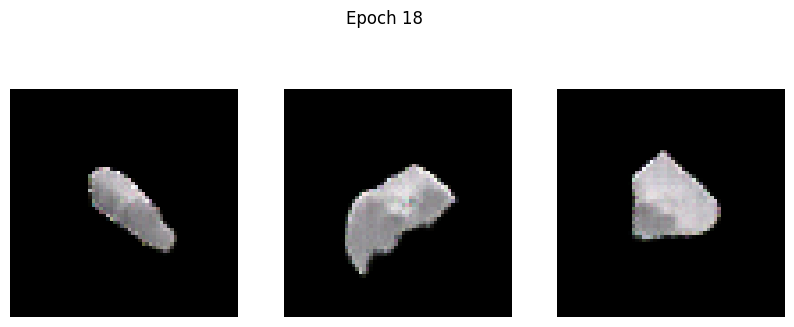

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5763 - g_loss: 0.9162
Epoch 19/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5748 - g_loss: 0.9715

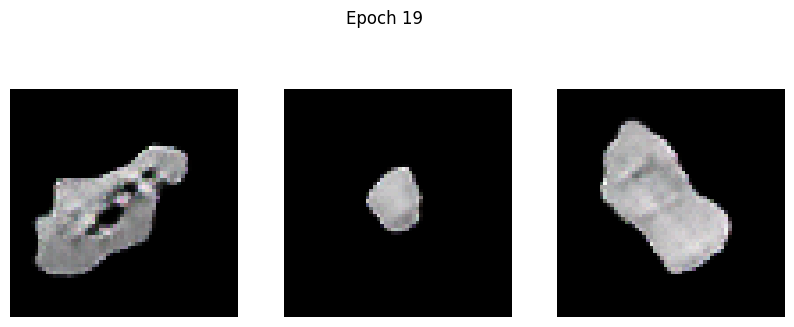

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5747 - g_loss: 0.9715
Epoch 20/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5594 - g_loss: 0.9905

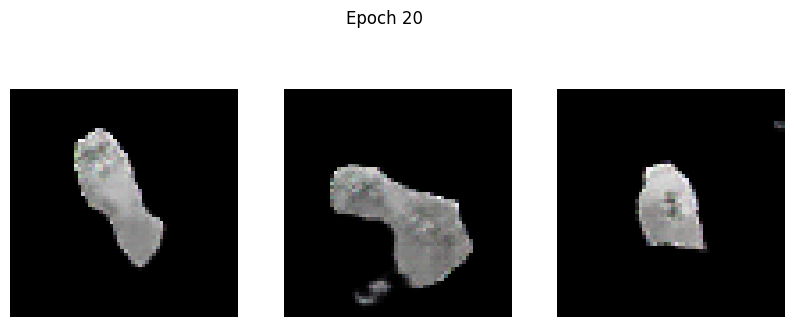

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5595 - g_loss: 0.9905
Epoch 21/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5435 - g_loss: 1.0080

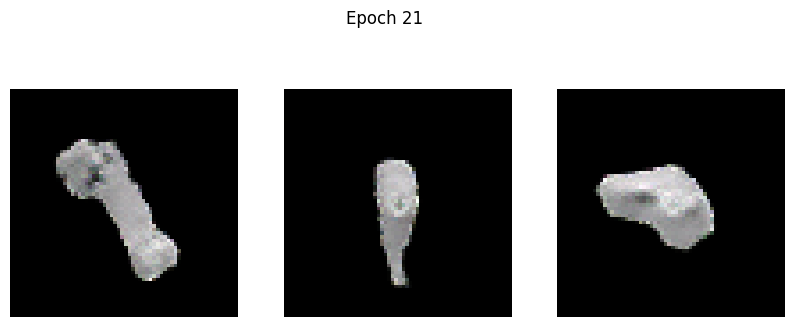

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5435 - g_loss: 1.0081
Epoch 22/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.5488 - g_loss: 1.0913

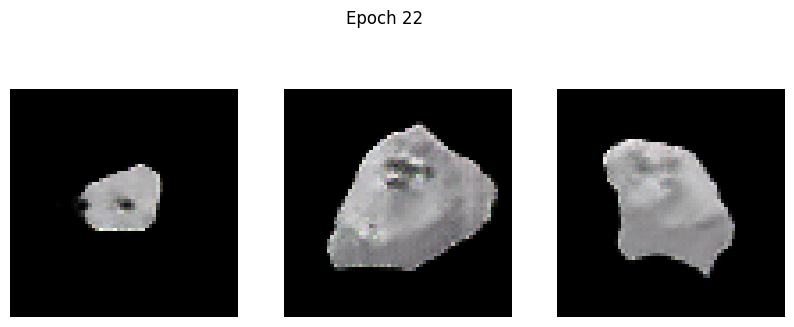

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5487 - g_loss: 1.0909
Epoch 23/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.5394 - g_loss: 1.1151

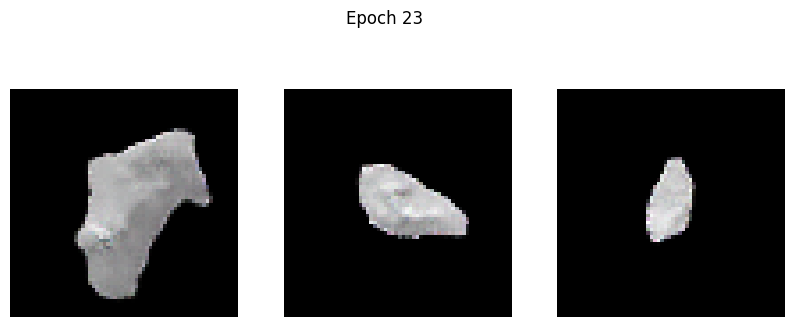

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5393 - g_loss: 1.1149
Epoch 24/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.5147 - g_loss: 1.1041

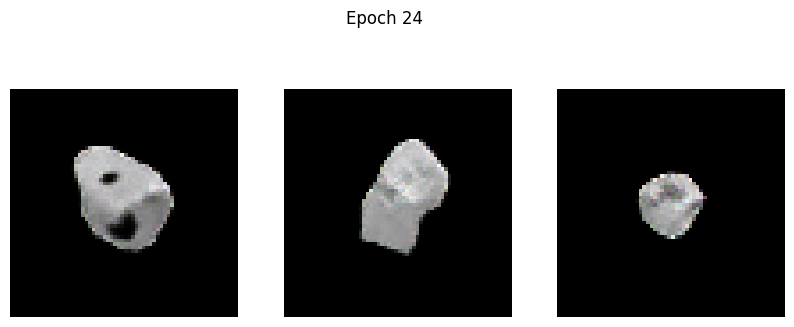

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5148 - g_loss: 1.1041
Epoch 25/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5005 - g_loss: 1.1151

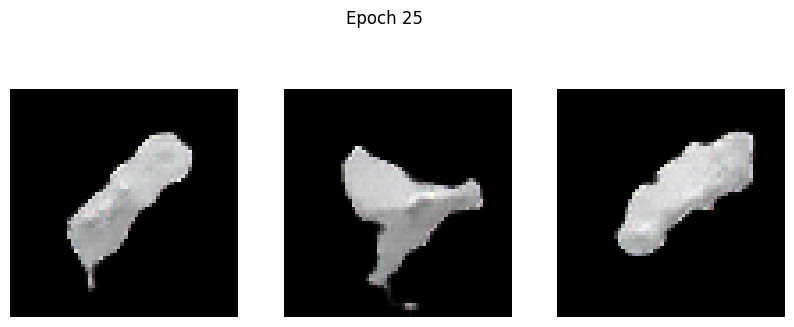

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5006 - g_loss: 1.1154
Epoch 26/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.4981 - g_loss: 1.1642

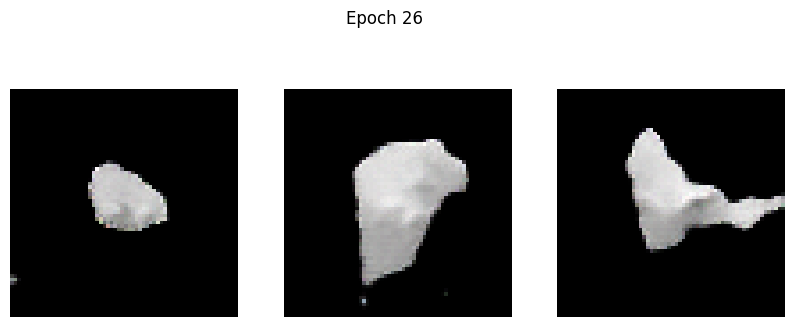

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4985 - g_loss: 1.1645
Epoch 27/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.4708 - g_loss: 1.0918

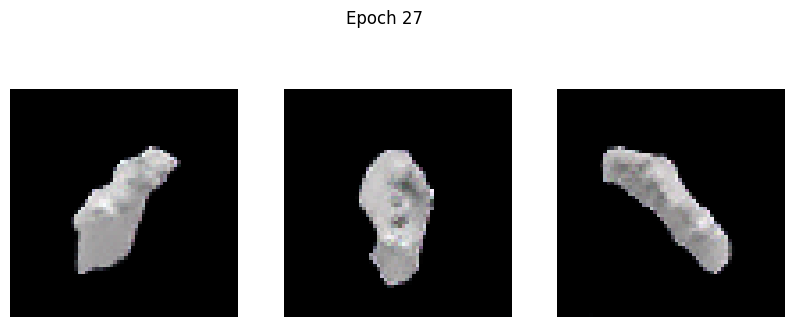

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4709 - g_loss: 1.0922
Epoch 28/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4845 - g_loss: 1.1737

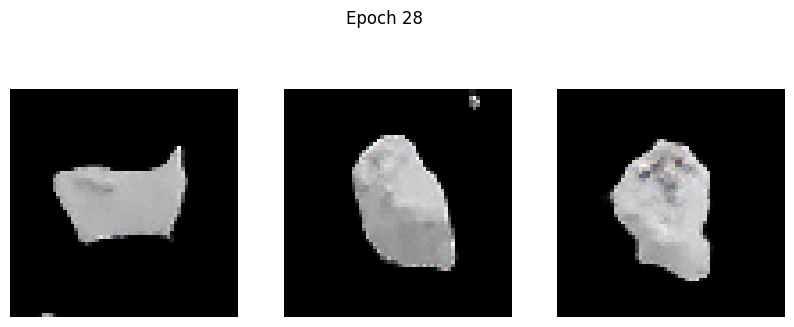

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4844 - g_loss: 1.1738
Epoch 29/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4632 - g_loss: 1.2390

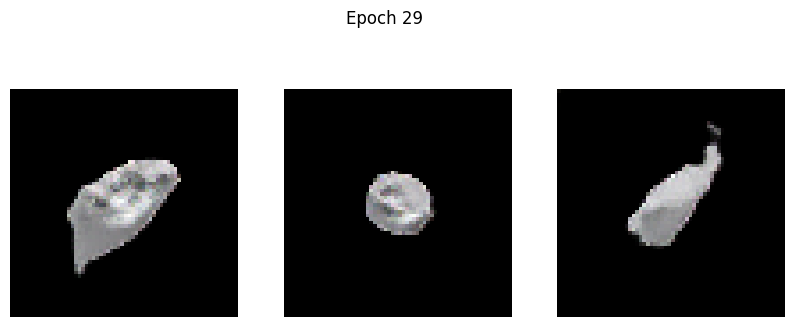

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4632 - g_loss: 1.2391
Epoch 30/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5194 - g_loss: 1.3499

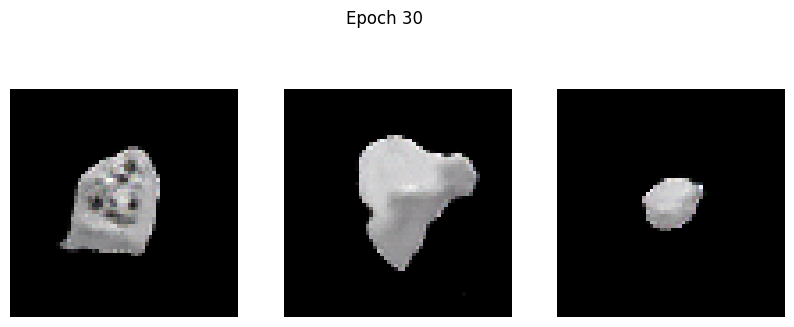

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5190 - g_loss: 1.3492
Epoch 31/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4471 - g_loss: 1.2850

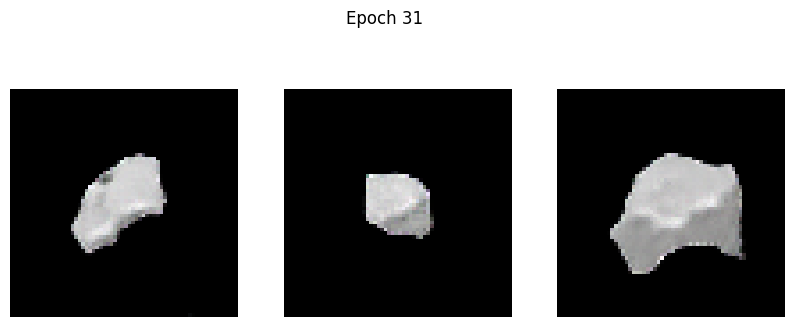

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4472 - g_loss: 1.2851
Epoch 32/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4488 - g_loss: 1.3397

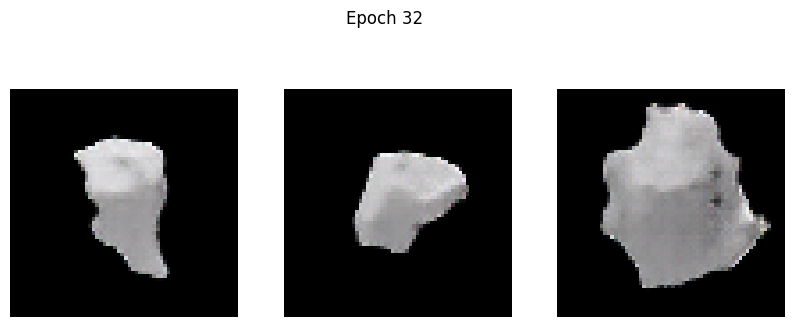

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4486 - g_loss: 1.3396
Epoch 33/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4335 - g_loss: 1.3897

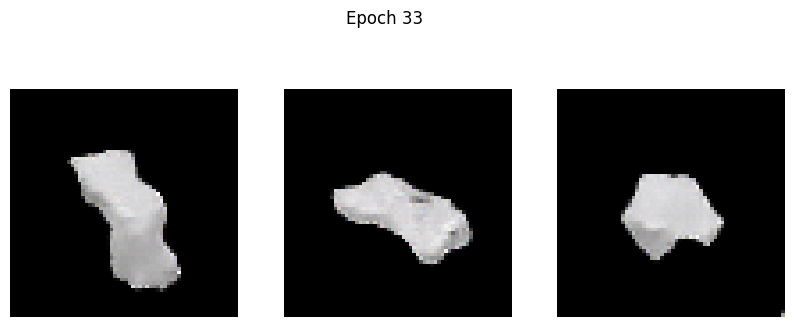

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4339 - g_loss: 1.3898
Epoch 34/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4048 - g_loss: 1.2809

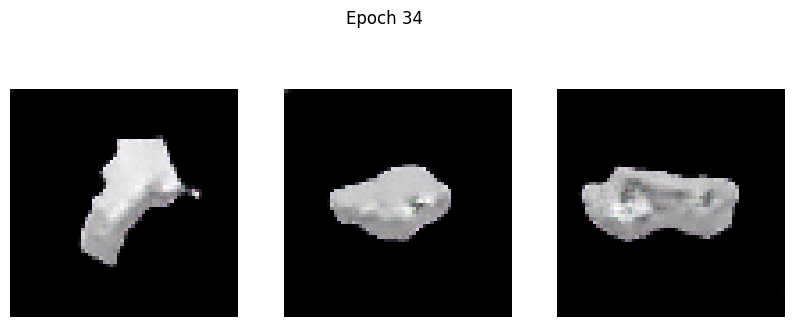

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4048 - g_loss: 1.2814
Epoch 35/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4238 - g_loss: 1.4652

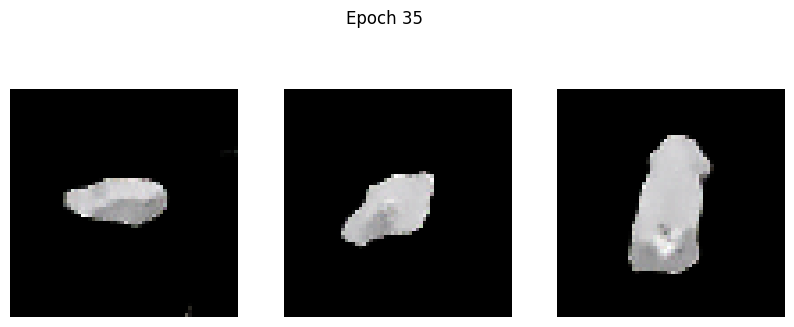

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4238 - g_loss: 1.4648
Epoch 36/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.4070 - g_loss: 1.3754

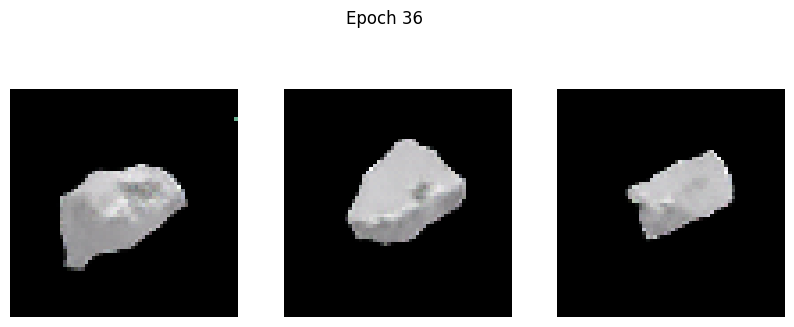

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4071 - g_loss: 1.3758
Epoch 37/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.4040 - g_loss: 1.4754

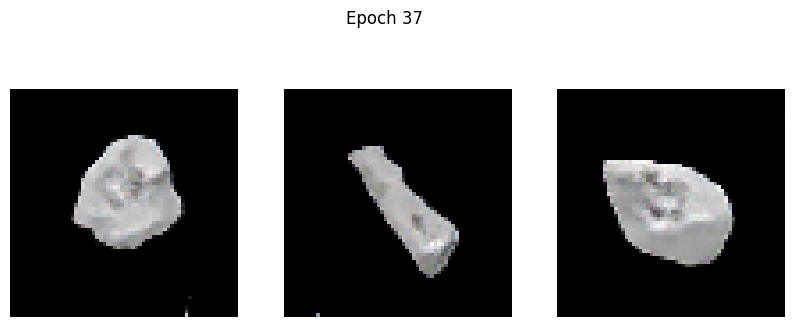

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4040 - g_loss: 1.4752
Epoch 38/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3939 - g_loss: 1.5133

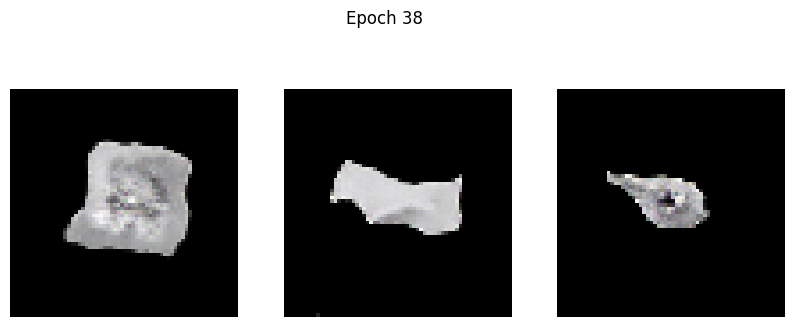

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3941 - g_loss: 1.5134
Epoch 39/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3820 - g_loss: 1.4658

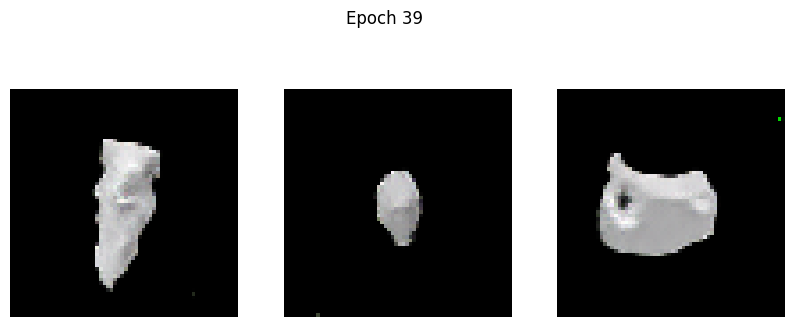

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3821 - g_loss: 1.4661
Epoch 40/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4370 - g_loss: 1.6269

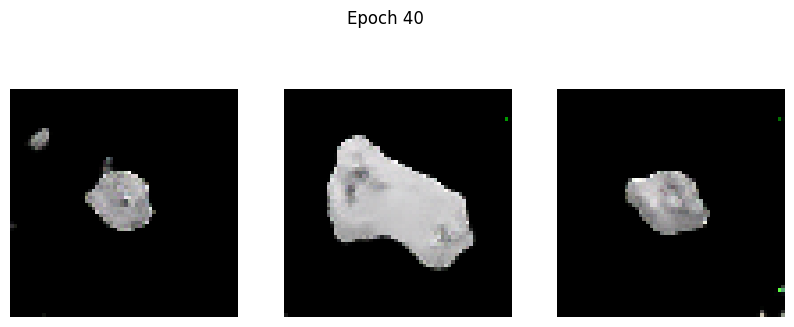

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4376 - g_loss: 1.6270
Epoch 41/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3730 - g_loss: 1.3675

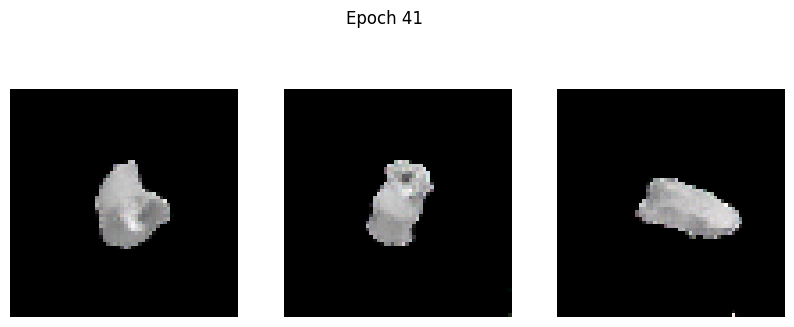

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3730 - g_loss: 1.3679
Epoch 42/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3746 - g_loss: 1.4909

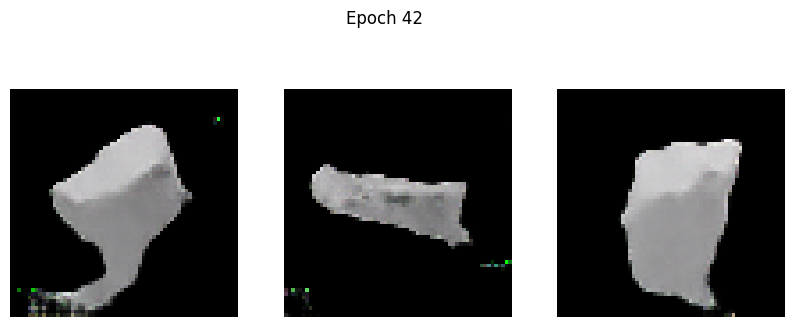

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3746 - g_loss: 1.4909
Epoch 43/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3835 - g_loss: 1.5567

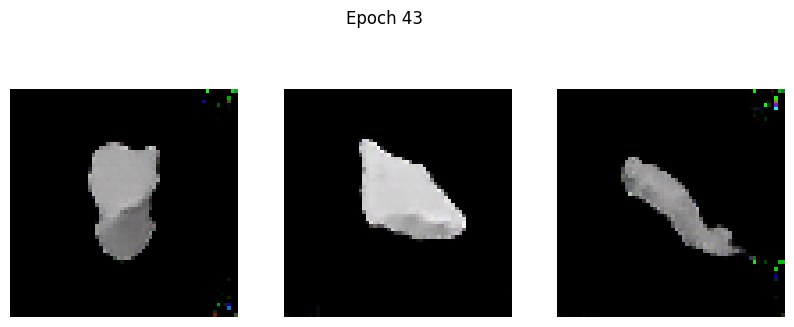

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3837 - g_loss: 1.5566
Epoch 44/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4133 - g_loss: 1.6122

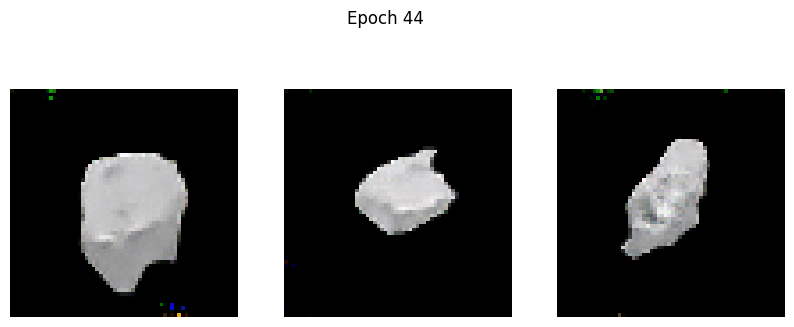

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4135 - g_loss: 1.6121
Epoch 45/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3911 - g_loss: 1.5500

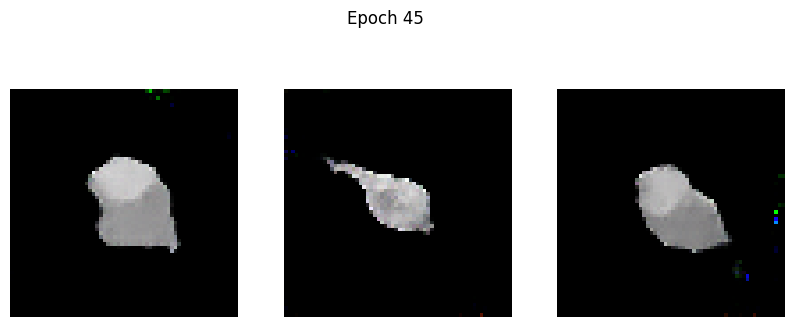

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3912 - g_loss: 1.5500
Epoch 46/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3634 - g_loss: 1.5379

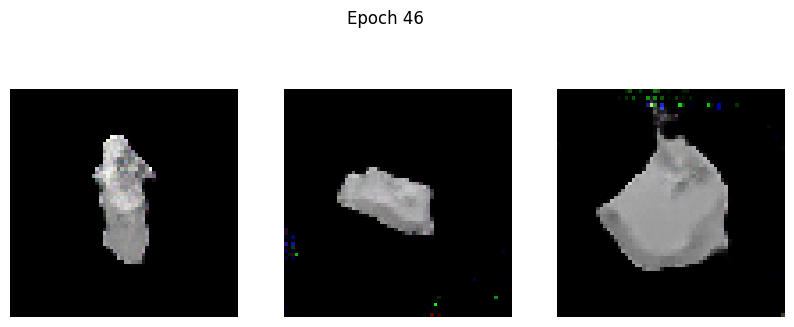

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3634 - g_loss: 1.5379
Epoch 47/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4129 - g_loss: 1.6644

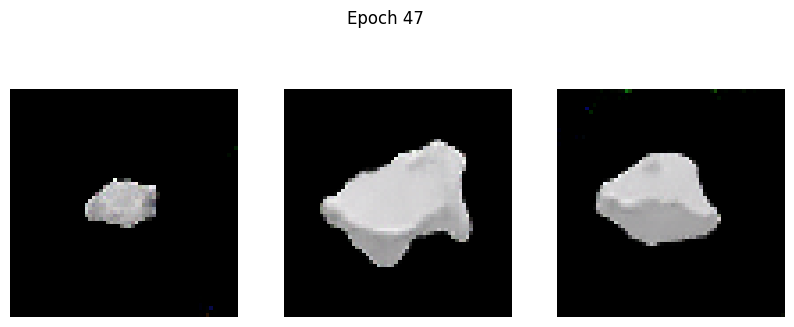

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4128 - g_loss: 1.6643
Epoch 48/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3432 - g_loss: 1.5683

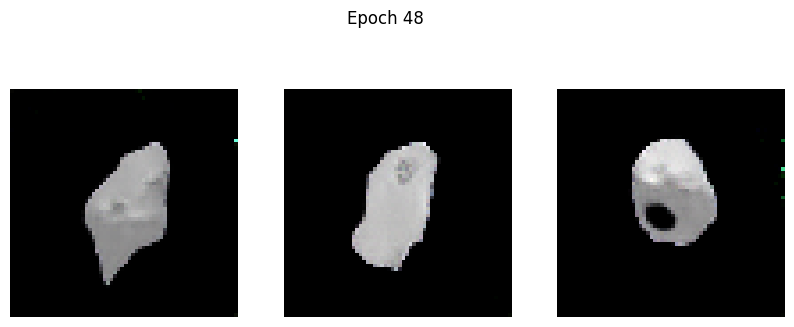

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3433 - g_loss: 1.5684
Epoch 49/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3435 - g_loss: 1.6145

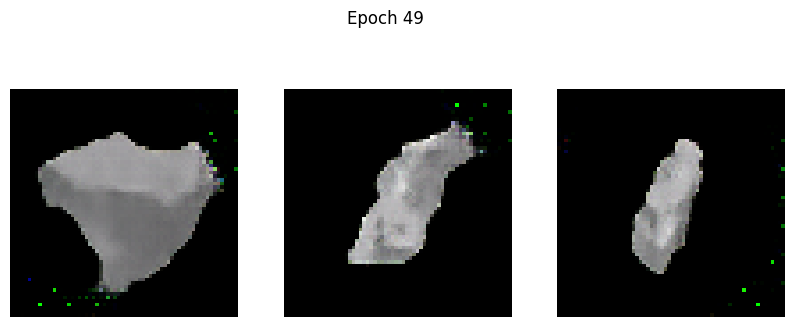

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3437 - g_loss: 1.6146
Epoch 50/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3977 - g_loss: 1.6545

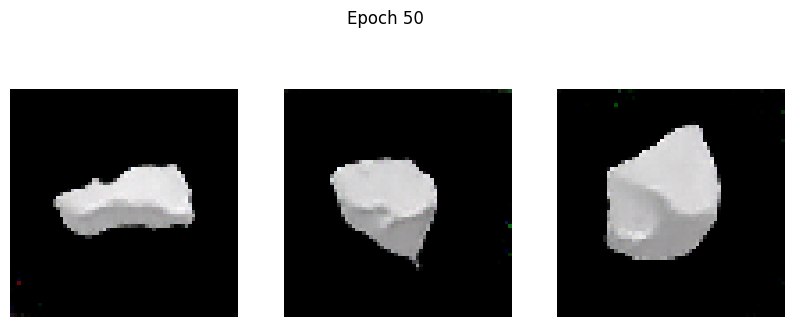

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3974 - g_loss: 1.6544
Epoch 51/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3514 - g_loss: 1.6991

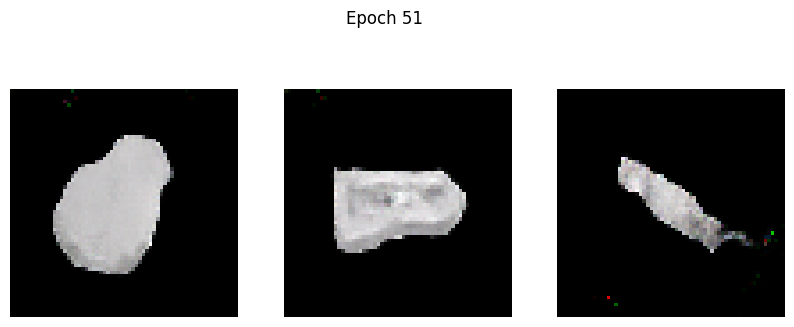

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3518 - g_loss: 1.6998
Epoch 52/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3131 - g_loss: 1.5930

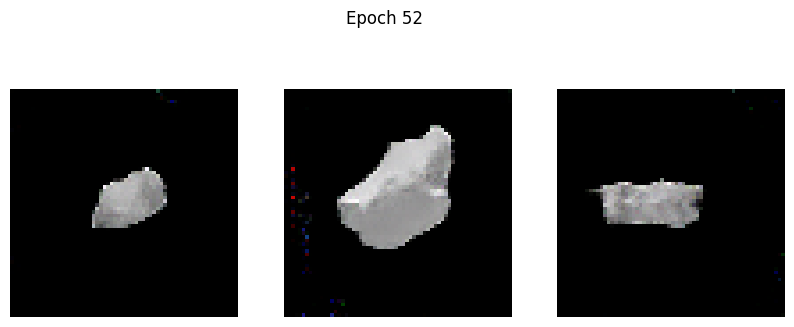

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3132 - g_loss: 1.5932
Epoch 53/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3620 - g_loss: 1.7069

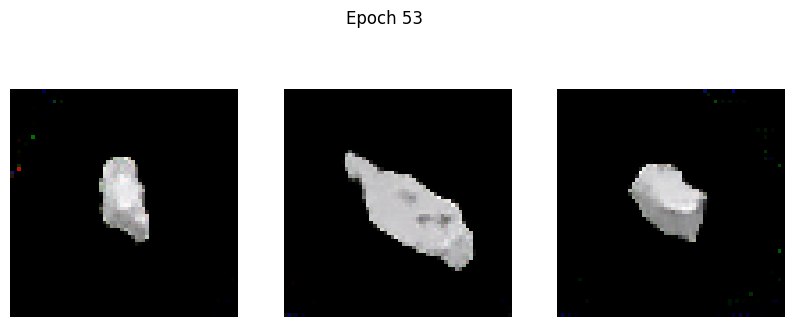

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3621 - g_loss: 1.7068
Epoch 54/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3495 - g_loss: 1.6888

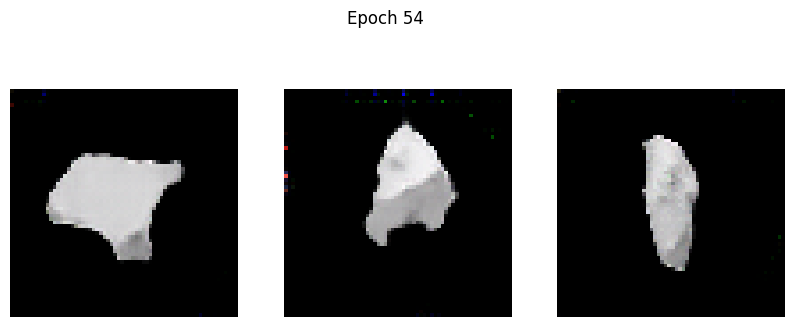

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3496 - g_loss: 1.6891
Epoch 55/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3416 - g_loss: 1.7219

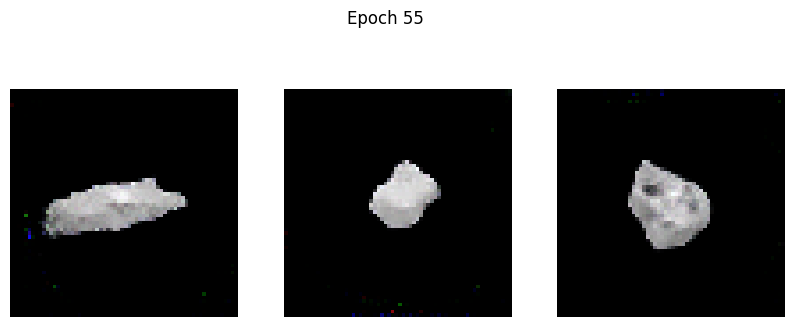

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3416 - g_loss: 1.7223
Epoch 56/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.3940 - g_loss: 1.8250

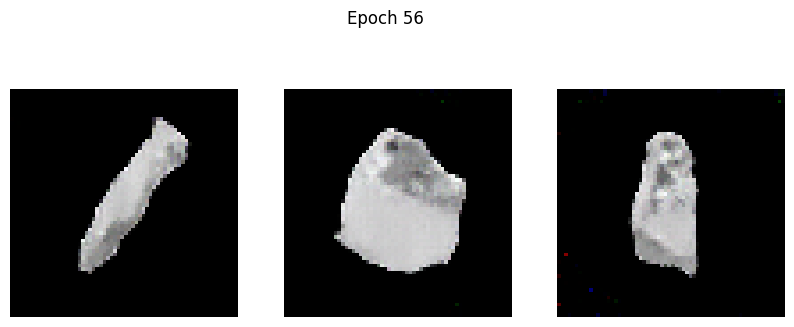

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3937 - g_loss: 1.8243
Epoch 57/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3252 - g_loss: 1.7633

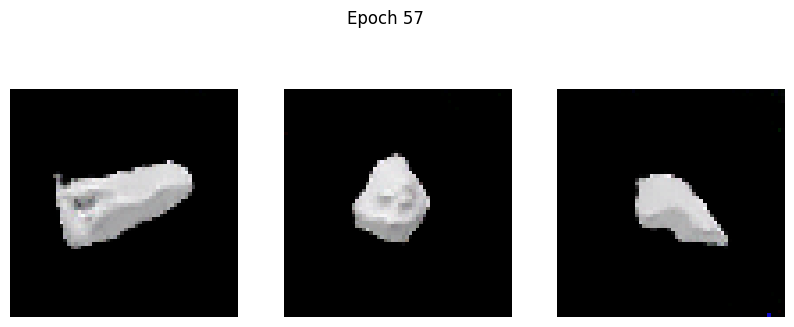

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3254 - g_loss: 1.7633
Epoch 58/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3480 - g_loss: 1.7422

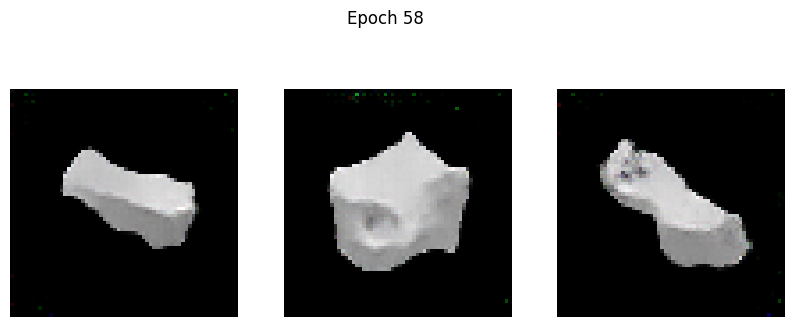

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3480 - g_loss: 1.7425
Epoch 59/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3317 - g_loss: 1.8094

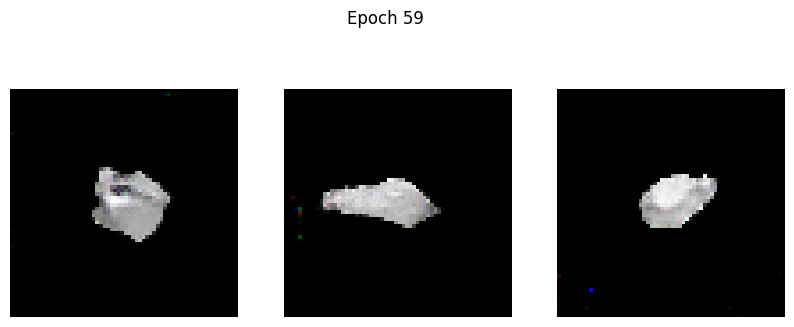

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.3316 - g_loss: 1.8092
Epoch 60/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3222 - g_loss: 1.7903

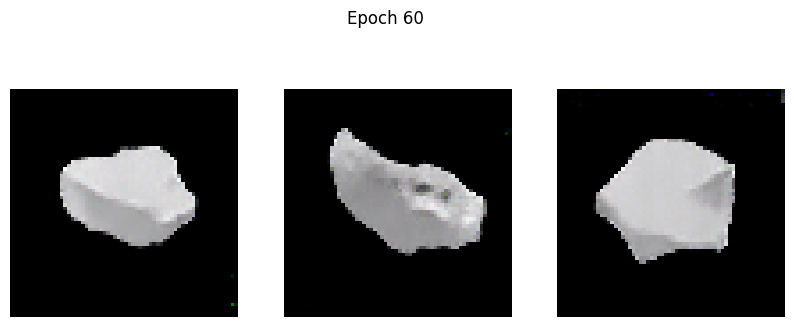

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3222 - g_loss: 1.7904
Epoch 61/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3241 - g_loss: 1.8889

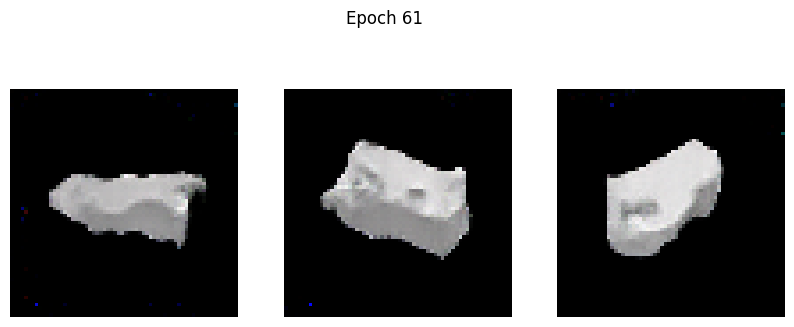

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3242 - g_loss: 1.8887
Epoch 62/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5707 - g_loss: 2.1679

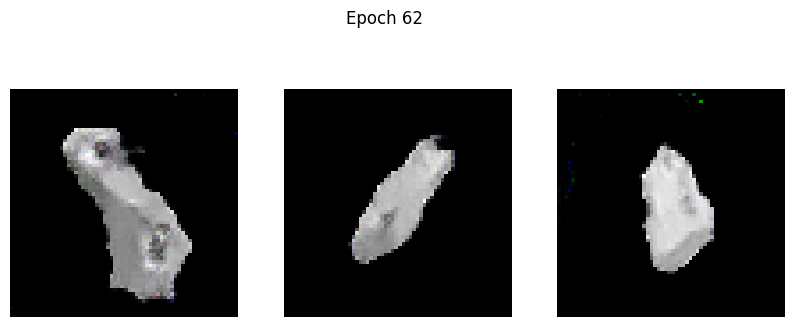

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5700 - g_loss: 2.1666
Epoch 63/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2971 - g_loss: 1.7371

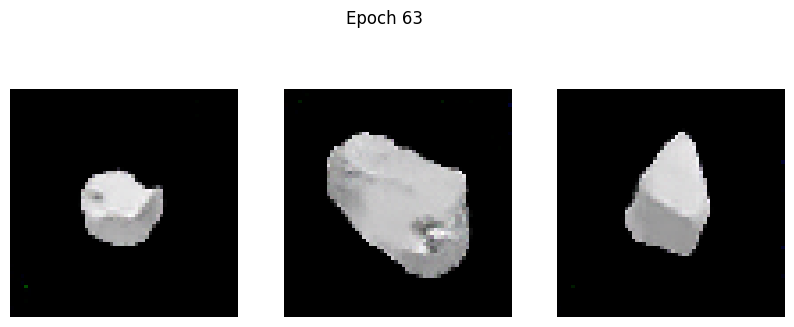

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2971 - g_loss: 1.7372
Epoch 64/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3005 - g_loss: 1.8219

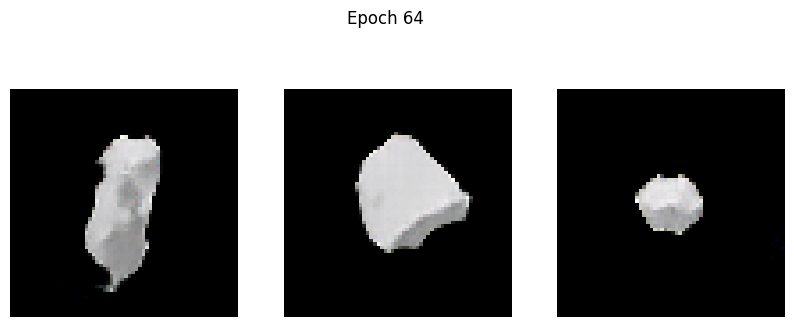

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3006 - g_loss: 1.8220
Epoch 65/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3138 - g_loss: 1.8525

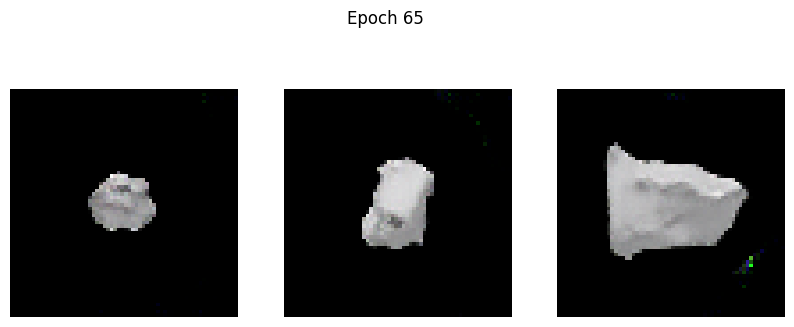

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3138 - g_loss: 1.8525
Epoch 66/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3331 - g_loss: 1.9219

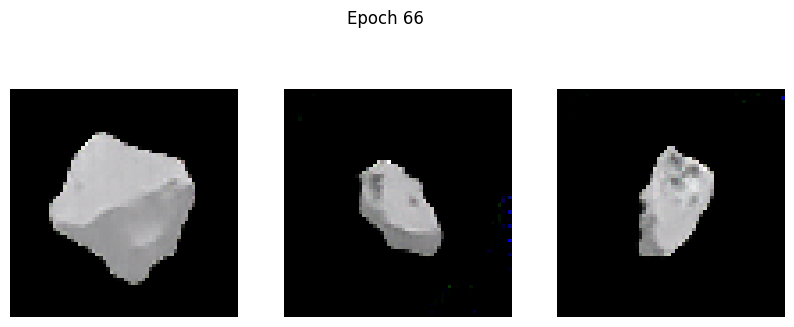

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3331 - g_loss: 1.9215
Epoch 67/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3125 - g_loss: 1.9326

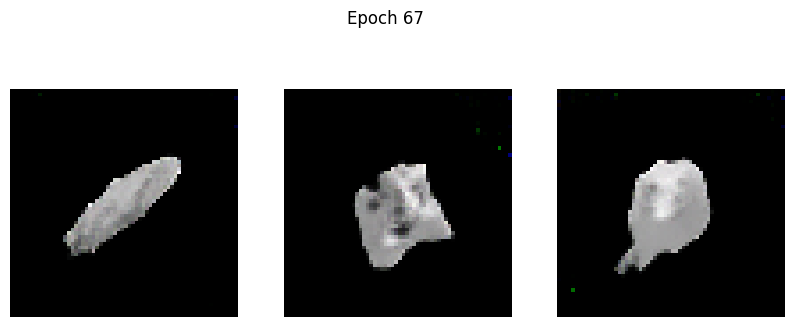

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3130 - g_loss: 1.9330
Epoch 68/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2814 - g_loss: 1.8135

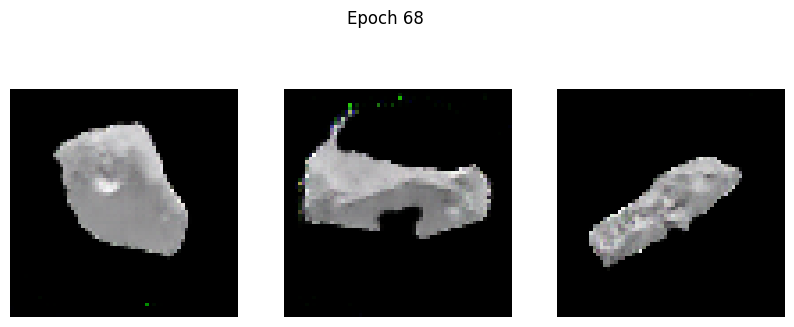

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2815 - g_loss: 1.8136
Epoch 69/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2941 - g_loss: 1.9203

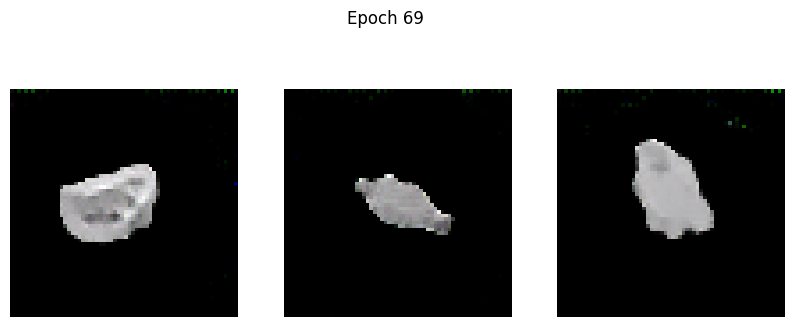

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2942 - g_loss: 1.9207
Epoch 70/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3090 - g_loss: 1.9200

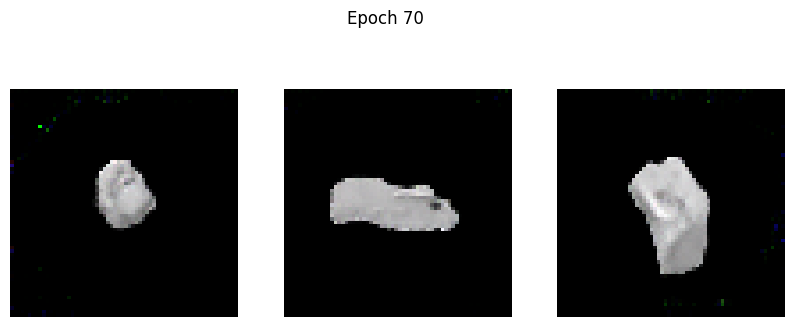

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3089 - g_loss: 1.9199
Epoch 71/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3733 - g_loss: 2.1598

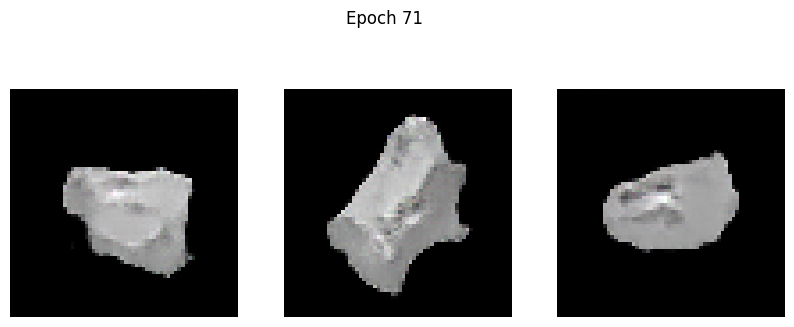

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.3741 - g_loss: 2.1610
Epoch 72/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3000 - g_loss: 1.7841

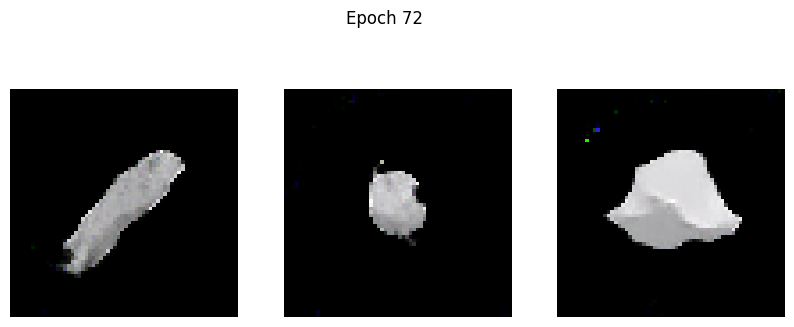

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2998 - g_loss: 1.7844
Epoch 73/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2762 - g_loss: 1.8337

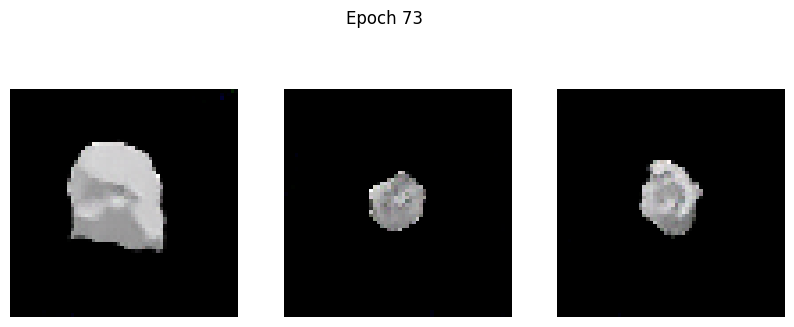

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2763 - g_loss: 1.8341
Epoch 74/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2884 - g_loss: 1.9420

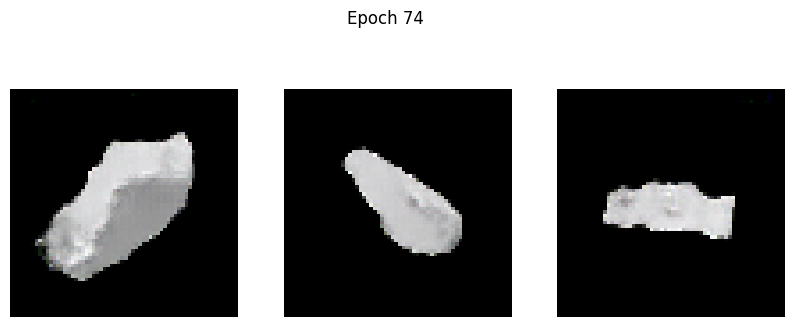

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2884 - g_loss: 1.9423
Epoch 75/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3015 - g_loss: 1.9769

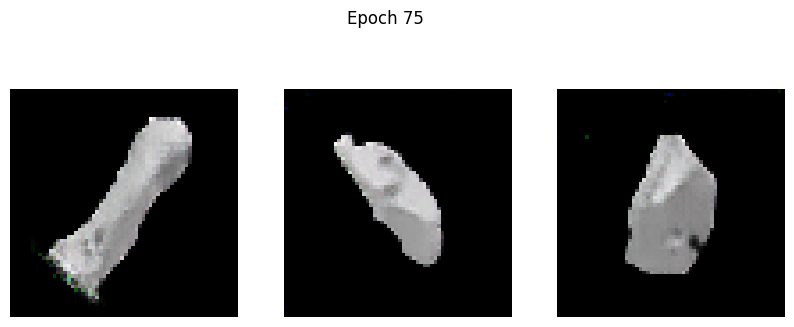

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3013 - g_loss: 1.9771
Epoch 76/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2964 - g_loss: 2.0760

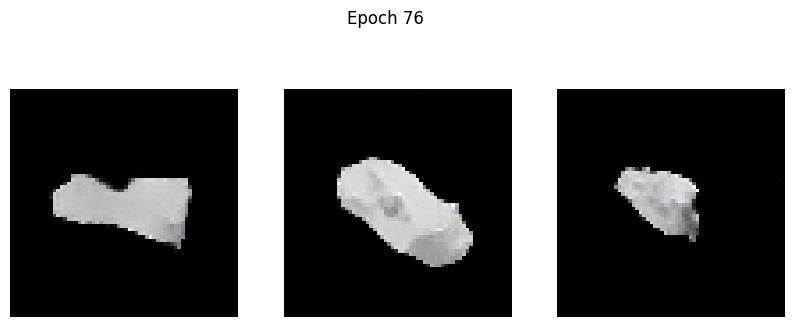

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2962 - g_loss: 2.0757
Epoch 77/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3181 - g_loss: 2.1457

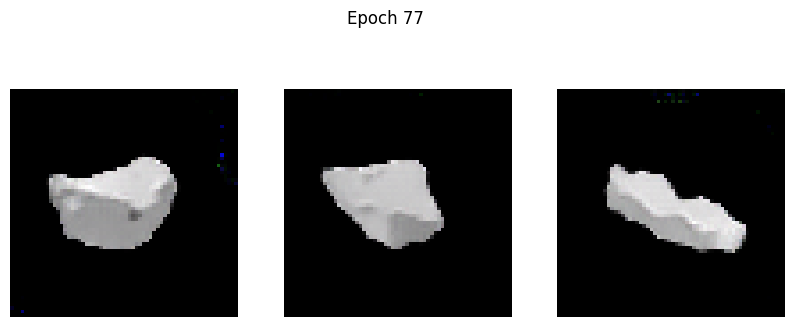

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3182 - g_loss: 2.1453
Epoch 78/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2472 - g_loss: 1.9945

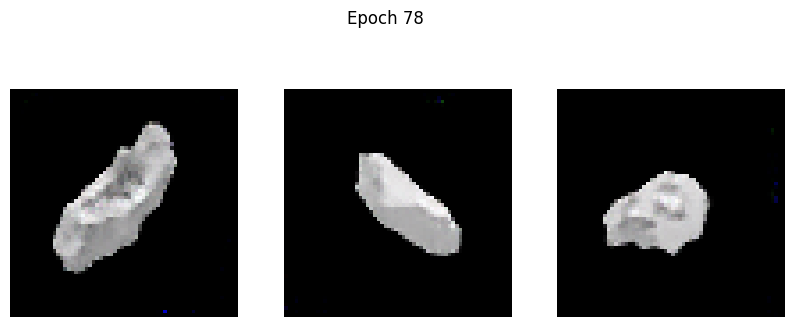

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2474 - g_loss: 1.9946
Epoch 79/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2638 - g_loss: 2.0452

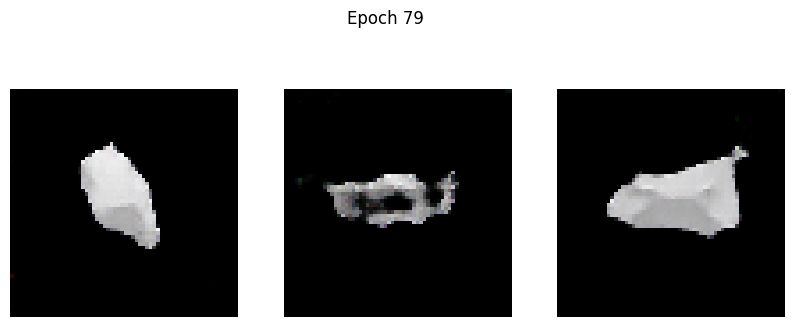

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2640 - g_loss: 2.0454
Epoch 80/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2999 - g_loss: 2.1600

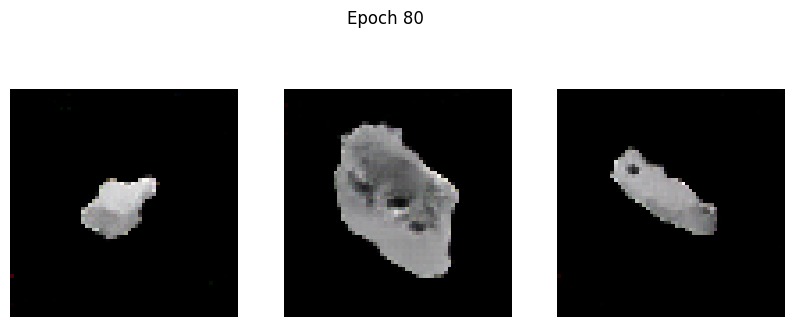

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2999 - g_loss: 2.1598
Epoch 81/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3717 - g_loss: 2.2919

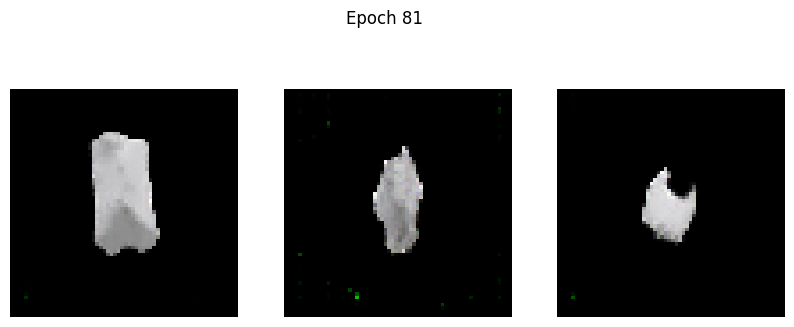

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3710 - g_loss: 2.2896
Epoch 82/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2807 - g_loss: 2.0705

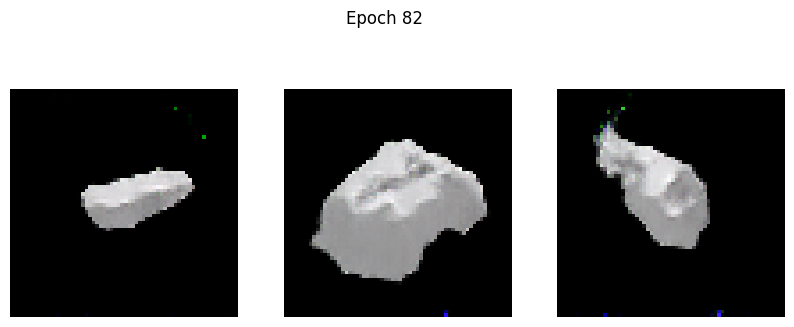

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2806 - g_loss: 2.0706
Epoch 83/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2793 - g_loss: 2.1342

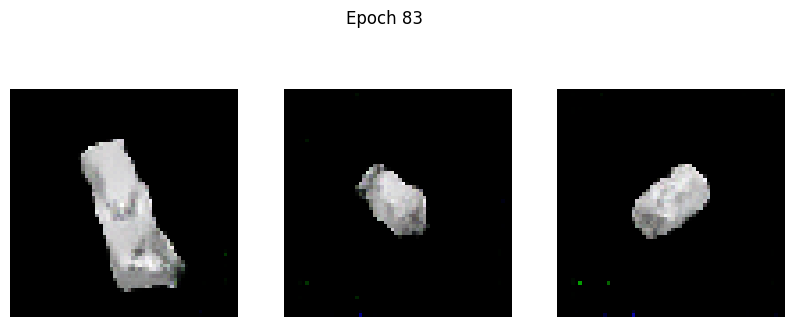

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2792 - g_loss: 2.1341
Epoch 84/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2822 - g_loss: 2.2400

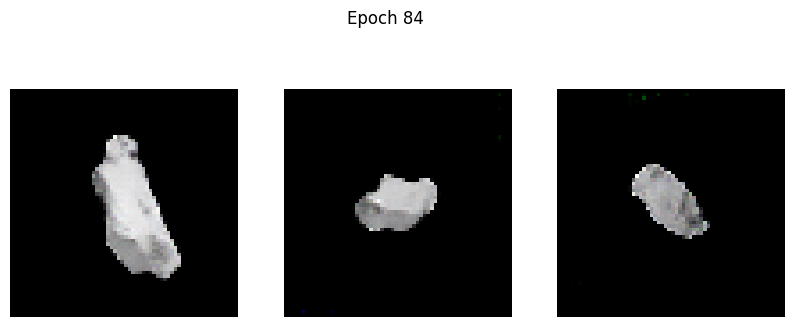

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2824 - g_loss: 2.2398
Epoch 85/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2740 - g_loss: 2.1409

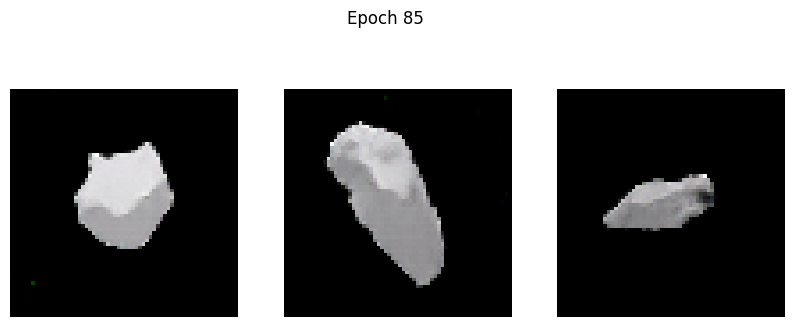

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2740 - g_loss: 2.1409
Epoch 86/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2613 - g_loss: 2.1664

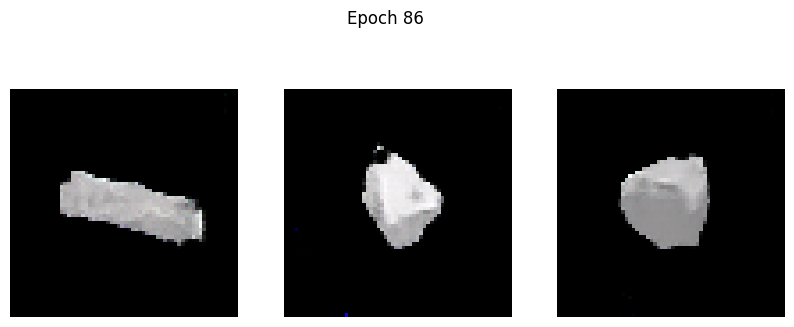

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2613 - g_loss: 2.1664
Epoch 87/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4154 - g_loss: 2.4823

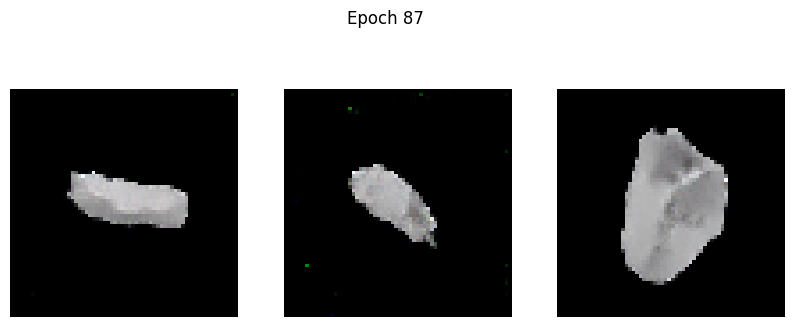

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4146 - g_loss: 2.4804
Epoch 88/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2738 - g_loss: 2.1072

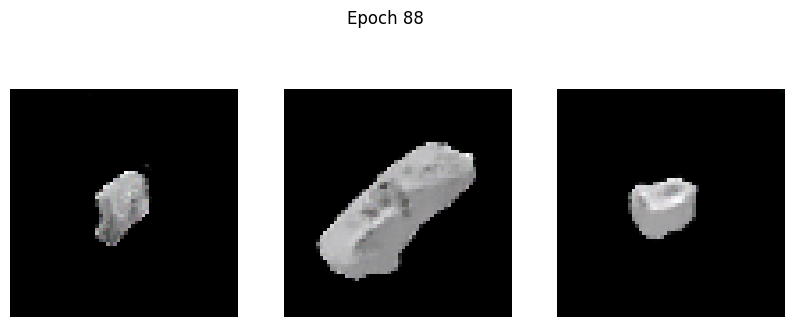

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2738 - g_loss: 2.1073
Epoch 89/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2398 - g_loss: 2.1581

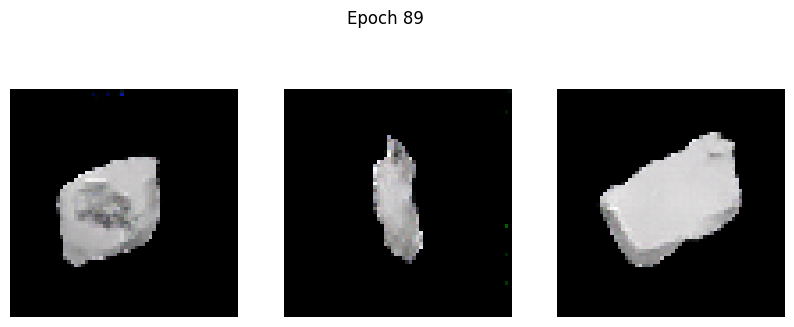

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2399 - g_loss: 2.1582
Epoch 90/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2759 - g_loss: 2.2696

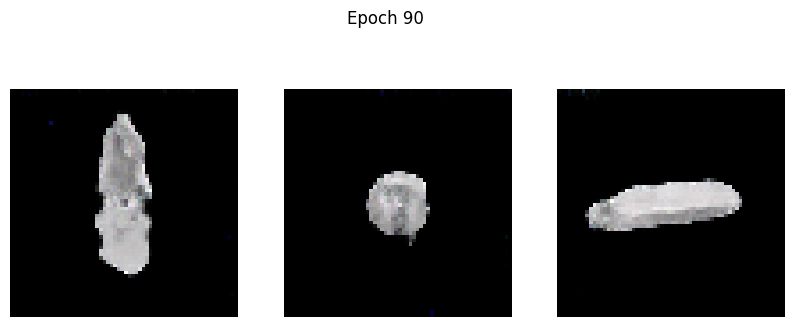

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2758 - g_loss: 2.2692
Epoch 91/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3275 - g_loss: 2.4733

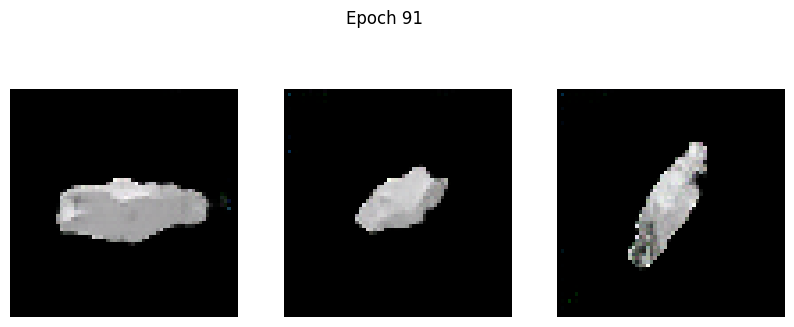

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3276 - g_loss: 2.4723
Epoch 92/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2531 - g_loss: 2.1778

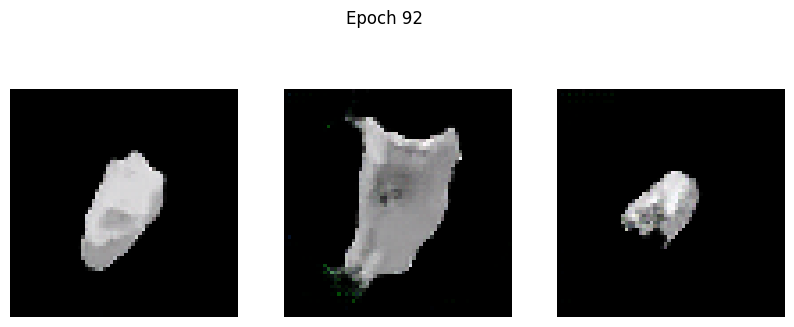

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2532 - g_loss: 2.1776
Epoch 93/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2349 - g_loss: 2.2157

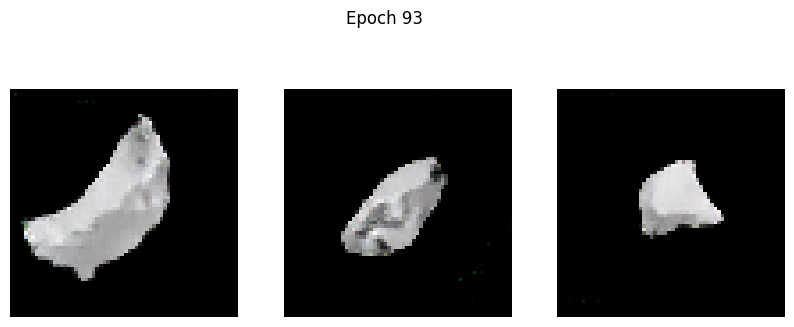

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2350 - g_loss: 2.2157
Epoch 94/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3577 - g_loss: 2.3625

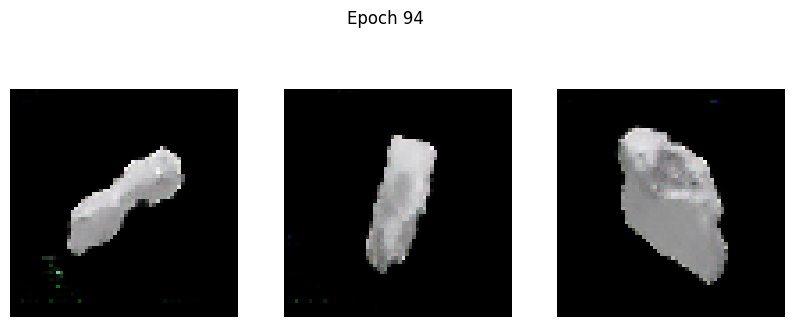

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3580 - g_loss: 2.3615
Epoch 95/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2308 - g_loss: 2.1245

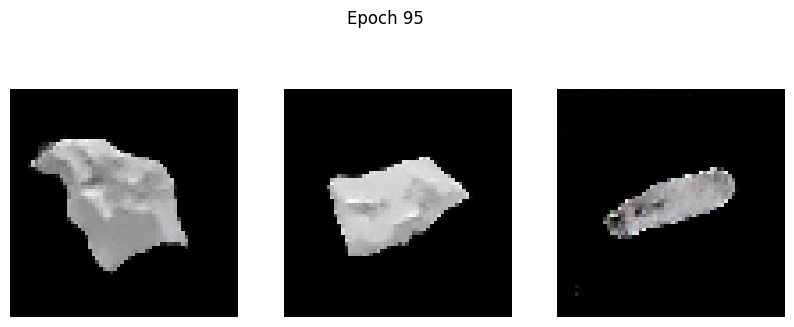

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2309 - g_loss: 2.1246
Epoch 96/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2317 - g_loss: 2.1995

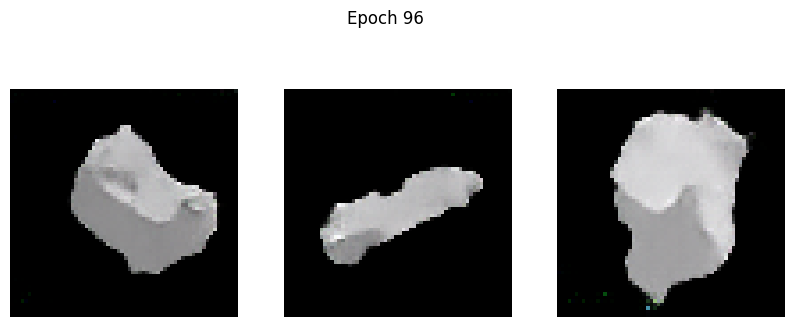

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2320 - g_loss: 2.2001
Epoch 97/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2342 - g_loss: 2.2373

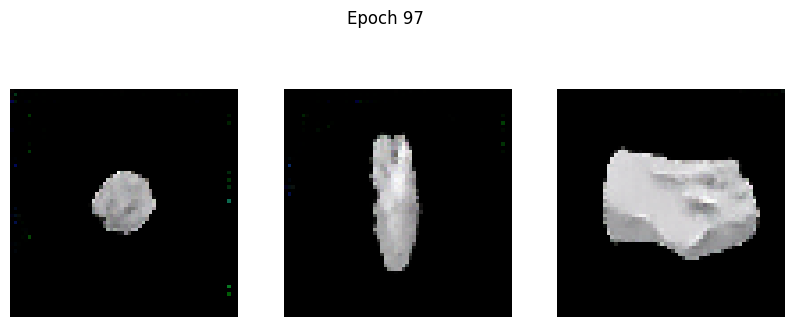

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2344 - g_loss: 2.2376
Epoch 98/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2562 - g_loss: 2.2641

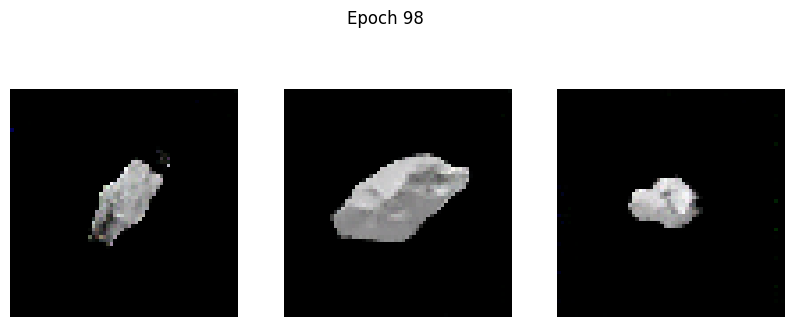

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2562 - g_loss: 2.2642
Epoch 99/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2471 - g_loss: 2.3151

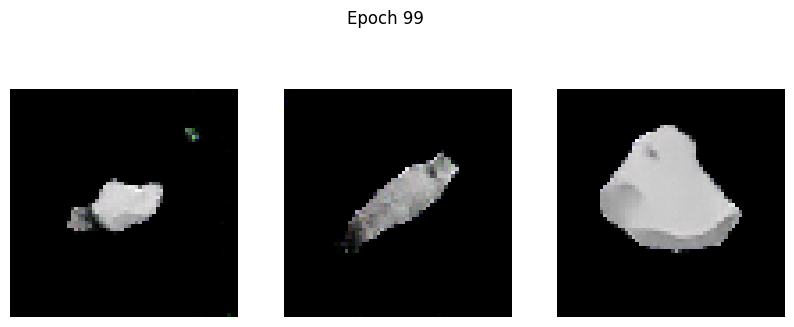

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2472 - g_loss: 2.3151
Epoch 100/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2519 - g_loss: 2.2753

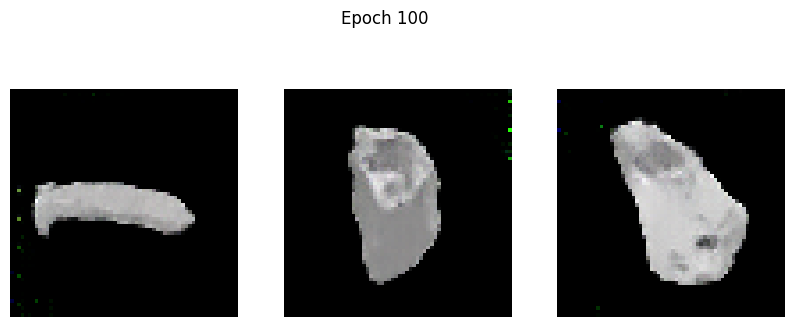

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2520 - g_loss: 2.2757
Epoch 101/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2431 - g_loss: 2.2869

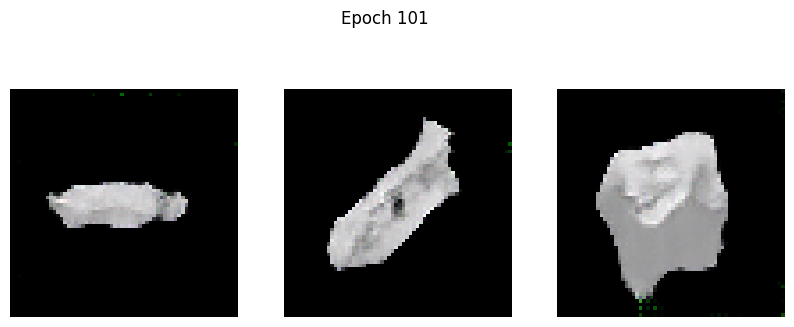

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2431 - g_loss: 2.2873
Epoch 102/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2345 - g_loss: 2.3315

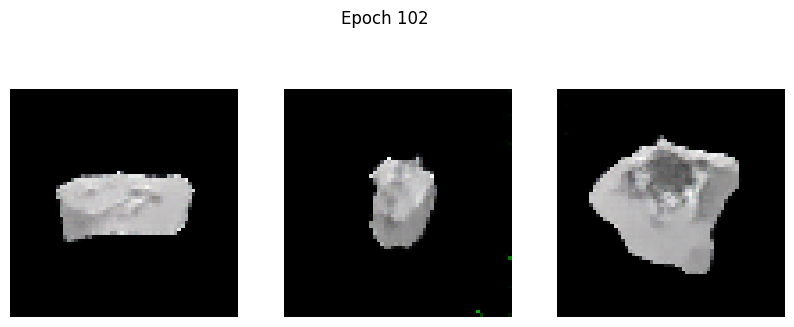

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2346 - g_loss: 2.3321
Epoch 103/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2409 - g_loss: 2.2951

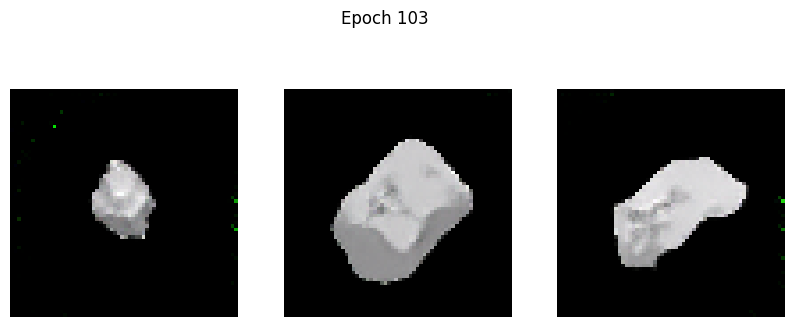

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2409 - g_loss: 2.2952
Epoch 104/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2642 - g_loss: 2.4098

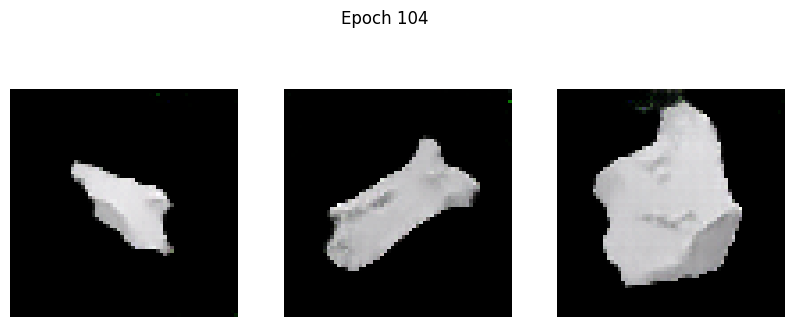

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2642 - g_loss: 2.4098
Epoch 105/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2063 - g_loss: 2.3420

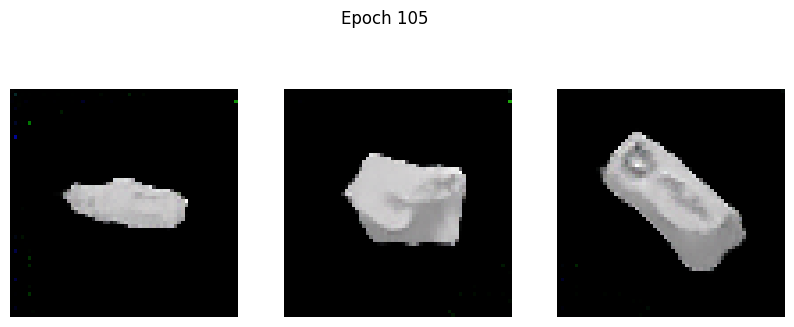

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2064 - g_loss: 2.3421
Epoch 106/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2327 - g_loss: 2.3622

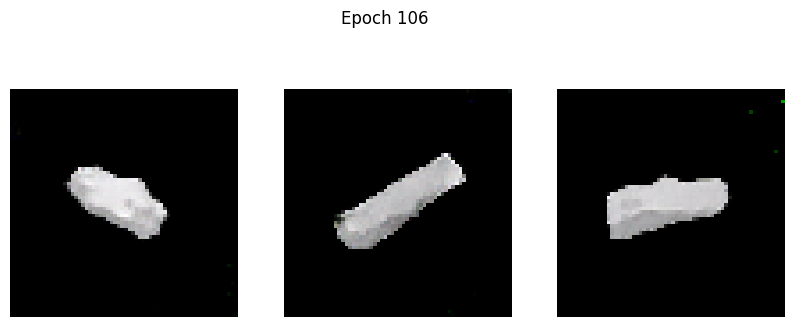

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2328 - g_loss: 2.3624
Epoch 107/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3296 - g_loss: 2.5845

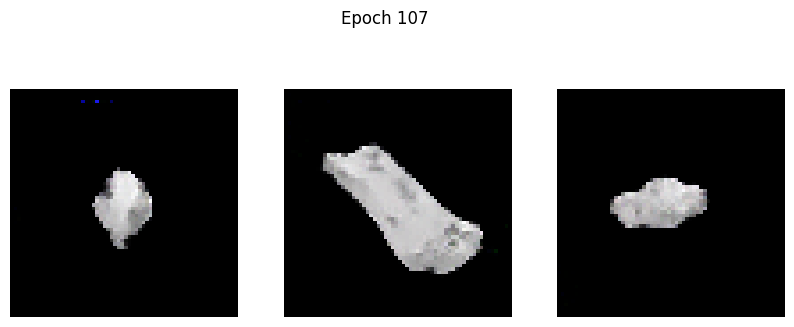

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3300 - g_loss: 2.5845
Epoch 108/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1957 - g_loss: 2.3299

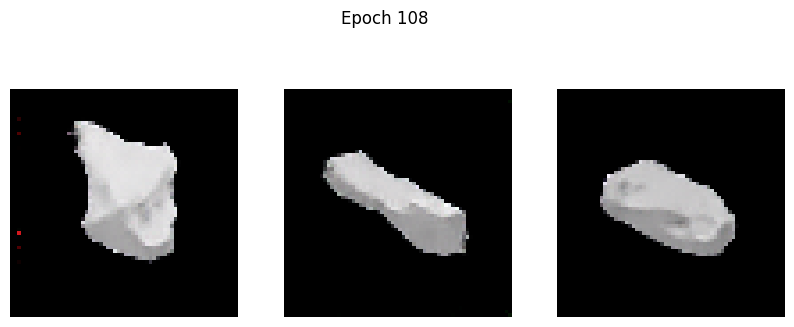

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1958 - g_loss: 2.3296
Epoch 109/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2151 - g_loss: 2.3829

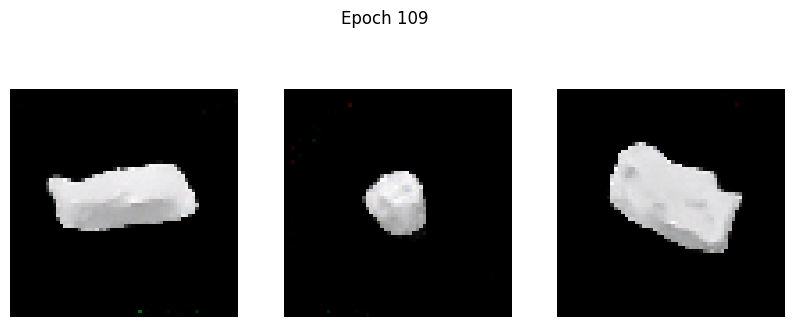

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2150 - g_loss: 2.3826
Epoch 110/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2335 - g_loss: 2.4552

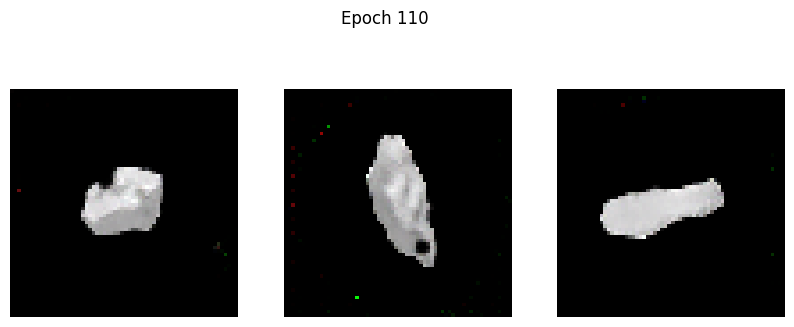

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2337 - g_loss: 2.4552
Epoch 111/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2003 - g_loss: 2.4245

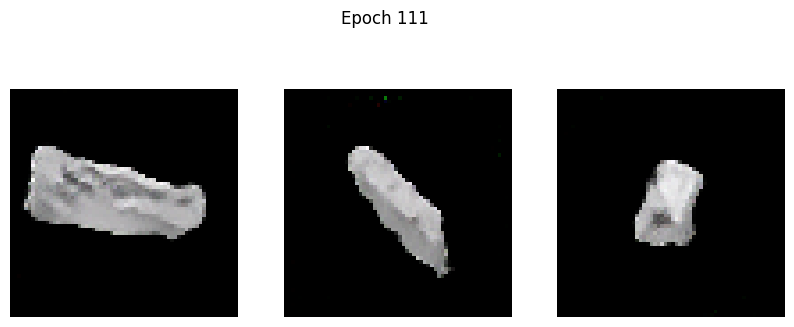

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2003 - g_loss: 2.4244
Epoch 112/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2625 - g_loss: 2.5183

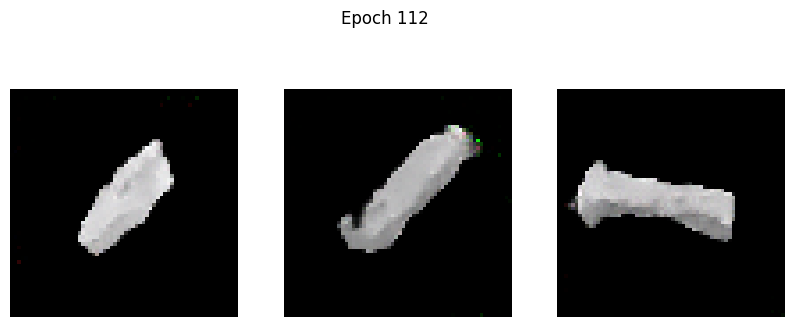

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2623 - g_loss: 2.5178
Epoch 113/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2580 - g_loss: 2.5233

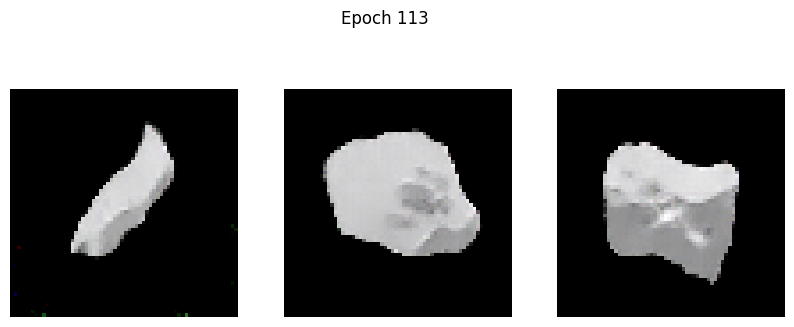

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2578 - g_loss: 2.5227
Epoch 114/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2502 - g_loss: 2.5562

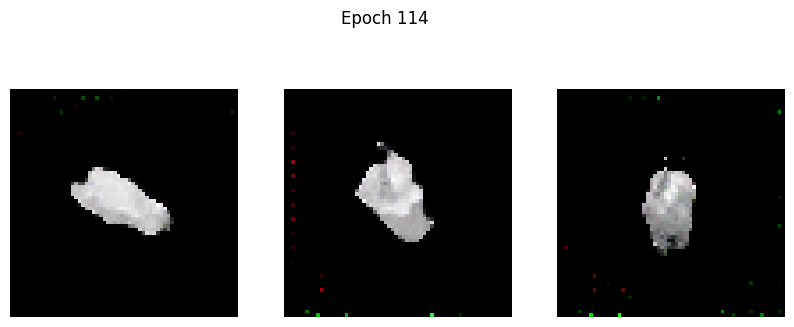

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2512 - g_loss: 2.5577
Epoch 115/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2148 - g_loss: 2.3611

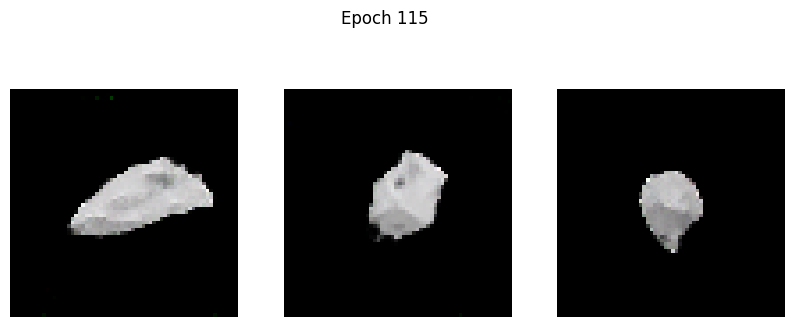

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2149 - g_loss: 2.3613
Epoch 116/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1956 - g_loss: 2.4528

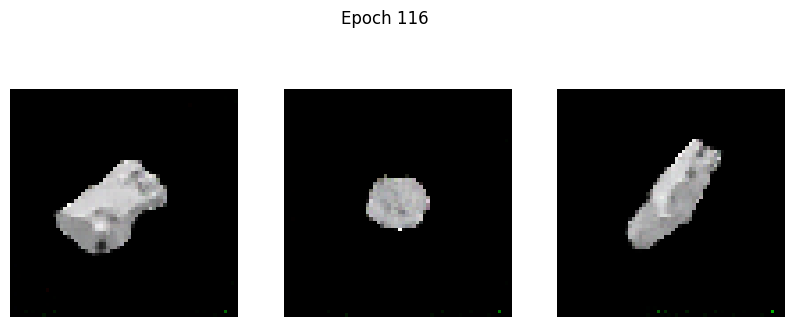

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1955 - g_loss: 2.4527
Epoch 117/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2320 - g_loss: 2.4983

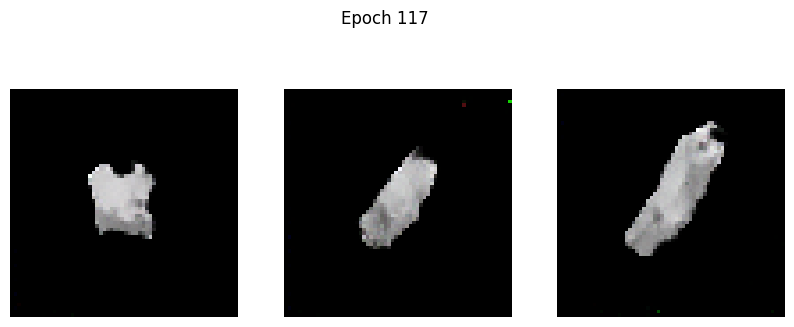

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2320 - g_loss: 2.4986
Epoch 118/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1966 - g_loss: 2.4903

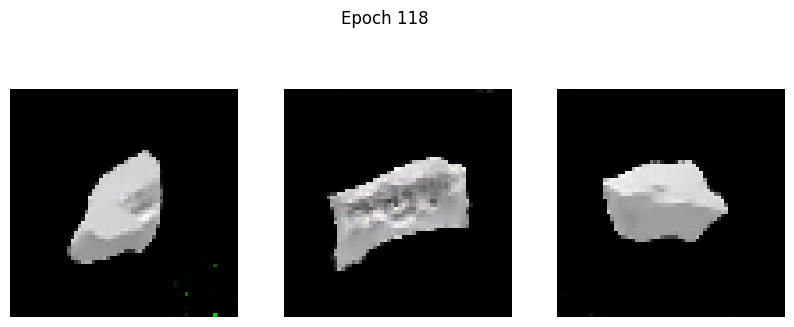

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1968 - g_loss: 2.4908
Epoch 119/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3123 - g_loss: 2.5714

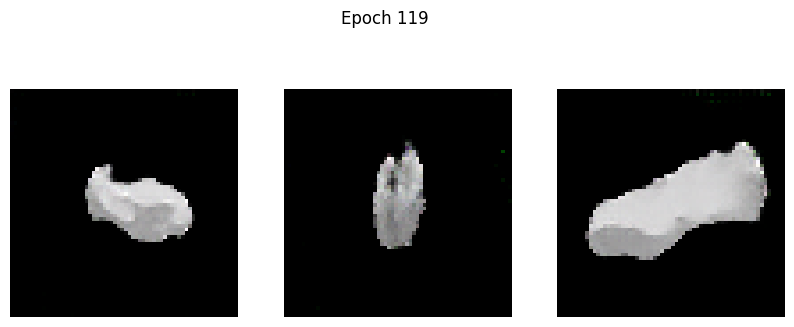

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3116 - g_loss: 2.5712
Epoch 120/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2319 - g_loss: 2.6238

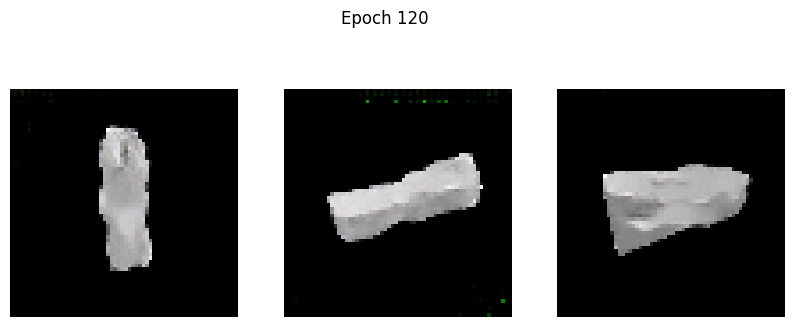

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2321 - g_loss: 2.6240
Epoch 121/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1937 - g_loss: 2.5116

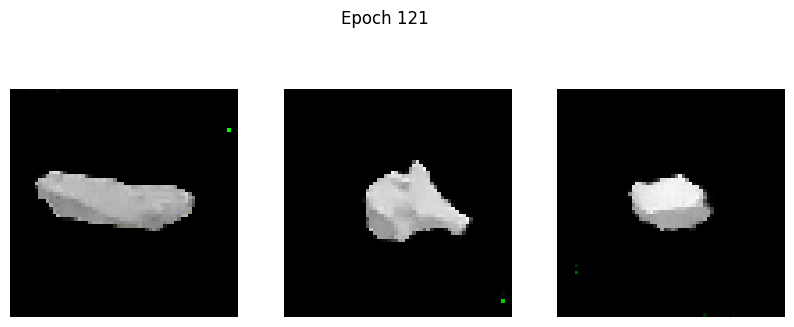

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1938 - g_loss: 2.5115
Epoch 122/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2377 - g_loss: 2.6000

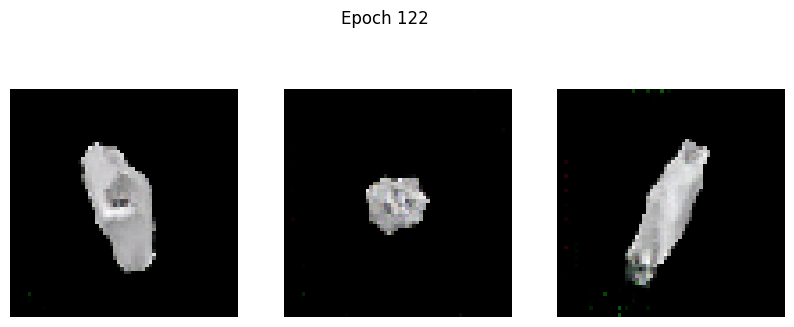

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2376 - g_loss: 2.5999
Epoch 123/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3556 - g_loss: 2.6875

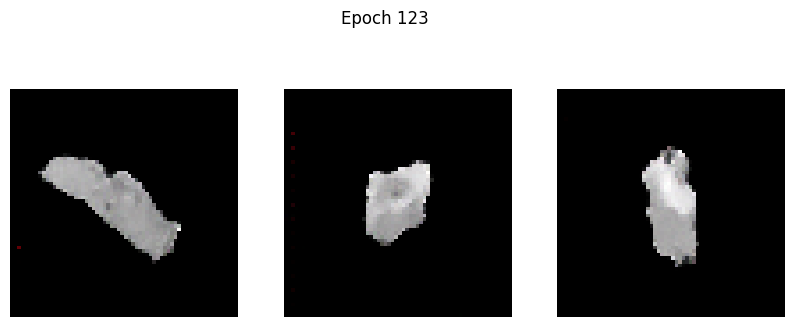

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3561 - g_loss: 2.6868
Epoch 124/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1999 - g_loss: 2.4403

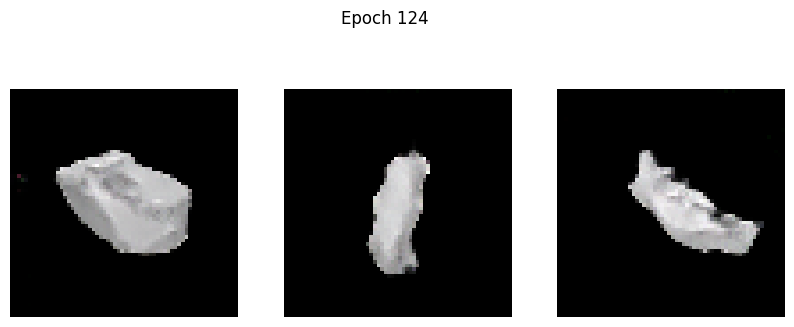

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1999 - g_loss: 2.4405
Epoch 125/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1899 - g_loss: 2.5951

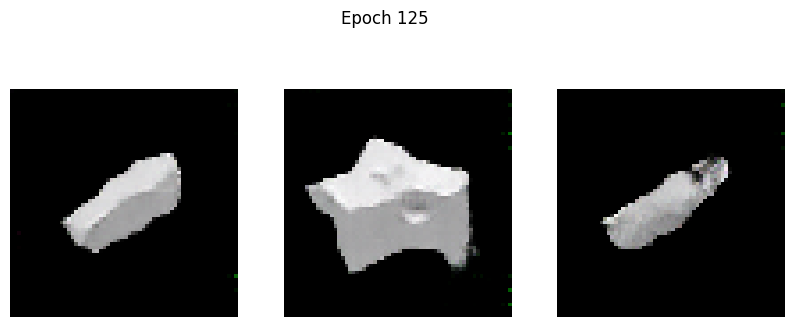

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1899 - g_loss: 2.5945
Epoch 126/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2076 - g_loss: 2.6060

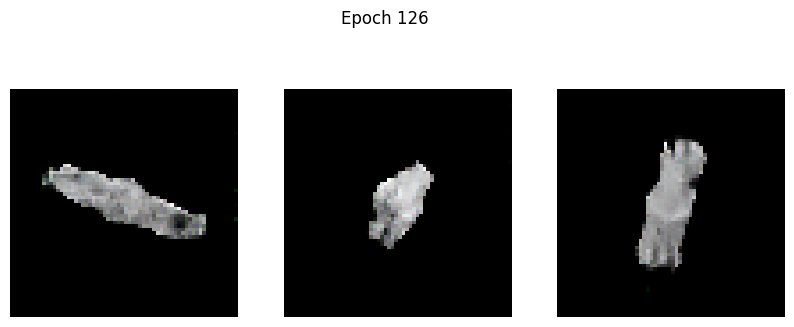

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2080 - g_loss: 2.6064
Epoch 127/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2179 - g_loss: 2.7167

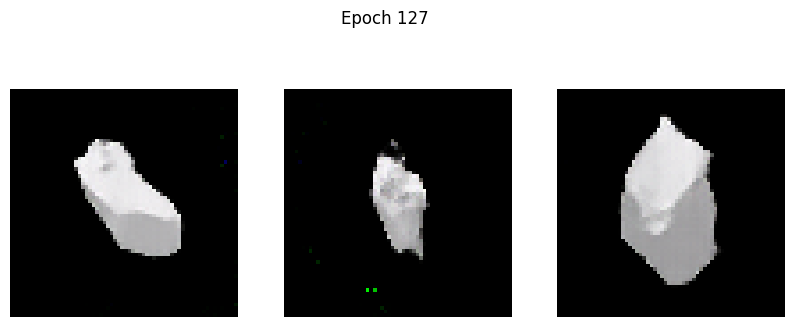

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2178 - g_loss: 2.7153
Epoch 128/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1744 - g_loss: 2.5617

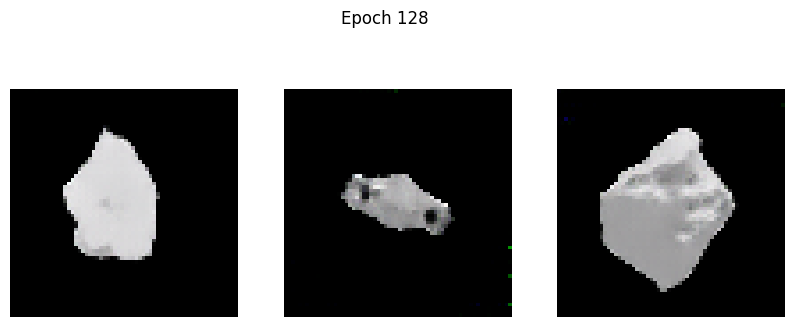

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1749 - g_loss: 2.5625
Epoch 129/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1951 - g_loss: 2.6017

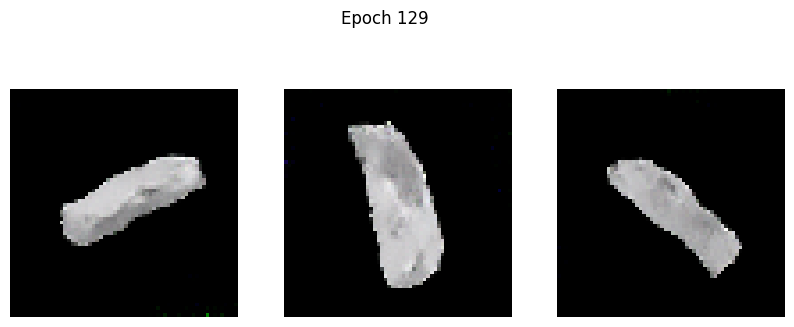

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1952 - g_loss: 2.6015
Epoch 130/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1702 - g_loss: 2.5998

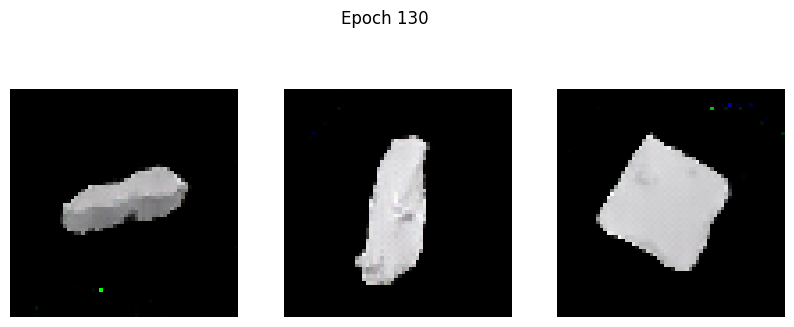

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1703 - g_loss: 2.5999
Epoch 131/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1758 - g_loss: 2.6773

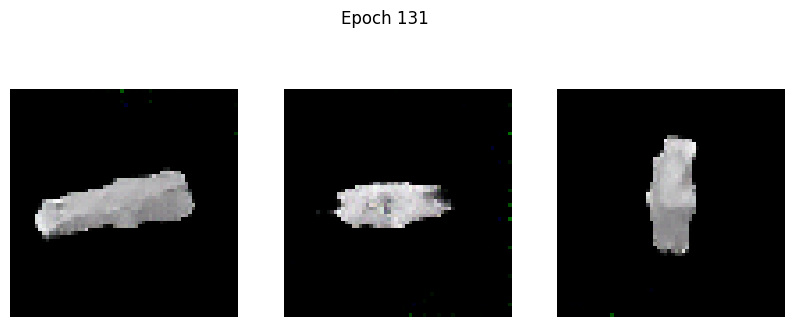

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1758 - g_loss: 2.6773
Epoch 132/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1897 - g_loss: 2.7748

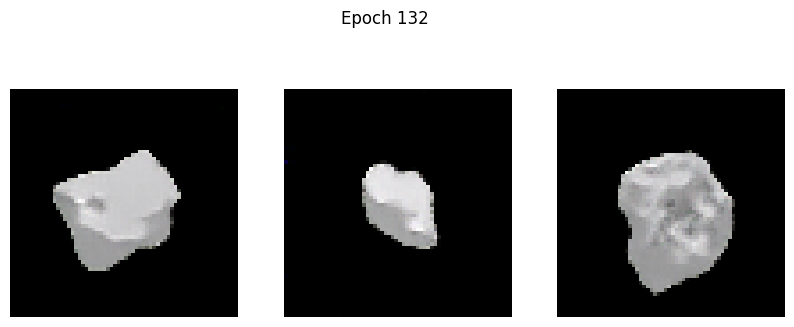

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1897 - g_loss: 2.7746
Epoch 133/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2472 - g_loss: 2.7710

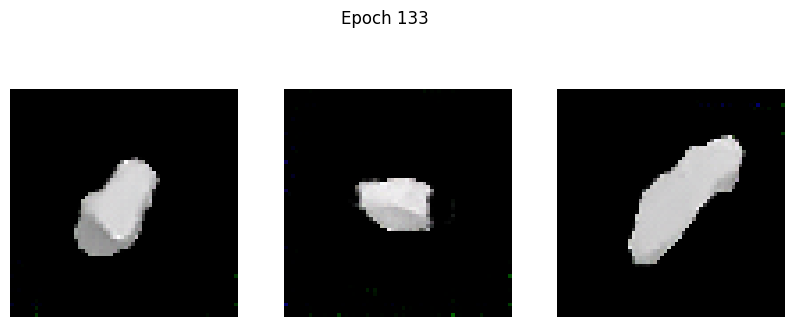

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.2470 - g_loss: 2.7711
Epoch 134/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2283 - g_loss: 2.6804

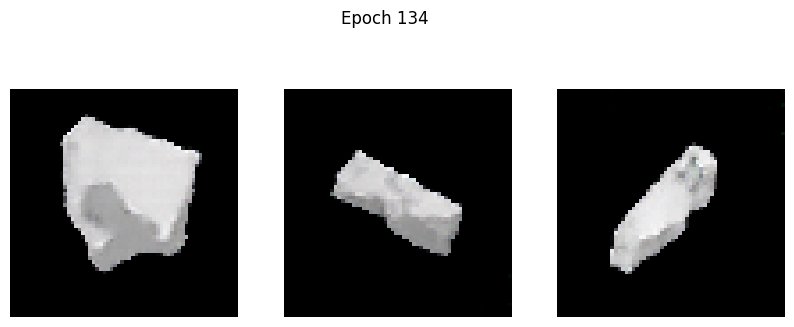

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2281 - g_loss: 2.6807
Epoch 135/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1643 - g_loss: 2.7128

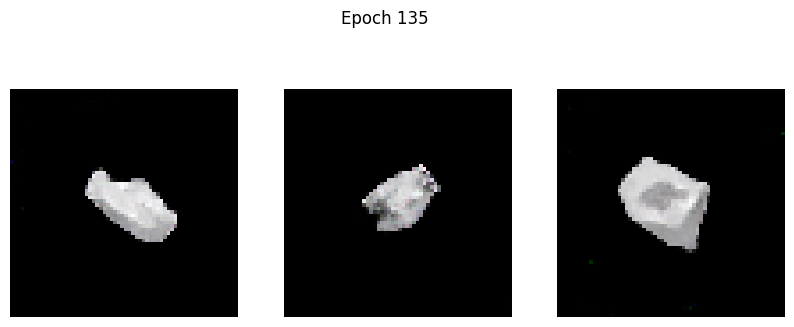

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1644 - g_loss: 2.7127
Epoch 136/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1918 - g_loss: 2.7614

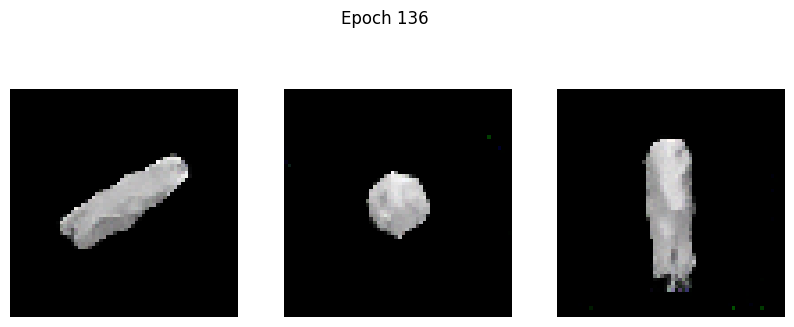

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1920 - g_loss: 2.7613
Epoch 137/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1764 - g_loss: 2.7688

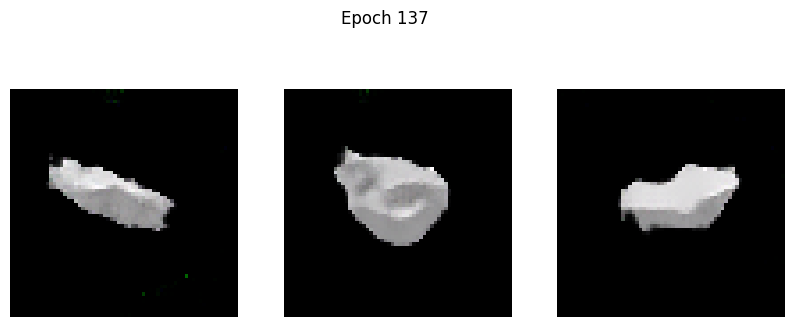

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1768 - g_loss: 2.7694
Epoch 138/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2123 - g_loss: 2.7798

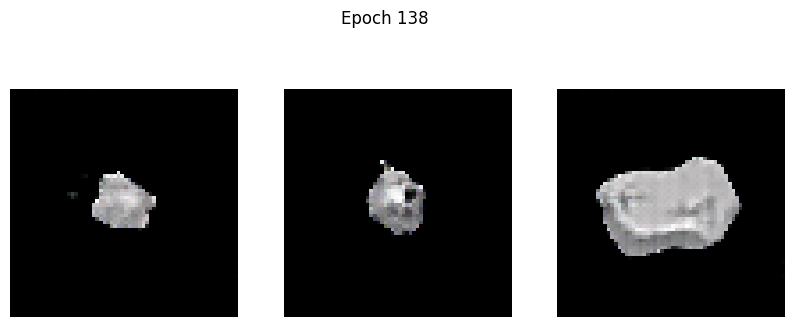

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2139 - g_loss: 2.7822
Epoch 139/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4154 - g_loss: 3.0503

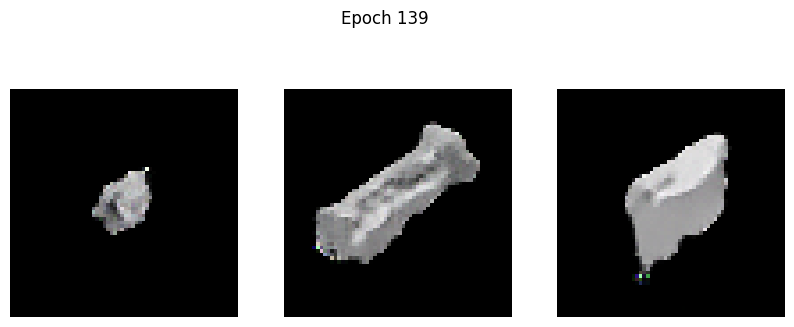

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.4140 - g_loss: 3.0477
Epoch 140/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1650 - g_loss: 2.5921

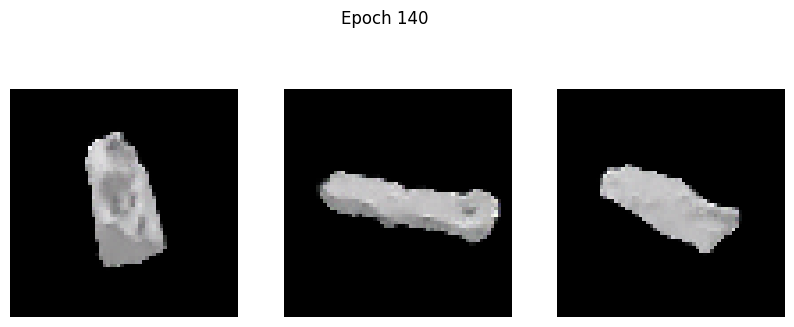

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1649 - g_loss: 2.5922
Epoch 141/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1607 - g_loss: 2.7231

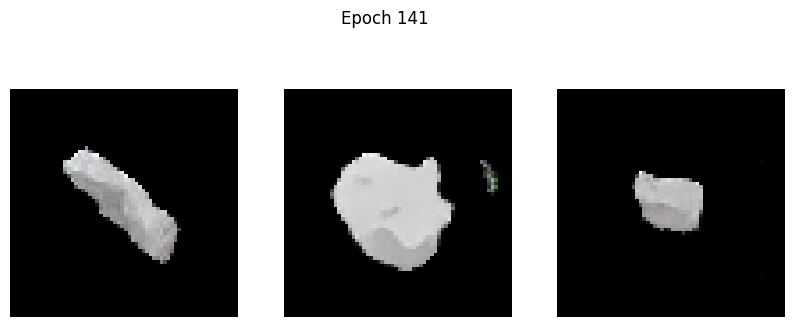

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1607 - g_loss: 2.7230
Epoch 142/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1626 - g_loss: 2.8426

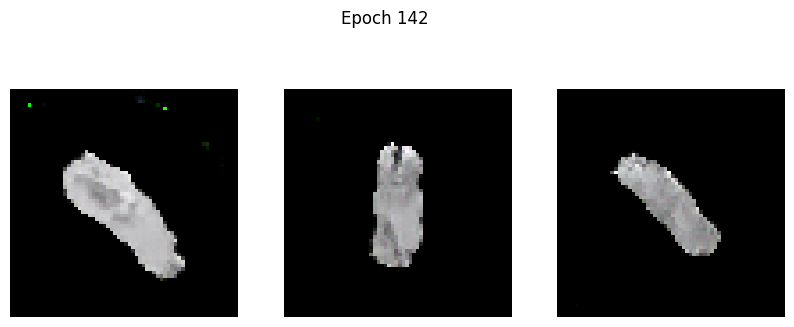

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1625 - g_loss: 2.8421
Epoch 143/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2090 - g_loss: 2.8411

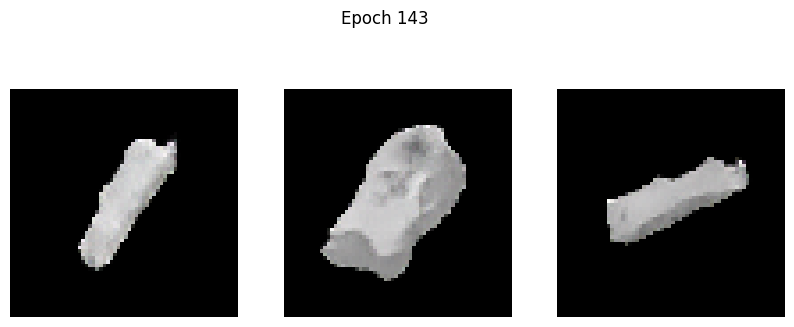

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2094 - g_loss: 2.8419
Epoch 144/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1845 - g_loss: 2.7601

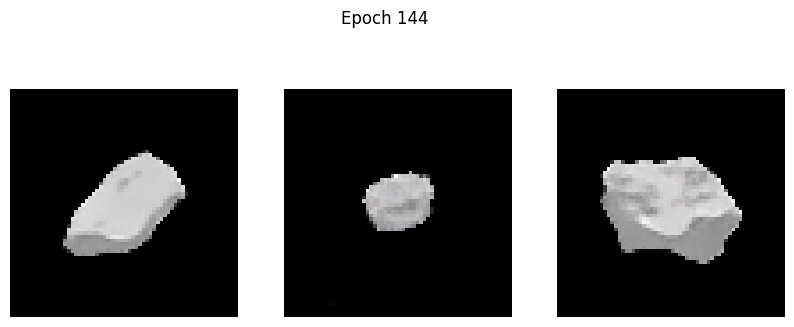

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1847 - g_loss: 2.7605
Epoch 145/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1588 - g_loss: 2.8707

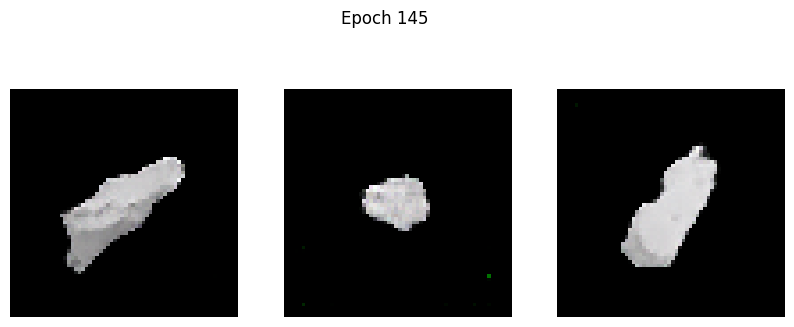

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1588 - g_loss: 2.8703
Epoch 146/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1724 - g_loss: 2.8315

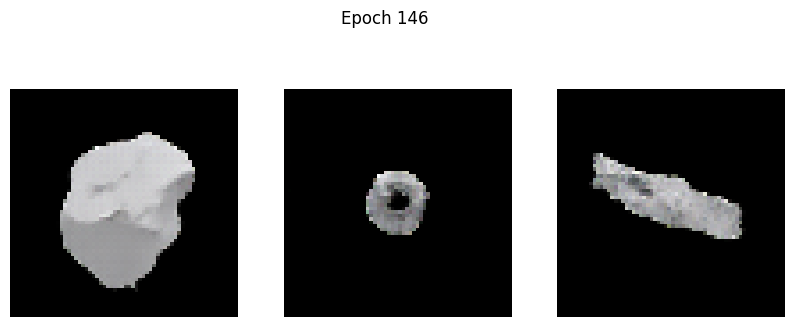

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1728 - g_loss: 2.8324
Epoch 147/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1821 - g_loss: 2.8581

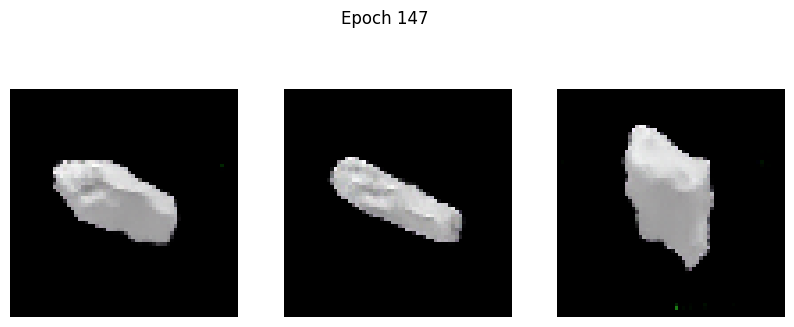

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1824 - g_loss: 2.8584
Epoch 148/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1659 - g_loss: 2.7693

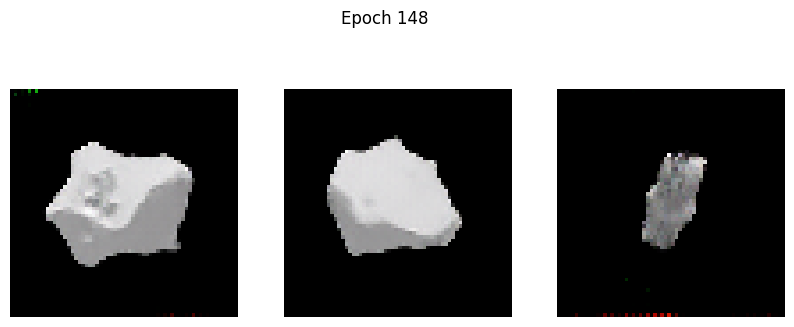

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1660 - g_loss: 2.7697
Epoch 149/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1704 - g_loss: 2.8791

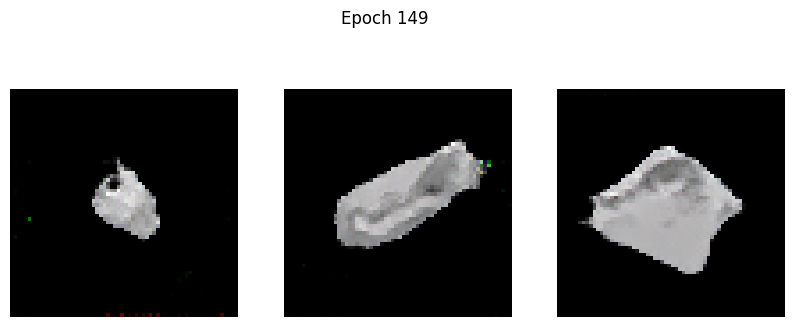

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1706 - g_loss: 2.8791
Epoch 150/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1843 - g_loss: 2.8497

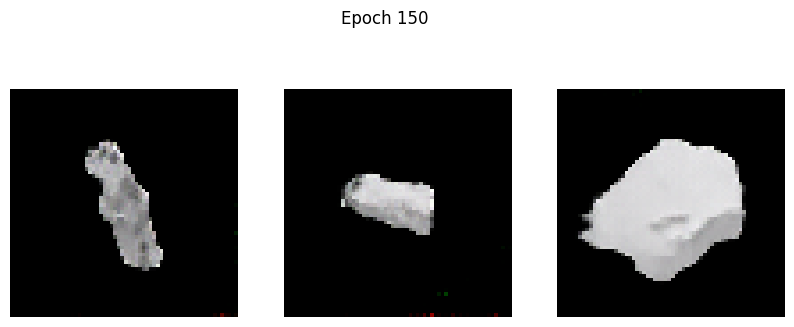

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1841 - g_loss: 2.8499
Epoch 151/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2689 - g_loss: 3.0159

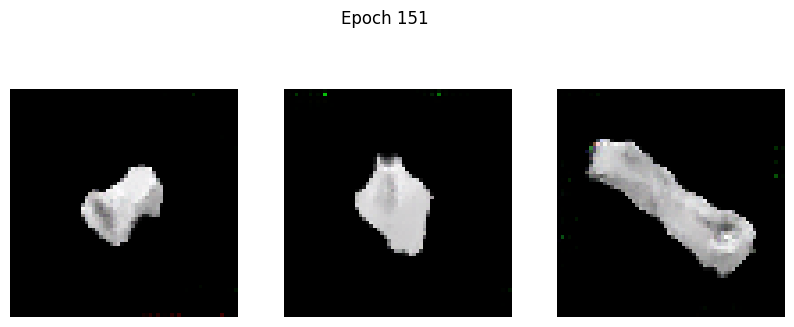

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2687 - g_loss: 3.0153
Epoch 152/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1694 - g_loss: 2.8827

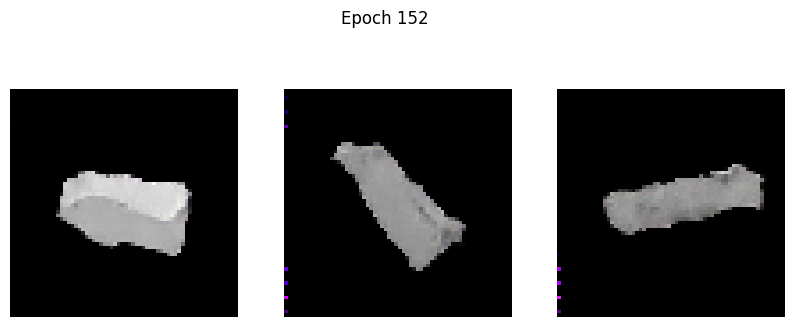

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1708 - g_loss: 2.8860
Epoch 153/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1909 - g_loss: 2.7458

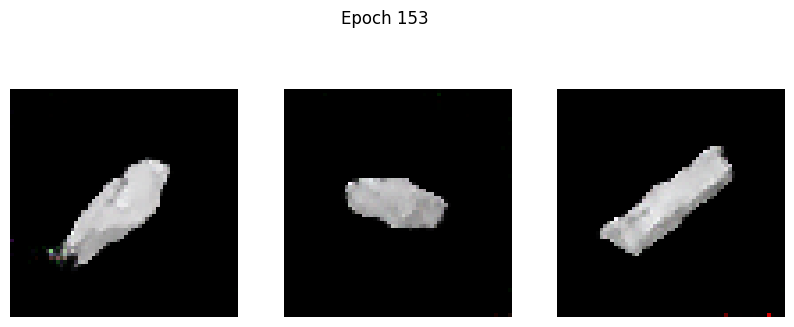

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1907 - g_loss: 2.7457
Epoch 154/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1529 - g_loss: 2.8025

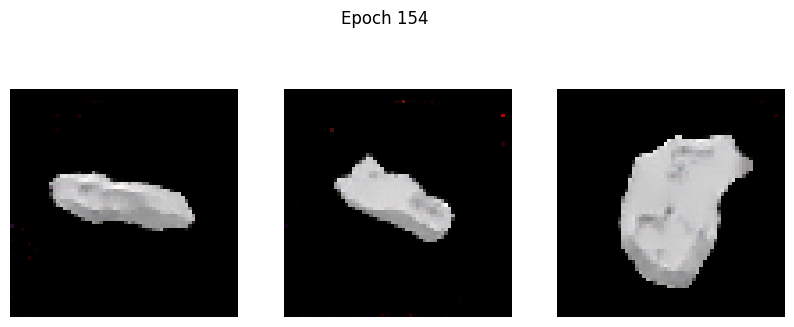

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1530 - g_loss: 2.8028
Epoch 155/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1644 - g_loss: 2.8823

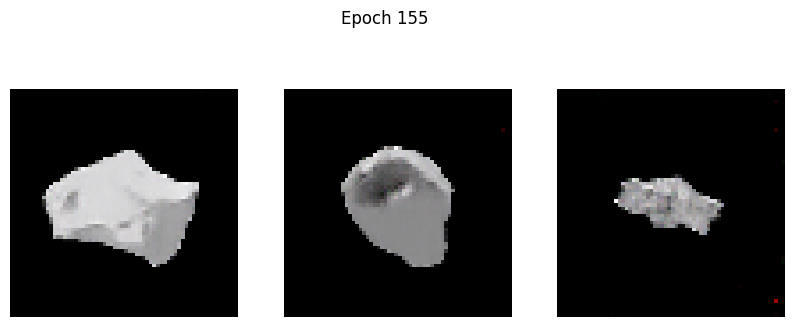

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1644 - g_loss: 2.8820
Epoch 156/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1936 - g_loss: 3.0590

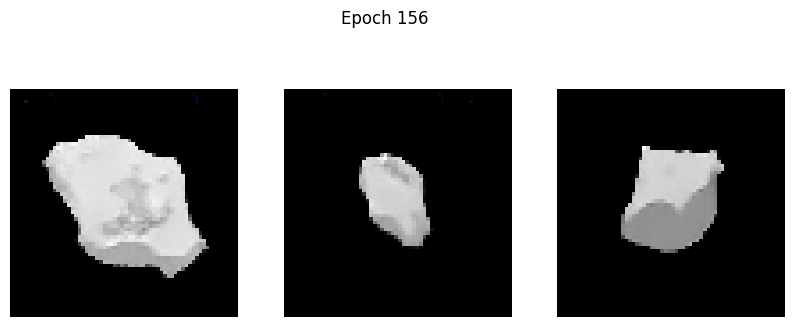

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1933 - g_loss: 3.0581
Epoch 157/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4527 - g_loss: 3.1894

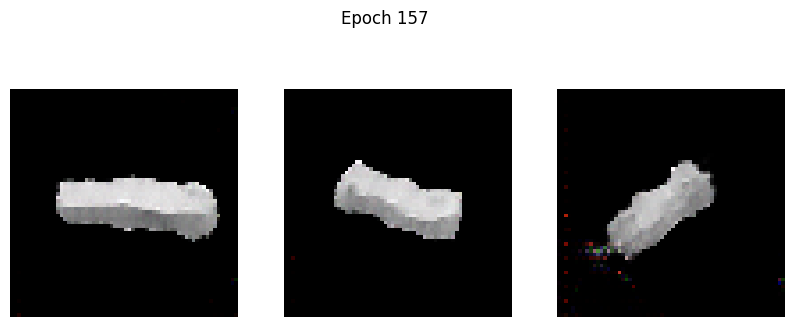

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4527 - g_loss: 3.1884
Epoch 158/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1819 - g_loss: 2.7170

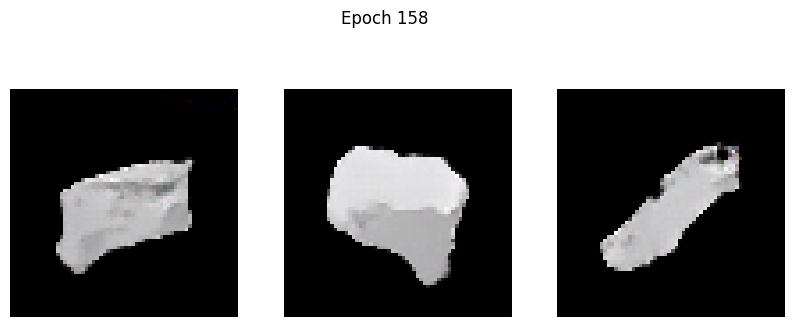

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1819 - g_loss: 2.7174
Epoch 159/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1433 - g_loss: 2.8473

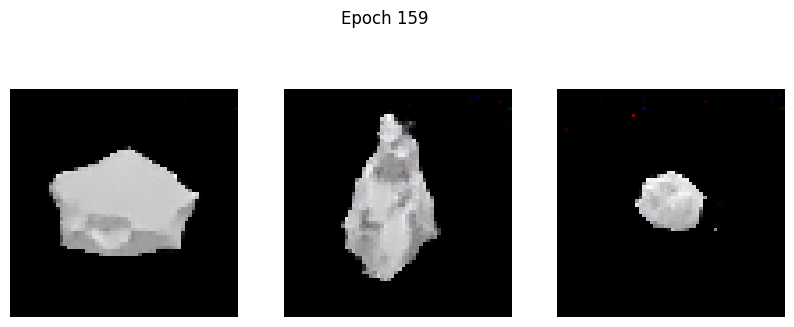

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1433 - g_loss: 2.8471
Epoch 160/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1559 - g_loss: 2.8448

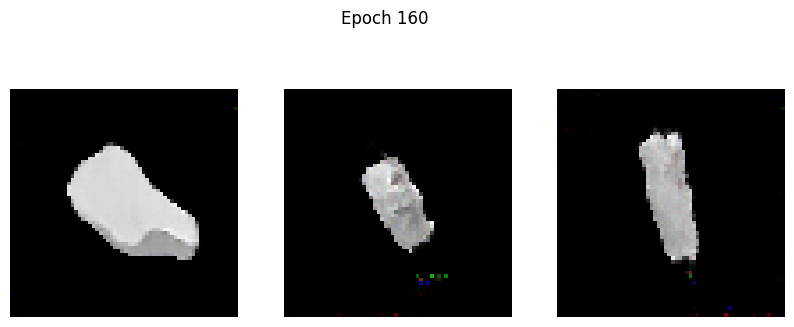

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1560 - g_loss: 2.8449
Epoch 161/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1786 - g_loss: 2.9263

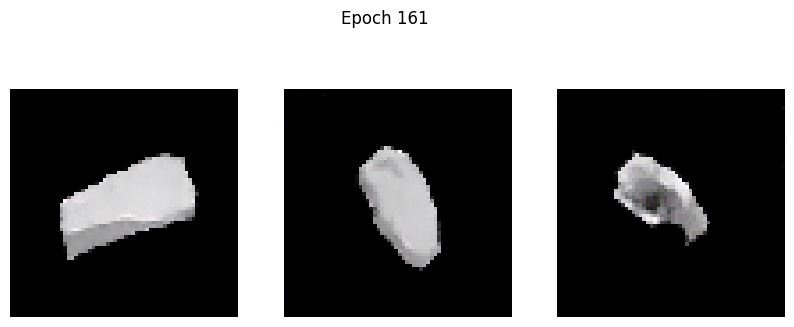

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1785 - g_loss: 2.9259
Epoch 162/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1646 - g_loss: 2.9402

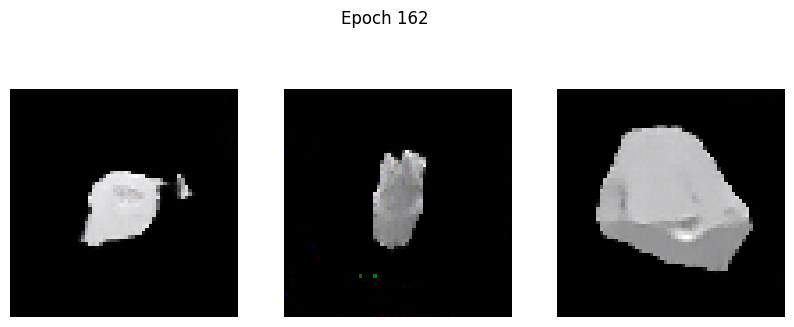

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1647 - g_loss: 2.9403
Epoch 163/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1658 - g_loss: 2.9880

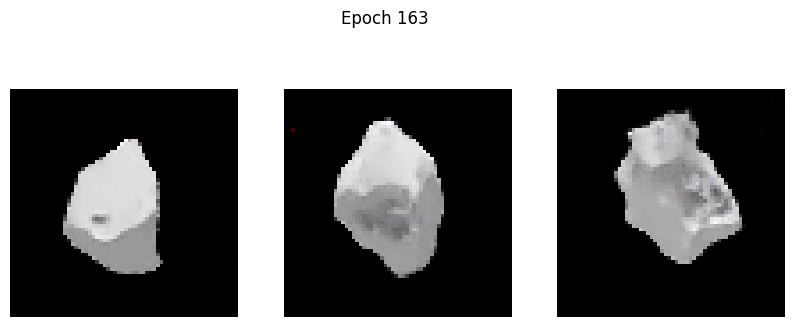

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1659 - g_loss: 2.9881
Epoch 164/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1936 - g_loss: 3.0208

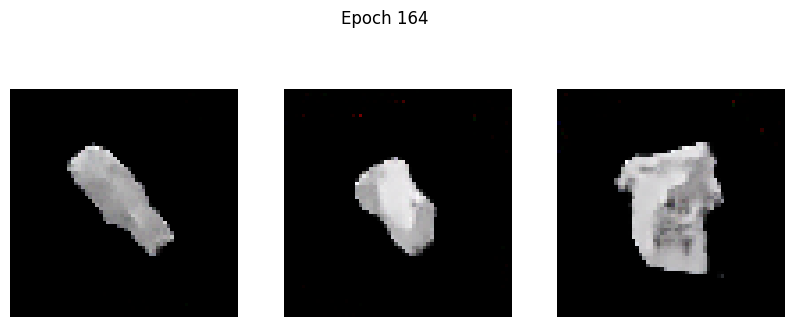

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1939 - g_loss: 3.0212
Epoch 165/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1687 - g_loss: 3.0868

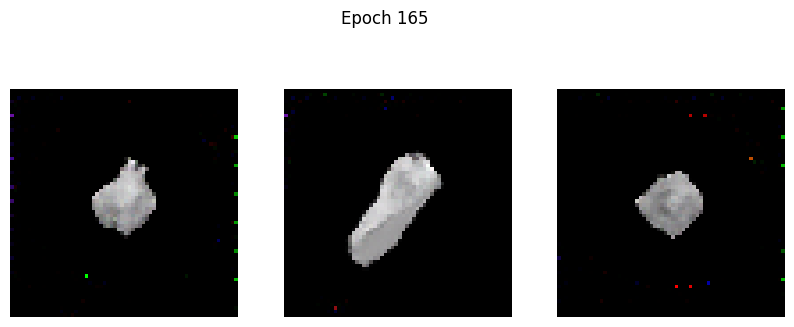

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1687 - g_loss: 3.0861
Epoch 166/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1605 - g_loss: 3.0007

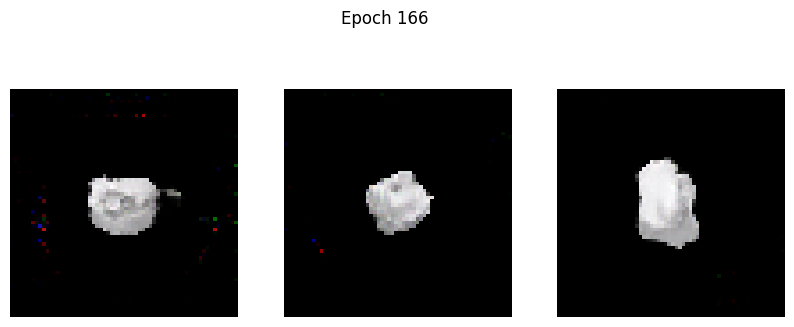

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1605 - g_loss: 3.0008
Epoch 167/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1764 - g_loss: 3.0903

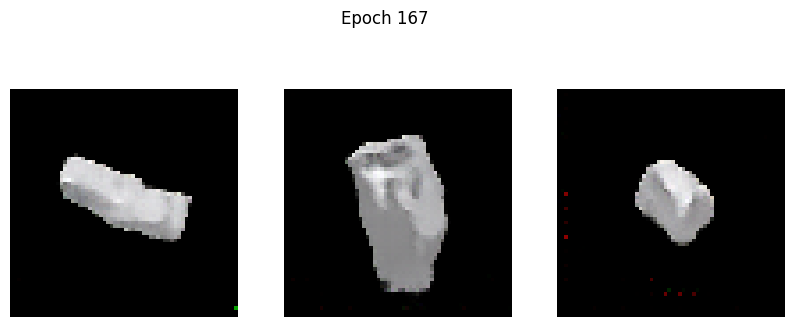

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1770 - g_loss: 3.0915
Epoch 168/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1563 - g_loss: 2.9513

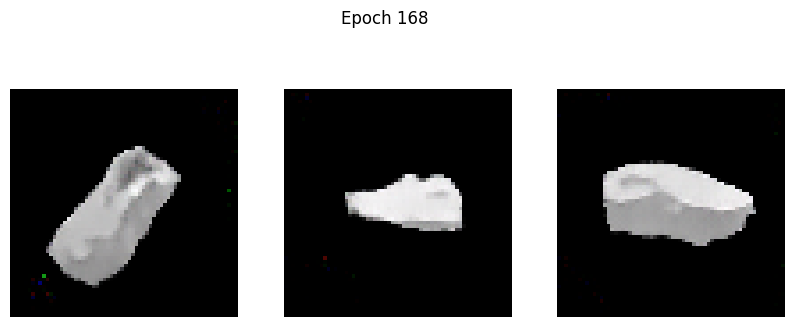

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1563 - g_loss: 2.9514
Epoch 169/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1425 - g_loss: 2.9815

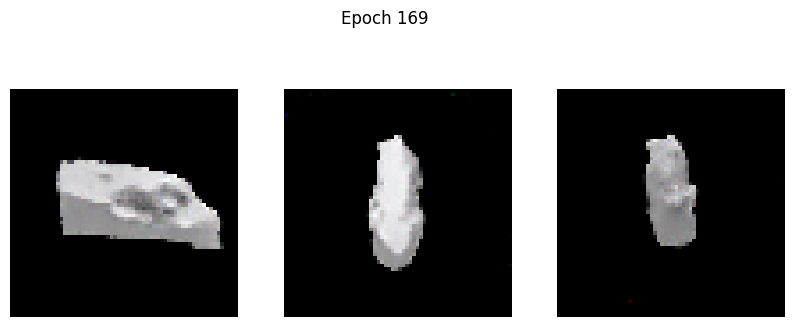

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1426 - g_loss: 2.9818
Epoch 170/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1603 - g_loss: 3.0901

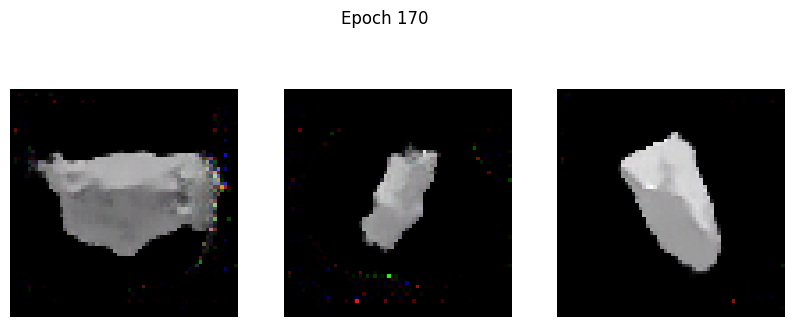

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1610 - g_loss: 3.0906
Epoch 171/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1710 - g_loss: 3.0466

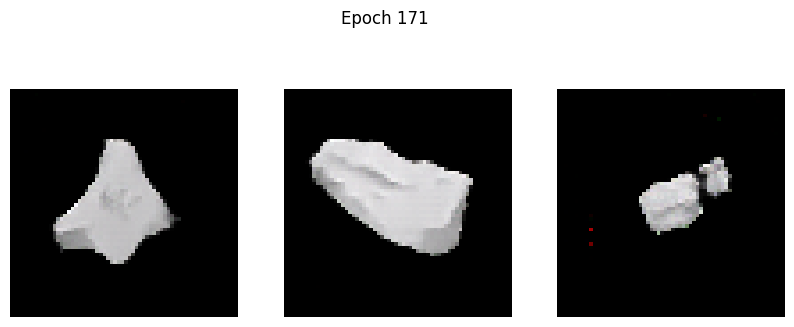

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1711 - g_loss: 3.0464
Epoch 172/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1349 - g_loss: 3.0244

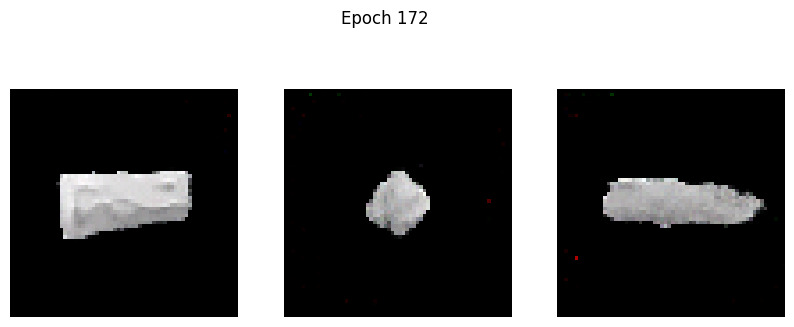

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1350 - g_loss: 3.0245
Epoch 173/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1403 - g_loss: 3.0113

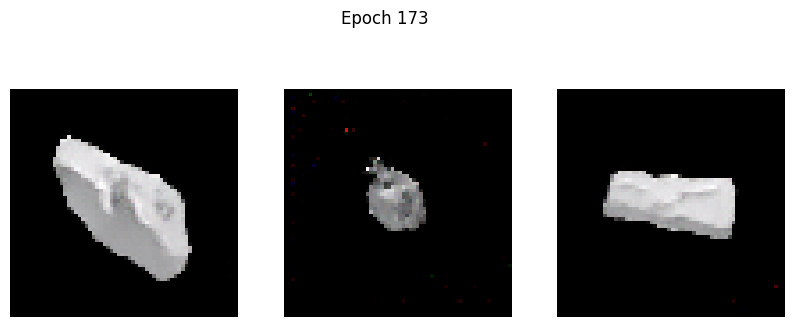

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1403 - g_loss: 3.0117
Epoch 174/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3589 - g_loss: 3.3692

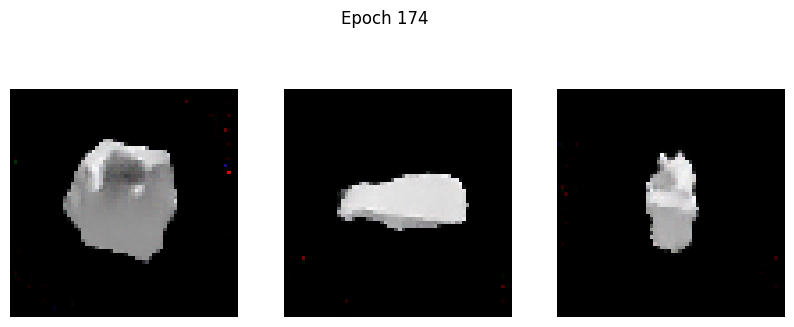

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3590 - g_loss: 3.3685
Epoch 175/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1611 - g_loss: 2.9613

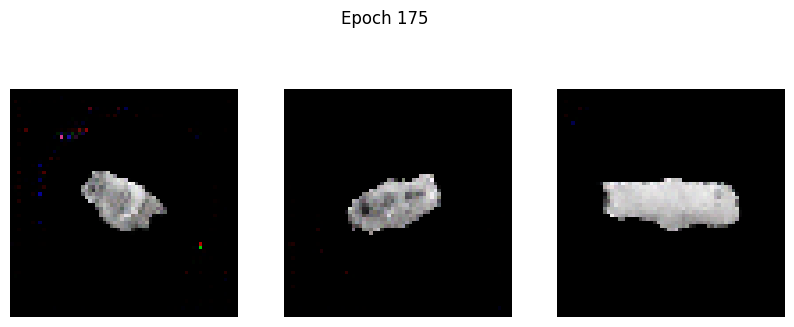

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1610 - g_loss: 2.9615
Epoch 176/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1192 - g_loss: 3.0192

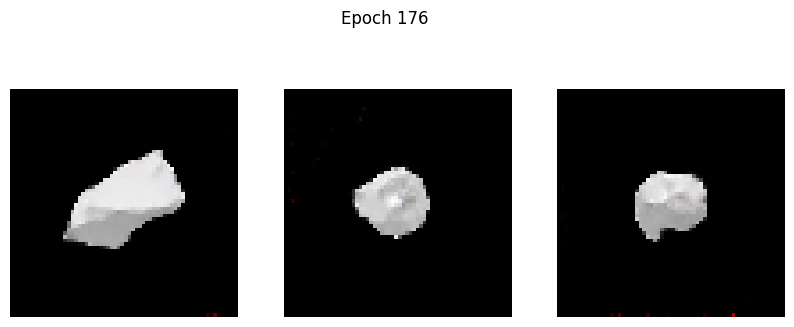

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1192 - g_loss: 3.0194
Epoch 177/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2168 - g_loss: 3.1575

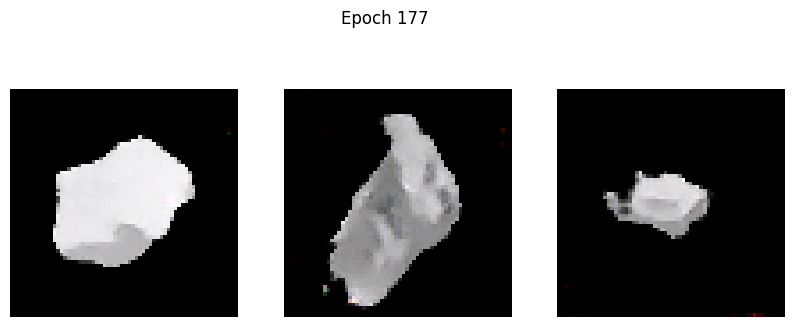

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2164 - g_loss: 3.1569
Epoch 178/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1466 - g_loss: 3.0055

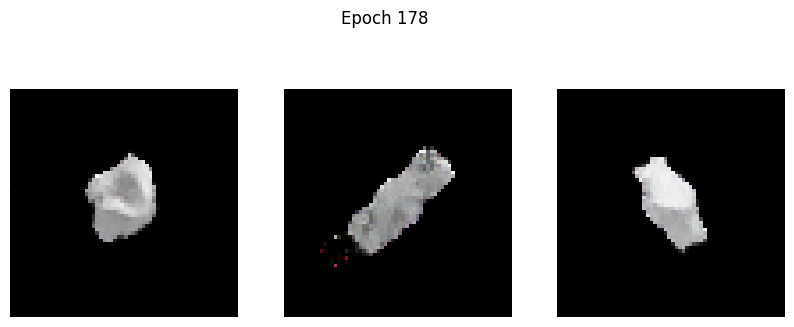

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1467 - g_loss: 3.0060
Epoch 179/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1328 - g_loss: 3.1687

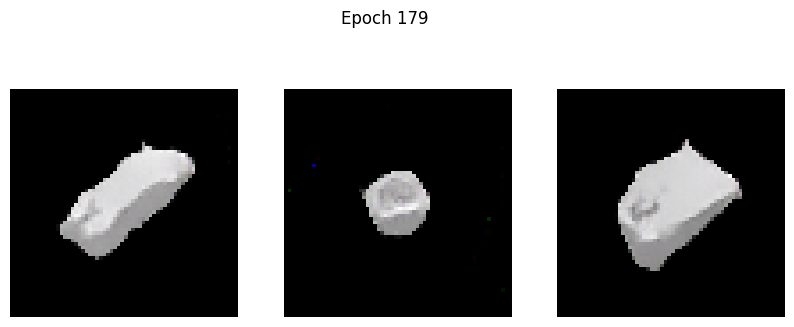

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1328 - g_loss: 3.1685
Epoch 180/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3250 - g_loss: 3.3444

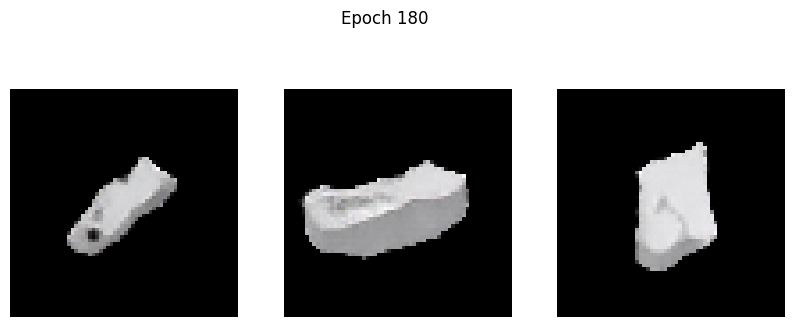

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3241 - g_loss: 3.3428
Epoch 181/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1574 - g_loss: 3.1897

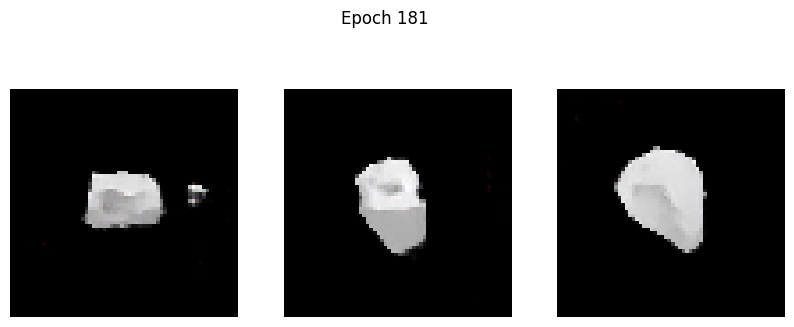

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1575 - g_loss: 3.1898
Epoch 182/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1598 - g_loss: 3.2600

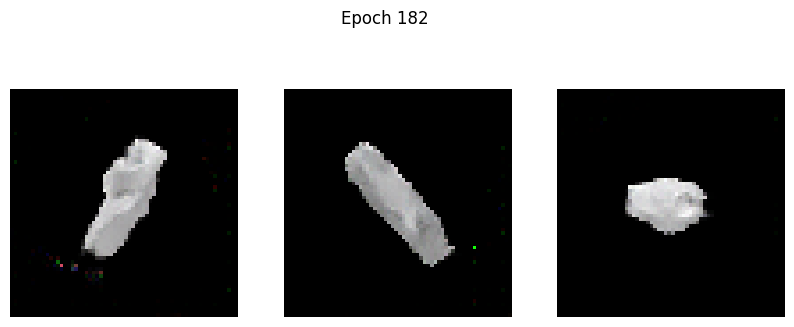

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1601 - g_loss: 3.2598
Epoch 183/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1800 - g_loss: 3.1481

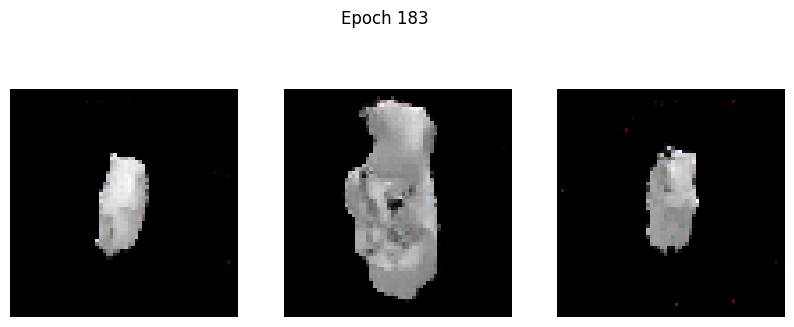

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1796 - g_loss: 3.1482
Epoch 184/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1486 - g_loss: 3.2753

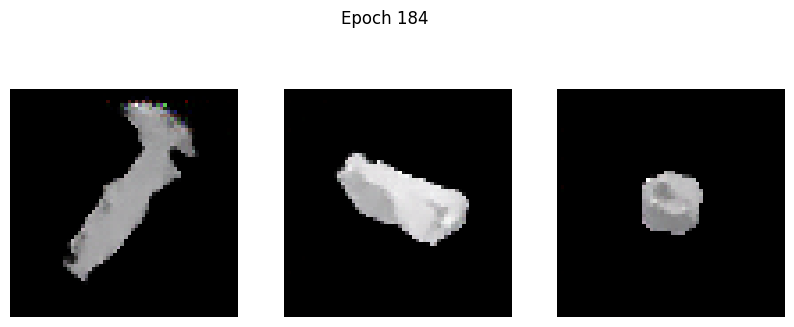

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1486 - g_loss: 3.2752
Epoch 185/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6287 - g_loss: 3.7272

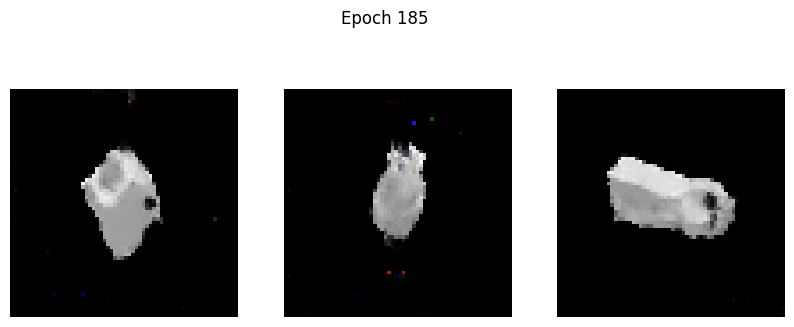

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6263 - g_loss: 3.7233
Epoch 186/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1308 - g_loss: 3.0697

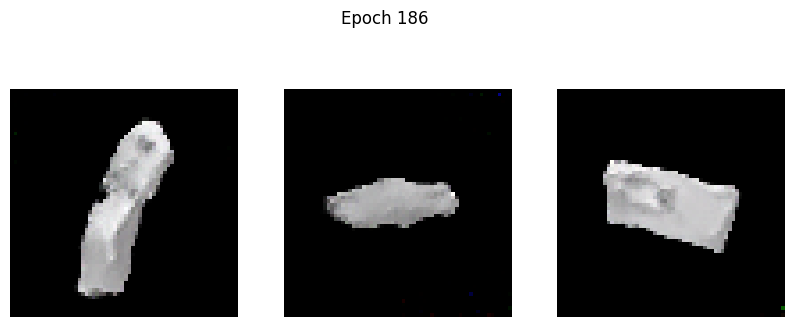

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1308 - g_loss: 3.0695
Epoch 187/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1525 - g_loss: 3.1252

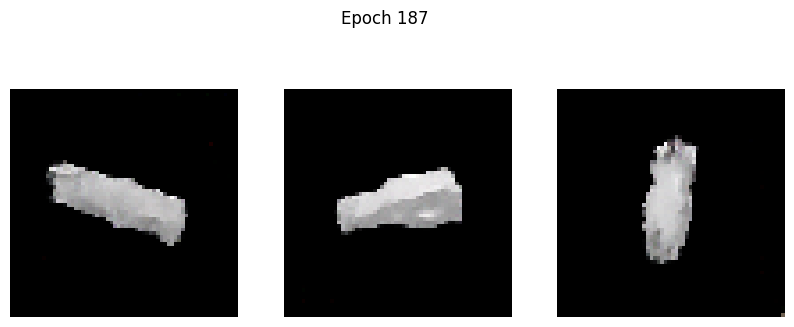

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1523 - g_loss: 3.1253
Epoch 188/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1374 - g_loss: 3.1682

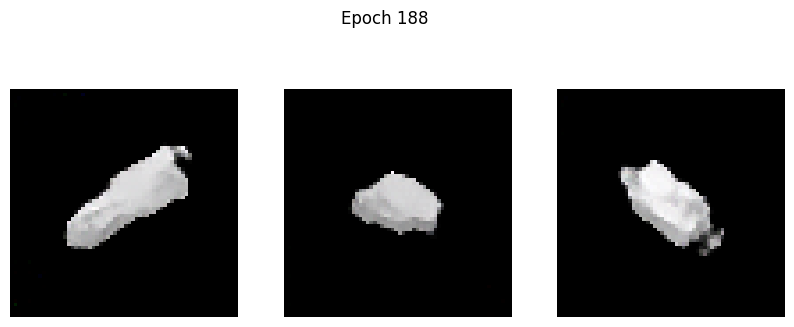

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1373 - g_loss: 3.1685
Epoch 189/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1149 - g_loss: 3.1858

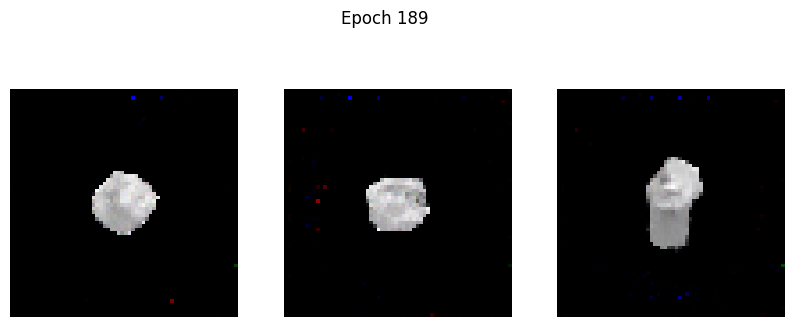

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1150 - g_loss: 3.1860
Epoch 190/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1279 - g_loss: 3.2725

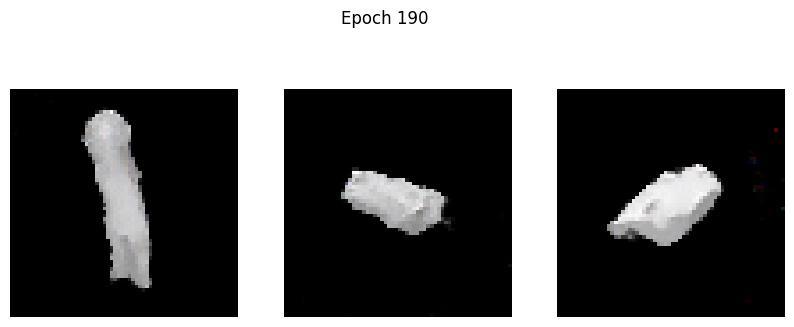

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1279 - g_loss: 3.2721
Epoch 191/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6722 - g_loss: 4.4168

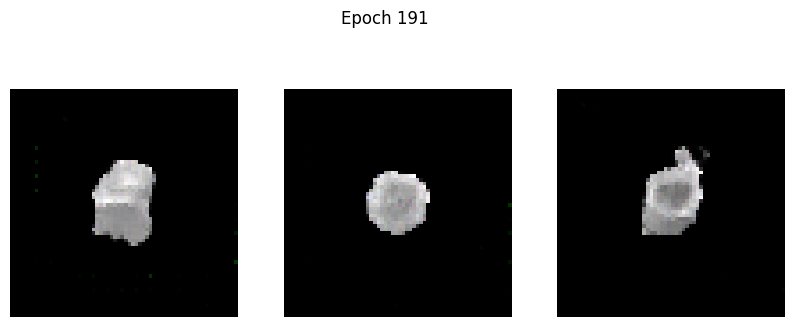

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6699 - g_loss: 4.4114
Epoch 192/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1504 - g_loss: 3.1258

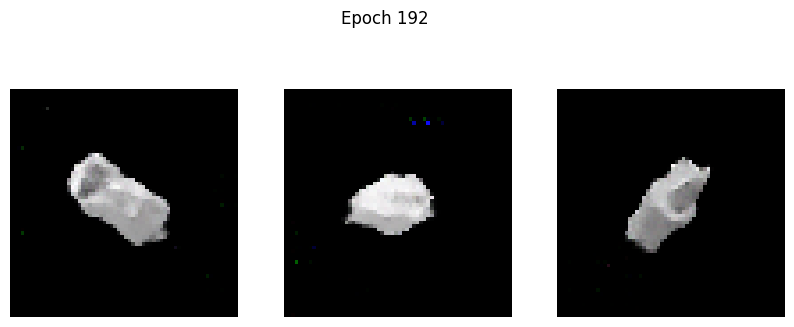

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1505 - g_loss: 3.1256
Epoch 193/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1350 - g_loss: 3.1556

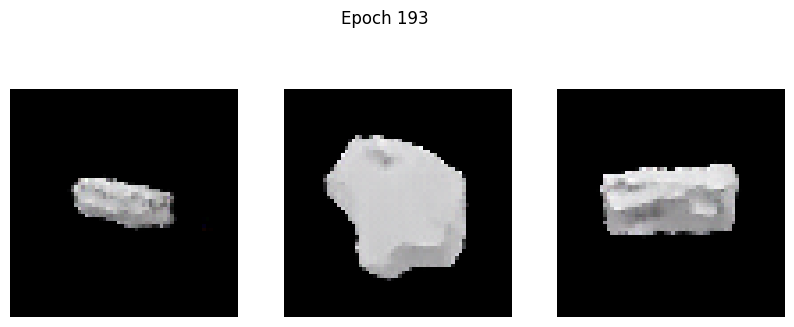

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1352 - g_loss: 3.1564
Epoch 194/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1343 - g_loss: 3.1805

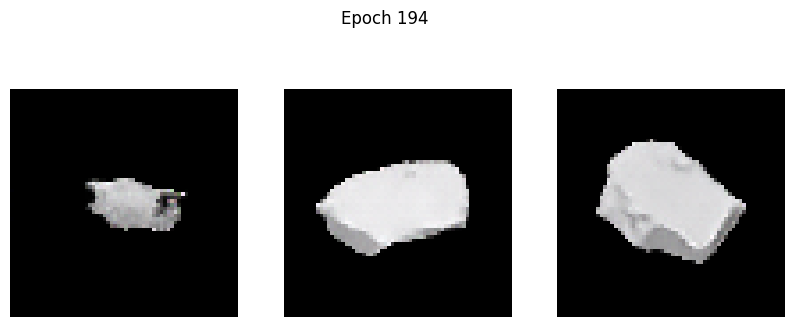

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1342 - g_loss: 3.1801
Epoch 195/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1306 - g_loss: 3.2085

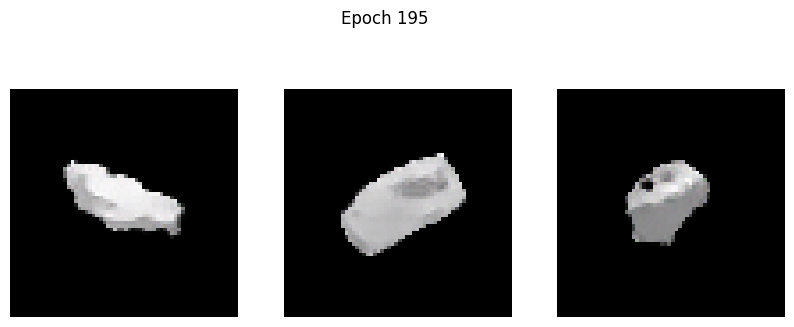

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1305 - g_loss: 3.2086
Epoch 196/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1435 - g_loss: 3.2593

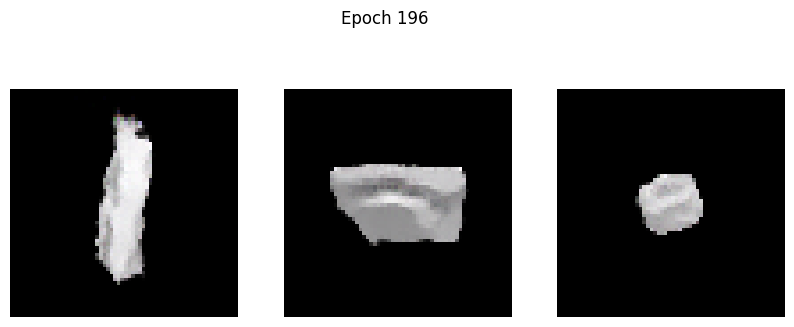

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1437 - g_loss: 3.2599
Epoch 197/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1612 - g_loss: 3.3197

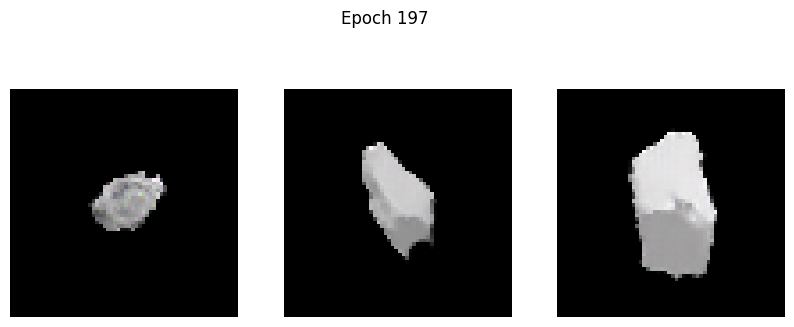

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1610 - g_loss: 3.3197
Epoch 198/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2803 - g_loss: 3.4943

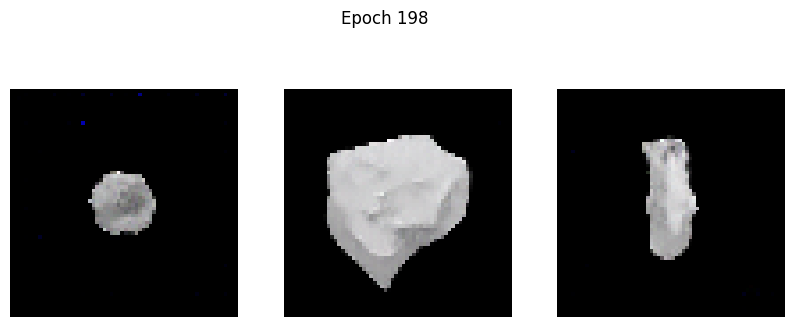

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2808 - g_loss: 3.4942
Epoch 199/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1280 - g_loss: 3.1270

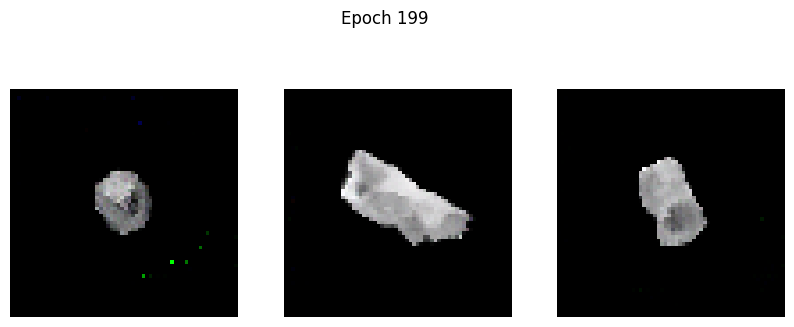

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1280 - g_loss: 3.1272
Epoch 200/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1066 - g_loss: 3.2256

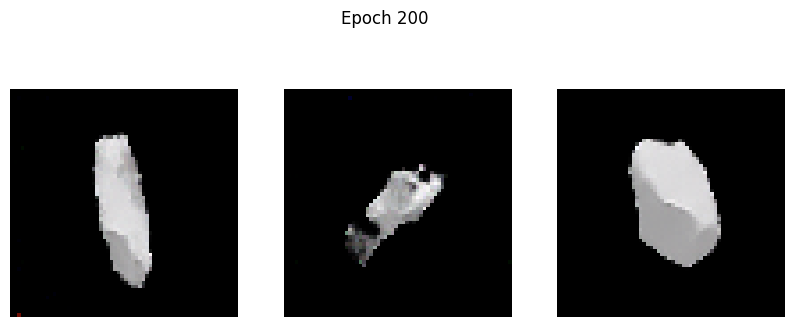

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1067 - g_loss: 3.2255
Epoch 201/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1657 - g_loss: 3.3790

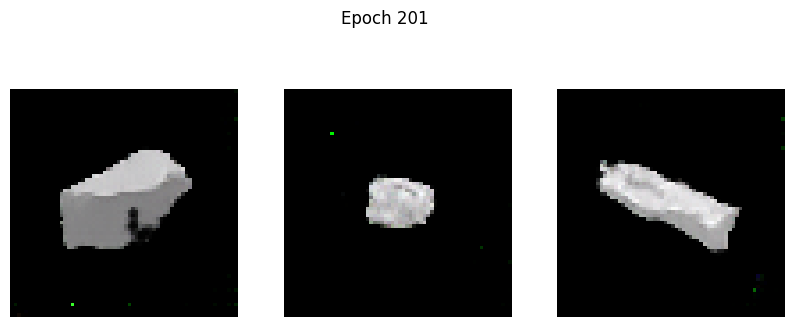

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1655 - g_loss: 3.3779
Epoch 202/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1759 - g_loss: 3.4073

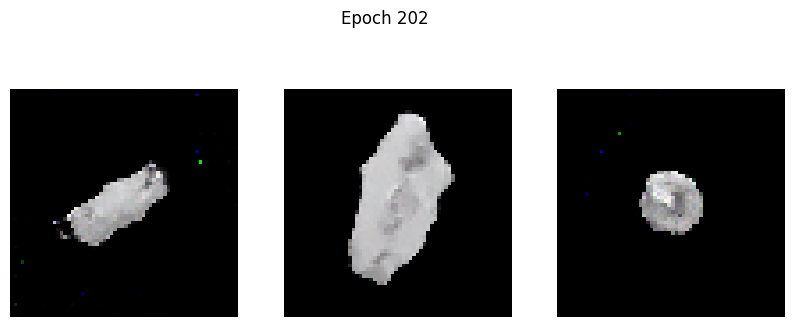

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1762 - g_loss: 3.4072
Epoch 203/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1274 - g_loss: 3.2821

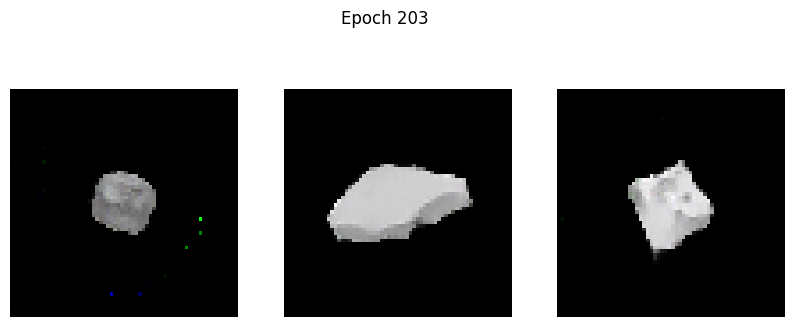

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1274 - g_loss: 3.2822
Epoch 204/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1298 - g_loss: 3.3772

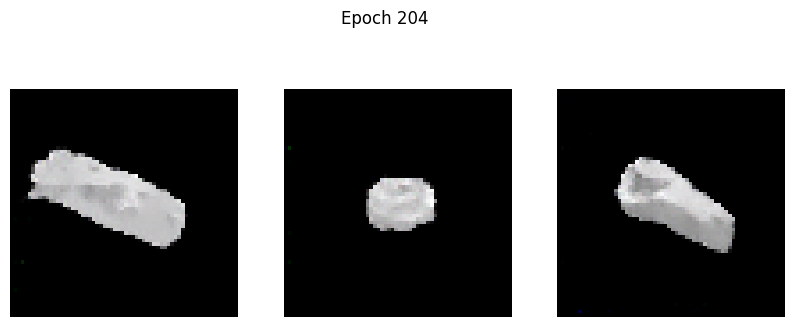

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1297 - g_loss: 3.3766
Epoch 205/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1116 - g_loss: 3.3719

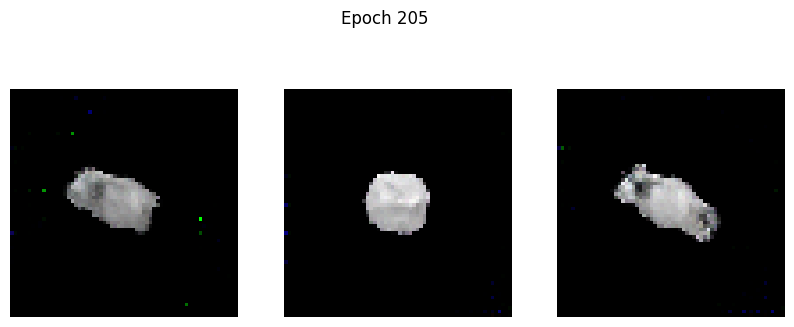

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1117 - g_loss: 3.3719
Epoch 206/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2405 - g_loss: 3.5069

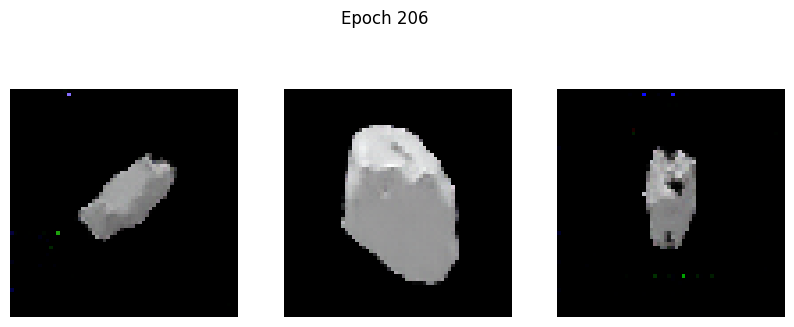

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2403 - g_loss: 3.5062
Epoch 207/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1637 - g_loss: 3.4928

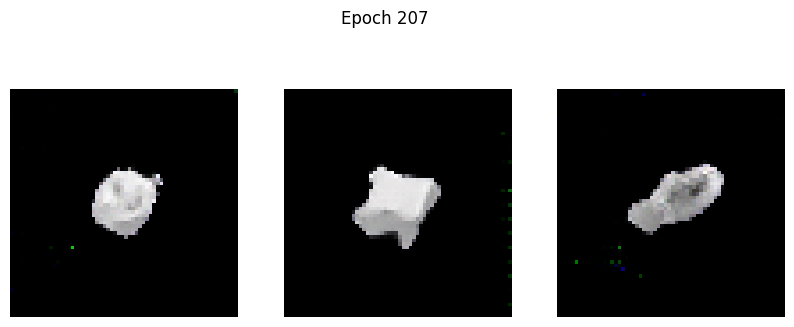

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1638 - g_loss: 3.4927
Epoch 208/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1247 - g_loss: 3.2594

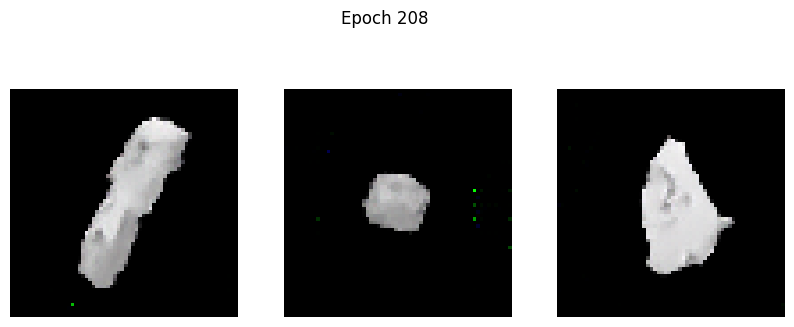

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1246 - g_loss: 3.2594
Epoch 209/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1360 - g_loss: 3.5189

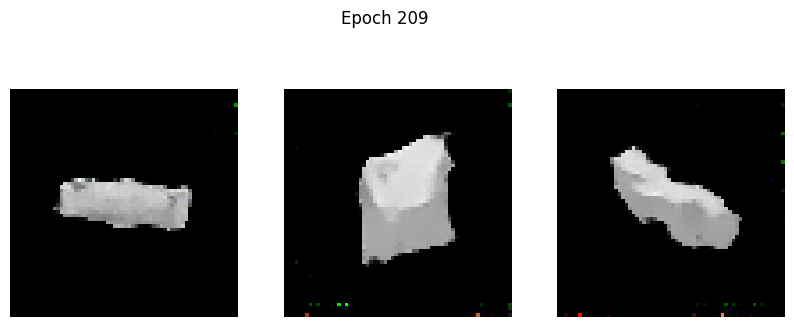

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1362 - g_loss: 3.5183
Epoch 210/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1267 - g_loss: 3.3286

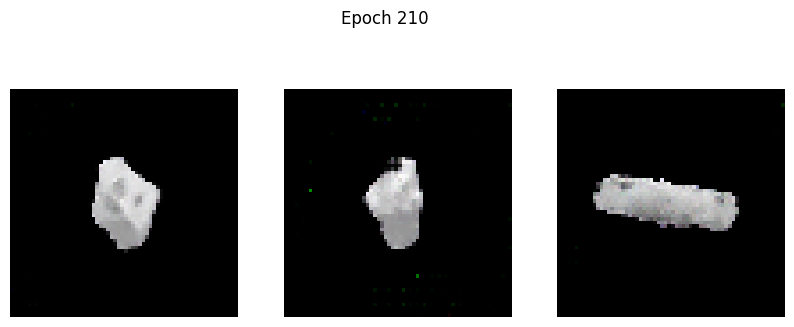

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1268 - g_loss: 3.3287
Epoch 211/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1163 - g_loss: 3.3869

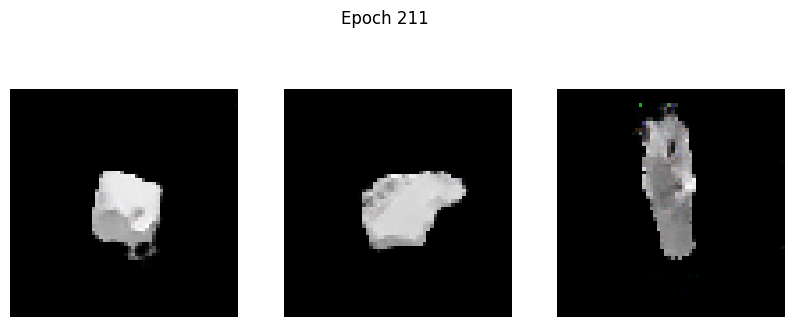

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1161 - g_loss: 3.3867
Epoch 212/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1295 - g_loss: 3.4113

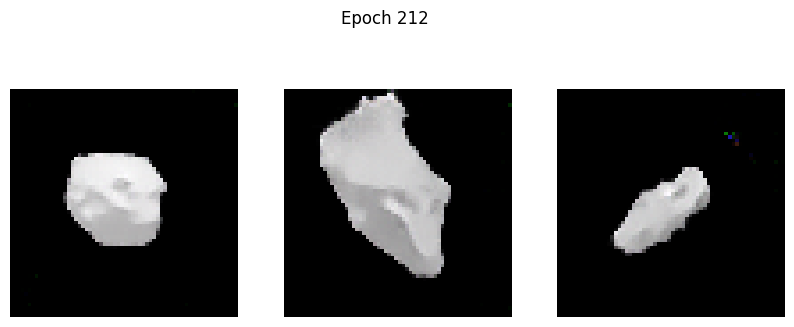

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1297 - g_loss: 3.4117
Epoch 213/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1530 - g_loss: 3.5760

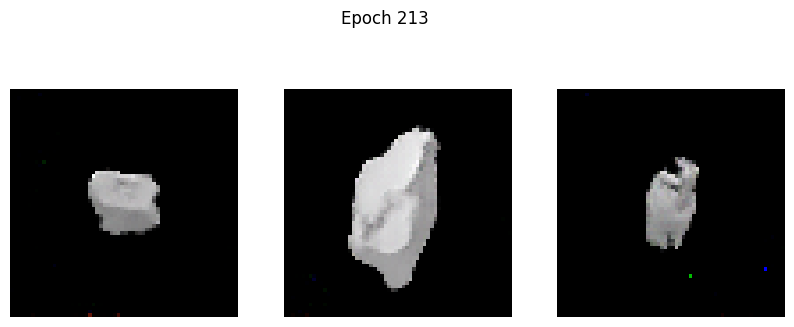

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1528 - g_loss: 3.5746
Epoch 214/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2304 - g_loss: 3.6298

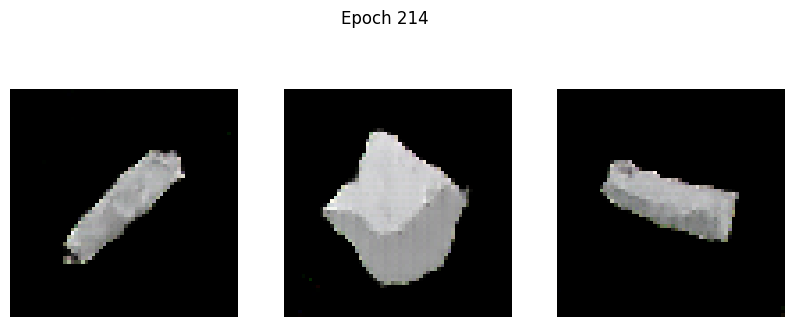

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2342 - g_loss: 3.6324
Epoch 215/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2296 - g_loss: 2.7212

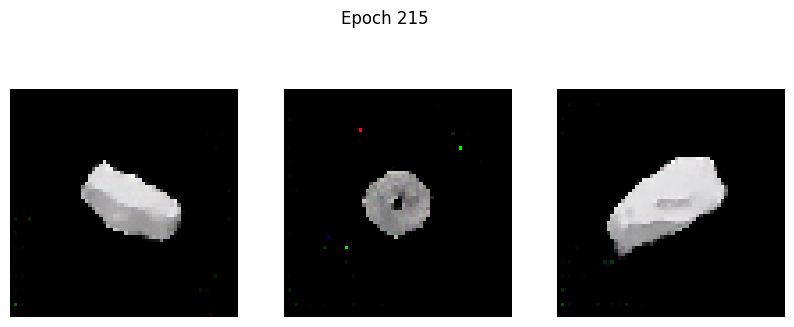

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2292 - g_loss: 2.7223
Epoch 216/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1293 - g_loss: 3.1400

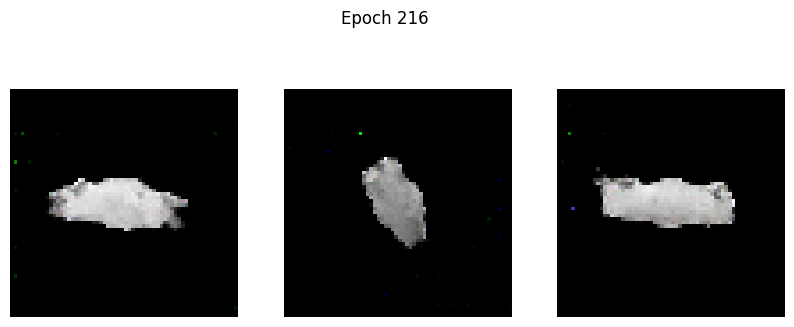

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1293 - g_loss: 3.1400
Epoch 217/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1072 - g_loss: 3.3120

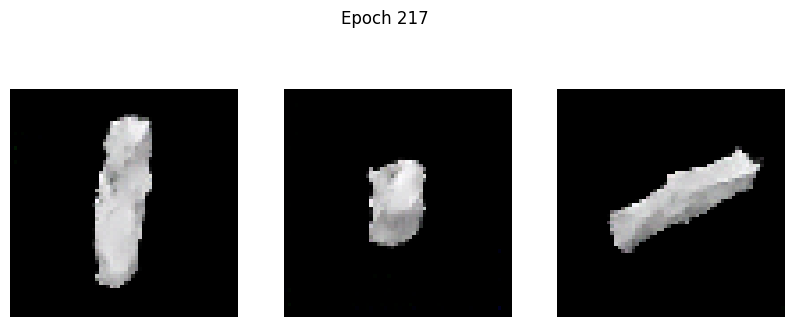

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1072 - g_loss: 3.3116
Epoch 218/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1033 - g_loss: 3.3139

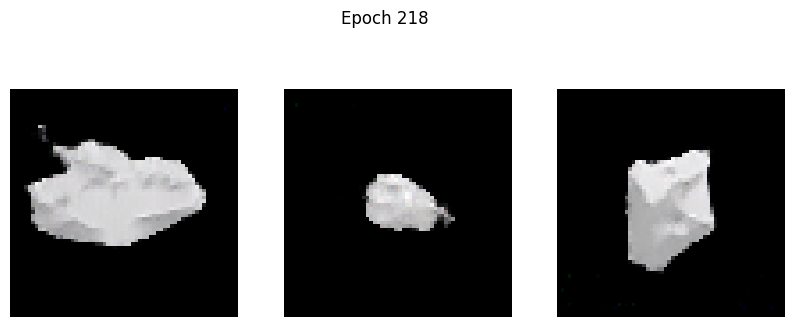

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1033 - g_loss: 3.3137
Epoch 219/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1136 - g_loss: 3.3789

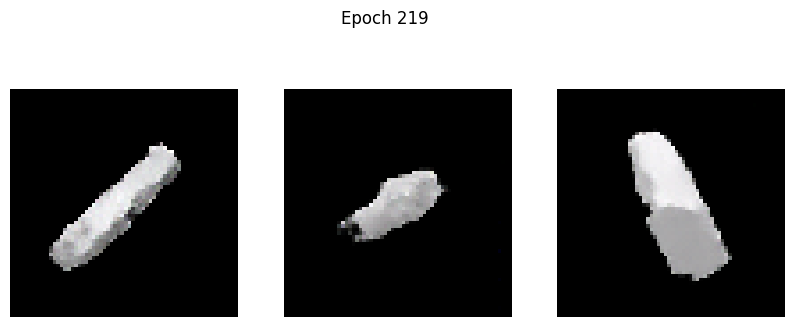

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1135 - g_loss: 3.3785
Epoch 220/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1048 - g_loss: 3.4094

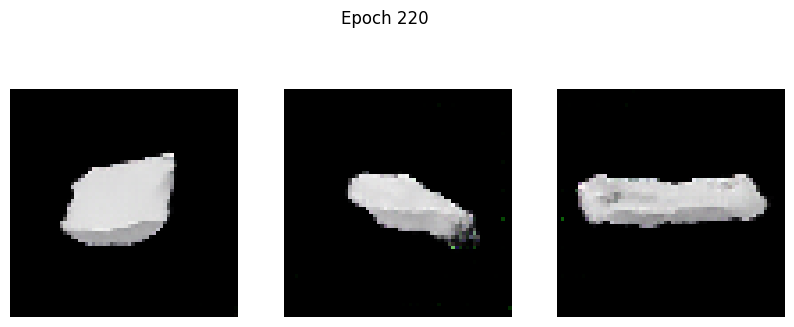

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1057 - g_loss: 3.4103
Epoch 221/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1340 - g_loss: 3.4139

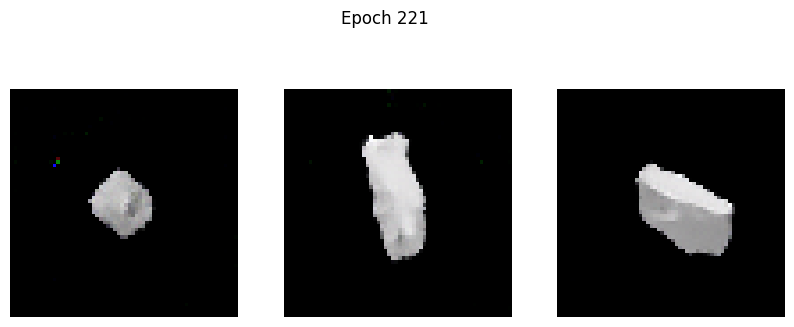

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1338 - g_loss: 3.4134
Epoch 222/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0919 - g_loss: 3.3791

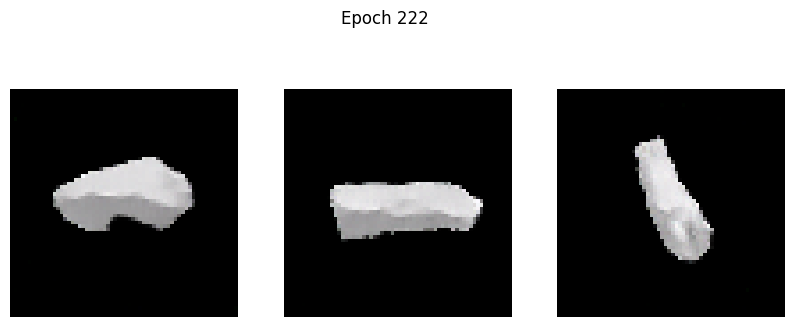

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0920 - g_loss: 3.3791
Epoch 223/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1174 - g_loss: 3.5832

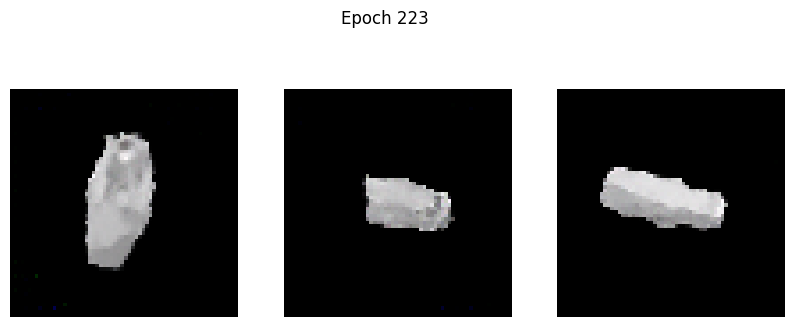

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1173 - g_loss: 3.5828
Epoch 224/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1657 - g_loss: 3.6767

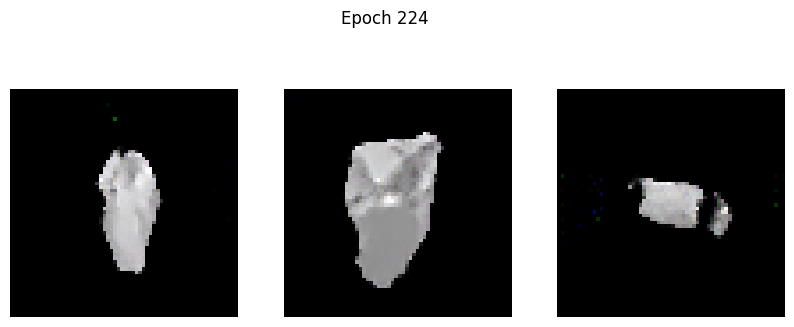

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1659 - g_loss: 3.6762
Epoch 225/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1120 - g_loss: 3.4076

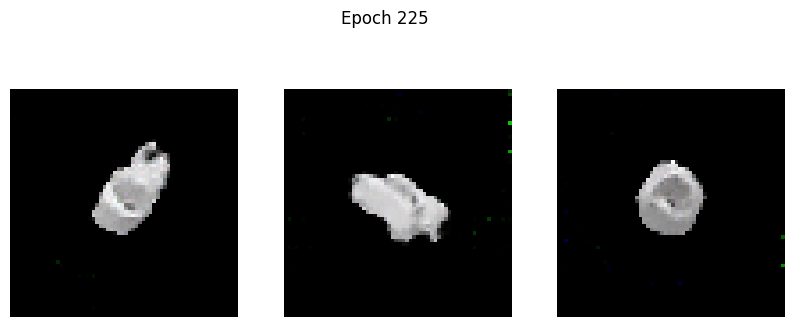

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1120 - g_loss: 3.4079
Epoch 226/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1445 - g_loss: 3.6018

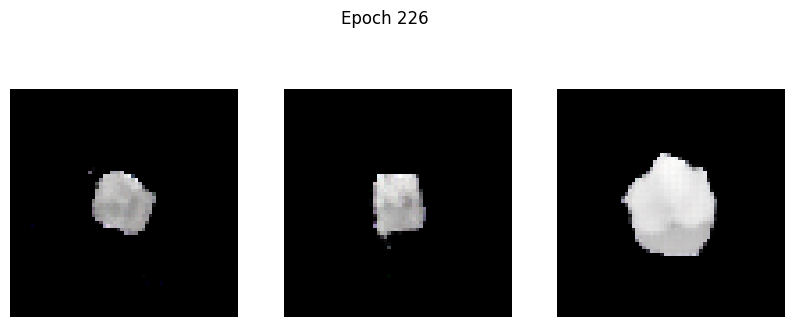

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1462 - g_loss: 3.6049
Epoch 227/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1435 - g_loss: 3.3839

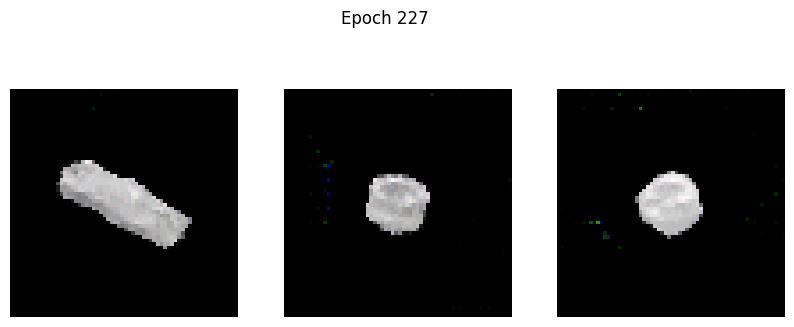

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1433 - g_loss: 3.3836
Epoch 228/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0840 - g_loss: 3.3577

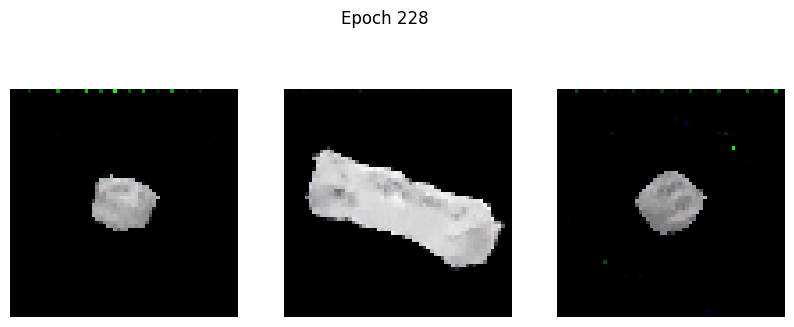

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0841 - g_loss: 3.3578
Epoch 229/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1190 - g_loss: 3.4259

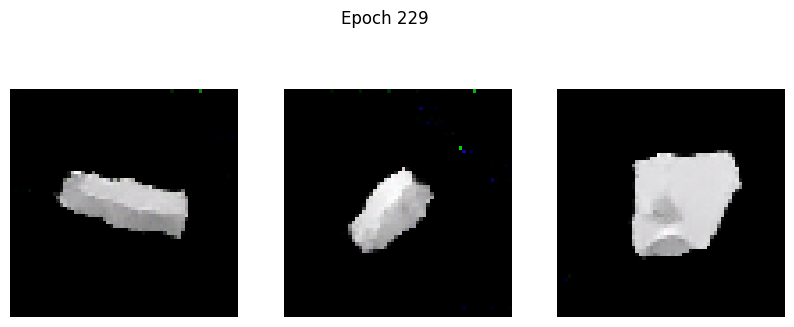

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1188 - g_loss: 3.4258
Epoch 230/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0934 - g_loss: 3.4728

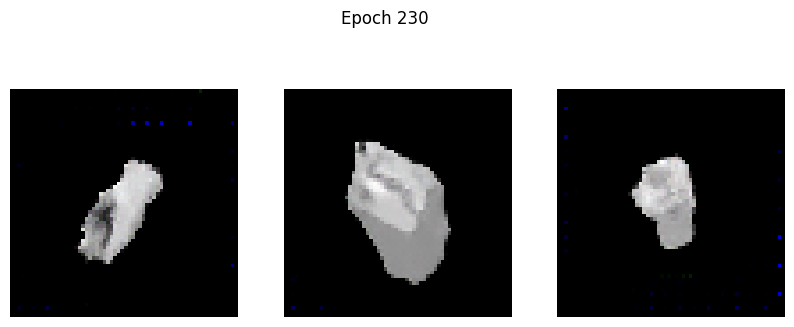

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0935 - g_loss: 3.4731
Epoch 231/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0947 - g_loss: 3.5998

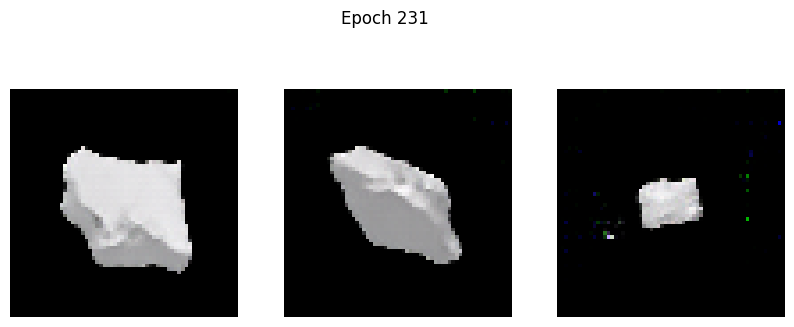

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0948 - g_loss: 3.5999
Epoch 232/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1232 - g_loss: 3.6239

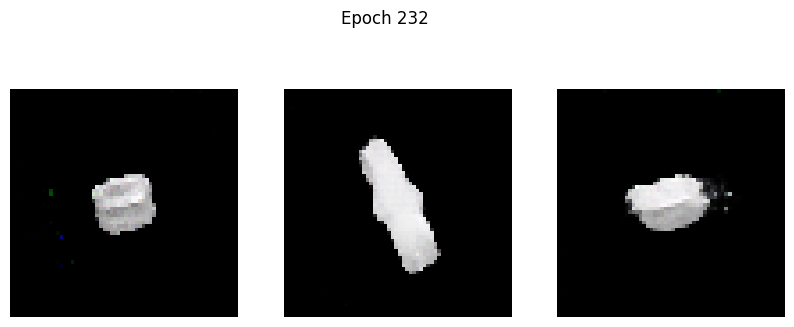

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1232 - g_loss: 3.6232
Epoch 233/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0928 - g_loss: 3.6781

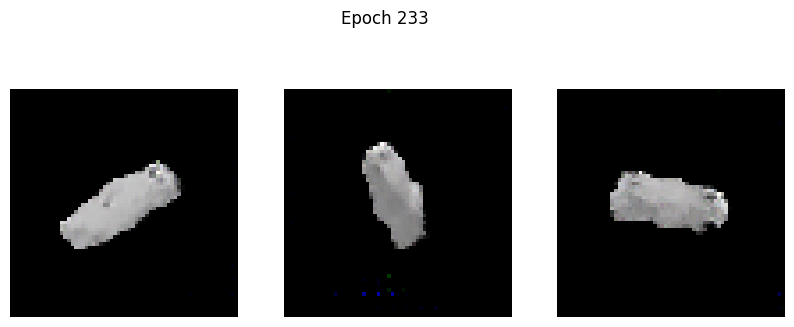

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0930 - g_loss: 3.6779
Epoch 234/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0963 - g_loss: 3.5767

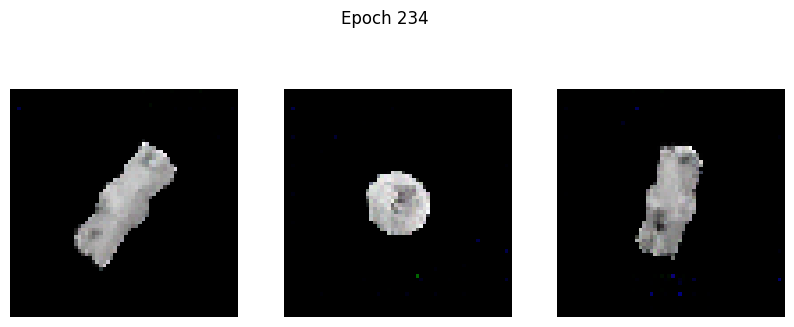

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0963 - g_loss: 3.5771
Epoch 235/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1180 - g_loss: 3.6639

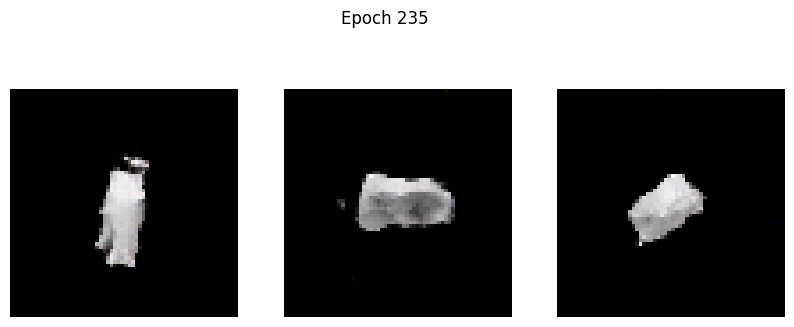

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1189 - g_loss: 3.6653
Epoch 236/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1215 - g_loss: 3.4888

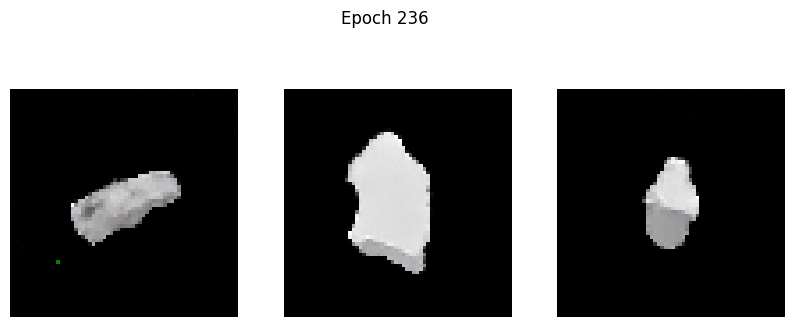

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1213 - g_loss: 3.4889
Epoch 237/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1694 - g_loss: 3.7870

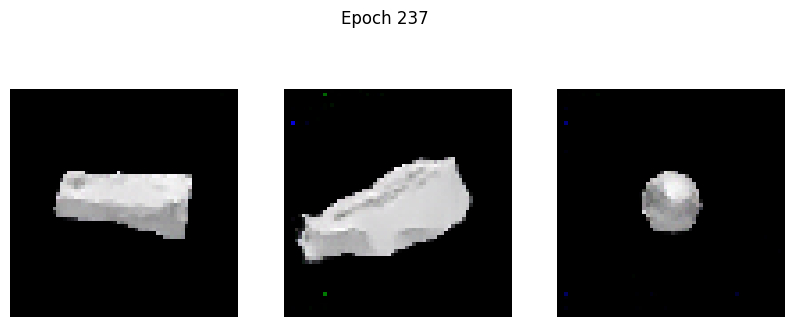

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1698 - g_loss: 3.7868
Epoch 238/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0892 - g_loss: 3.4239

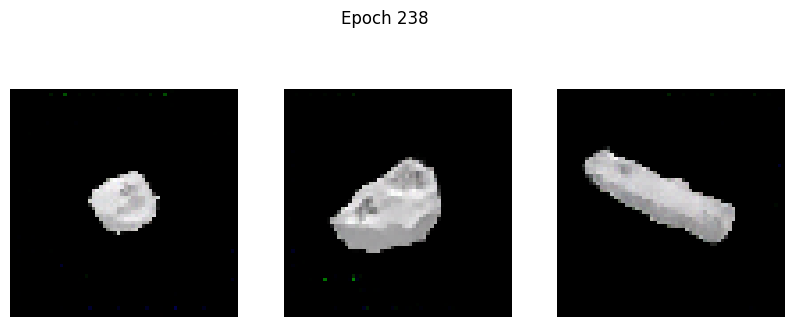

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0892 - g_loss: 3.4240
Epoch 239/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0951 - g_loss: 3.6072

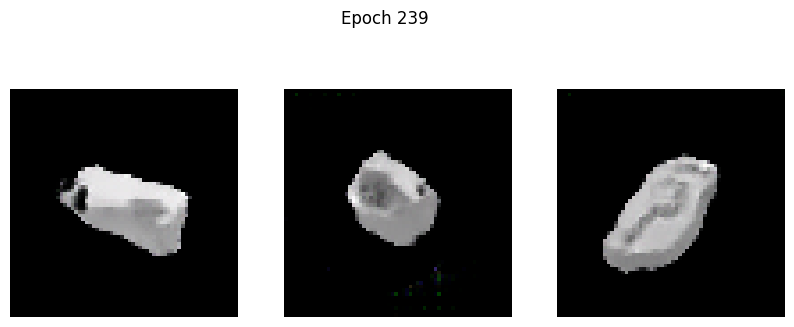

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0951 - g_loss: 3.6074
Epoch 240/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1437 - g_loss: 3.6700

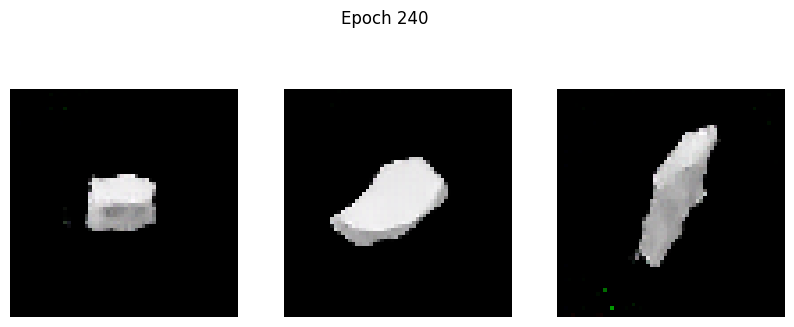

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1443 - g_loss: 3.6706
Epoch 241/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0901 - g_loss: 3.5014

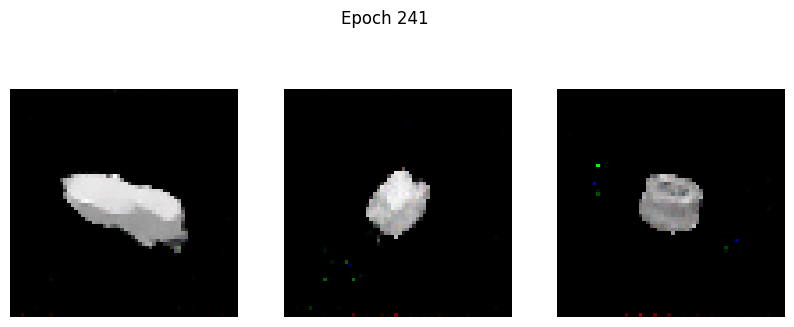

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0900 - g_loss: 3.5017
Epoch 242/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1270 - g_loss: 3.6086

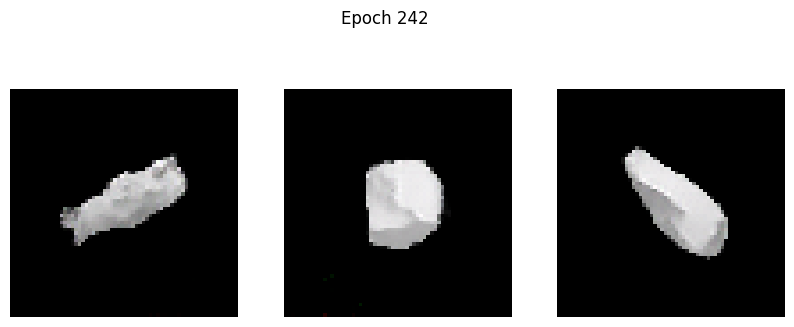

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1267 - g_loss: 3.6082
Epoch 243/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0842 - g_loss: 3.5632

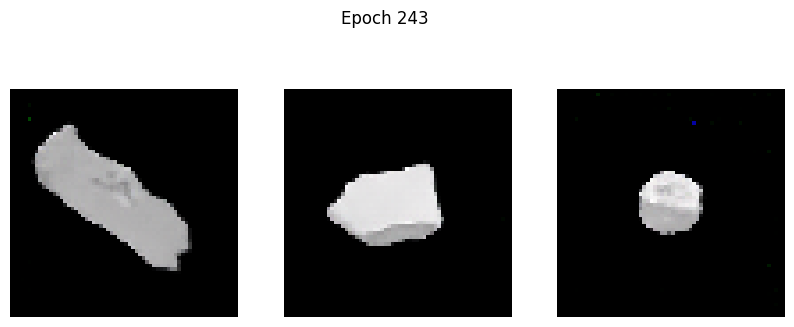

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0842 - g_loss: 3.5639
Epoch 244/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1211 - g_loss: 3.7523

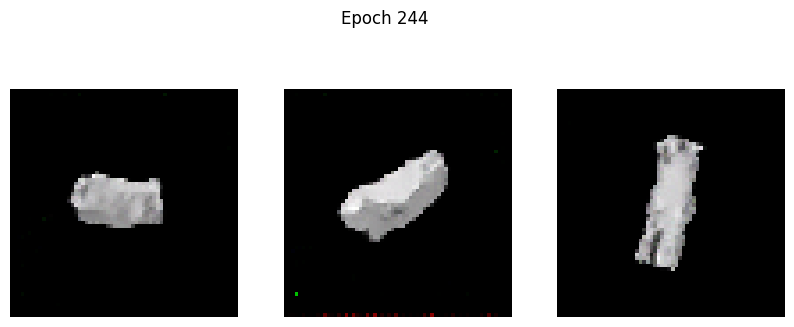

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1213 - g_loss: 3.7527
Epoch 245/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1134 - g_loss: 3.7371

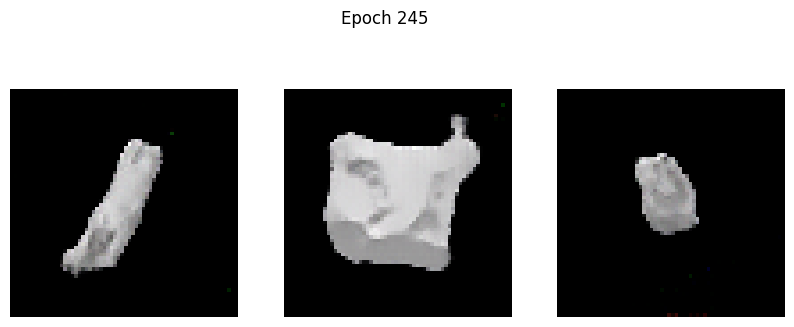

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1134 - g_loss: 3.7368
Epoch 246/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1053 - g_loss: 3.8043

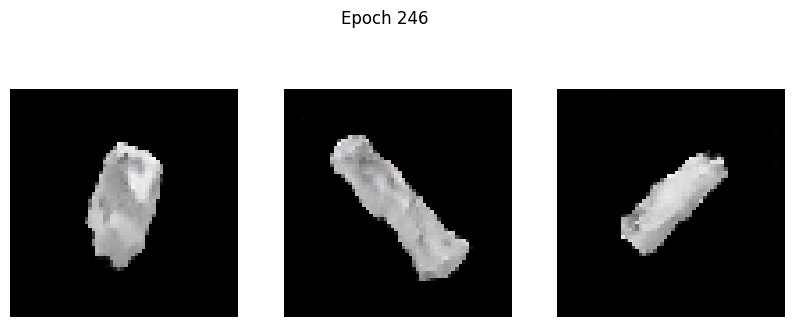

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1054 - g_loss: 3.8039
Epoch 247/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0888 - g_loss: 3.7097

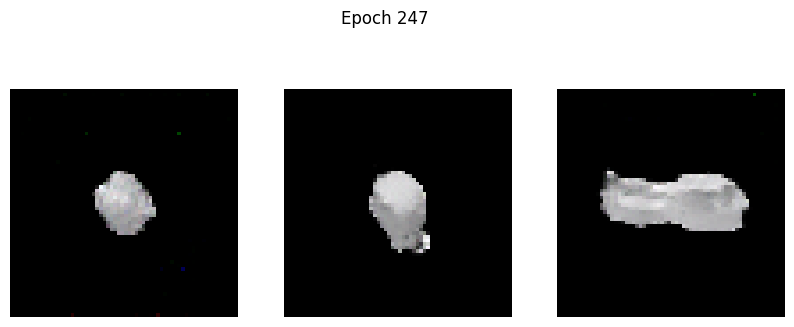

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0890 - g_loss: 3.7103
Epoch 248/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1466 - g_loss: 3.8190

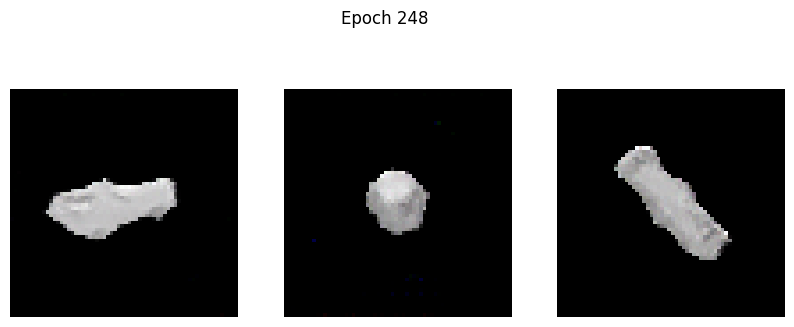

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1468 - g_loss: 3.8194
Epoch 249/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0983 - g_loss: 3.7849

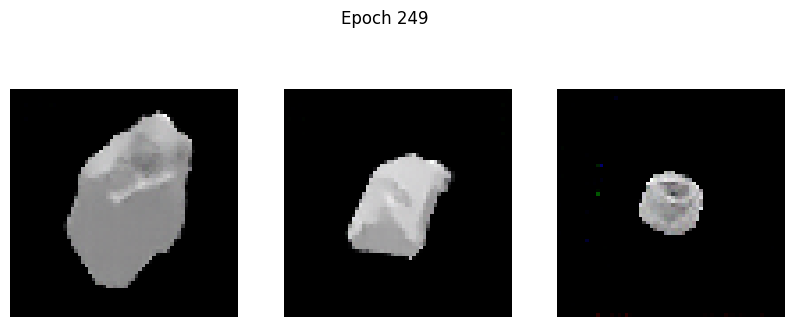

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0982 - g_loss: 3.7843
Epoch 250/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1035 - g_loss: 3.7709

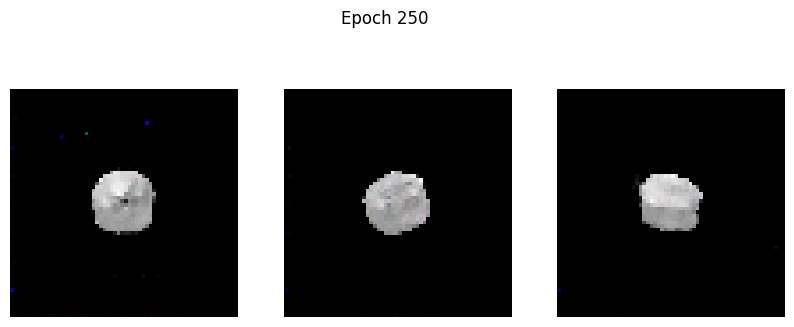

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1036 - g_loss: 3.7712
Epoch 251/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1416 - g_loss: 3.8088

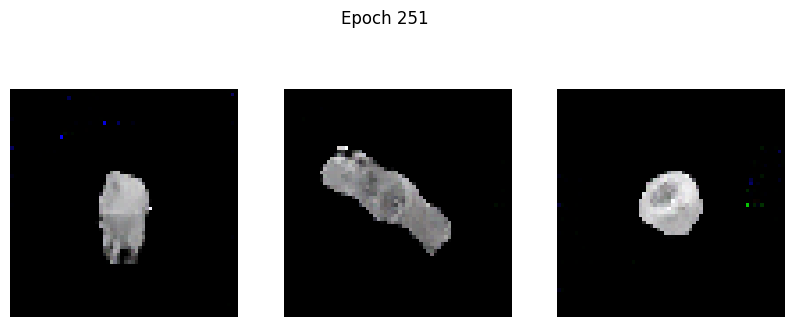

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1420 - g_loss: 3.8096
Epoch 252/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1146 - g_loss: 3.7950

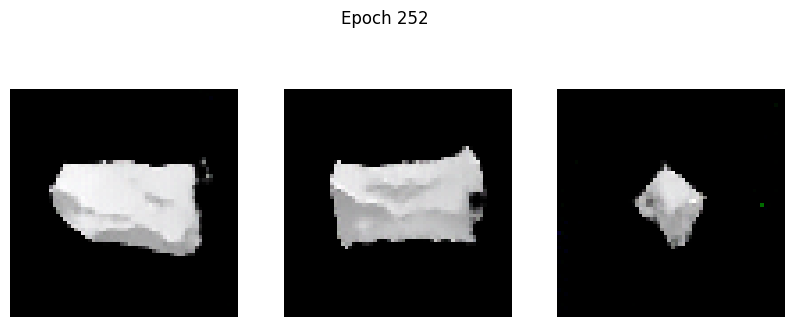

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1146 - g_loss: 3.7946
Epoch 253/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0904 - g_loss: 3.7699

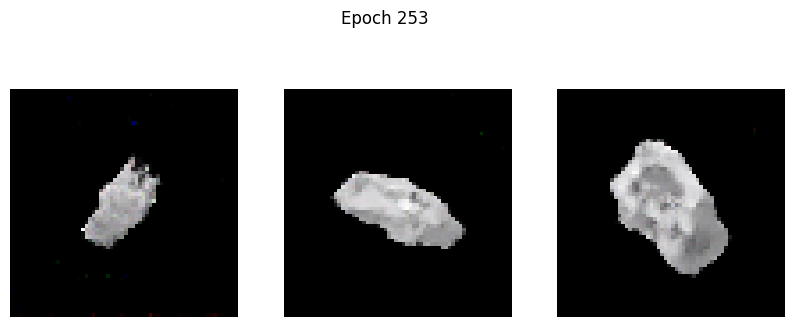

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0904 - g_loss: 3.7701
Epoch 254/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2231 - g_loss: 3.9798

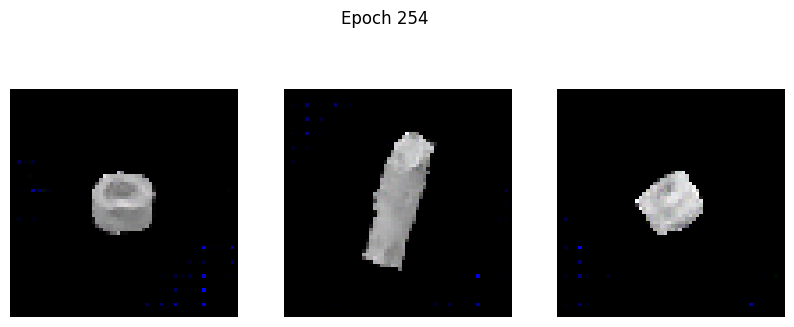

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2238 - g_loss: 3.9813
Epoch 255/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0969 - g_loss: 3.5333

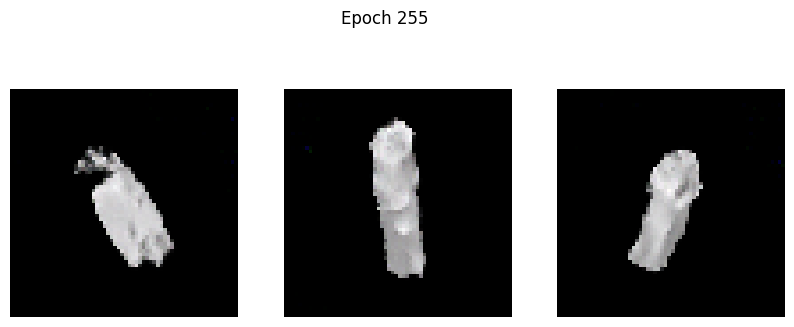

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0969 - g_loss: 3.5341
Epoch 256/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0822 - g_loss: 3.6846

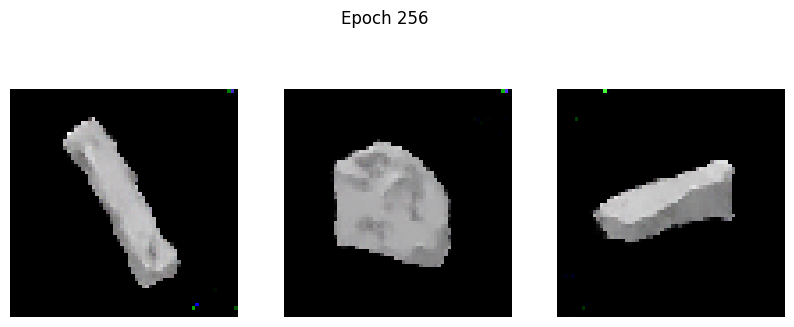

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0821 - g_loss: 3.6839
Epoch 257/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1096 - g_loss: 3.7966

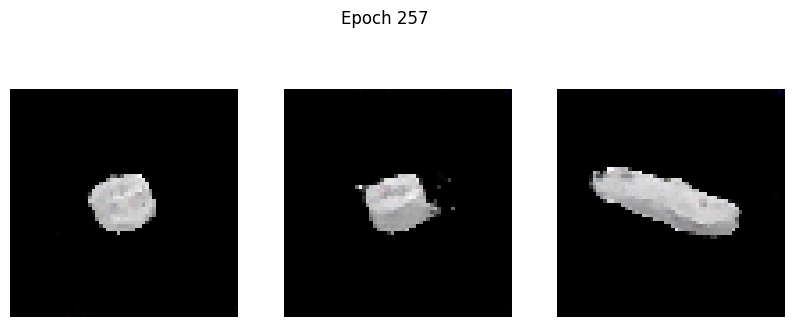

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.1096 - g_loss: 3.7963
Epoch 258/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0740 - g_loss: 3.7879

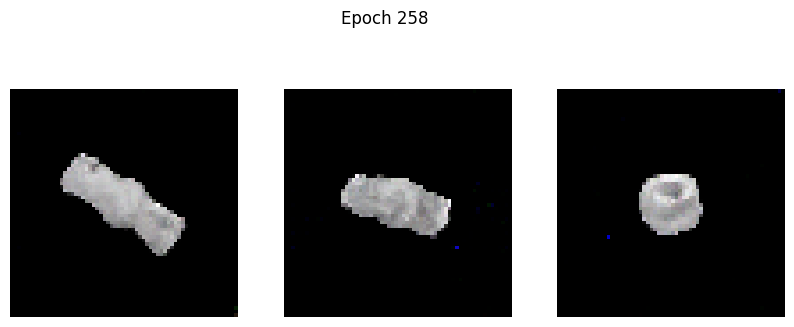

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0740 - g_loss: 3.7876
Epoch 259/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1742 - g_loss: 3.9148

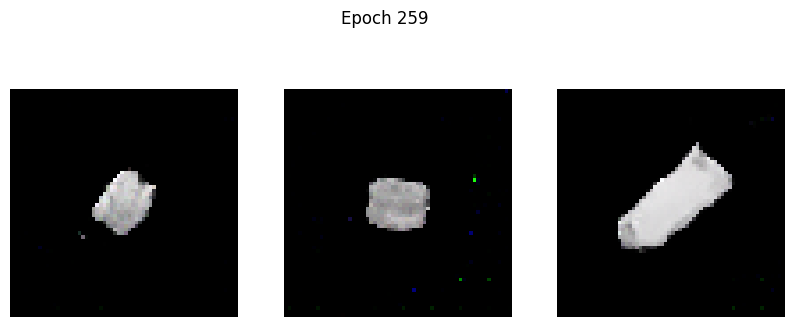

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1737 - g_loss: 3.9137
Epoch 260/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0743 - g_loss: 3.9132

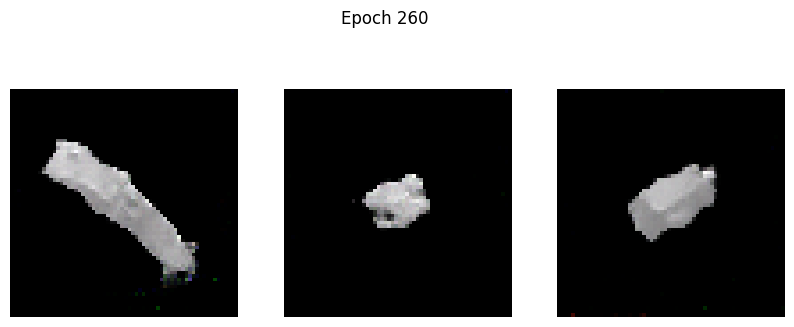

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0744 - g_loss: 3.9128
Epoch 261/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0869 - g_loss: 3.8844

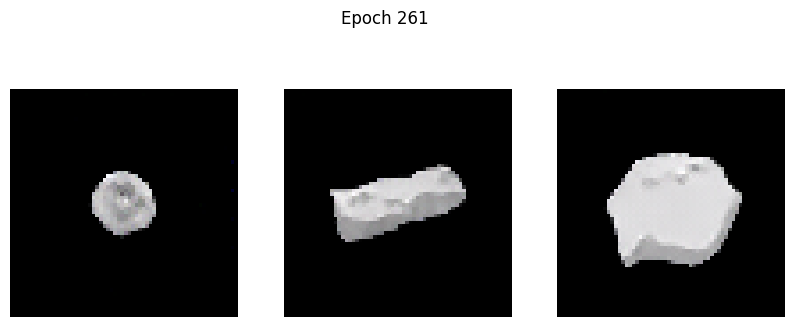

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0870 - g_loss: 3.8841
Epoch 262/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1015 - g_loss: 3.8749

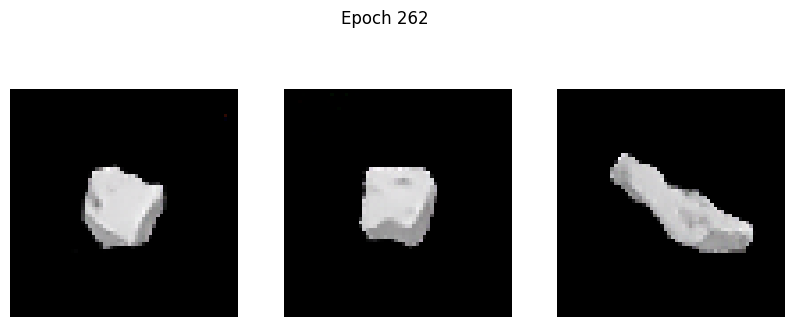

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1017 - g_loss: 3.8751
Epoch 263/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1316 - g_loss: 3.8473

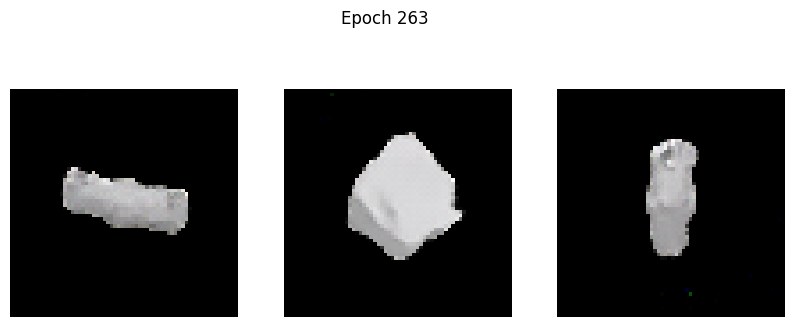

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1317 - g_loss: 3.8477
Epoch 264/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1142 - g_loss: 3.9983

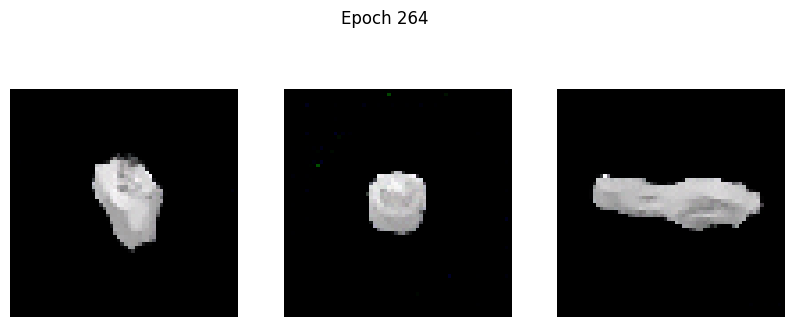

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1142 - g_loss: 3.9979
Epoch 265/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0743 - g_loss: 3.8608

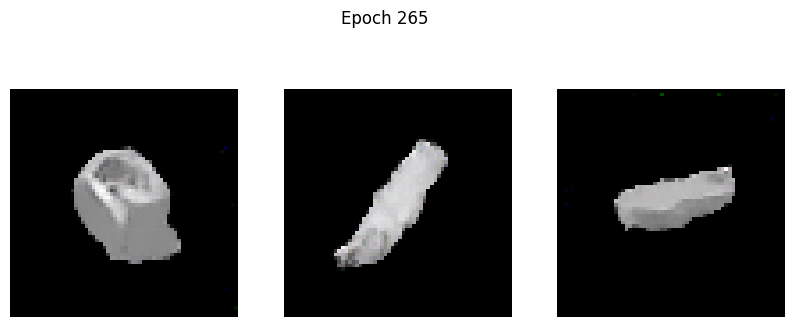

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0743 - g_loss: 3.8604
Epoch 266/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1517 - g_loss: 4.1256

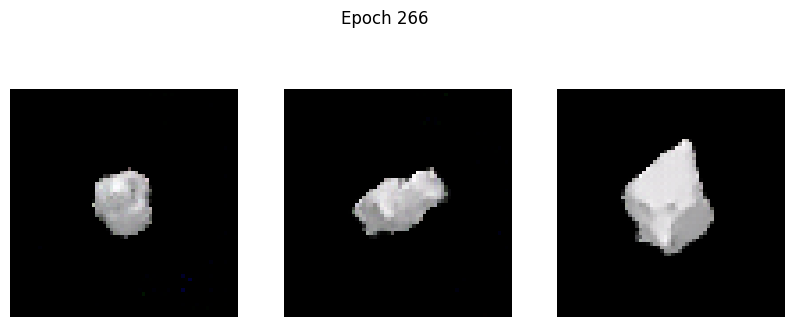

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1527 - g_loss: 4.1268
Epoch 267/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2065 - g_loss: 3.7607

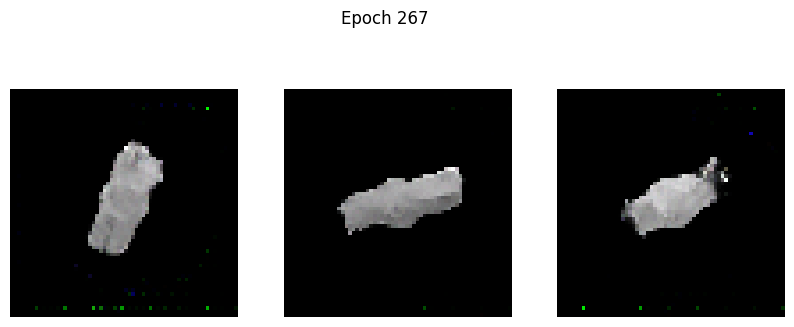

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2056 - g_loss: 3.7600
Epoch 268/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0650 - g_loss: 3.7359

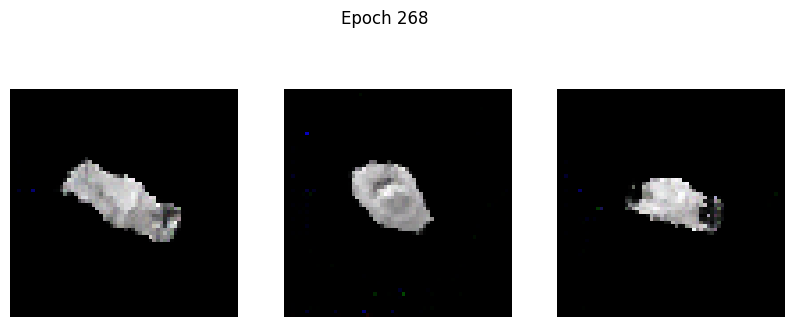

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0651 - g_loss: 3.7363
Epoch 269/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0804 - g_loss: 3.7959

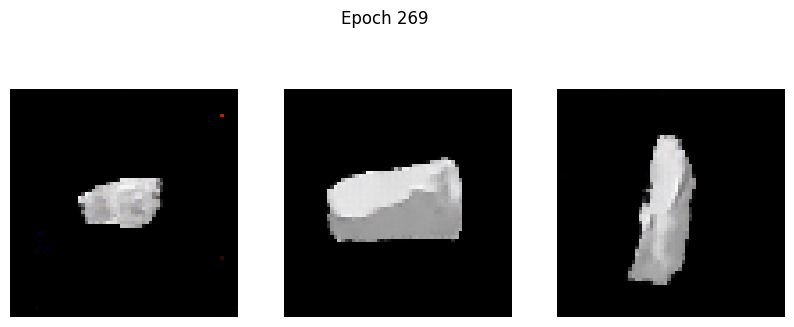

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0804 - g_loss: 3.7959
Epoch 270/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0840 - g_loss: 3.8021

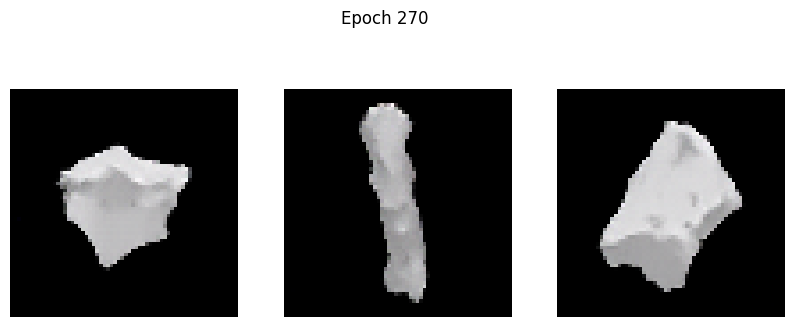

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0841 - g_loss: 3.8033
Epoch 271/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0581 - g_loss: 3.8405

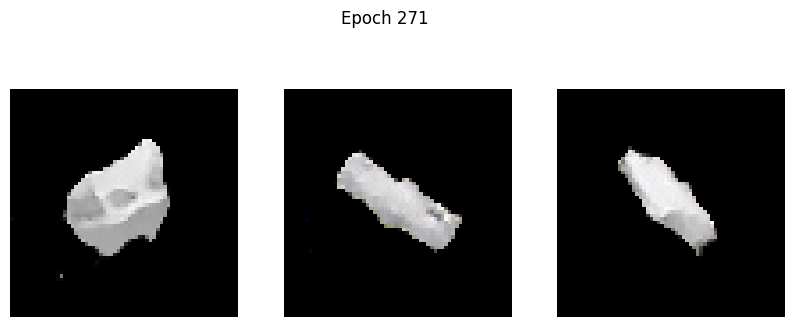

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0585 - g_loss: 3.8410
Epoch 272/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1914 - g_loss: 4.2396

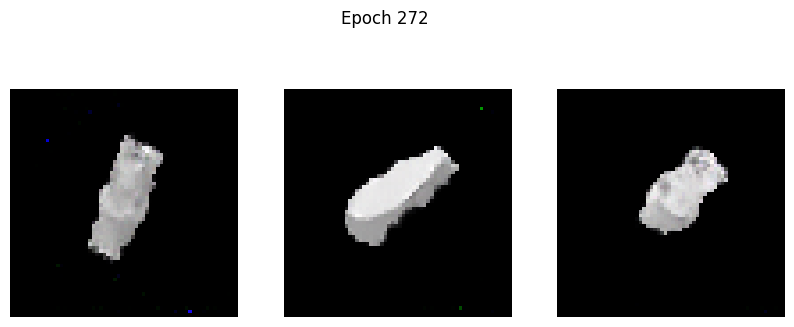

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1906 - g_loss: 4.2368
Epoch 273/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0954 - g_loss: 3.9560

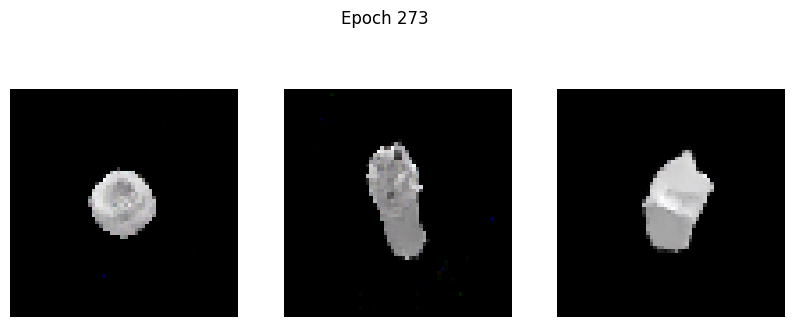

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0958 - g_loss: 3.9567
Epoch 274/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1067 - g_loss: 3.9472

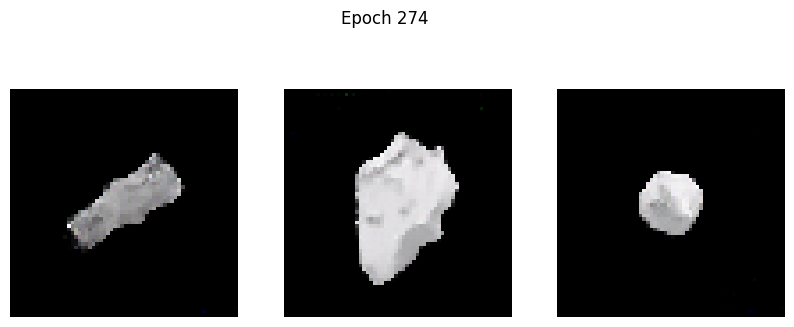

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1072 - g_loss: 3.9479
Epoch 275/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0812 - g_loss: 3.8584

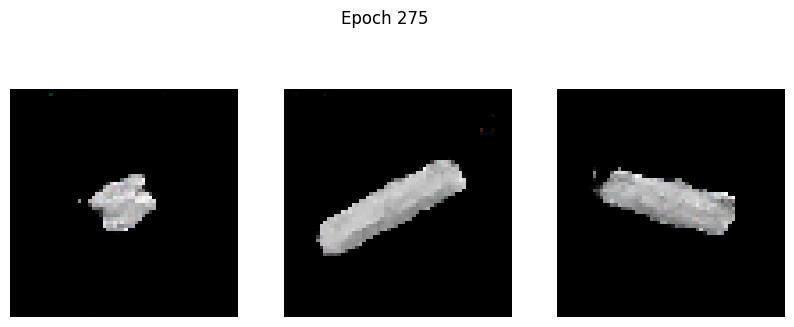

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0812 - g_loss: 3.8588
Epoch 276/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0908 - g_loss: 4.0925

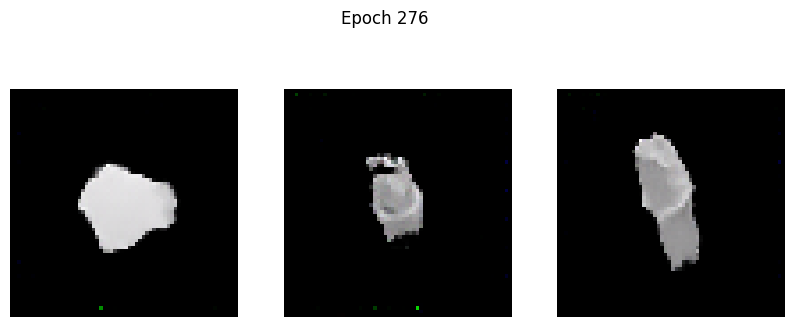

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0906 - g_loss: 4.0915
Epoch 277/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0798 - g_loss: 4.1335

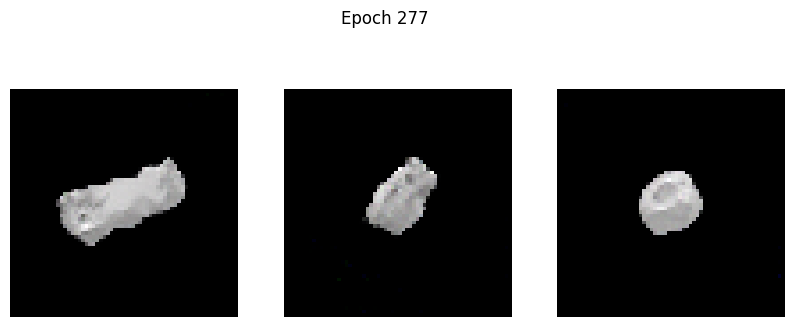

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0798 - g_loss: 4.1328
Epoch 278/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4739 - g_loss: 4.5748

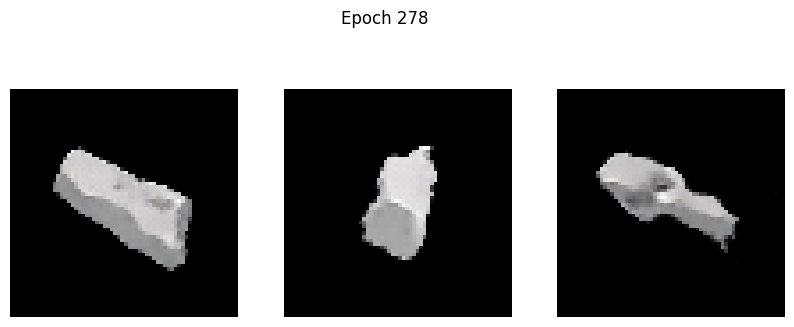

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4745 - g_loss: 4.5736
Epoch 279/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1071 - g_loss: 3.6785

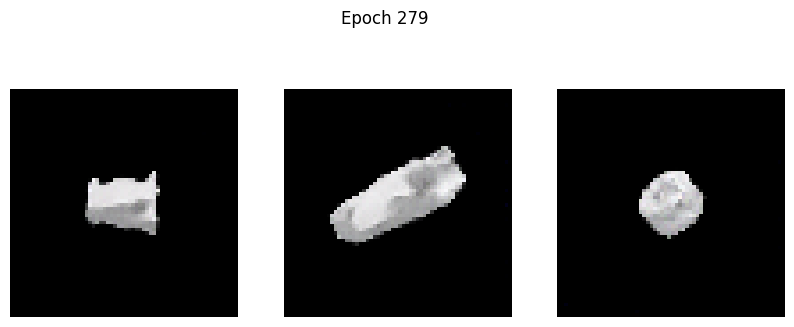

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1071 - g_loss: 3.6790
Epoch 280/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0754 - g_loss: 3.9201

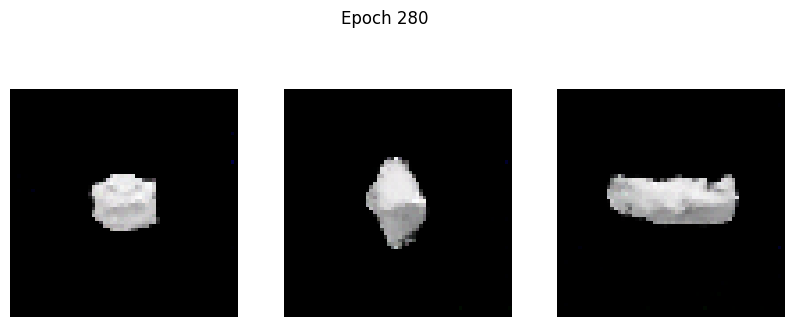

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0753 - g_loss: 3.9193
Epoch 281/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0689 - g_loss: 3.8702

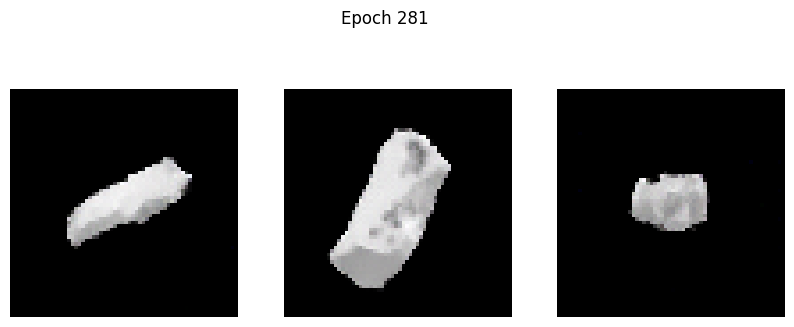

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0688 - g_loss: 3.8705
Epoch 282/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0620 - g_loss: 3.8807

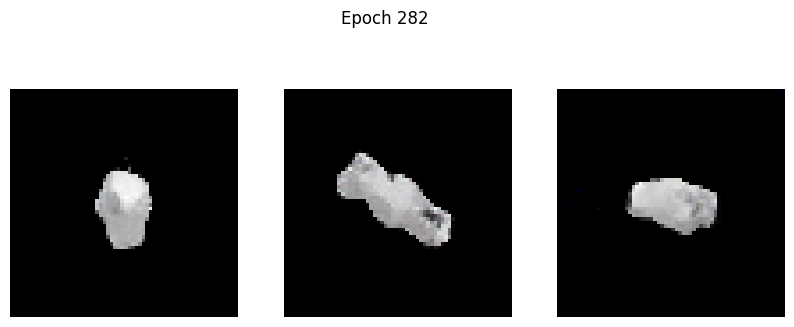

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0619 - g_loss: 3.8813
Epoch 283/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0545 - g_loss: 3.9221

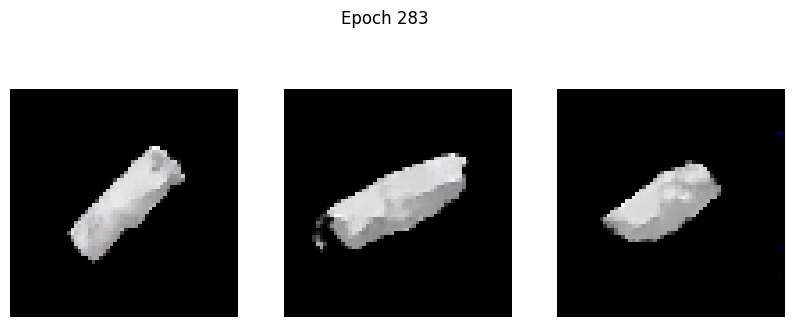

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0546 - g_loss: 3.9222
Epoch 284/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1278 - g_loss: 4.0897

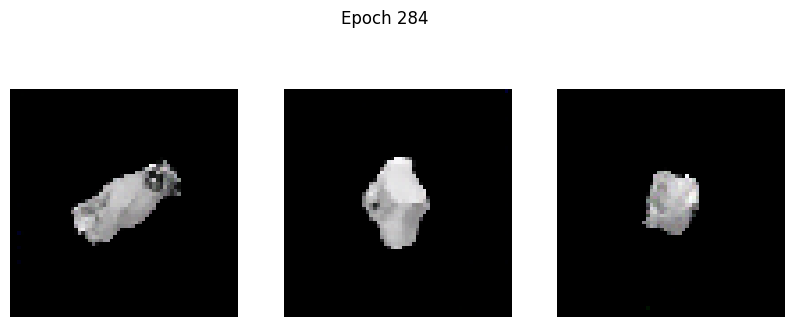

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1276 - g_loss: 4.0896
Epoch 285/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0642 - g_loss: 4.0102

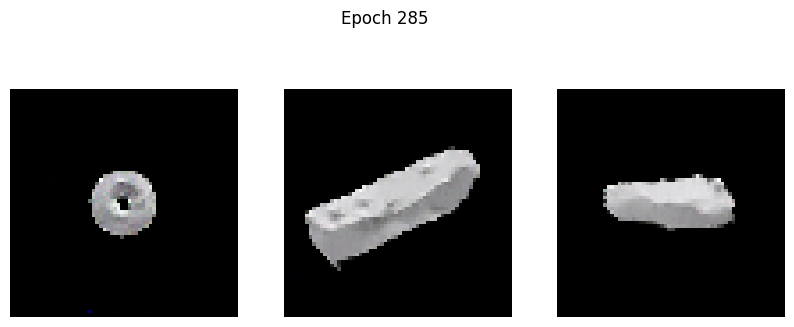

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0642 - g_loss: 4.0097
Epoch 286/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0864 - g_loss: 4.0777

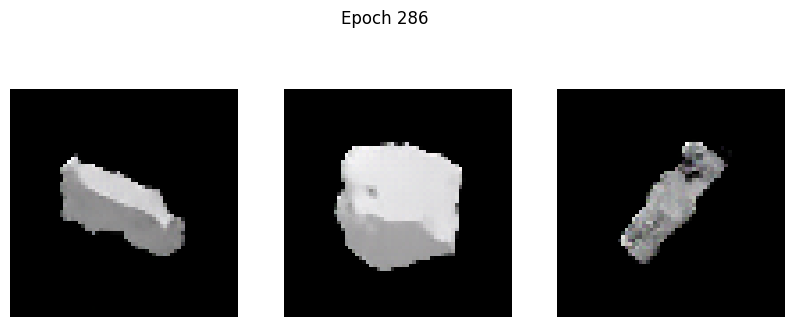

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0870 - g_loss: 4.0790
Epoch 287/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1512 - g_loss: 4.0858

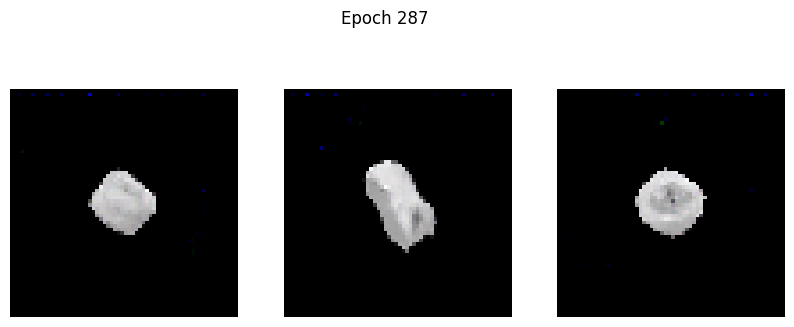

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1509 - g_loss: 4.0853
Epoch 288/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0706 - g_loss: 4.1304

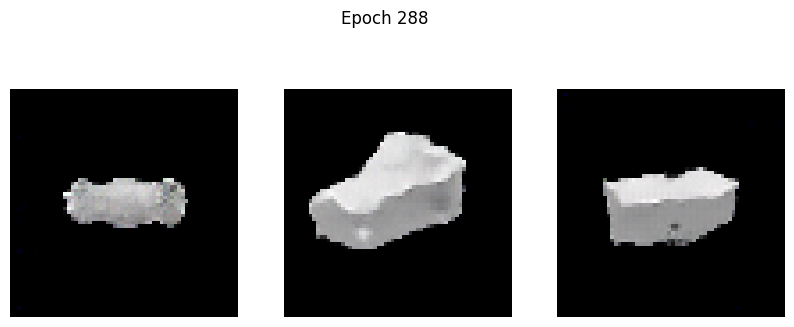

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0708 - g_loss: 4.1303
Epoch 289/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0598 - g_loss: 3.9873

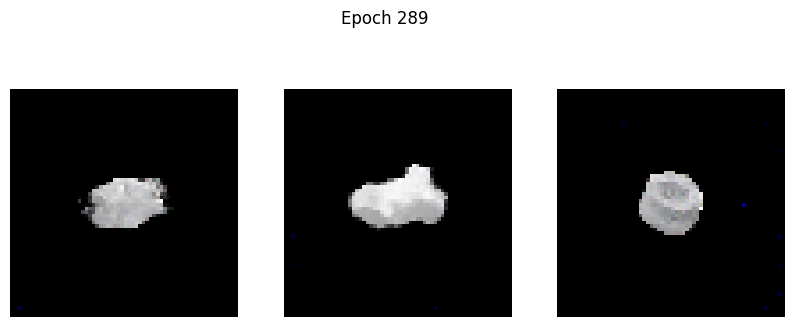

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0599 - g_loss: 3.9873
Epoch 290/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0598 - g_loss: 3.9707

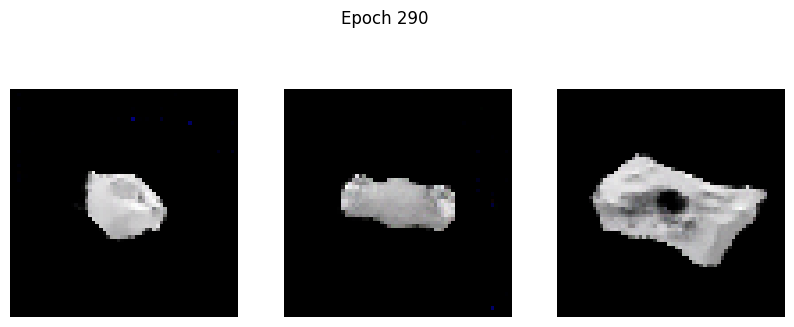

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0597 - g_loss: 3.9714
Epoch 291/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0680 - g_loss: 3.9777

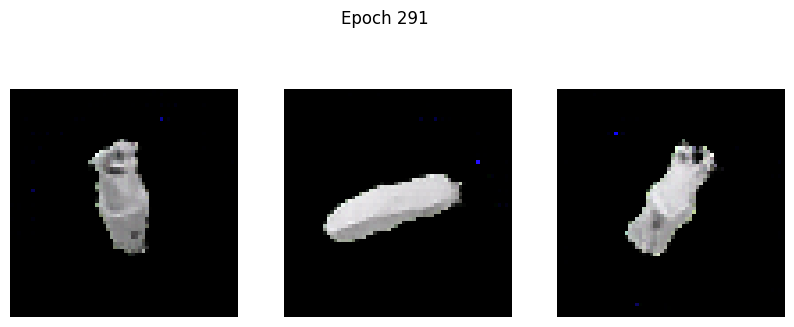

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0685 - g_loss: 3.9797
Epoch 292/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5029 - g_loss: 4.3957

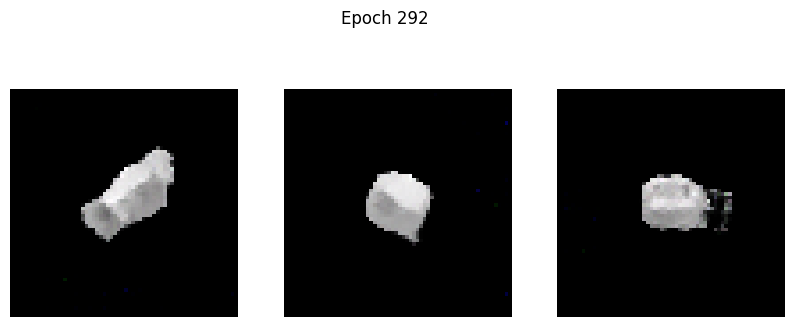

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5000 - g_loss: 4.3927
Epoch 293/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0661 - g_loss: 4.0139

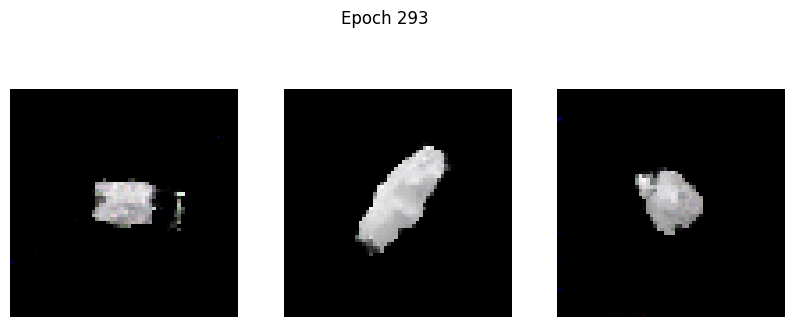

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0661 - g_loss: 4.0141
Epoch 294/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0672 - g_loss: 3.9628

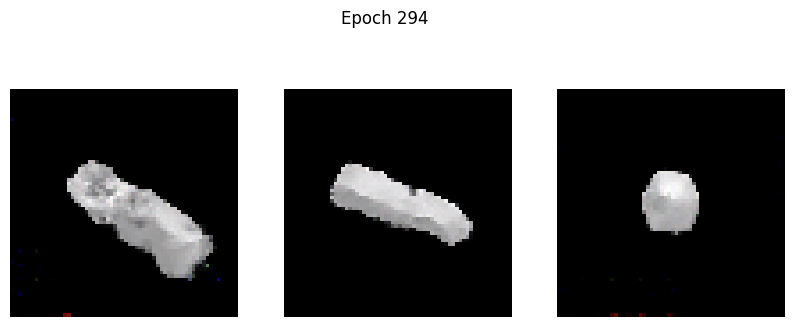

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0672 - g_loss: 3.9637
Epoch 295/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0494 - g_loss: 3.9629

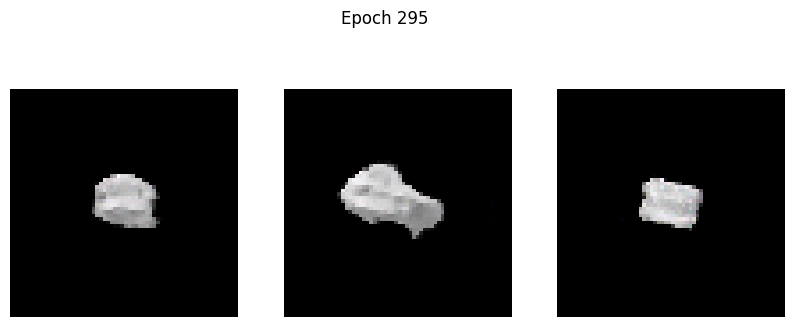

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0495 - g_loss: 3.9636
Epoch 296/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0898 - g_loss: 4.2507

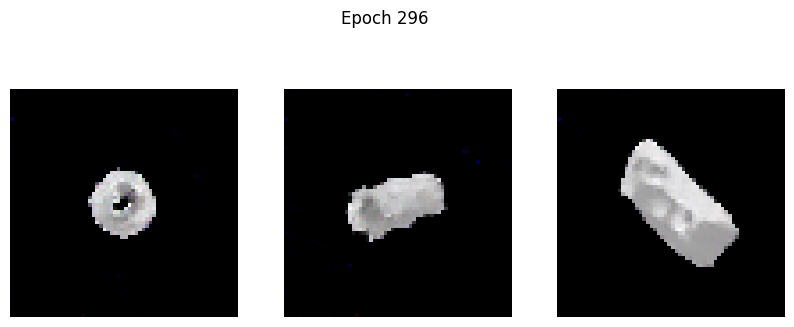

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0897 - g_loss: 4.2504
Epoch 297/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2286 - g_loss: 4.5605

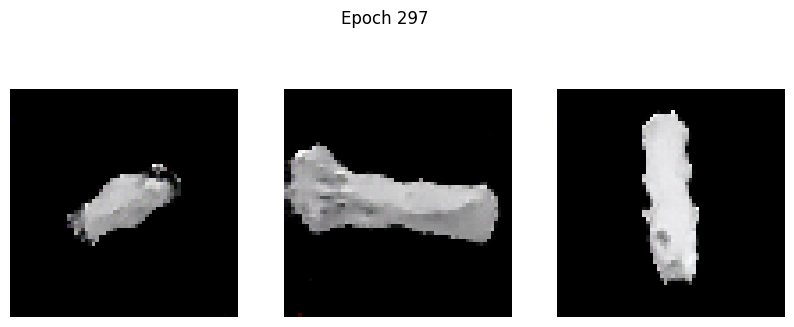

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2279 - g_loss: 4.5572
Epoch 298/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0803 - g_loss: 4.2359

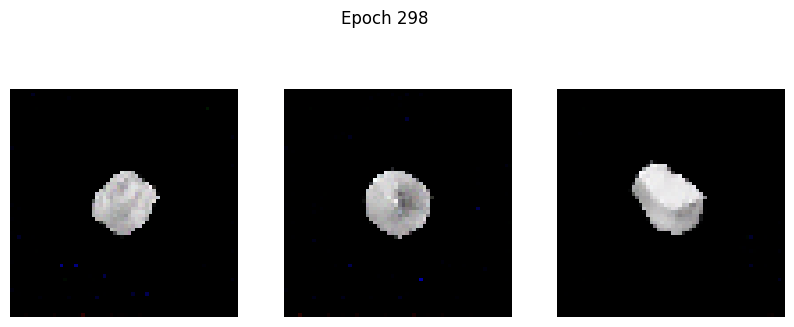

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0803 - g_loss: 4.2351
Epoch 299/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0959 - g_loss: 4.3341

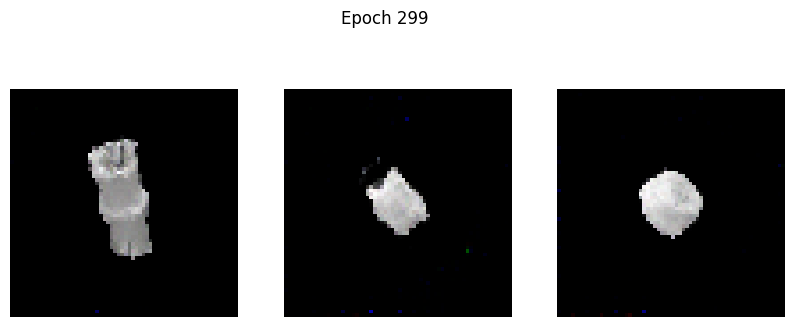

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0956 - g_loss: 4.3321
Epoch 300/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0684 - g_loss: 4.1689

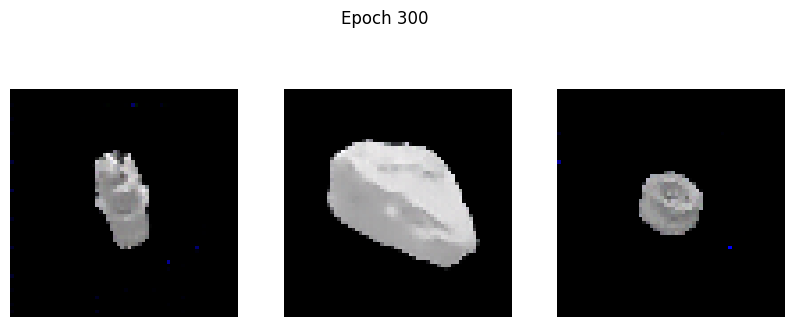

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0684 - g_loss: 4.1689
Epoch 301/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0897 - g_loss: 4.1324

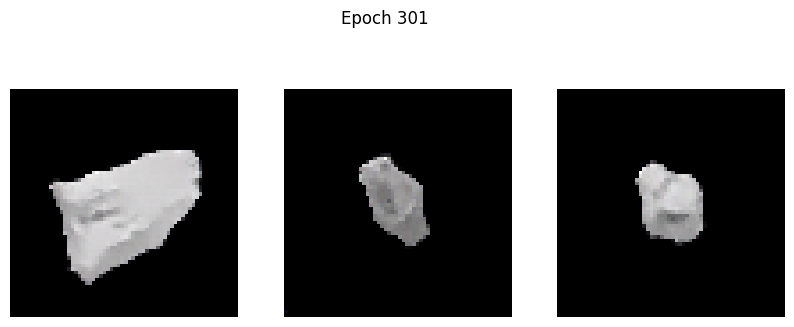

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0896 - g_loss: 4.1327
Epoch 302/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0973 - g_loss: 4.2680

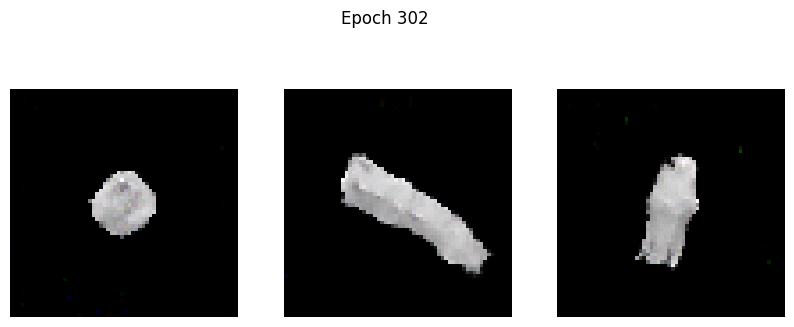

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0974 - g_loss: 4.2682
Epoch 303/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0832 - g_loss: 4.3398

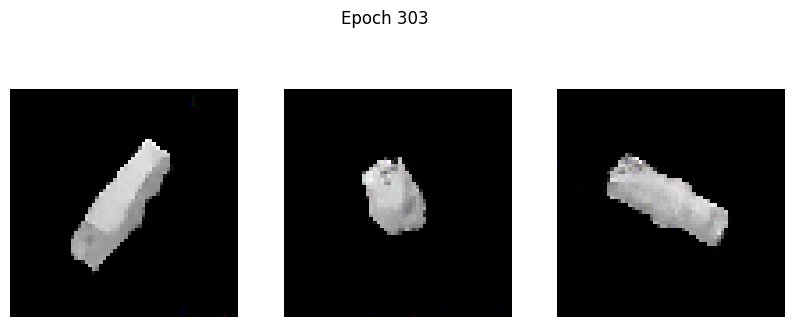

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0832 - g_loss: 4.3387
Epoch 304/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0745 - g_loss: 4.2681

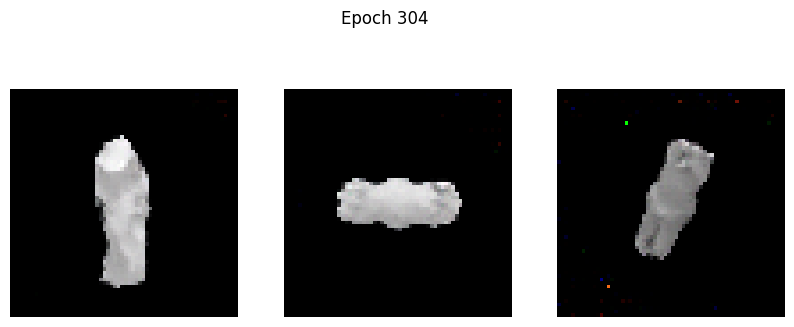

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0745 - g_loss: 4.2680
Epoch 305/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0530 - g_loss: 4.1629

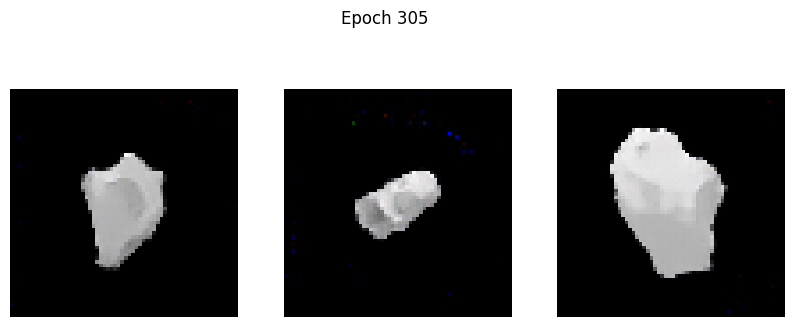

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0533 - g_loss: 4.1628
Epoch 306/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.2625 - g_loss: 4.5986

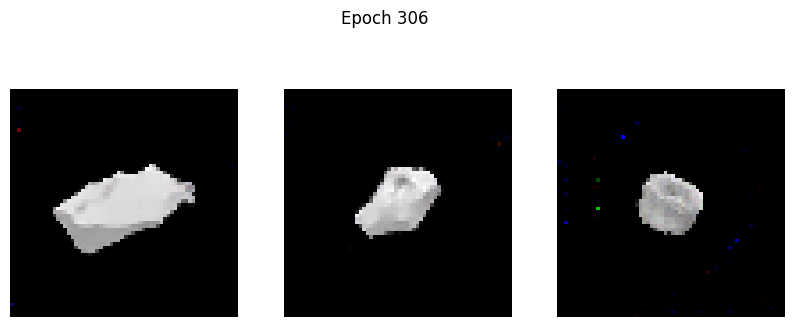

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2619 - g_loss: 4.5963
Epoch 307/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0508 - g_loss: 3.9990

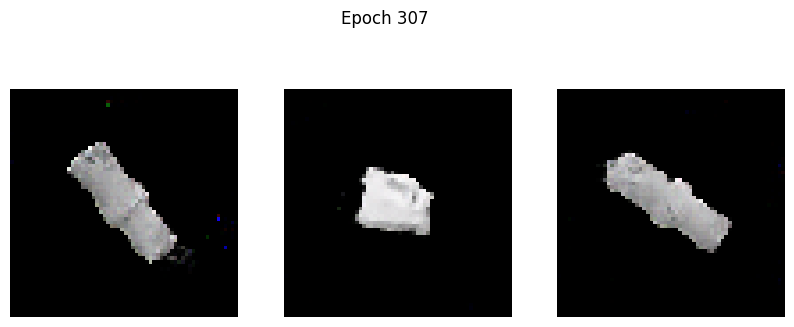

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0508 - g_loss: 3.9991
Epoch 308/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0476 - g_loss: 4.1753

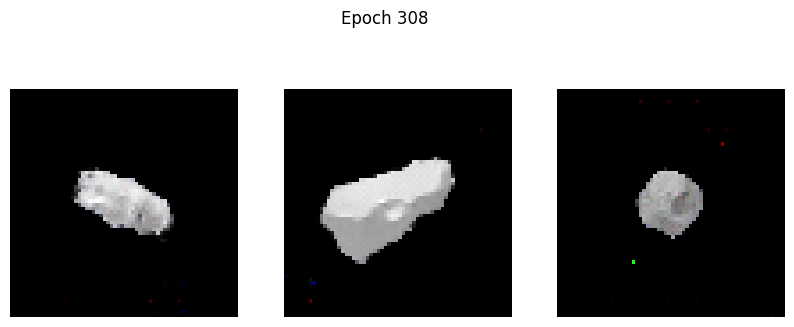

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0479 - g_loss: 4.1754
Epoch 309/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4365 - g_loss: 4.9247

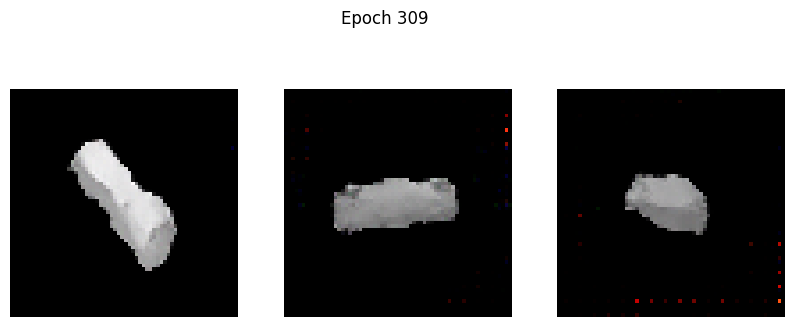

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4343 - g_loss: 4.9188
Epoch 310/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0527 - g_loss: 4.1062

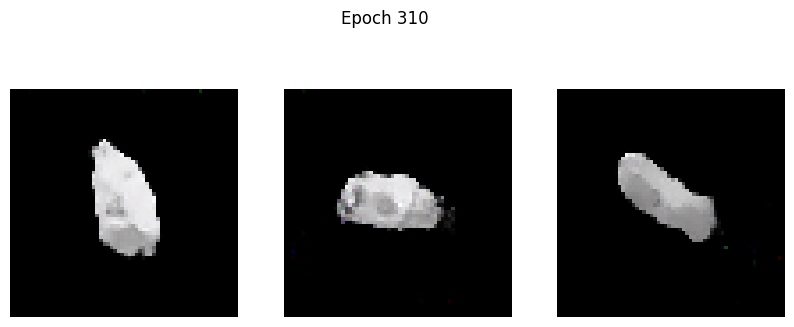

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0528 - g_loss: 4.1065
Epoch 311/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0495 - g_loss: 4.0519

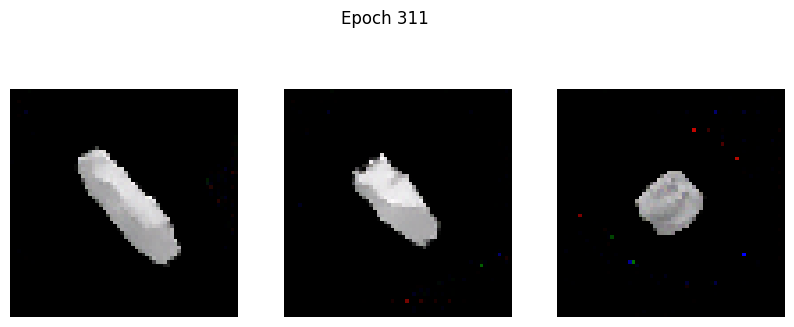

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0496 - g_loss: 4.0521
Epoch 312/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0783 - g_loss: 4.2920

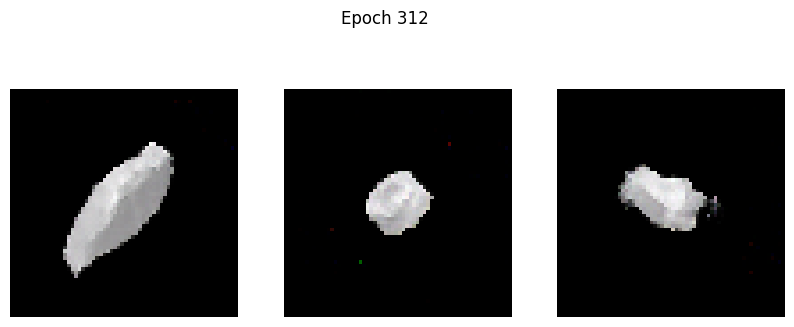

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0783 - g_loss: 4.2920
Epoch 313/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0740 - g_loss: 4.1547

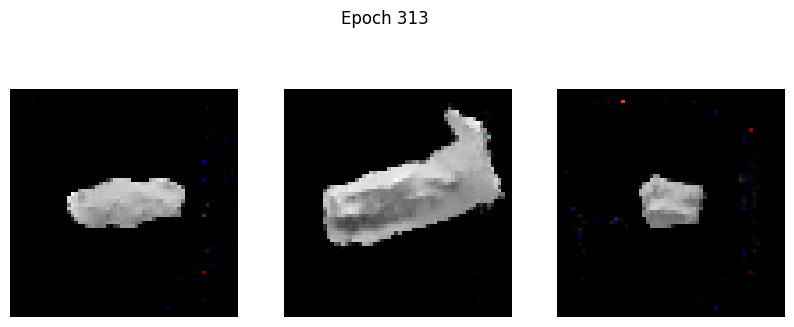

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0739 - g_loss: 4.1553
Epoch 314/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0791 - g_loss: 4.2020

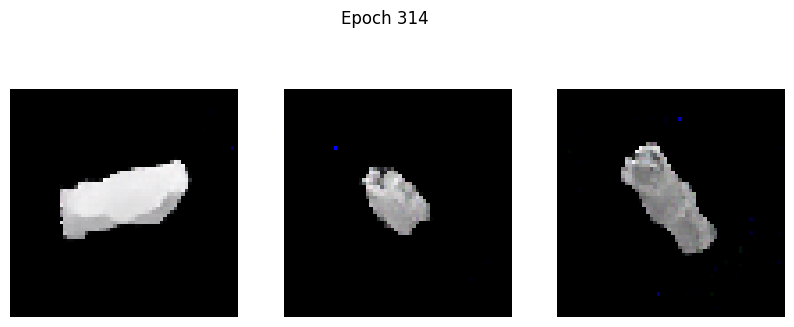

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0790 - g_loss: 4.2022
Epoch 315/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1723 - g_loss: 4.4284

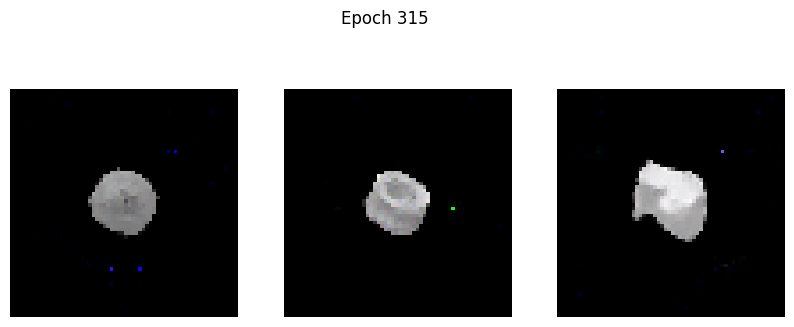

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1727 - g_loss: 4.4283
Epoch 316/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0496 - g_loss: 4.1149

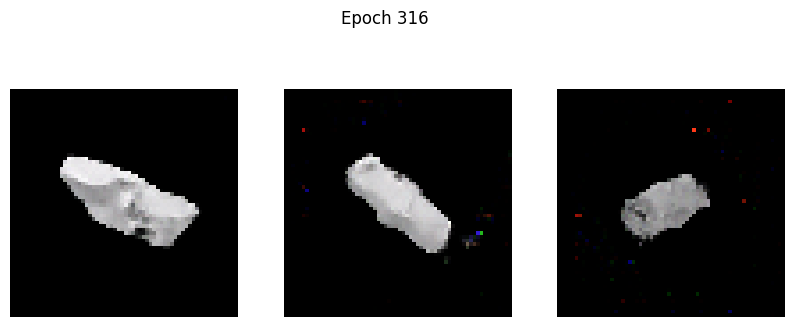

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0496 - g_loss: 4.1151
Epoch 317/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0543 - g_loss: 4.2265

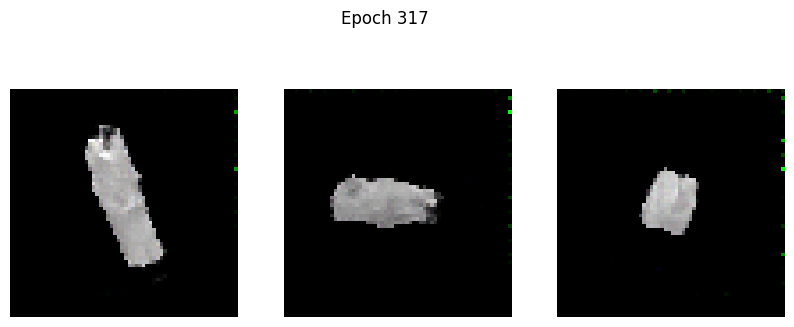

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0544 - g_loss: 4.2269
Epoch 318/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0418 - g_loss: 4.1200

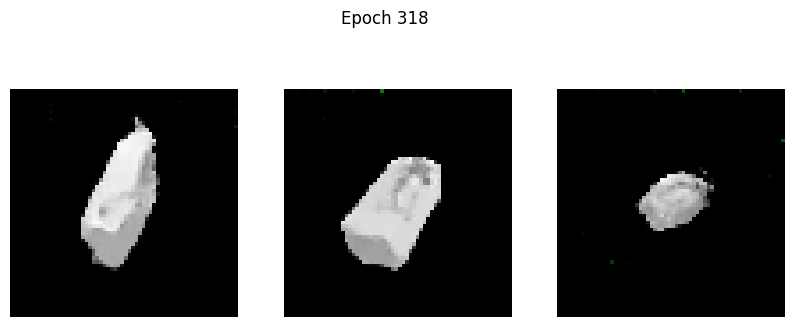

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0421 - g_loss: 4.1212
Epoch 319/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0713 - g_loss: 4.2376

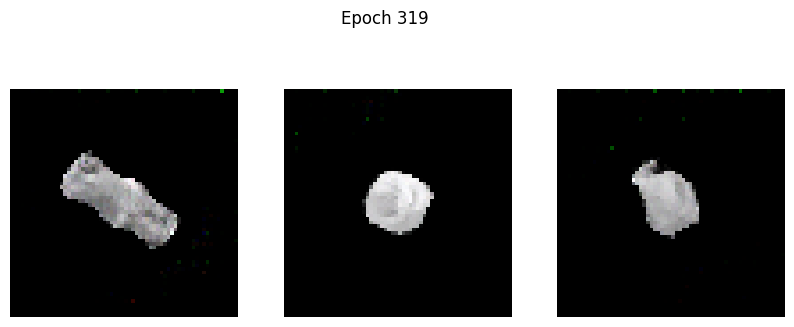

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0713 - g_loss: 4.2376
Epoch 320/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0696 - g_loss: 4.3008

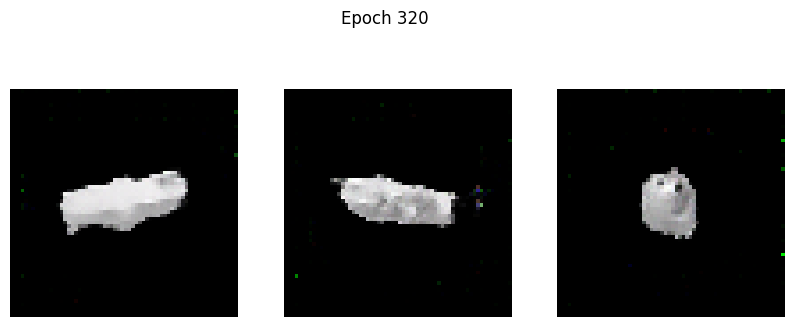

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0698 - g_loss: 4.3016
Epoch 321/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1105 - g_loss: 4.6575

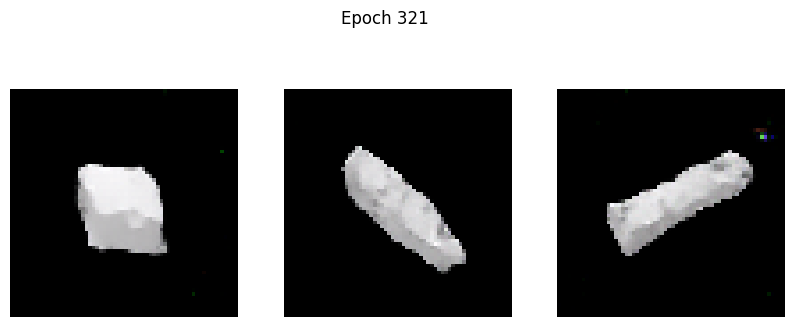

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1104 - g_loss: 4.6558
Epoch 322/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0546 - g_loss: 4.2850

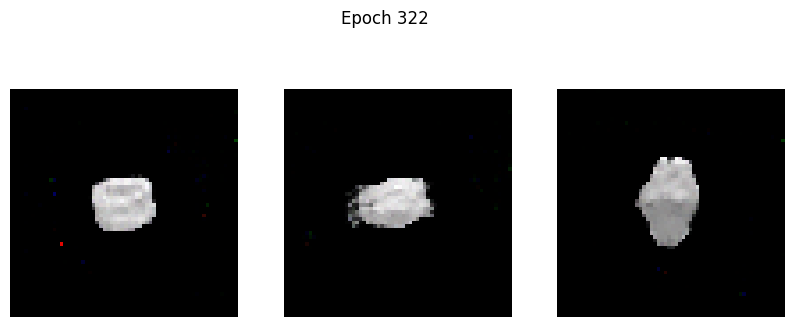

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0547 - g_loss: 4.2846
Epoch 323/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1269 - g_loss: 4.5035

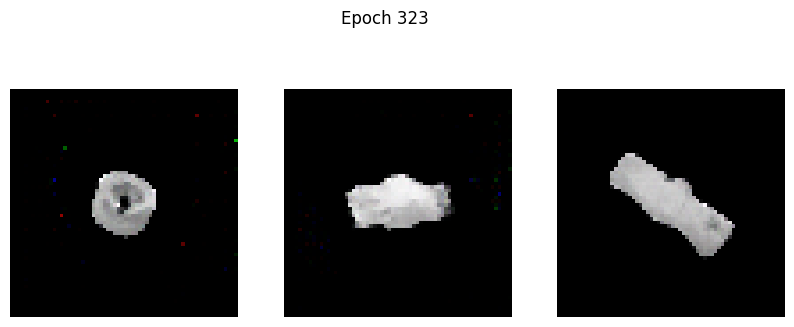

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1265 - g_loss: 4.5017
Epoch 324/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0496 - g_loss: 4.2897

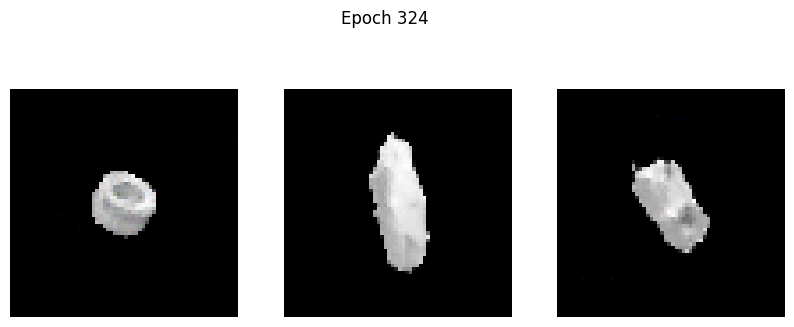

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0496 - g_loss: 4.2895
Epoch 325/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0322 - g_loss: 4.2483

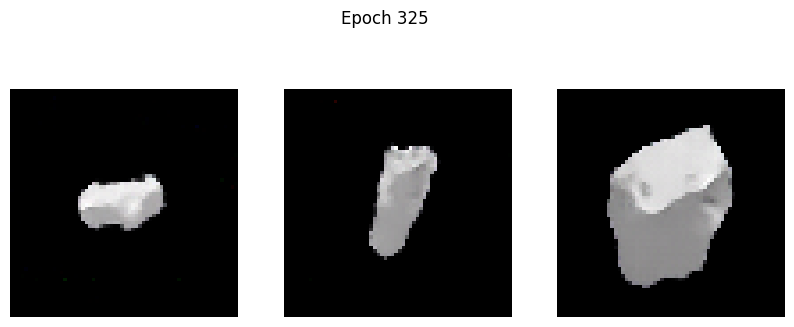

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0324 - g_loss: 4.2485
Epoch 326/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1192 - g_loss: 4.4716

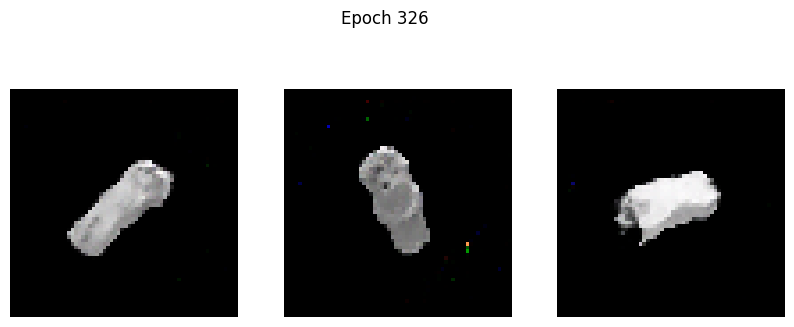

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - d_loss: 0.1188 - g_loss: 4.4715
Epoch 327/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0550 - g_loss: 4.4898

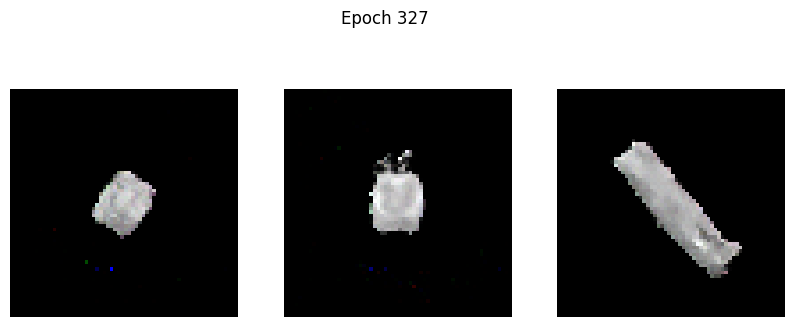

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0552 - g_loss: 4.4895
Epoch 328/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0441 - g_loss: 4.4000

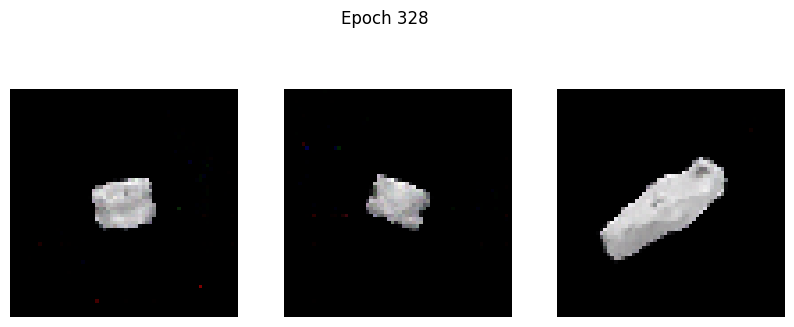

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0441 - g_loss: 4.3996
Epoch 329/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0923 - g_loss: 4.6310

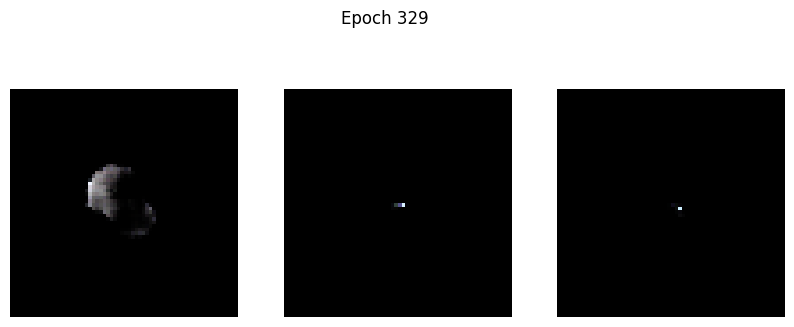

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0946 - g_loss: 4.6378
Epoch 330/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0263 - g_loss: 4.7595

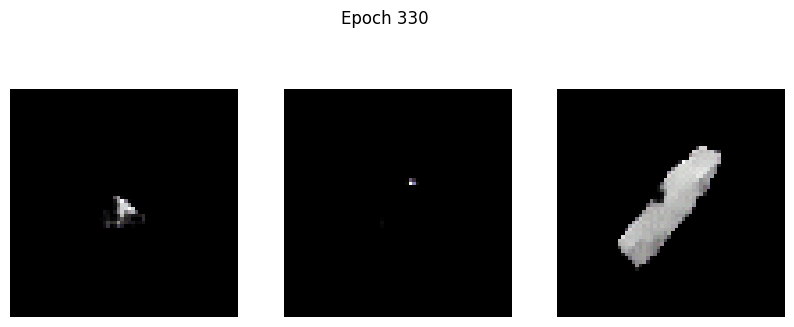

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0259 - g_loss: 4.7598
Epoch 331/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0246 - g_loss: 5.2814

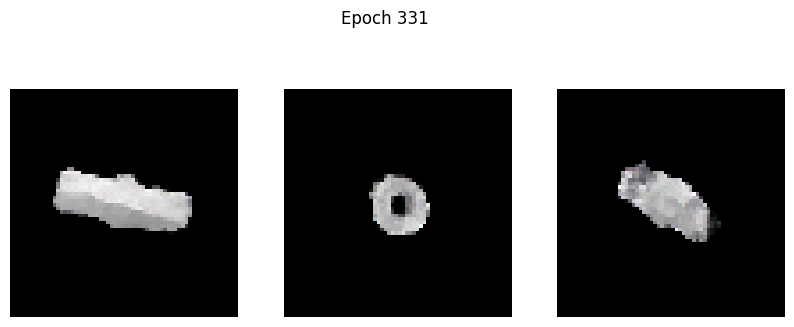

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - d_loss: -0.0246 - g_loss: 5.2805
Epoch 332/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0474 - g_loss: 5.0384

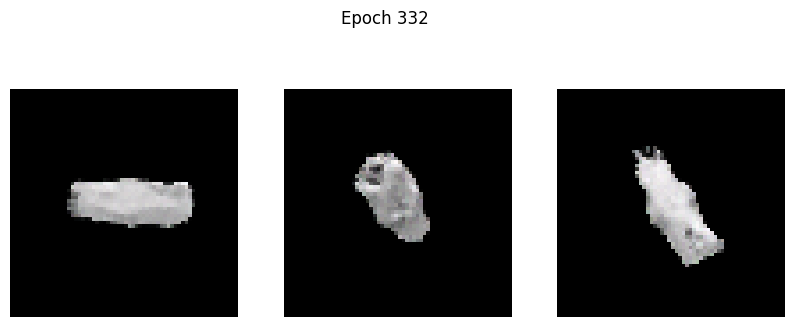

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0491 - g_loss: 5.0417
Epoch 333/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0457 - g_loss: 4.3851

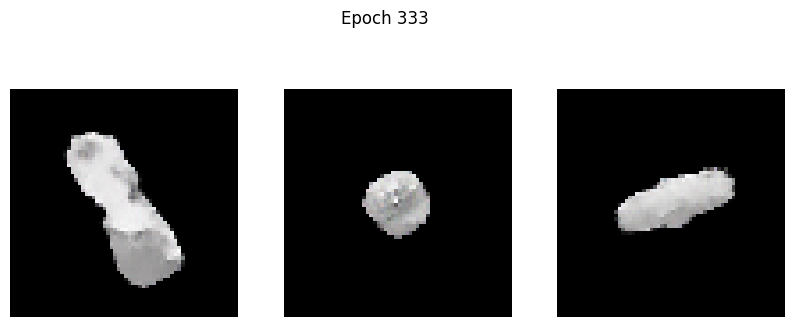

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0457 - g_loss: 4.3854
Epoch 334/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0328 - g_loss: 4.4945

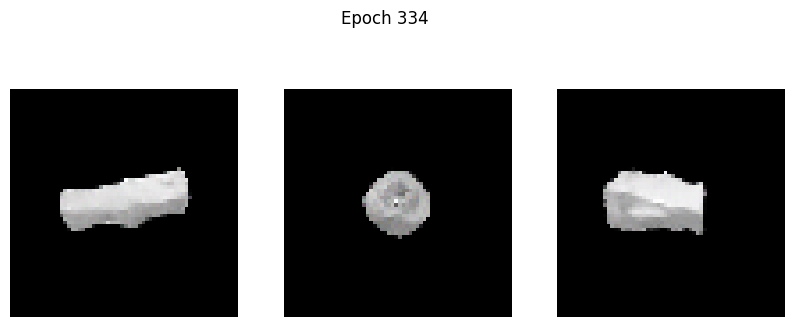

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0329 - g_loss: 4.4943
Epoch 335/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0376 - g_loss: 4.3456

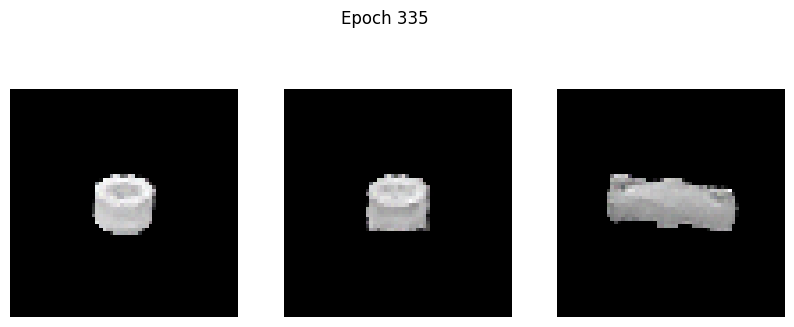

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0375 - g_loss: 4.3457
Epoch 336/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0668 - g_loss: 4.3773

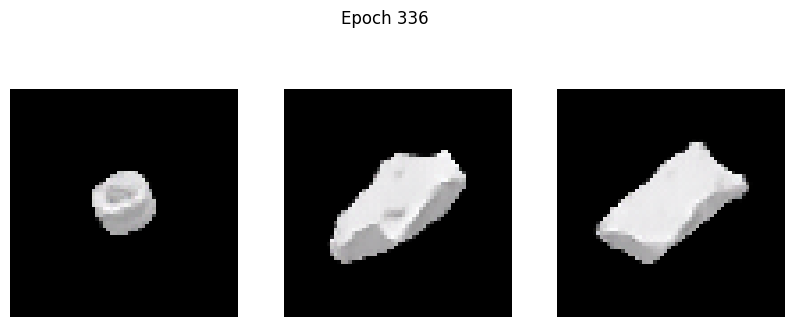

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0670 - g_loss: 4.3786
Epoch 337/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0591 - g_loss: 4.4137

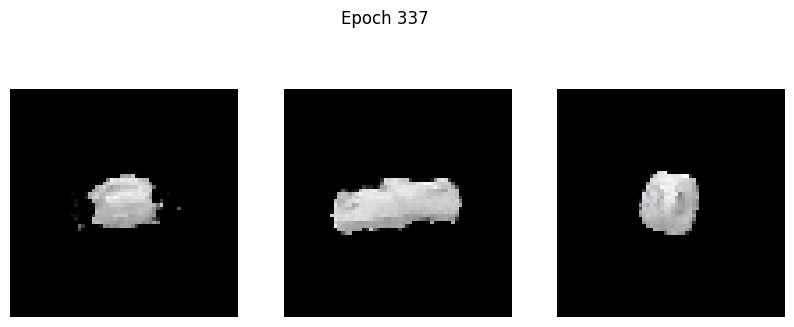

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0590 - g_loss: 4.4137
Epoch 338/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0393 - g_loss: 4.4602

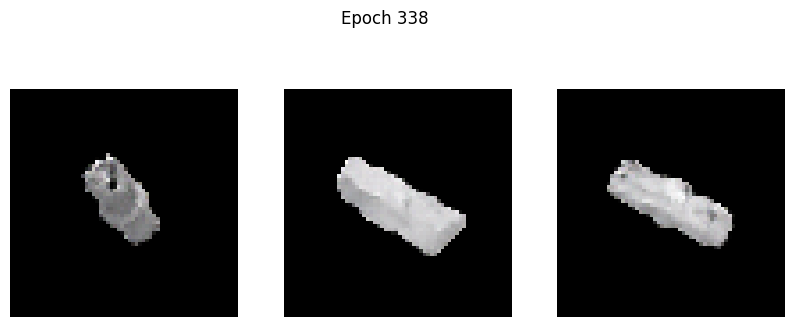

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0392 - g_loss: 4.4594
Epoch 339/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0462 - g_loss: 4.5556

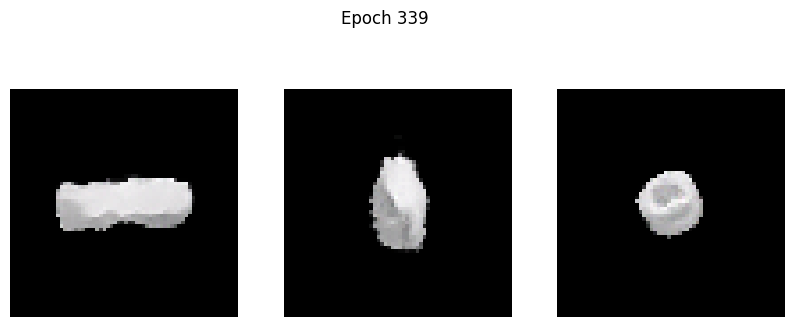

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0471 - g_loss: 4.5581
Epoch 340/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0639 - g_loss: 4.4830

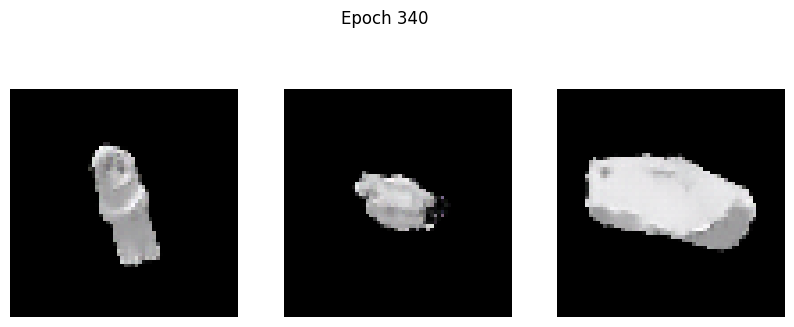

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0639 - g_loss: 4.4826
Epoch 341/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0771 - g_loss: 4.6022

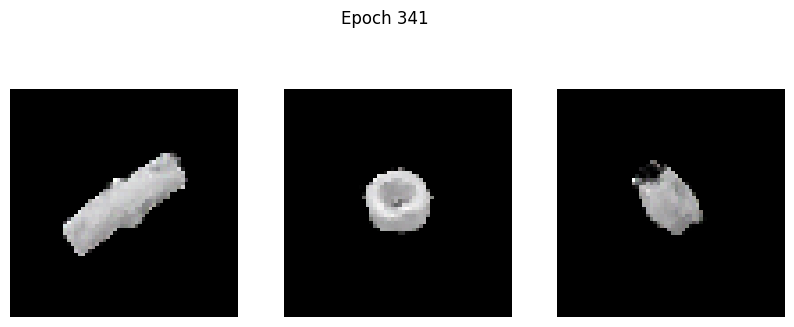

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0771 - g_loss: 4.6010
Epoch 342/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0766 - g_loss: 4.6836

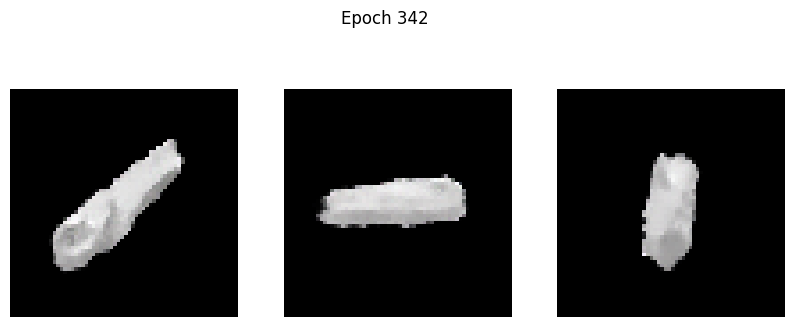

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0765 - g_loss: 4.6824
Epoch 343/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0616 - g_loss: 4.6074

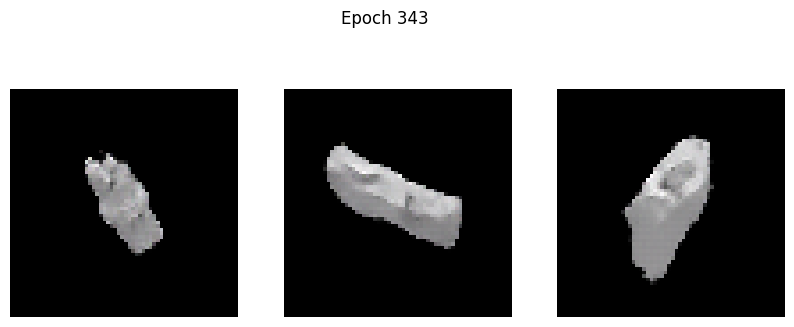

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0615 - g_loss: 4.6064
Epoch 344/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0620 - g_loss: 4.4688

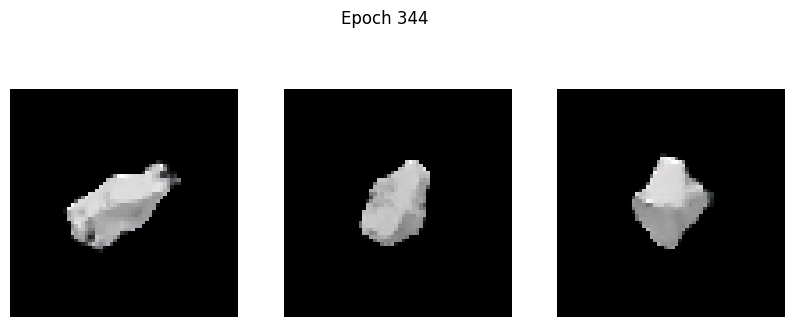

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0621 - g_loss: 4.4701
Epoch 345/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0445 - g_loss: 4.4681

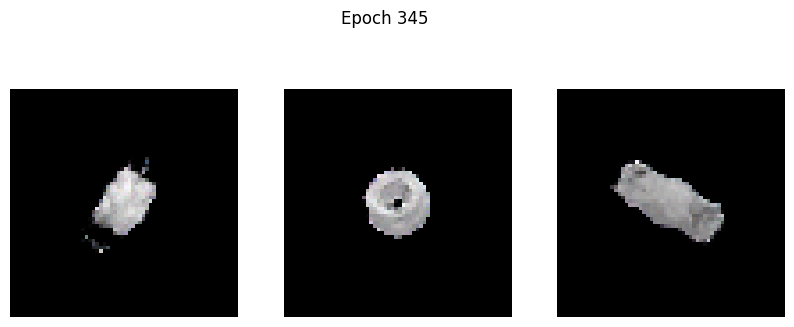

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0450 - g_loss: 4.4691
Epoch 346/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4928 - g_loss: 5.5190

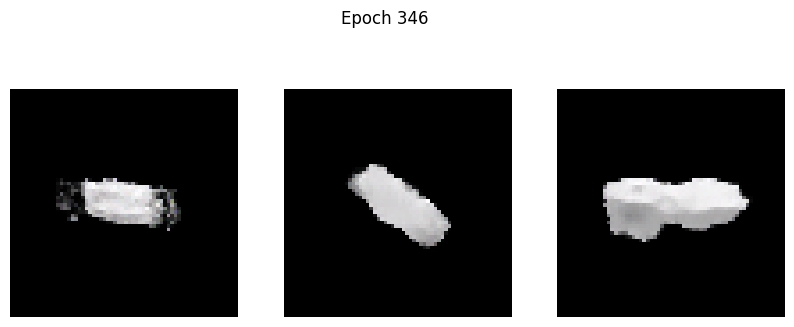

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4902 - g_loss: 5.5115
Epoch 347/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0357 - g_loss: 4.1046

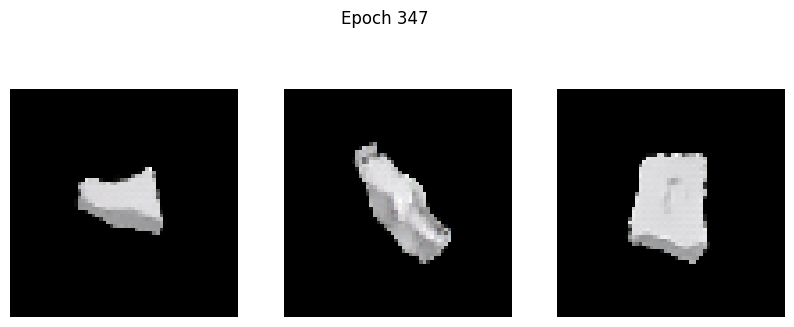

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0357 - g_loss: 4.1053
Epoch 348/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0105 - g_loss: 4.4317

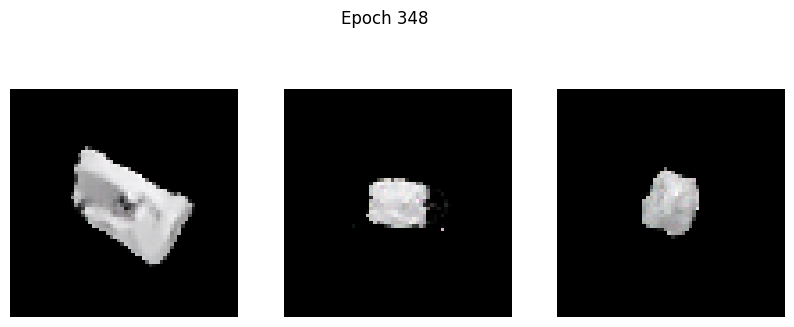

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0107 - g_loss: 4.4321
Epoch 349/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0224 - g_loss: 4.4100

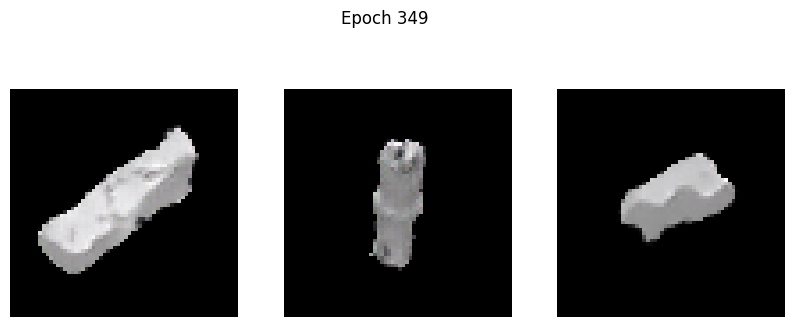

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0227 - g_loss: 4.4115
Epoch 350/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0502 - g_loss: 4.4865

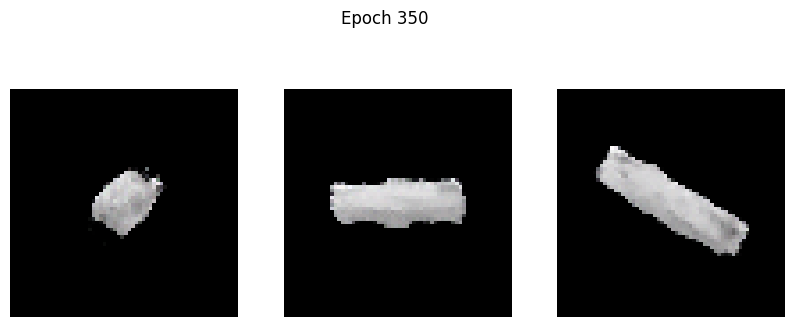

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0502 - g_loss: 4.4873
Epoch 351/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0521 - g_loss: 4.6325

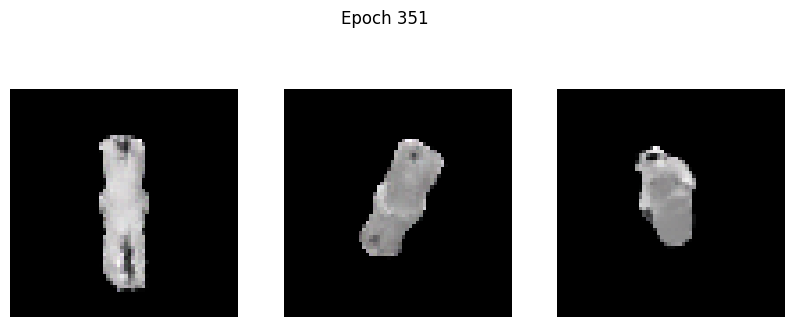

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0519 - g_loss: 4.6313
Epoch 352/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0866 - g_loss: 4.7308

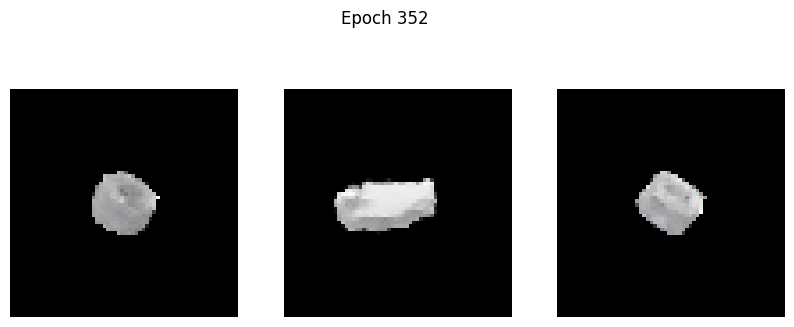

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0865 - g_loss: 4.7306
Epoch 353/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0205 - g_loss: 4.5056

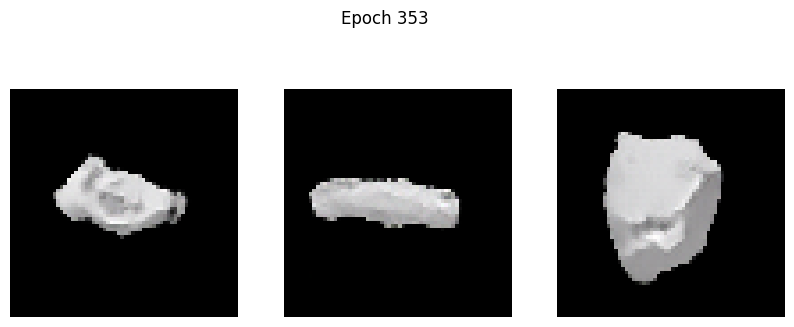

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0206 - g_loss: 4.5063
Epoch 354/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0705 - g_loss: 4.7602

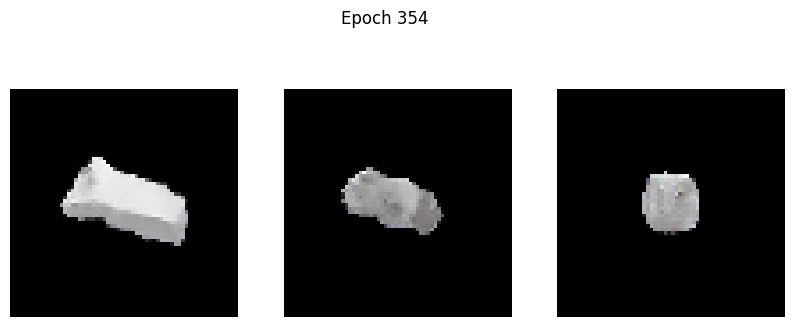

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0711 - g_loss: 4.7615
Epoch 355/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0550 - g_loss: 4.5992

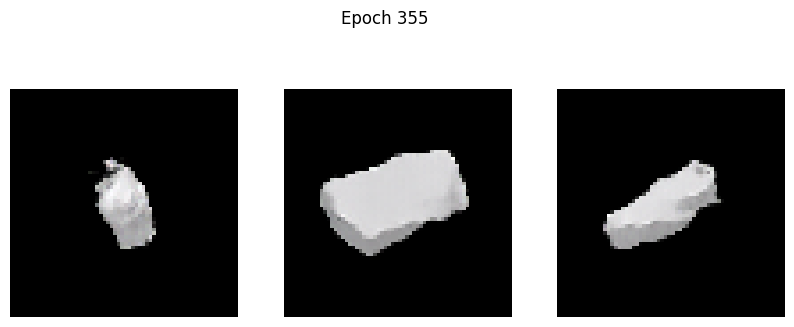

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0549 - g_loss: 4.5991
Epoch 356/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.1092 - g_loss: 4.7275

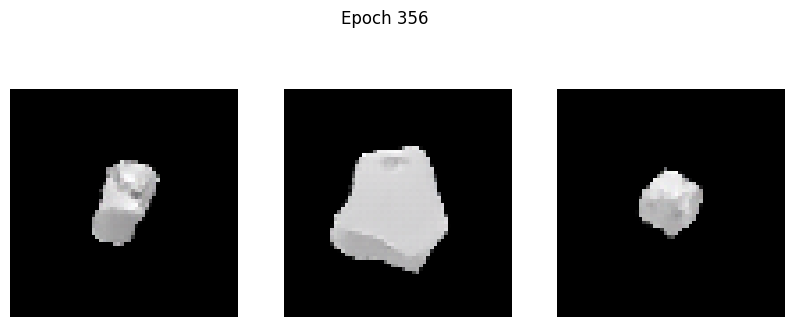

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1092 - g_loss: 4.7285
Epoch 357/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0179 - g_loss: 4.4844

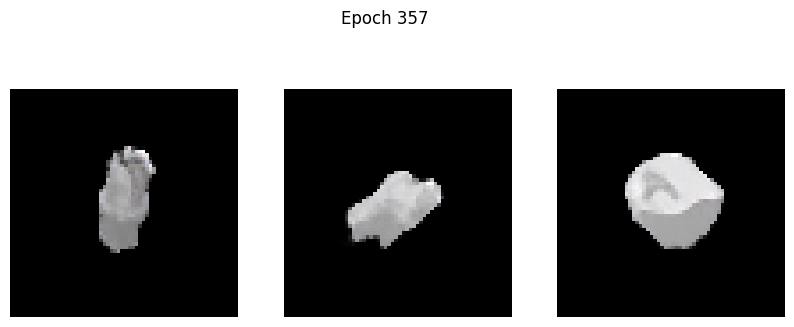

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0181 - g_loss: 4.4847
Epoch 358/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0388 - g_loss: 4.5499

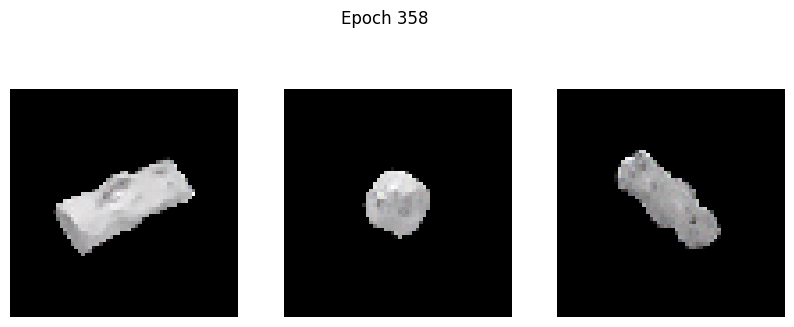

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0390 - g_loss: 4.5505
Epoch 359/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.1168 - g_loss: 4.7935

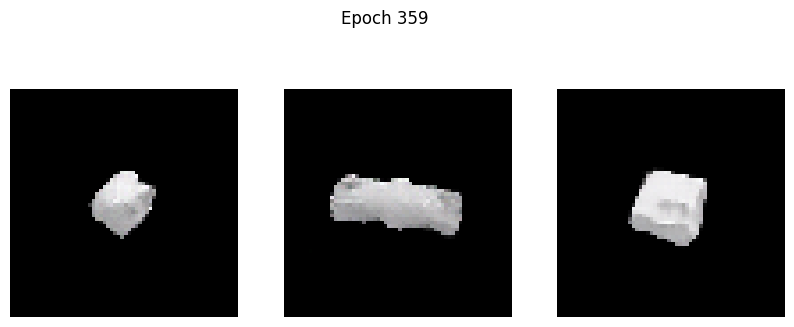

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.1168 - g_loss: 4.7937
Epoch 360/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0688 - g_loss: 4.6423

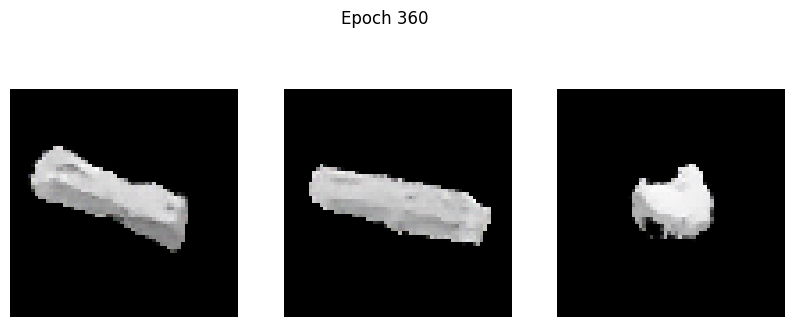

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0689 - g_loss: 4.6433
Epoch 361/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0689 - g_loss: 4.5308

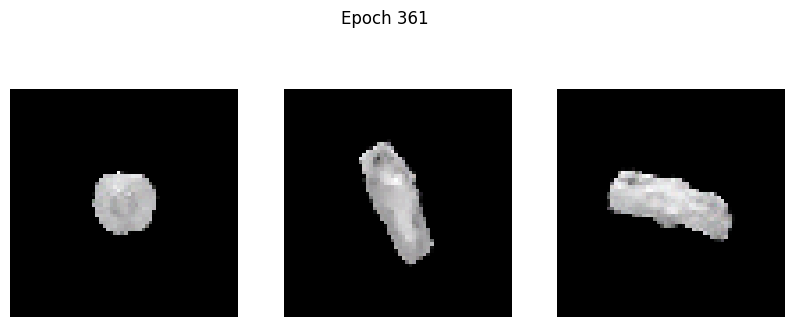

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0687 - g_loss: 4.5302
Epoch 362/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0237 - g_loss: 4.5951

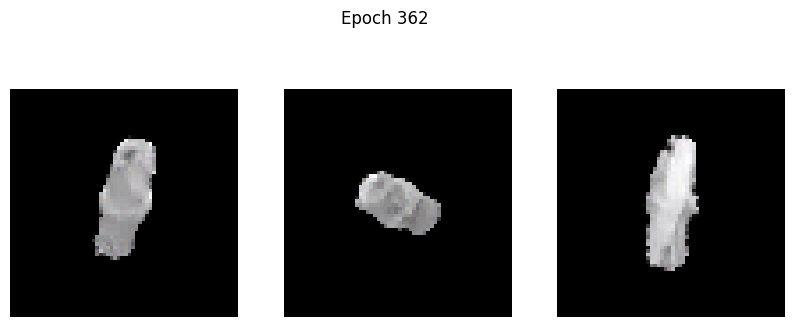

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0238 - g_loss: 4.5953
Epoch 363/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0268 - g_loss: 4.7798

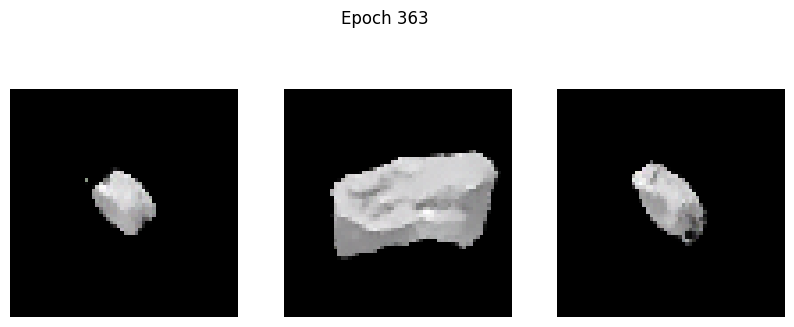

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0270 - g_loss: 4.7797
Epoch 364/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0469 - g_loss: 4.7149

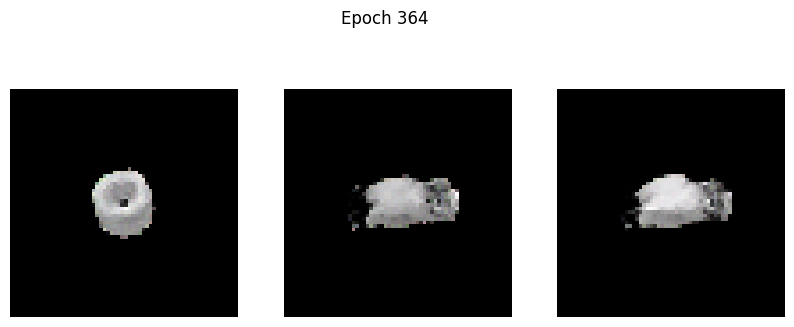

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0472 - g_loss: 4.7156
Epoch 365/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0686 - g_loss: 4.9557

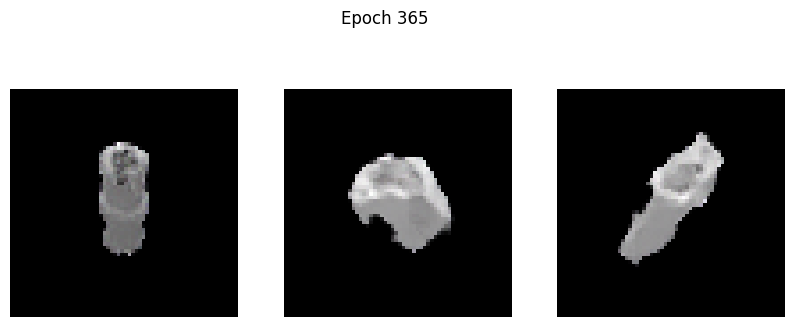

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0684 - g_loss: 4.9539
Epoch 366/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4916 - g_loss: 5.1704

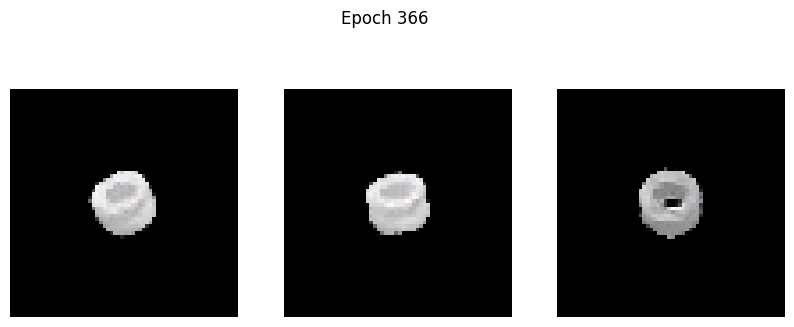

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4890 - g_loss: 5.1659
Epoch 367/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0254 - g_loss: 4.5397

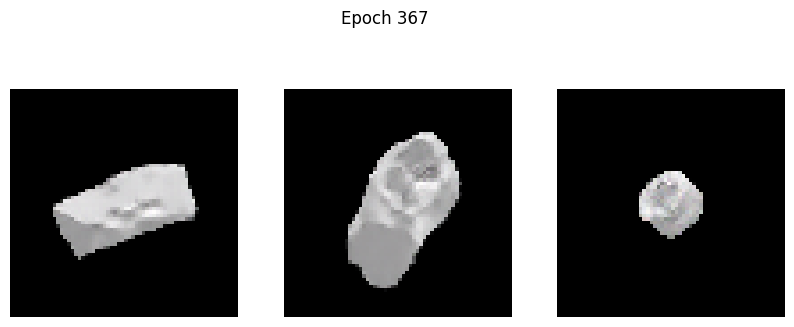

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0254 - g_loss: 4.5393
Epoch 368/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0394 - g_loss: 4.6731

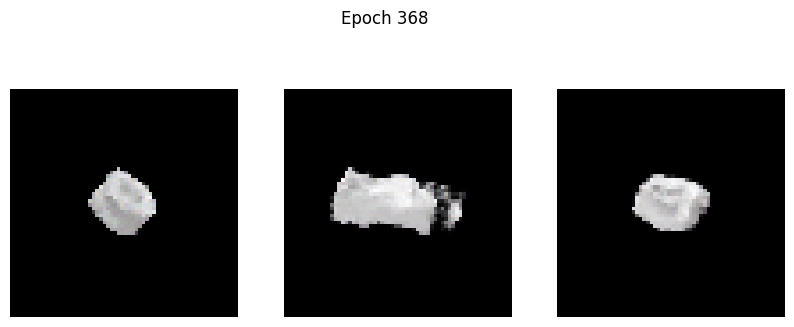

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0394 - g_loss: 4.6722
Epoch 369/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0011 - g_loss: 4.5672    

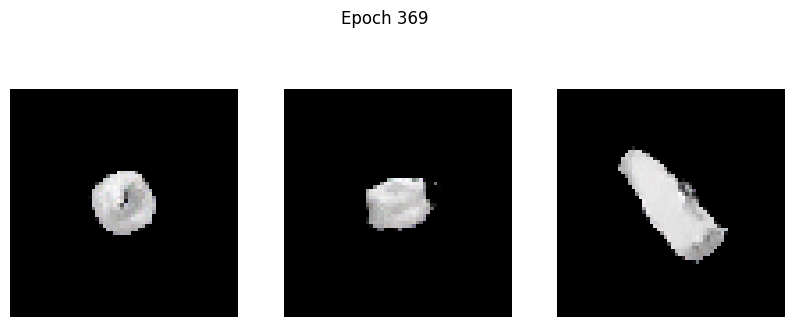

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0013 - g_loss: 4.5672
Epoch 370/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0271 - g_loss: 4.6132

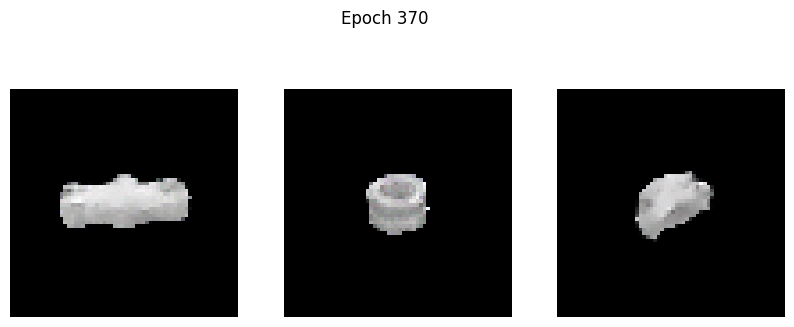

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0270 - g_loss: 4.6133
Epoch 371/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0458 - g_loss: 4.8814

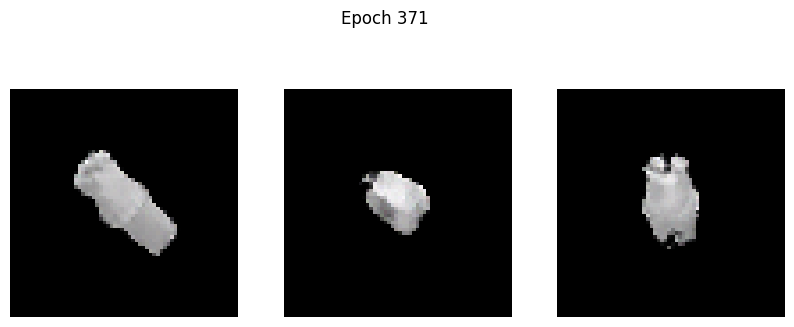

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0462 - g_loss: 4.8823
Epoch 372/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1312 - g_loss: 5.3051

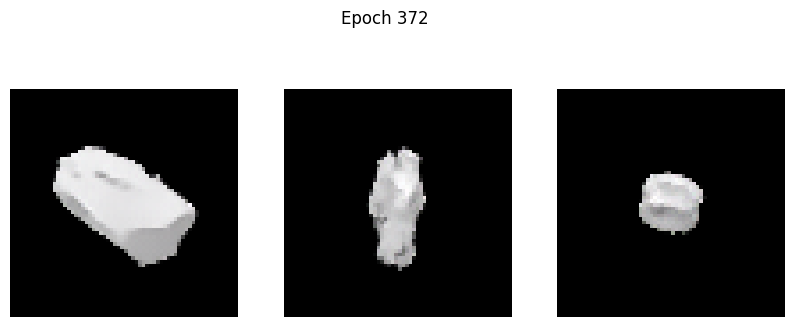

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1306 - g_loss: 5.3007
Epoch 373/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3241 - g_loss: 5.4560

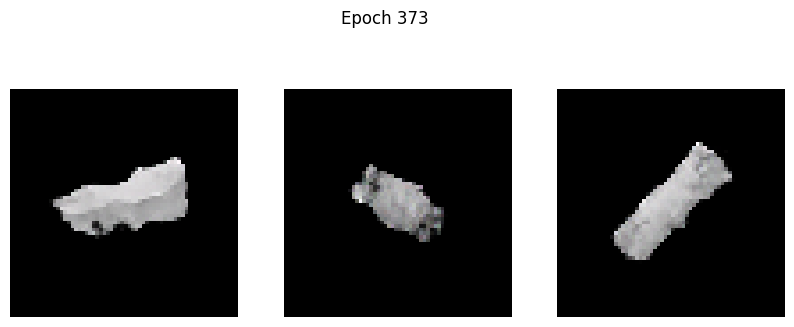

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3253 - g_loss: 5.4592
Epoch 374/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0195 - g_loss: 4.5724

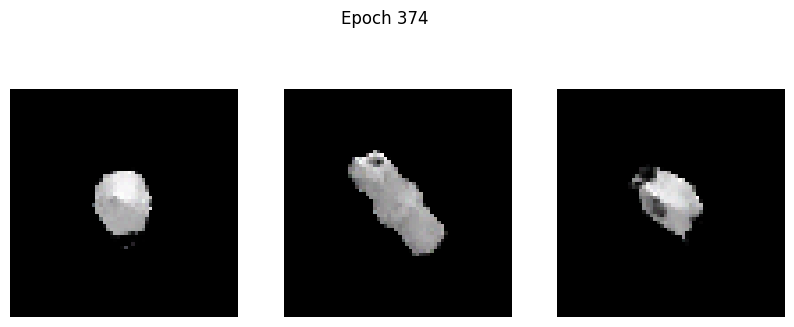

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0195 - g_loss: 4.5717
Epoch 375/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0458 - g_loss: 4.8062

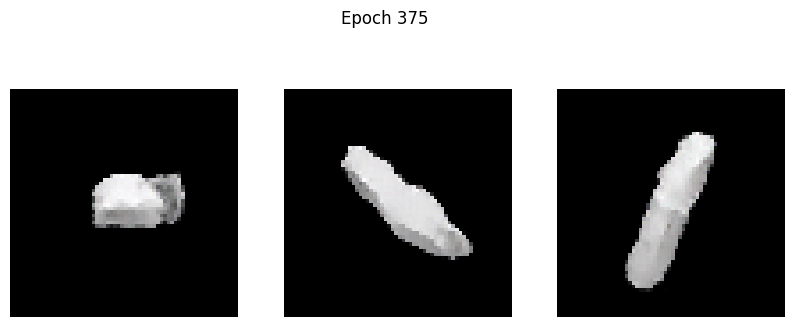

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0456 - g_loss: 4.8038
Epoch 376/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0248 - g_loss: 4.5248

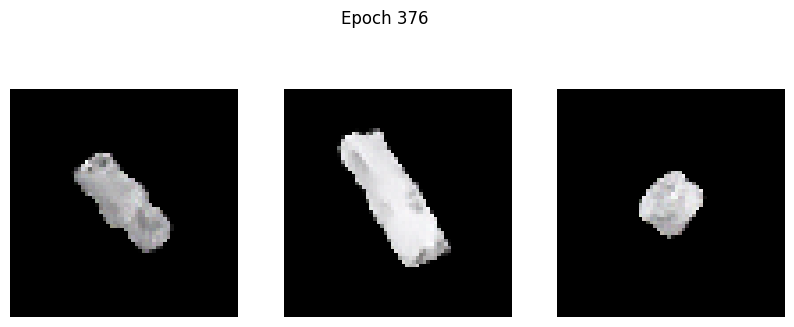

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0248 - g_loss: 4.5251
Epoch 377/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0736 - g_loss: 4.7549

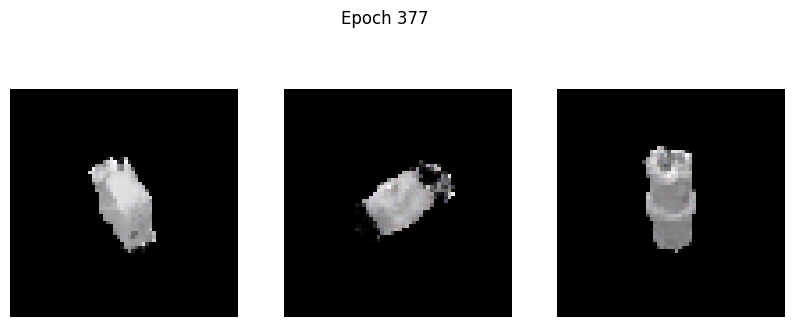

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0734 - g_loss: 4.7543
Epoch 378/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0209 - g_loss: 4.6122

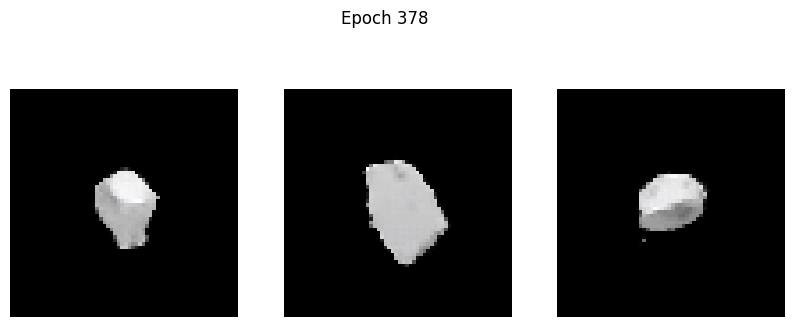

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0210 - g_loss: 4.6126
Epoch 379/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0529 - g_loss: 4.6036

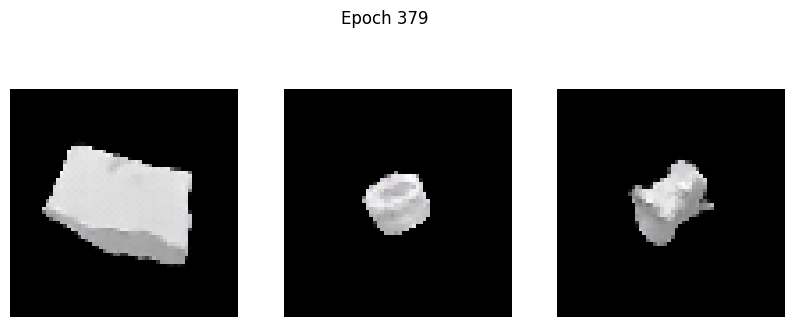

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0530 - g_loss: 4.6060
Epoch 380/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0317 - g_loss: 4.7410

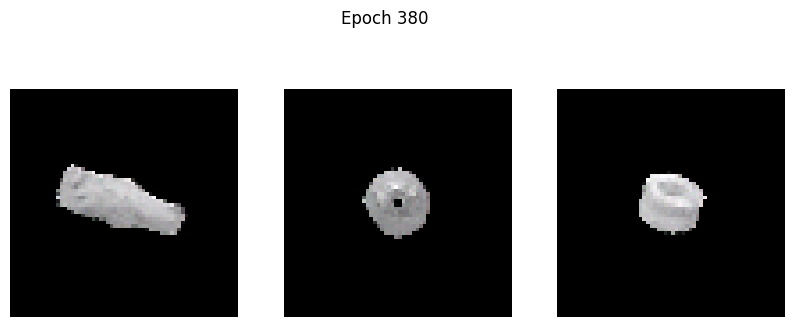

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0318 - g_loss: 4.7410
Epoch 381/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0440 - g_loss: 4.7295

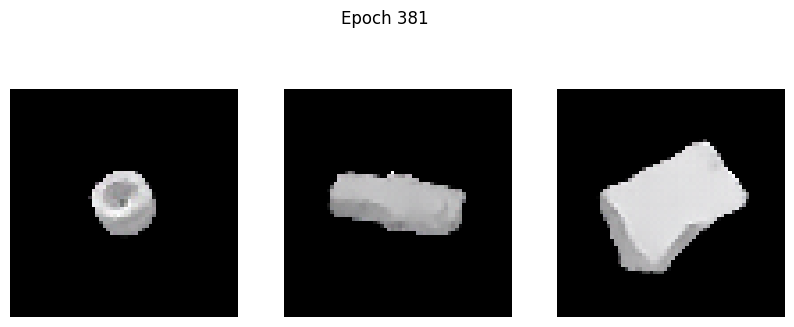

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0441 - g_loss: 4.7310
Epoch 382/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0506 - g_loss: 4.5791

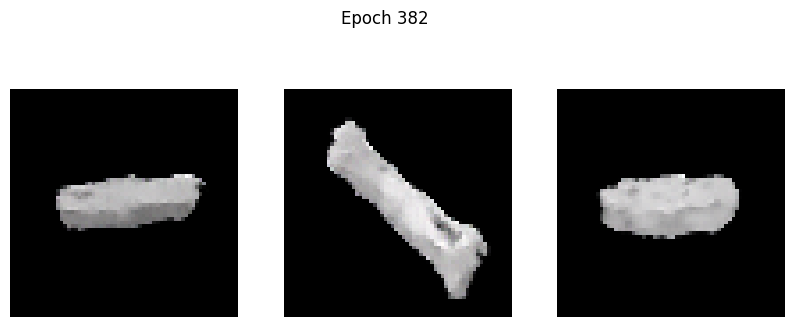

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0505 - g_loss: 4.5800
Epoch 383/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.1079 - g_loss: 4.7821

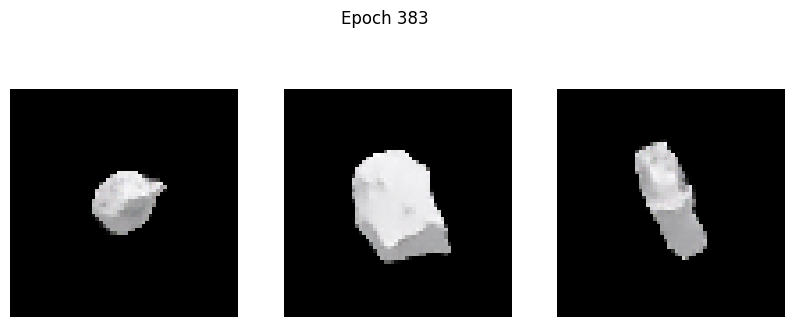

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.1073 - g_loss: 4.7812
Epoch 384/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0504 - g_loss: 4.8223

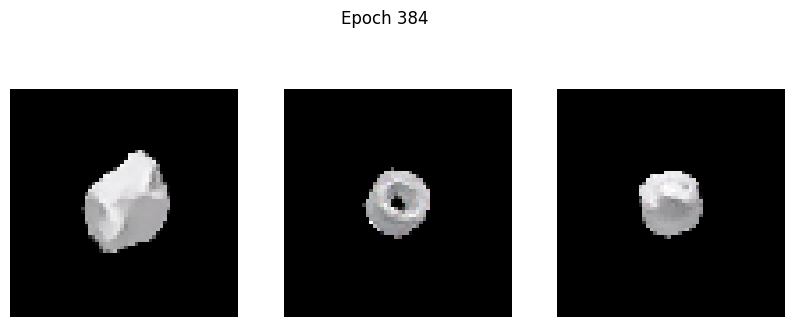

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0506 - g_loss: 4.8238
Epoch 385/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0364 - g_loss: 4.7596

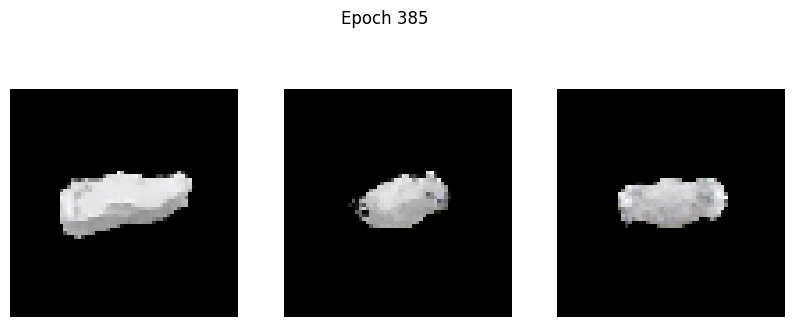

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0363 - g_loss: 4.7591
Epoch 386/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0605 - g_loss: 5.0485

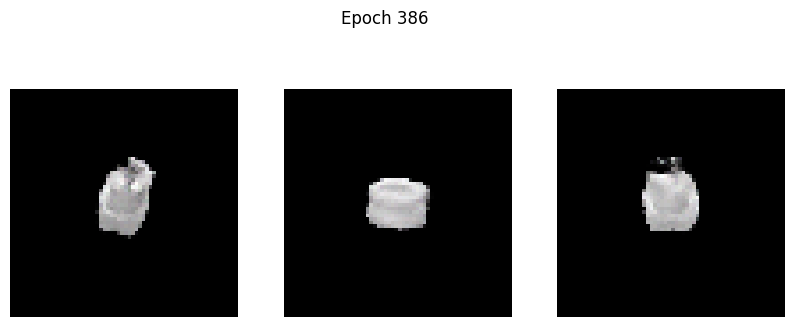

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0604 - g_loss: 5.0478
Epoch 387/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 0.0295 - g_loss: 4.8131

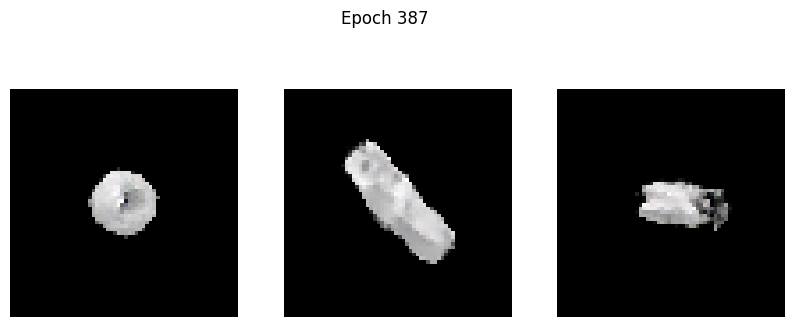

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - d_loss: 0.0297 - g_loss: 4.8144
Epoch 388/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0493 - g_loss: 5.0106

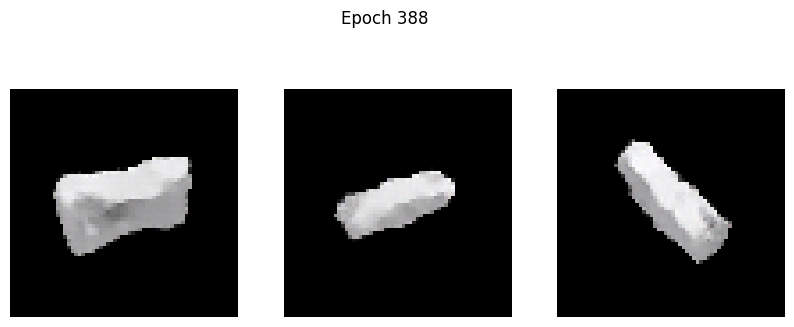

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0493 - g_loss: 5.0110
Epoch 389/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0552 - g_loss: 5.0542

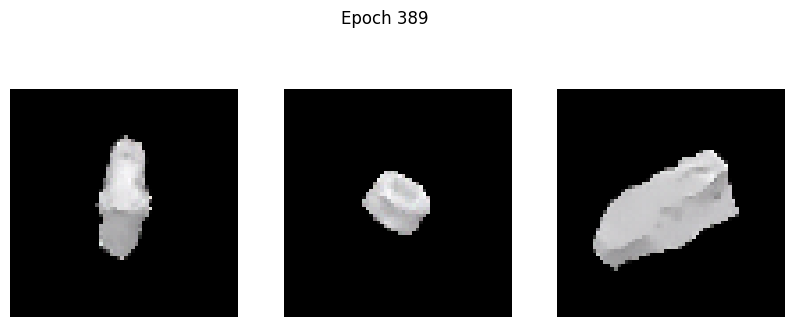

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0553 - g_loss: 5.0534
Epoch 390/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0064 - g_loss: 4.6594

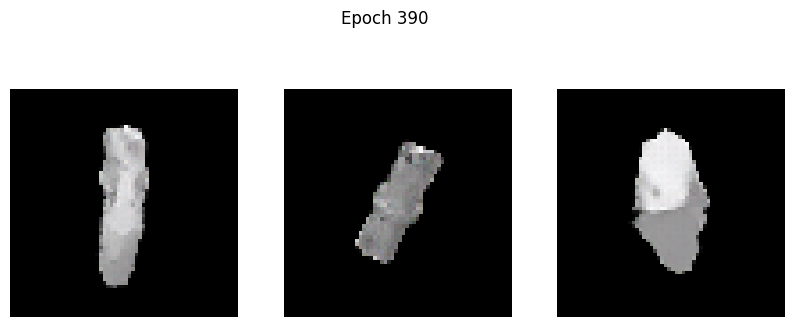

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0067 - g_loss: 4.6609
Epoch 391/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 1.2655 - g_loss: 7.5804

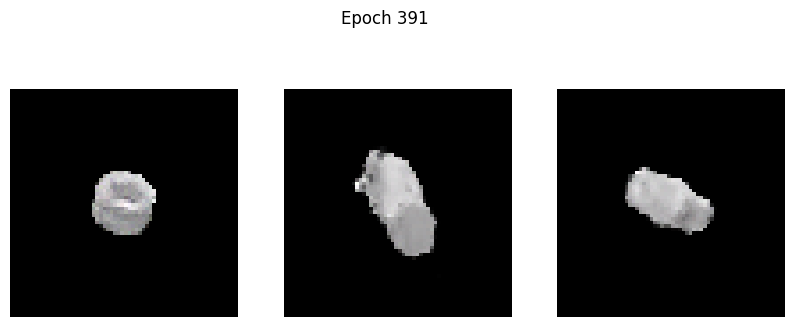

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 1.2583 - g_loss: 7.5613
Epoch 392/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0093 - g_loss: 4.5544

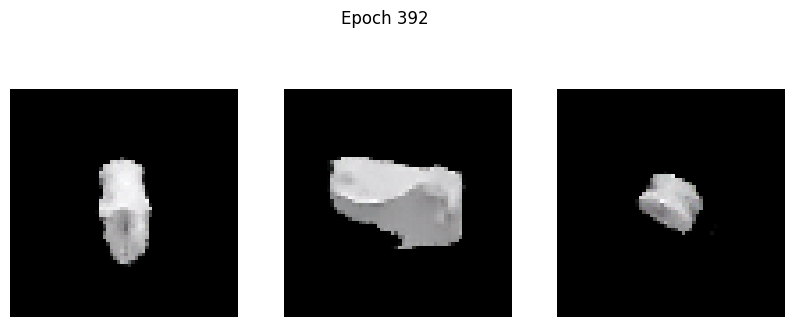

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0095 - g_loss: 4.5550
Epoch 393/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0187 - g_loss: 4.5601

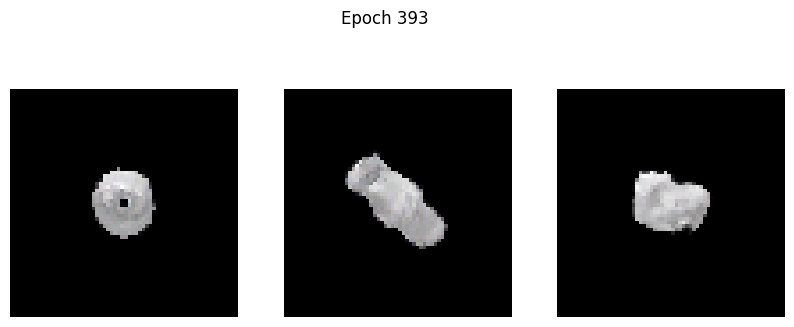

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0186 - g_loss: 4.5593
Epoch 394/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0098 - g_loss: 4.4819

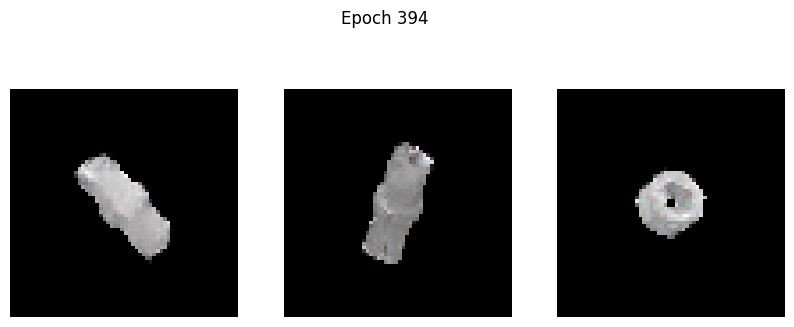

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0098 - g_loss: 4.4825
Epoch 395/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0047 - g_loss: 4.7011

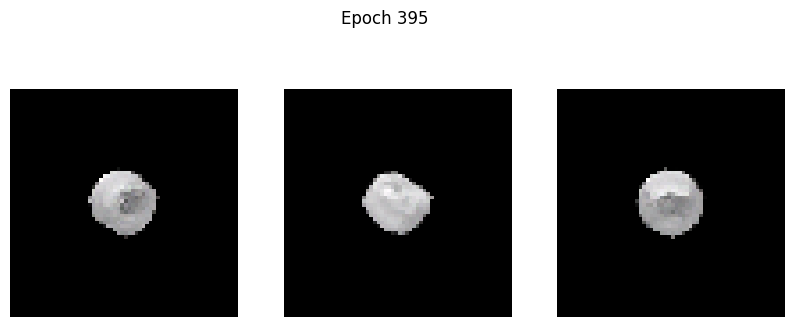

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0048 - g_loss: 4.7011
Epoch 396/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0125 - g_loss: 4.6582

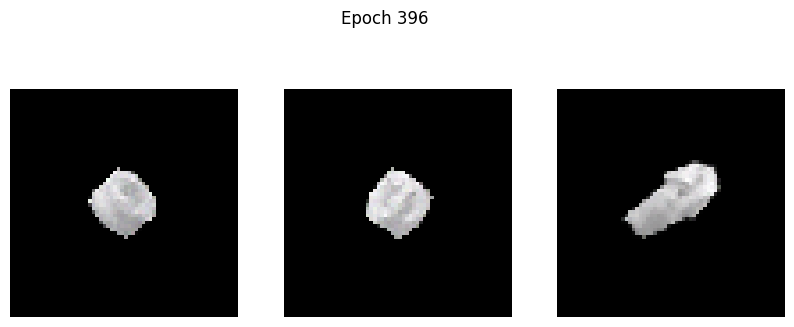

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0125 - g_loss: 4.6583
Epoch 397/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0072 - g_loss: 4.7525

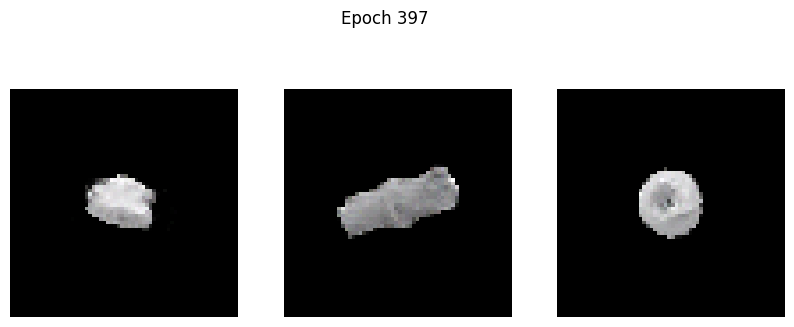

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0072 - g_loss: 4.7536
Epoch 398/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.1129 - g_loss: 5.0414

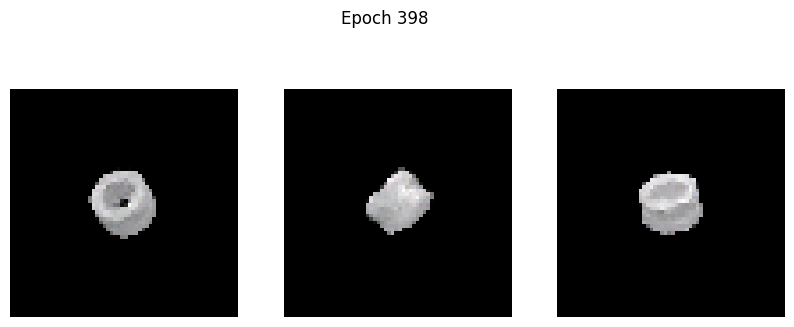

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.1126 - g_loss: 5.0399
Epoch 399/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0072 - g_loss: 4.6528

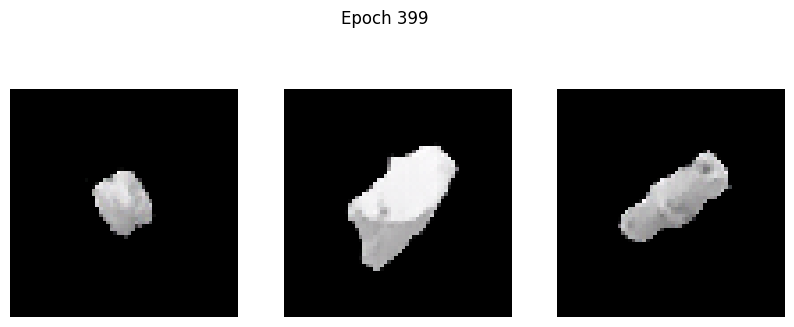

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0073 - g_loss: 4.6539
Epoch 400/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0405 - g_loss: 5.1661

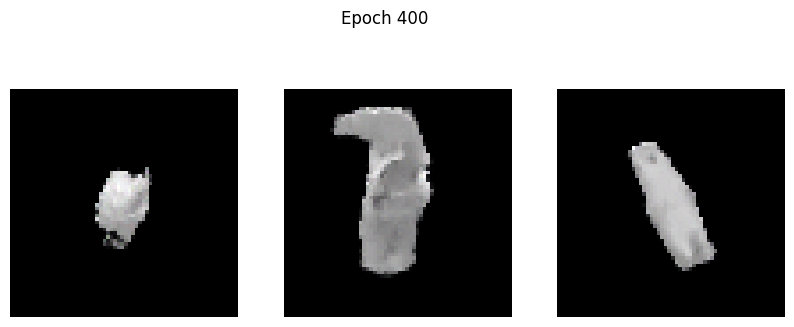

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0405 - g_loss: 5.1639
Epoch 401/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0115 - g_loss: 4.8626

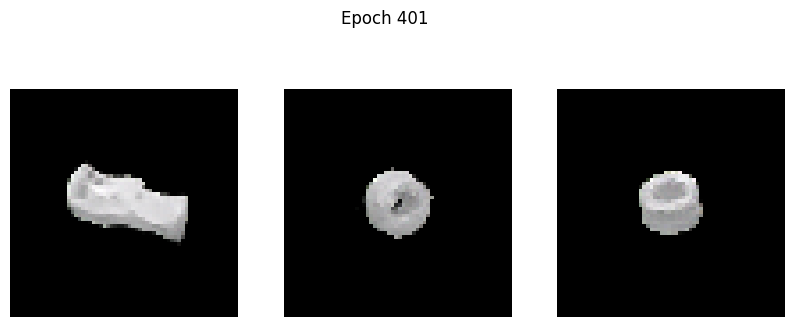

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0119 - g_loss: 4.8649
Epoch 402/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0287 - g_loss: 4.7576

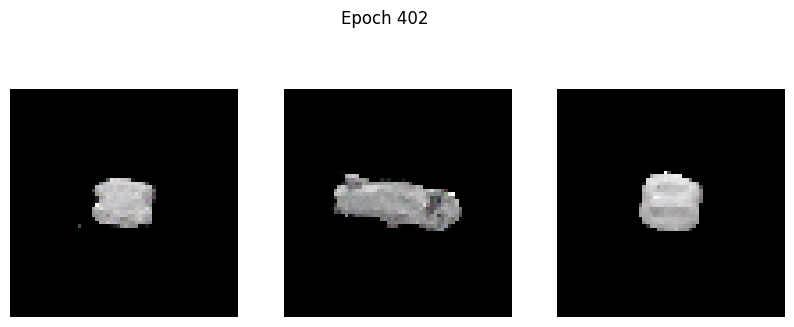

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0287 - g_loss: 4.7585
Epoch 403/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0364 - g_loss: 4.9776

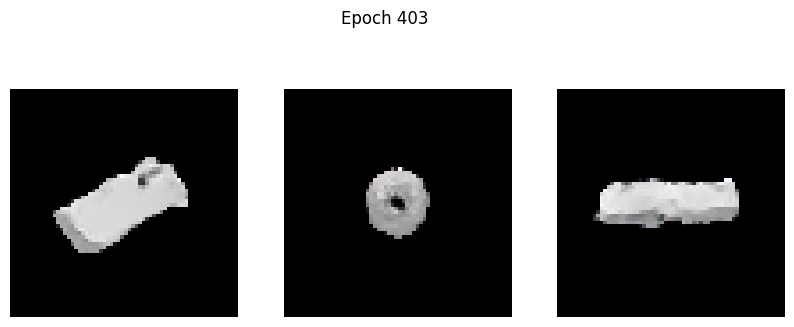

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0365 - g_loss: 4.9776
Epoch 404/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0494 - g_loss: 5.0783

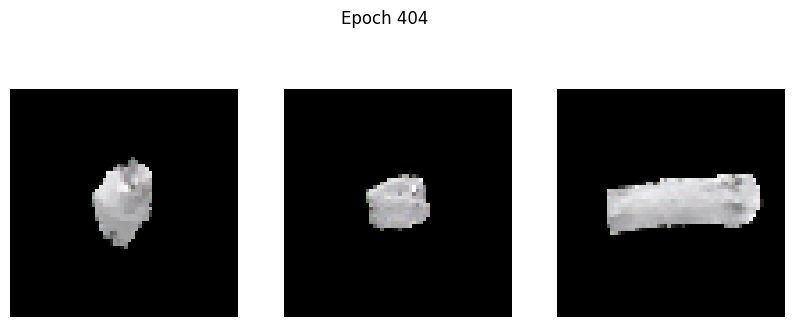

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0493 - g_loss: 5.0774
Epoch 405/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0166 - g_loss: 4.8833

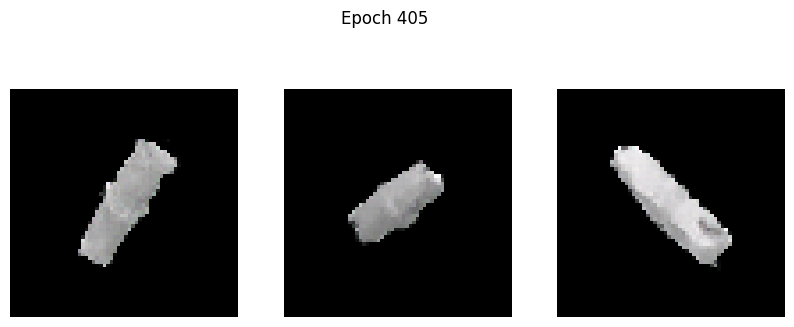

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0173 - g_loss: 4.8859
Epoch 406/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0725 - g_loss: 4.9564

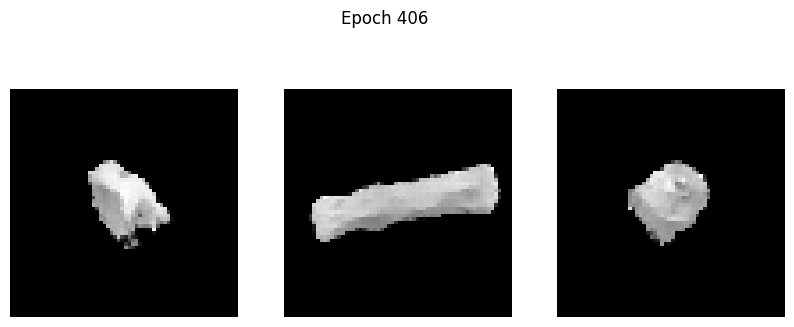

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0722 - g_loss: 4.9551
Epoch 407/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0453 - g_loss: 5.0295

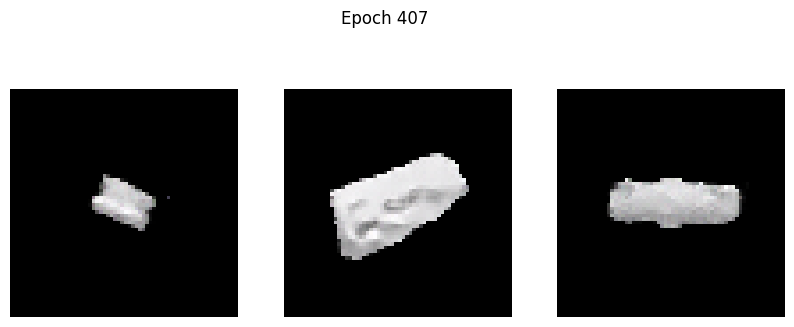

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0452 - g_loss: 5.0290
Epoch 408/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0144 - g_loss: 4.7166

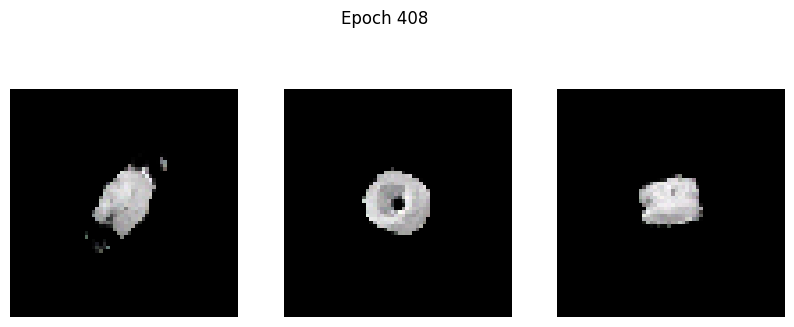

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0142 - g_loss: 4.7182
Epoch 409/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0423 - g_loss: 5.1432

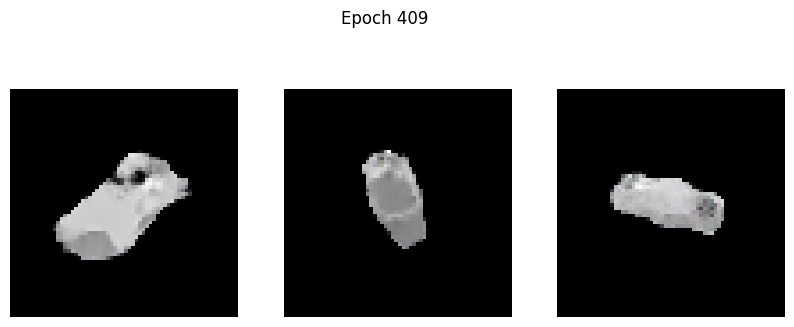

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0423 - g_loss: 5.1427
Epoch 410/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0407 - g_loss: 5.3433

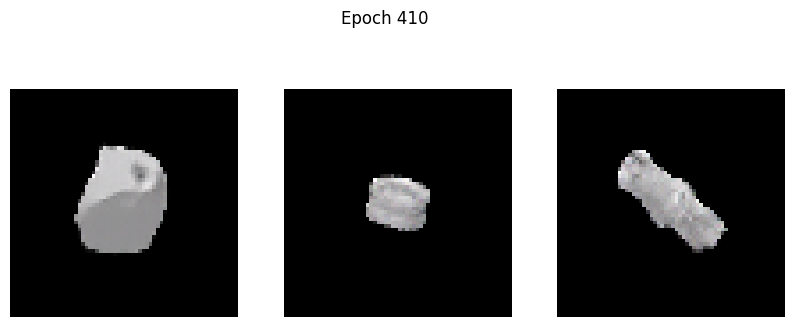

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0405 - g_loss: 5.3400
Epoch 411/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0034 - g_loss: 4.8800

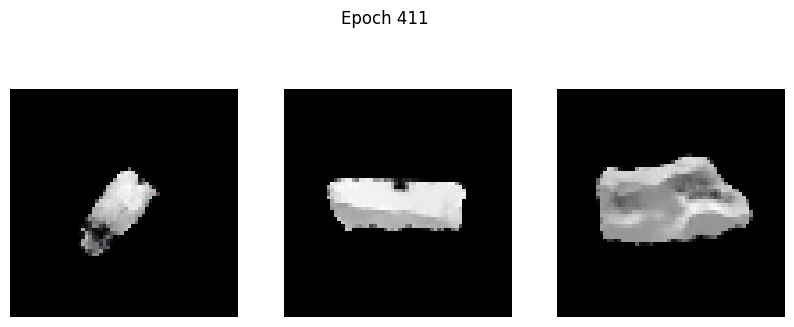

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0034 - g_loss: 4.8798
Epoch 412/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0128 - g_loss: 5.0408

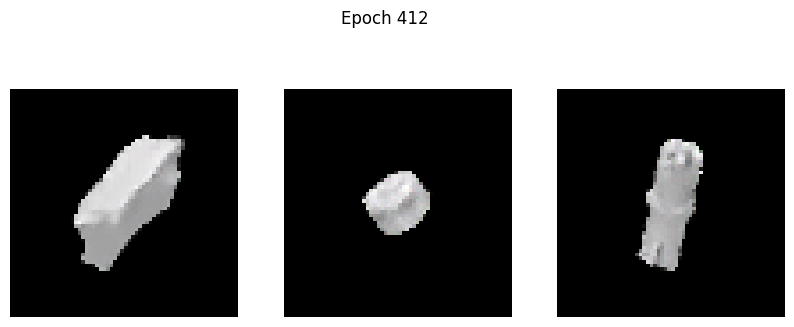

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0135 - g_loss: 5.0431
Epoch 413/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0260 - g_loss: 4.8478

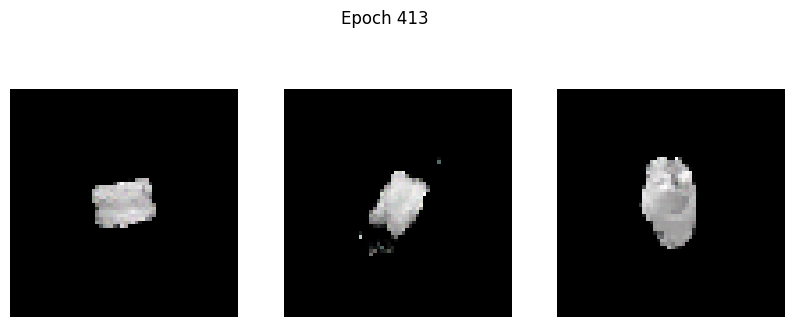

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0262 - g_loss: 4.8496
Epoch 414/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0399 - g_loss: 5.2632

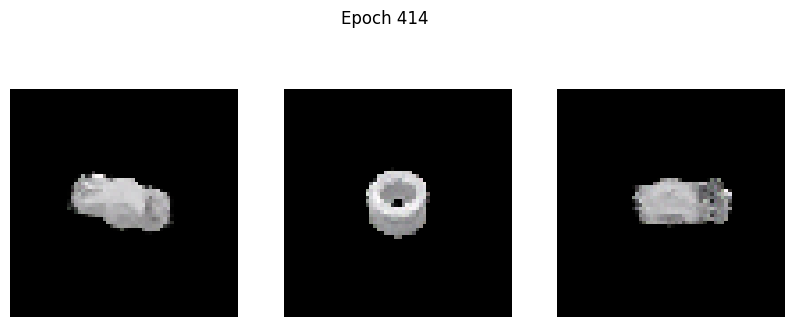

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0398 - g_loss: 5.2624
Epoch 415/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0359 - g_loss: 5.0687

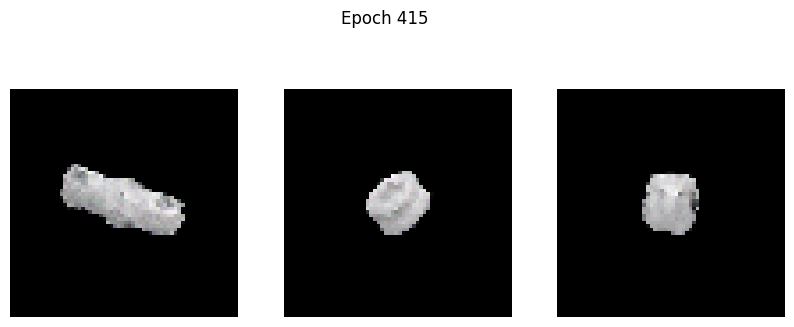

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0356 - g_loss: 5.0690
Epoch 416/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0221 - g_loss: 4.9516

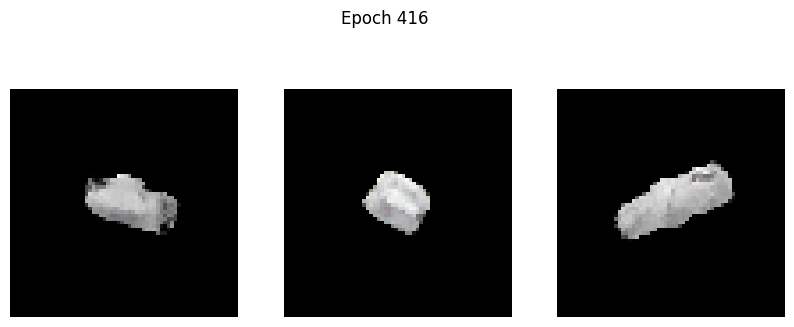

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0220 - g_loss: 4.9510
Epoch 417/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0137 - g_loss: 5.2681

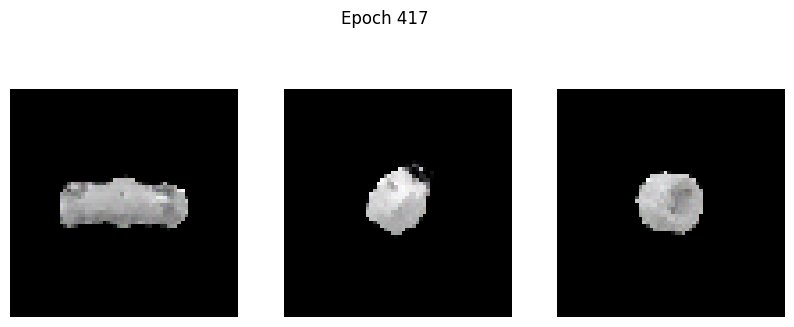

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0136 - g_loss: 5.2674
Epoch 418/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0834 - g_loss: 5.6436

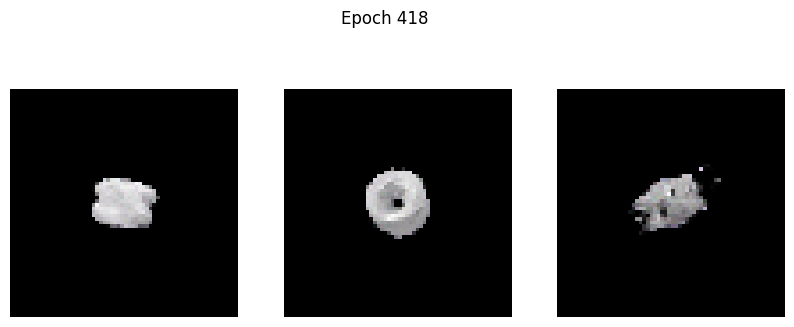

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0831 - g_loss: 5.6412
Epoch 419/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0240 - g_loss: 4.8117

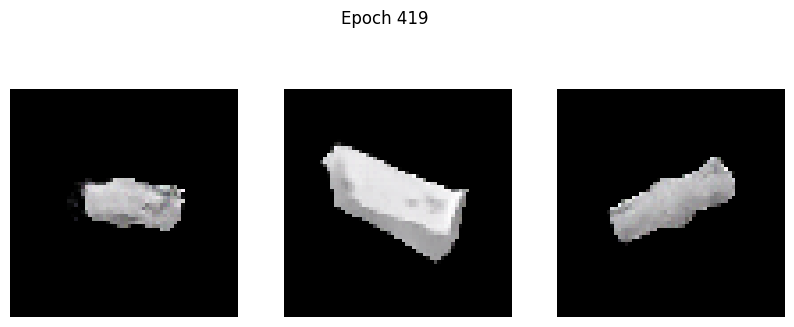

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0242 - g_loss: 4.8129
Epoch 420/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0128 - g_loss: 5.0376

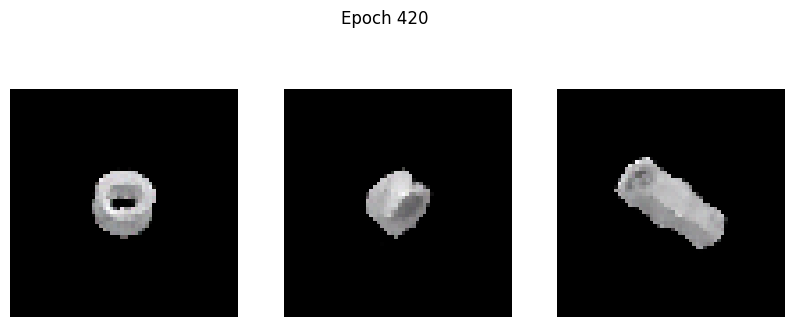

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0127 - g_loss: 5.0387
Epoch 421/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0472 - g_loss: 5.5386

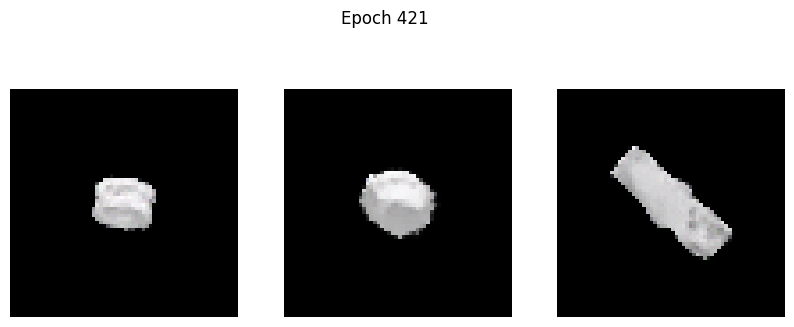

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0472 - g_loss: 5.5367
Epoch 422/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0255 - g_loss: 5.4163

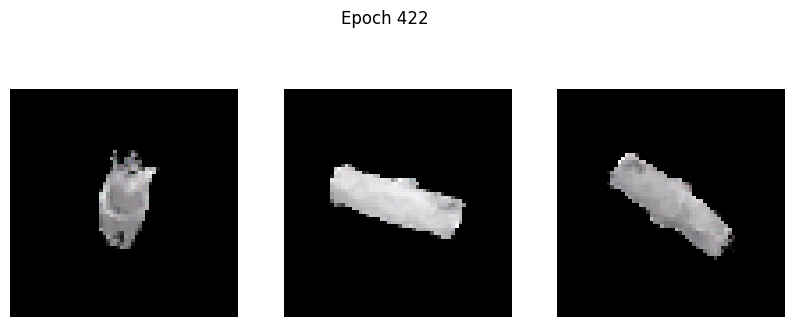

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0256 - g_loss: 5.4155
Epoch 423/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0760 - g_loss: 5.4787

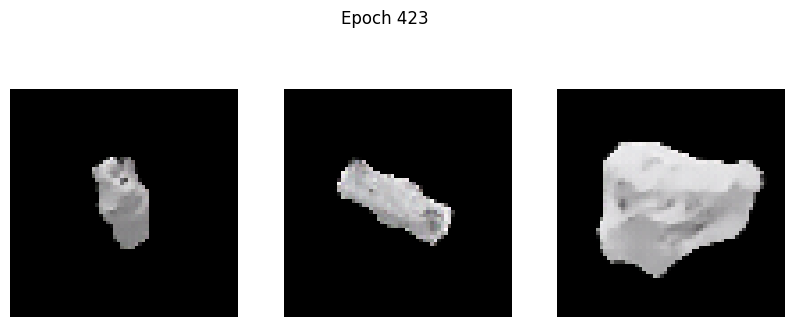

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0762 - g_loss: 5.4799
Epoch 424/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0222 - g_loss: 5.1831

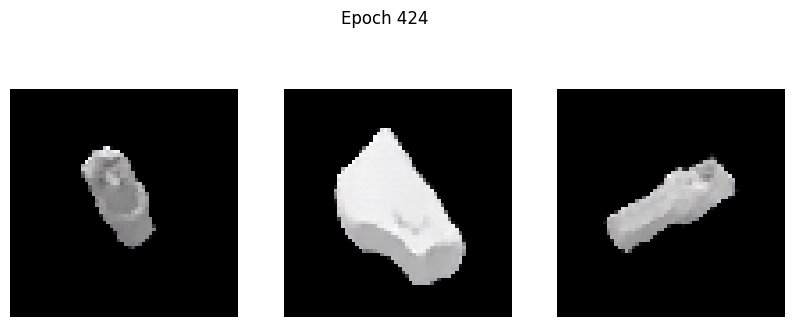

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0222 - g_loss: 5.1841
Epoch 425/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0040 - g_loss: 5.1155

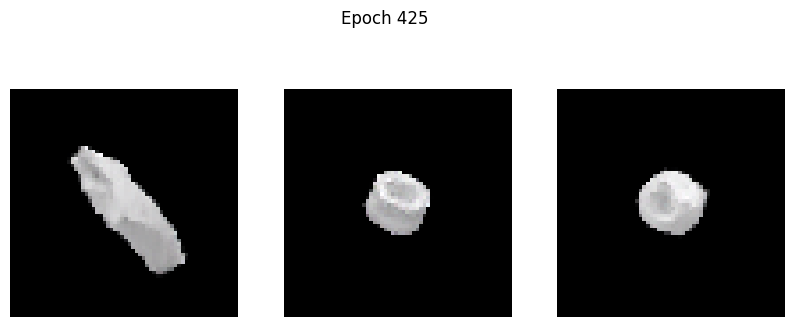

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0038 - g_loss: 5.1147
Epoch 426/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0238 - g_loss: 5.0635

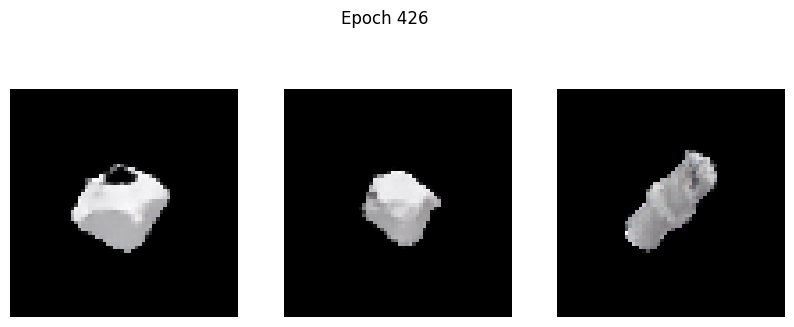

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0235 - g_loss: 5.0649
Epoch 427/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0237 - g_loss: 5.0849

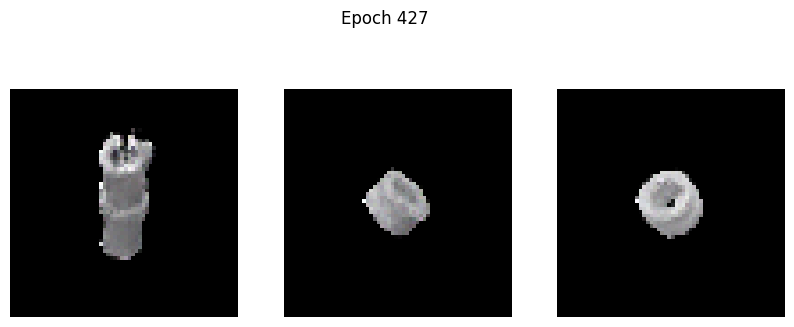

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0237 - g_loss: 5.0857
Epoch 428/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.1042 - g_loss: 5.4121

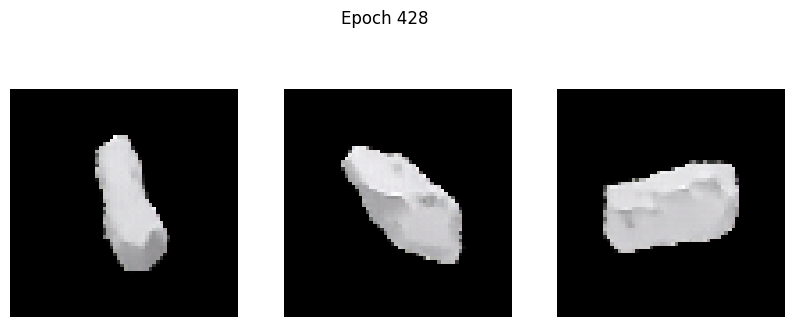

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.1040 - g_loss: 5.4107
Epoch 429/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0218 - g_loss: 5.3270

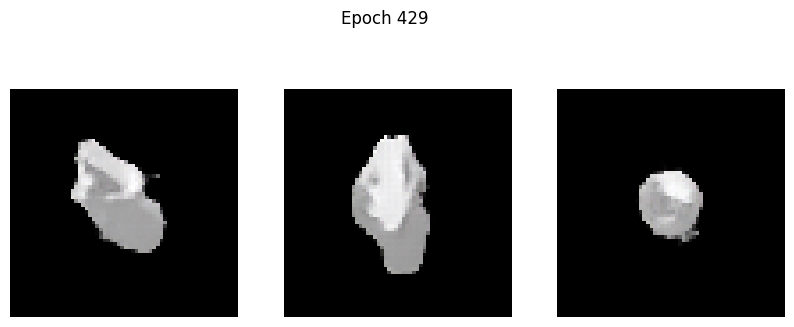

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0217 - g_loss: 5.3267
Epoch 430/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0489 - g_loss: 5.2703

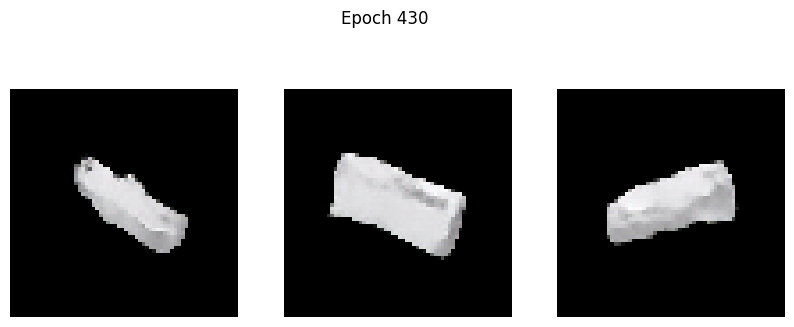

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0485 - g_loss: 5.2688
Epoch 431/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0408 - g_loss: 5.0791

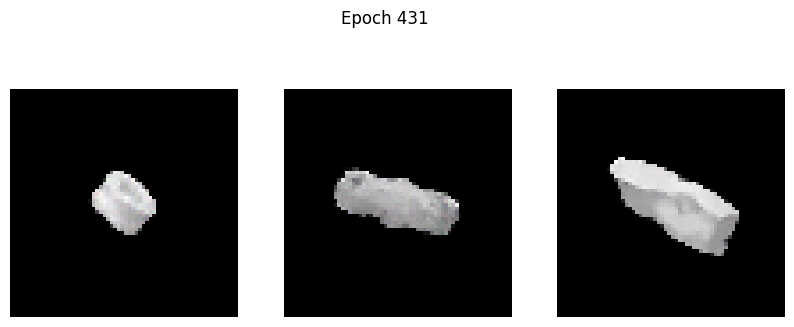

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0404 - g_loss: 5.0812
Epoch 432/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0330 - g_loss: 4.8928

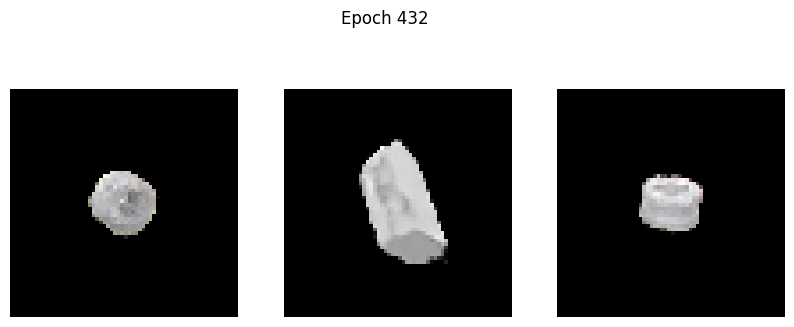

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0328 - g_loss: 4.8950
Epoch 433/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.0033 - g_loss: 5.2205

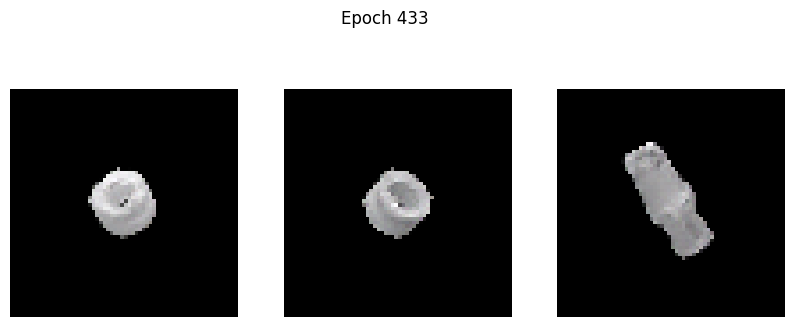

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.0031 - g_loss: 5.2202
Epoch 434/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0339 - g_loss: 5.1527

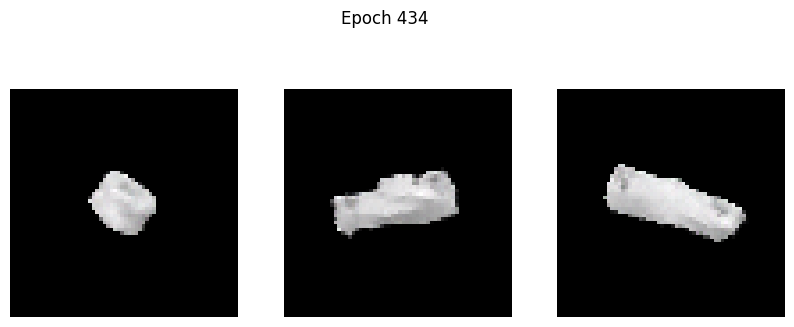

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: -0.0335 - g_loss: 5.1549
Epoch 435/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 1.9002 - g_loss: 9.4046

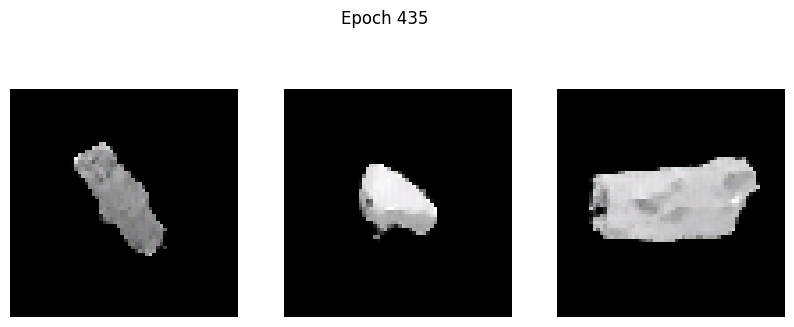

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 1.8905 - g_loss: 9.3792
Epoch 436/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0084 - g_loss: 4.7240

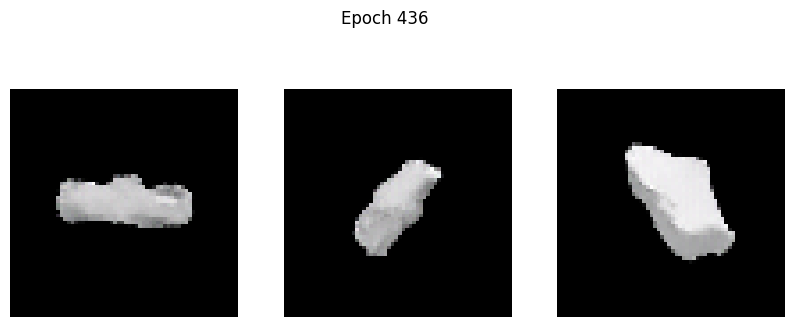

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0084 - g_loss: 4.7234
Epoch 437/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0083 - g_loss: 4.7547

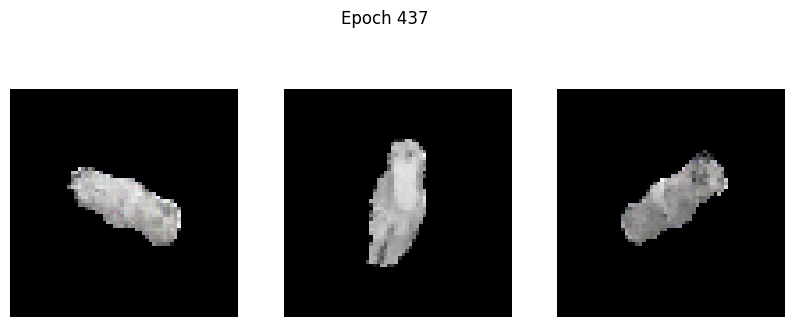

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0082 - g_loss: 4.7554
Epoch 438/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0020 - g_loss: 4.9295

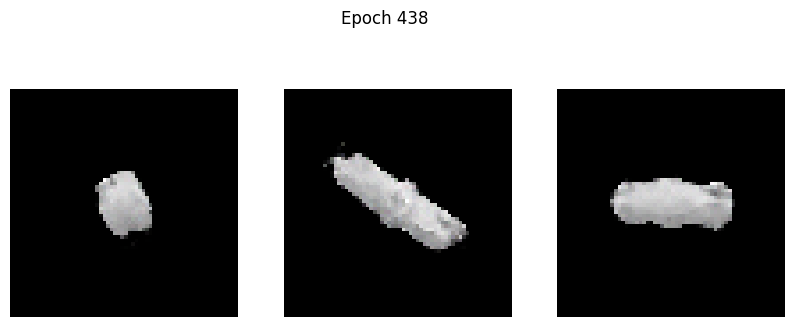

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0018 - g_loss: 4.9287
Epoch 439/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0441 - g_loss: 4.9763

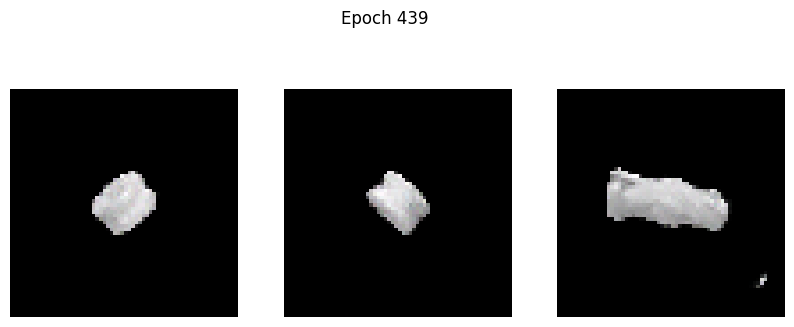

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0440 - g_loss: 4.9757
Epoch 440/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0480 - g_loss: 5.2488

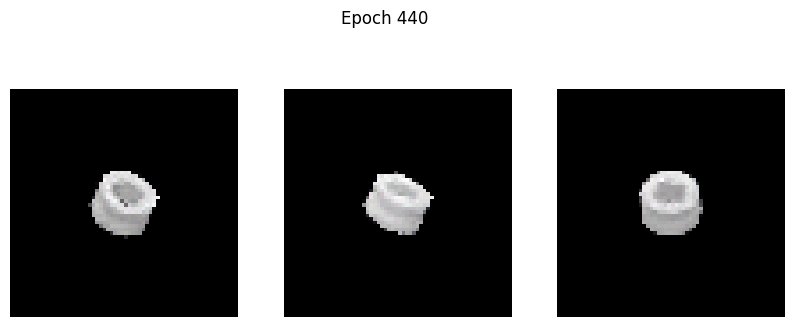

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0476 - g_loss: 5.2471
Epoch 441/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0028 - g_loss: 5.0591

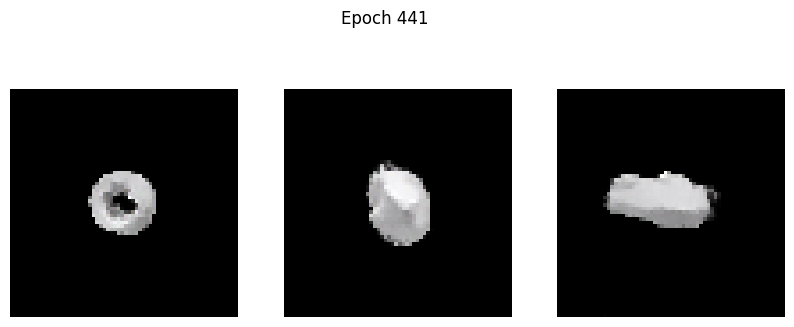

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0028 - g_loss: 5.0590
Epoch 442/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0547 - g_loss: 4.8599

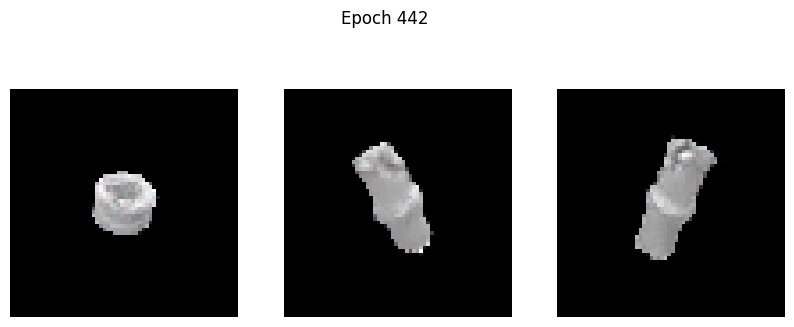

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0545 - g_loss: 4.8620
Epoch 443/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0539 - g_loss: 4.9512

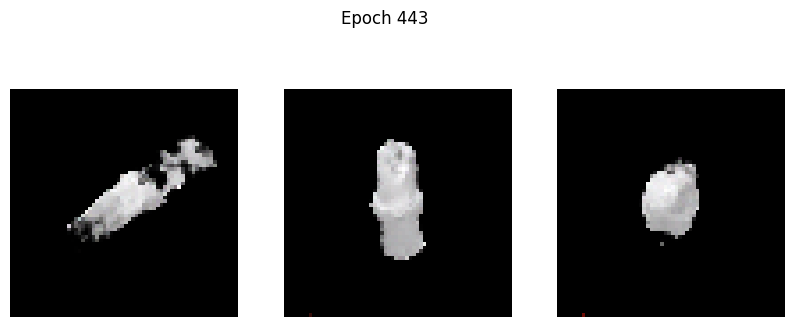

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0540 - g_loss: 4.9499
Epoch 444/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0159 - g_loss: 5.2101

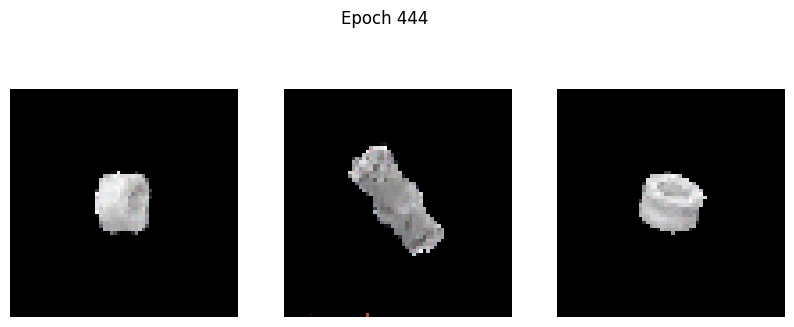

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0160 - g_loss: 5.2129
Epoch 445/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0211 - g_loss: 5.5868

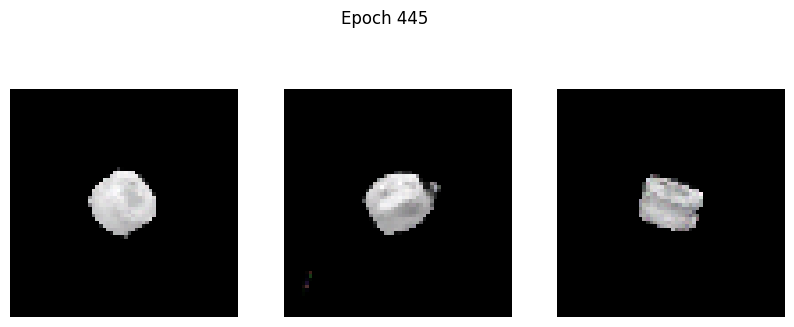

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0212 - g_loss: 5.5874
Epoch 446/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0393 - g_loss: 5.0291

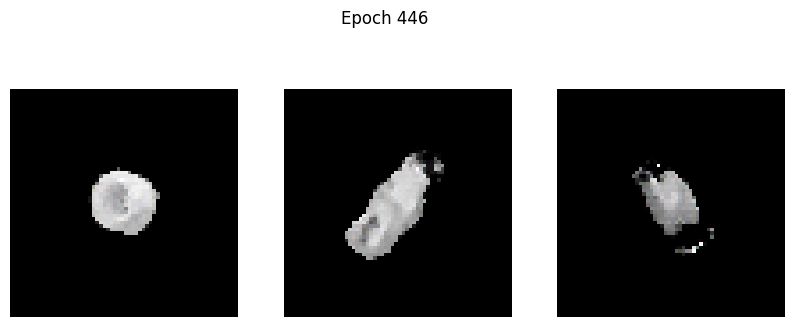

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0394 - g_loss: 5.0283
Epoch 447/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0332 - g_loss: 5.4612

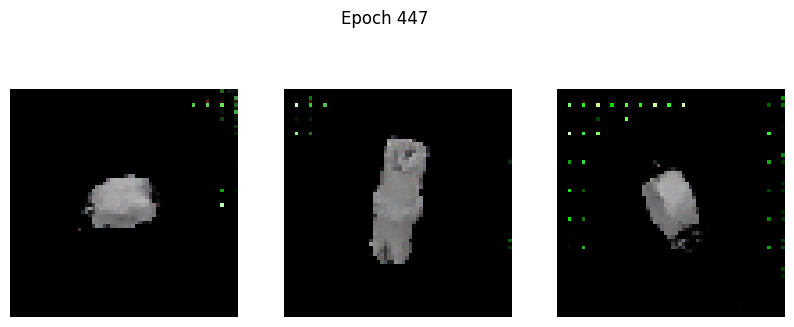

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0332 - g_loss: 5.4594
Epoch 448/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0061 - g_loss: 5.3856

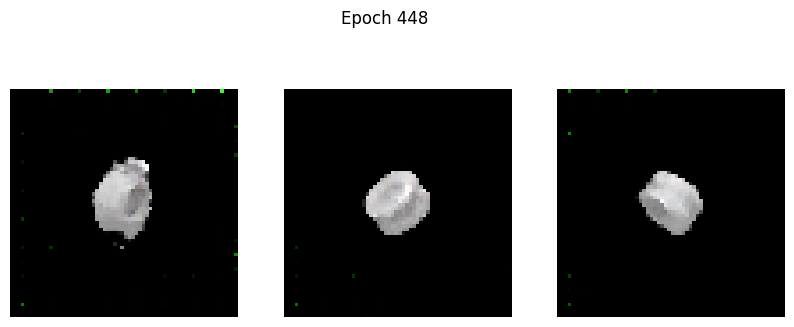

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0060 - g_loss: 5.3843
Epoch 449/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0459 - g_loss: 5.0966

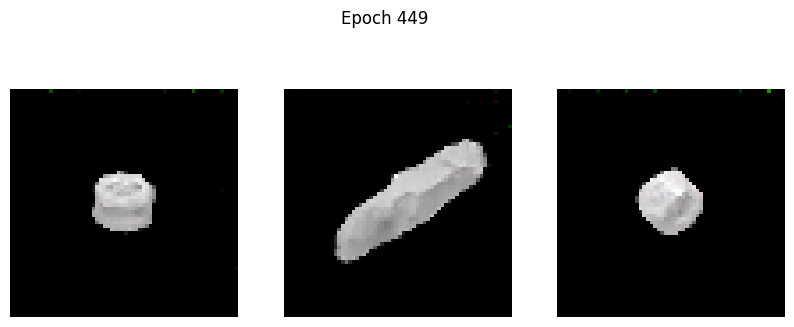

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0456 - g_loss: 5.0992
Epoch 450/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0213 - g_loss: 5.4984

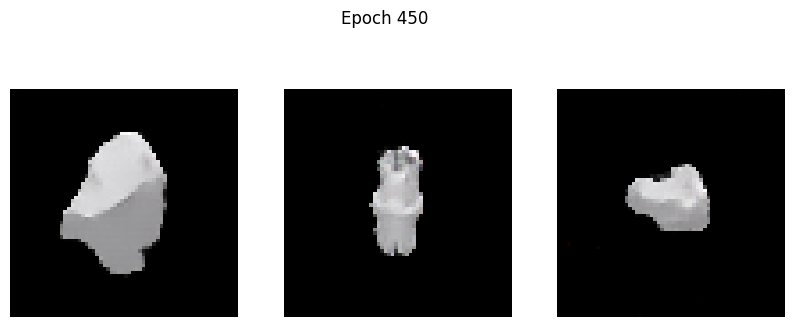

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0212 - g_loss: 5.5000
Epoch 451/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0150 - g_loss: 5.7004

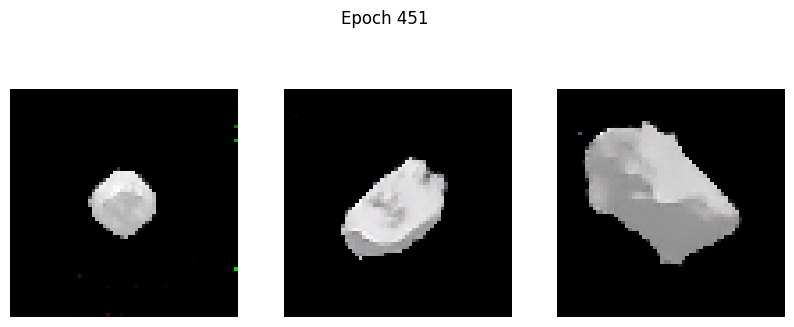

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0148 - g_loss: 5.6984
Epoch 452/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0422 - g_loss: 5.1486

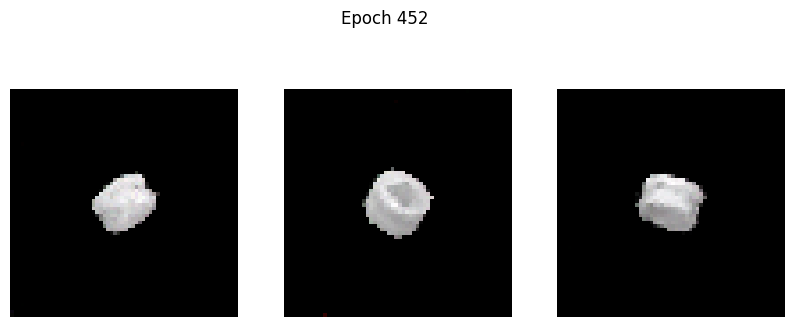

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0418 - g_loss: 5.1514
Epoch 453/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0632 - g_loss: 5.8502

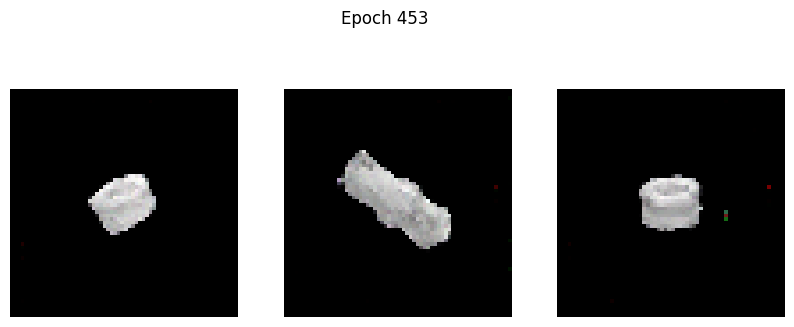

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0627 - g_loss: 5.8462
Epoch 454/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0294 - g_loss: 5.7384

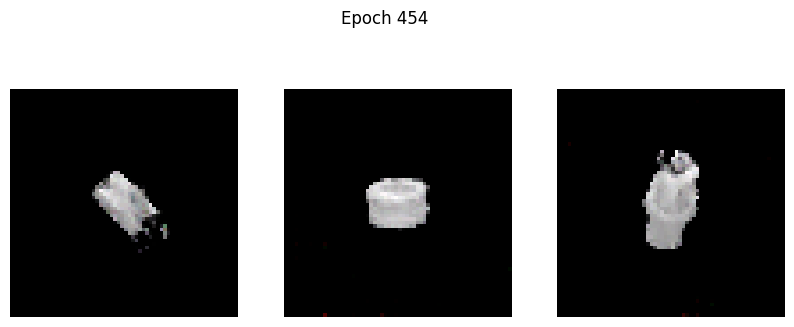

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0293 - g_loss: 5.7374
Epoch 455/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0168 - g_loss: 5.5558

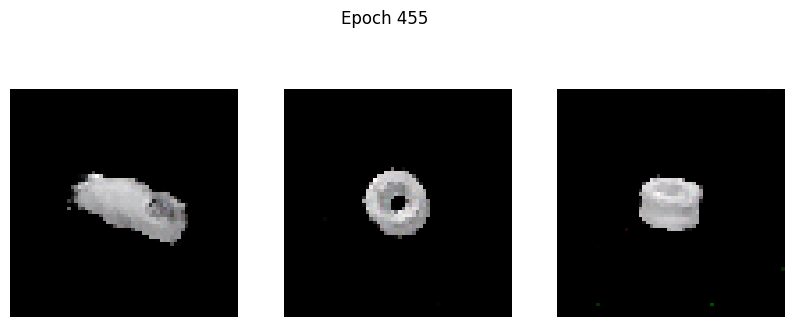

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0168 - g_loss: 5.5561
Epoch 456/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 6.0558e-05 - g_loss: 5.8339

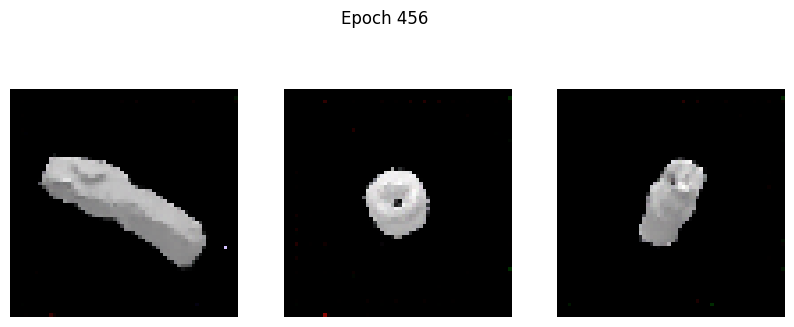

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 6.2358e-05 - g_loss: 5.8329
Epoch 457/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0151 - g_loss: 5.8497

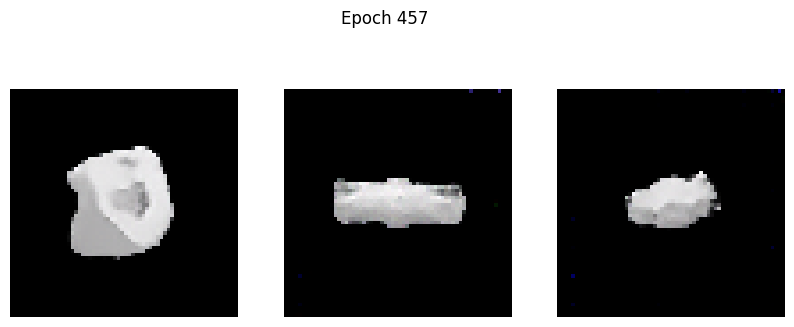

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0152 - g_loss: 5.8475
Epoch 458/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0115 - g_loss: 5.7901

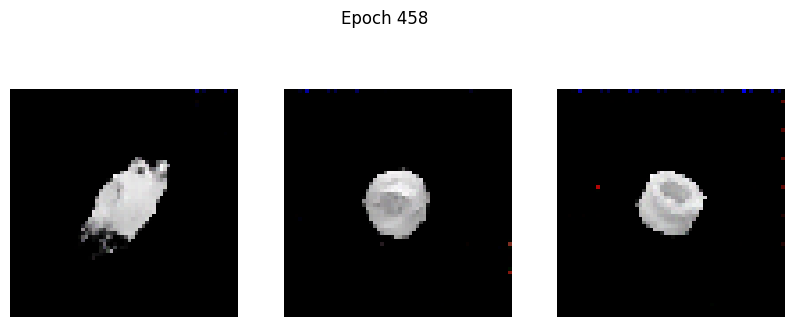

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0112 - g_loss: 5.7872
Epoch 459/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0061 - g_loss: 5.5734

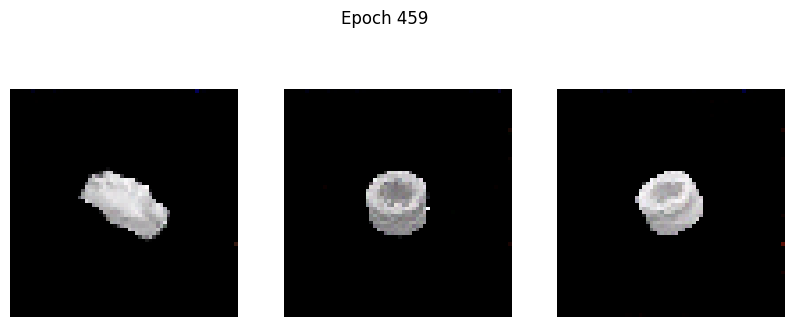

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0059 - g_loss: 5.5734
Epoch 460/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0074 - g_loss: 5.6602

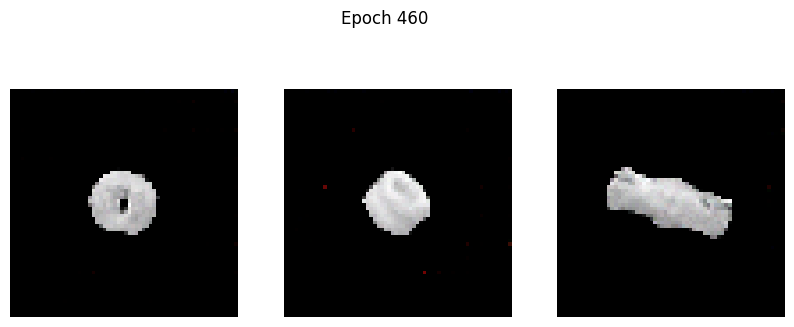

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0074 - g_loss: 5.6596
Epoch 461/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0162 - g_loss: 6.0446

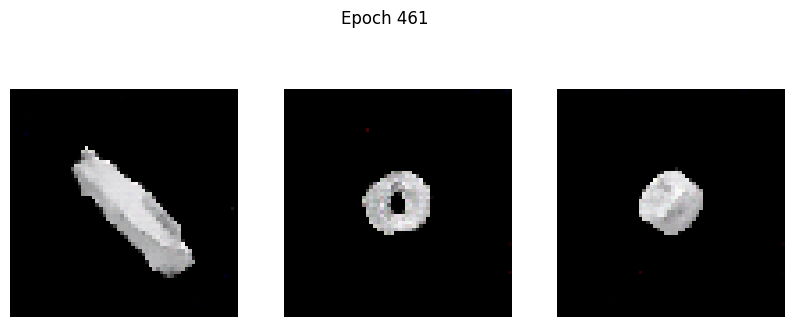

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0160 - g_loss: 6.0425
Epoch 462/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0212 - g_loss: 5.6303

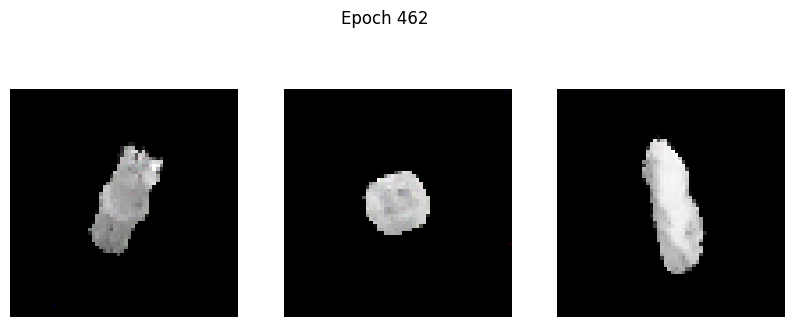

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0207 - g_loss: 5.6279
Epoch 463/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0314 - g_loss: 5.6651

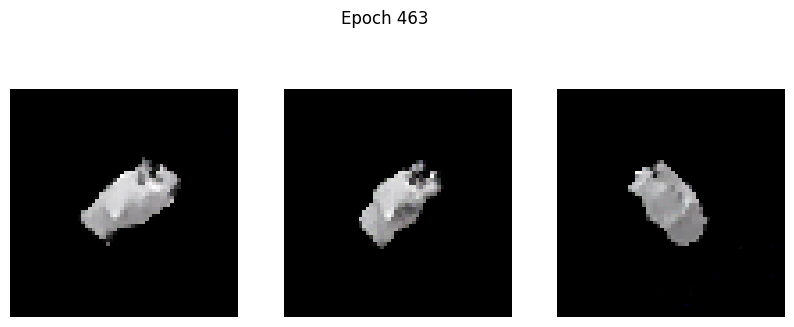

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0312 - g_loss: 5.6657
Epoch 464/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0258 - g_loss: 5.4162

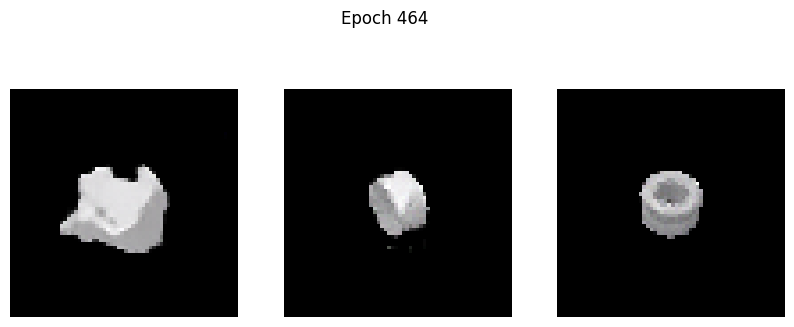

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0258 - g_loss: 5.4175
Epoch 465/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 4.0558e-04 - g_loss: 5.7435

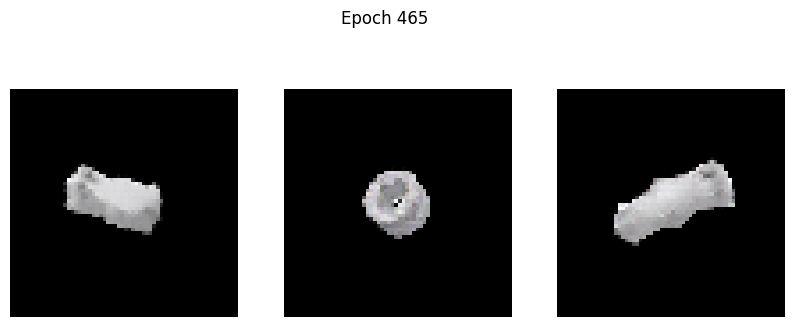

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 1.2287e-05 - g_loss: 5.7420
Epoch 466/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0397 - g_loss: 5.3751

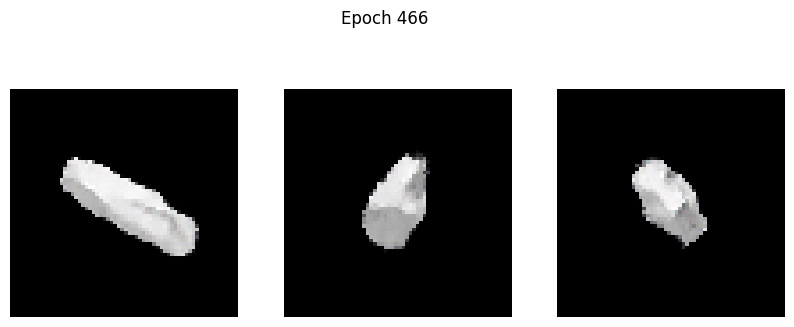

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0400 - g_loss: 5.3758
Epoch 467/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0135 - g_loss: 5.9084

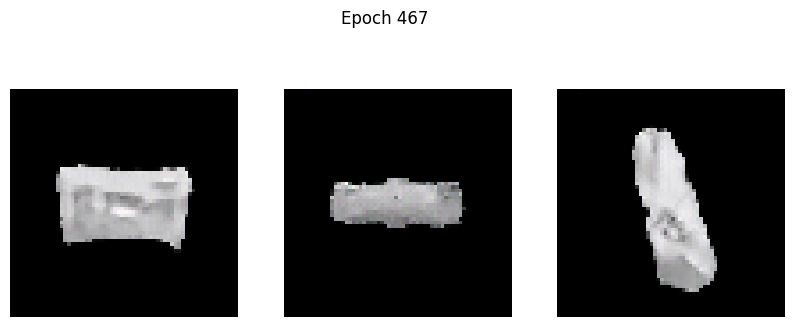

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0134 - g_loss: 5.9087
Epoch 468/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0245 - g_loss: 6.0183

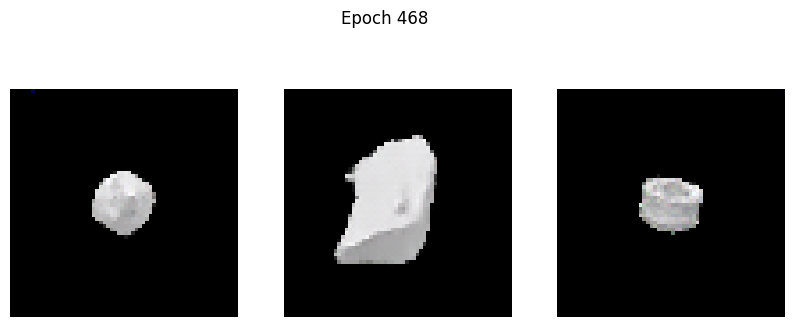

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0243 - g_loss: 6.0163
Epoch 469/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0527 - g_loss: 5.5525

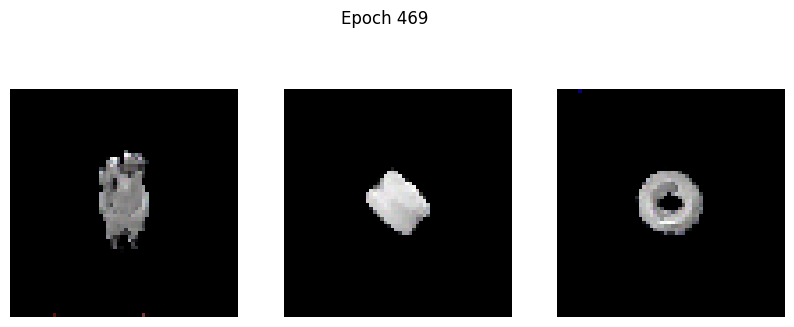

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0524 - g_loss: 5.5548
Epoch 470/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0327 - g_loss: 5.5920

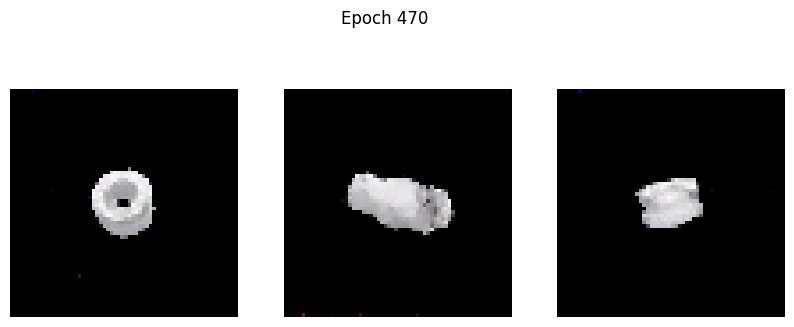

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0330 - g_loss: 5.5906
Epoch 471/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0573 - g_loss: 5.4762

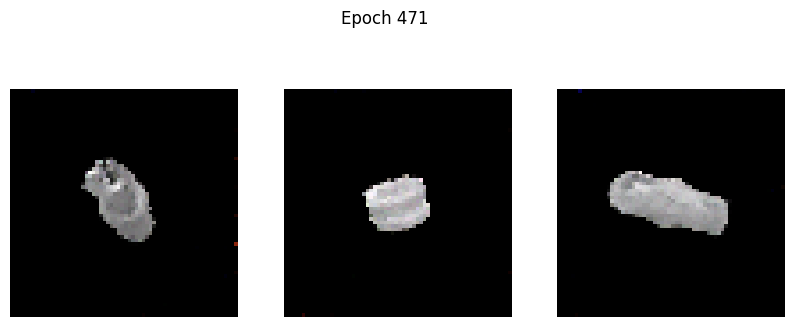

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0571 - g_loss: 5.4783
Epoch 472/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0033 - g_loss: 5.7607

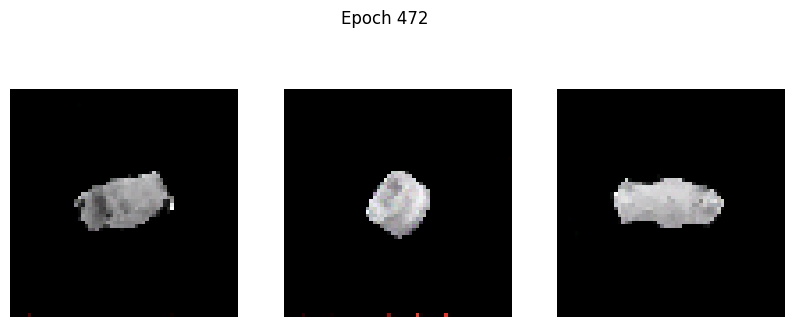

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0028 - g_loss: 5.7590
Epoch 473/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1451 - g_loss: 6.9338

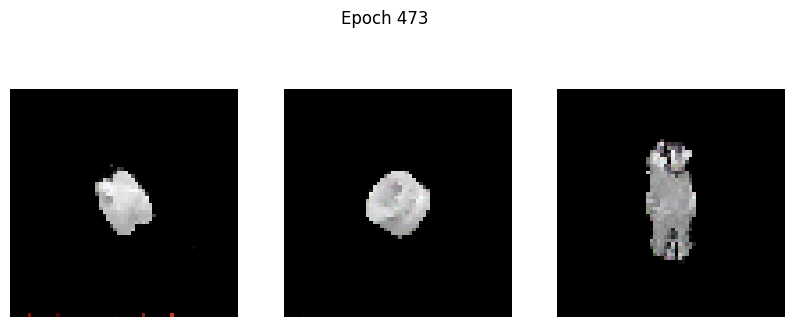

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1445 - g_loss: 6.9281
Epoch 474/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0319 - g_loss: 5.6733

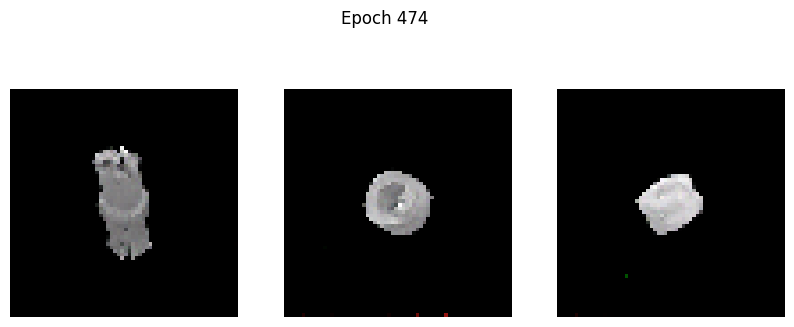

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0318 - g_loss: 5.6758
Epoch 475/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0820 - g_loss: 5.2769

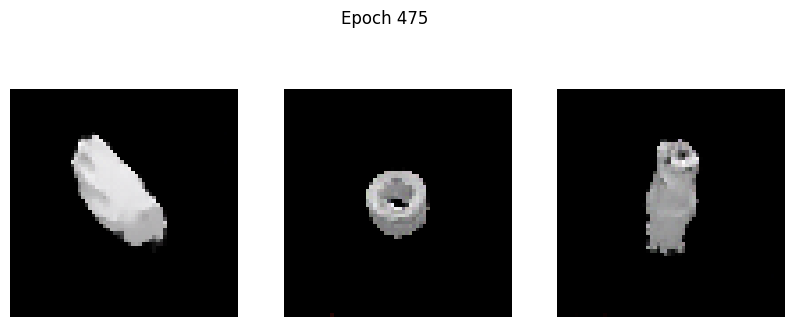

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0817 - g_loss: 5.2802
Epoch 476/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0369 - g_loss: 5.7748

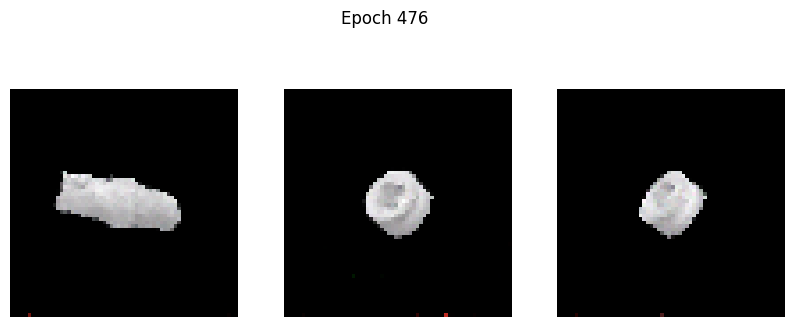

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0367 - g_loss: 5.7769
Epoch 477/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0586 - g_loss: 5.6700

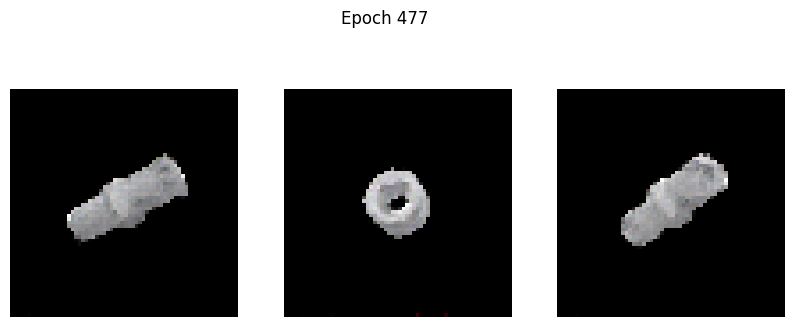

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0586 - g_loss: 5.6711
Epoch 478/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1022 - g_loss: 6.4164

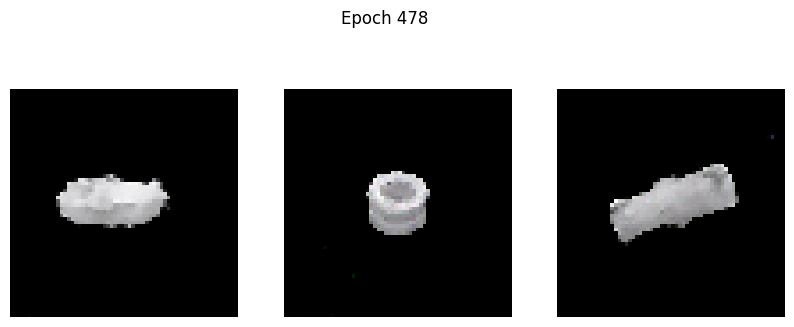

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1017 - g_loss: 6.4143
Epoch 479/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0658 - g_loss: 6.0004

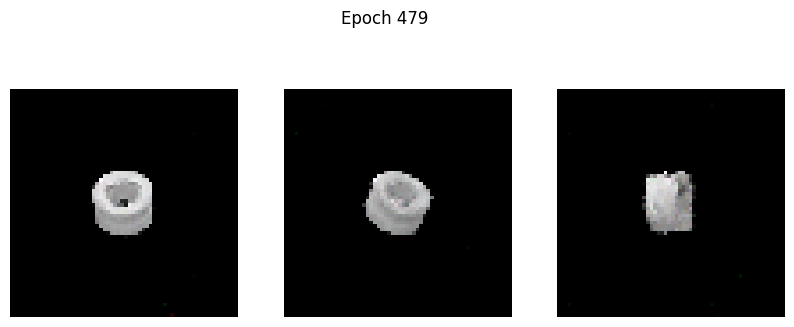

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0656 - g_loss: 6.0008
Epoch 480/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0830 - g_loss: 5.6152

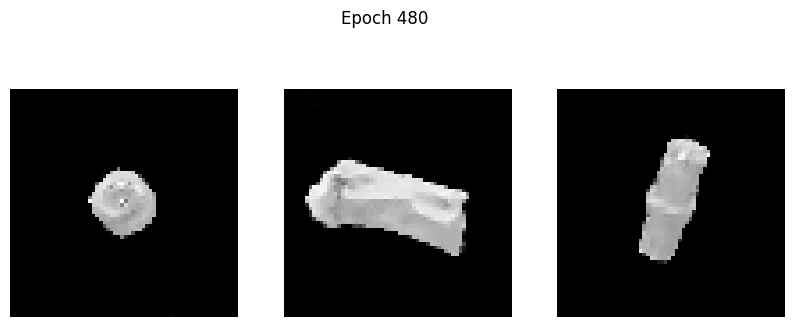

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0830 - g_loss: 5.6159
Epoch 481/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0182 - g_loss: 6.2757

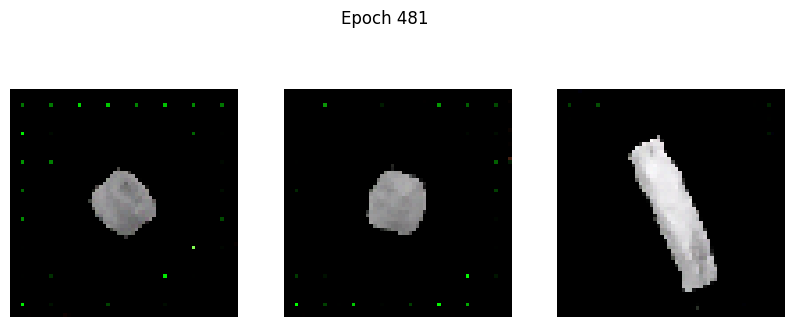

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0178 - g_loss: 6.2734
Epoch 482/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0496 - g_loss: 5.6442

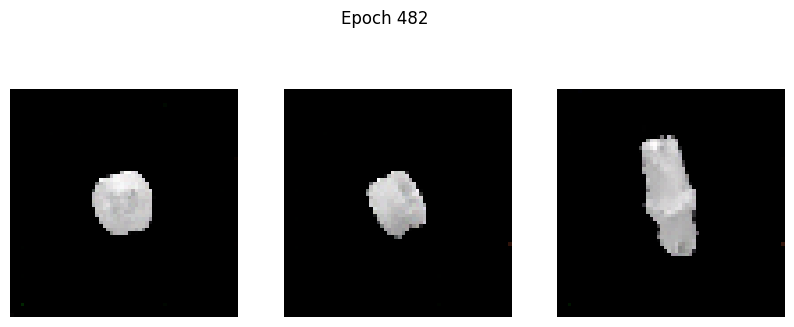

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0495 - g_loss: 5.6459
Epoch 483/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0835 - g_loss: 5.7775

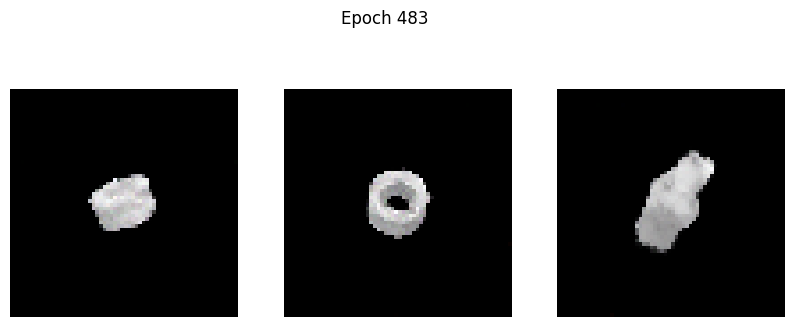

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - d_loss: -0.0829 - g_loss: 5.7801
Epoch 484/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.1205 - g_loss: 5.6004

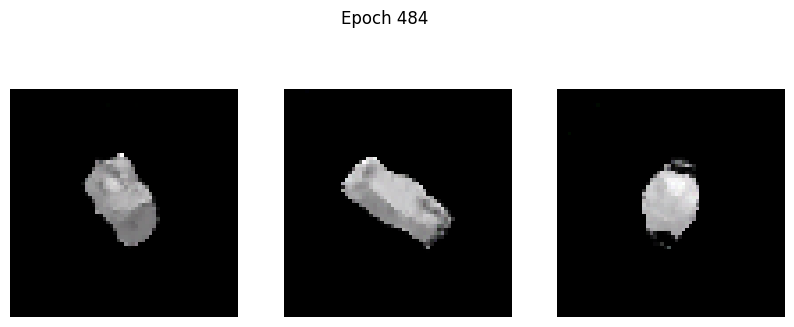

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.1201 - g_loss: 5.6018
Epoch 485/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0414 - g_loss: 6.0298

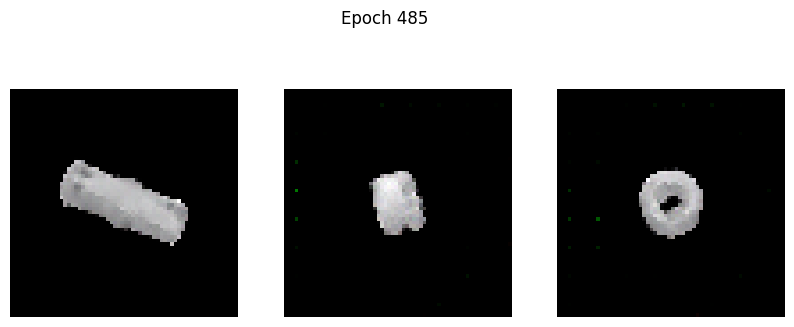

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0411 - g_loss: 6.0314
Epoch 486/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.1077 - g_loss: 5.7789

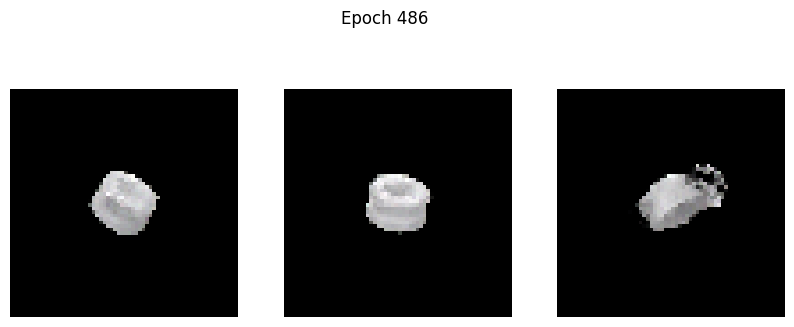

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.1077 - g_loss: 5.7789
Epoch 487/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0176 - g_loss: 6.5842

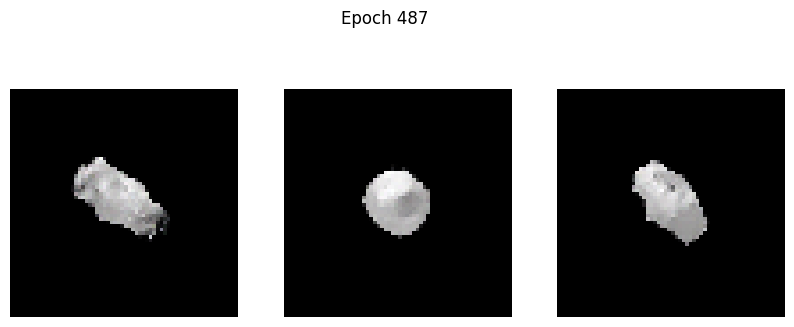

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0174 - g_loss: 6.5836
Epoch 488/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0467 - g_loss: 5.7214

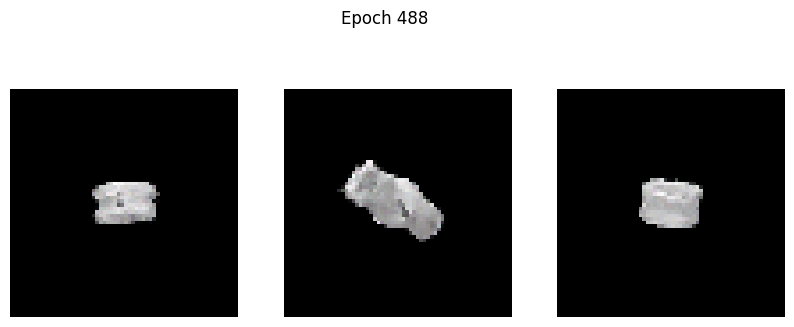

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0465 - g_loss: 5.7244
Epoch 489/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0251 - g_loss: 6.3347

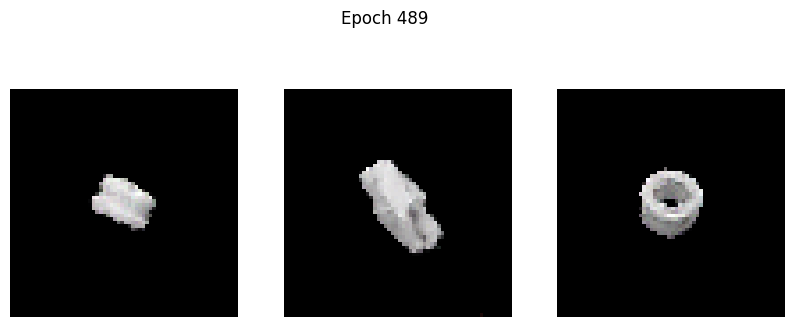

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: -0.0253 - g_loss: 6.3331
Epoch 490/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: -0.0677 - g_loss: 5.7344

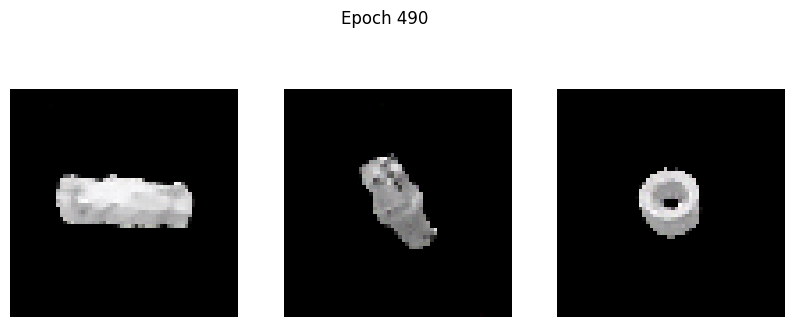

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0675 - g_loss: 5.7376
Epoch 491/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0503 - g_loss: 6.6430

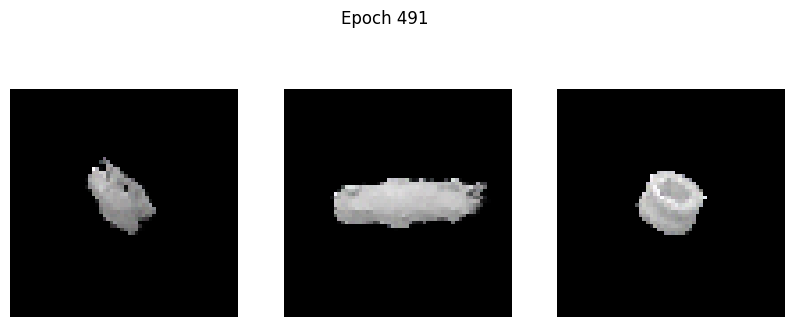

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0503 - g_loss: 6.6398
Epoch 492/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0686 - g_loss: 6.1096

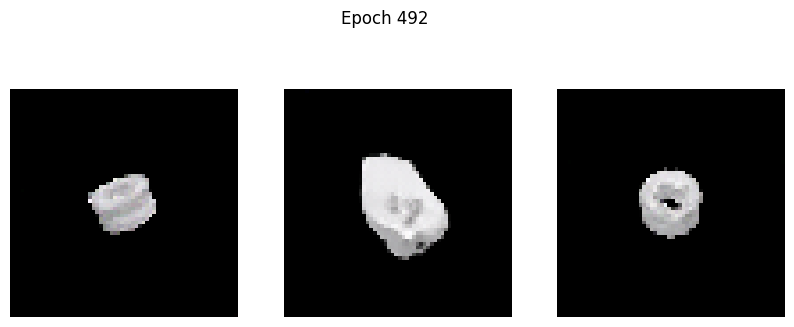

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0687 - g_loss: 6.1086
Epoch 493/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0249 - g_loss: 5.9662

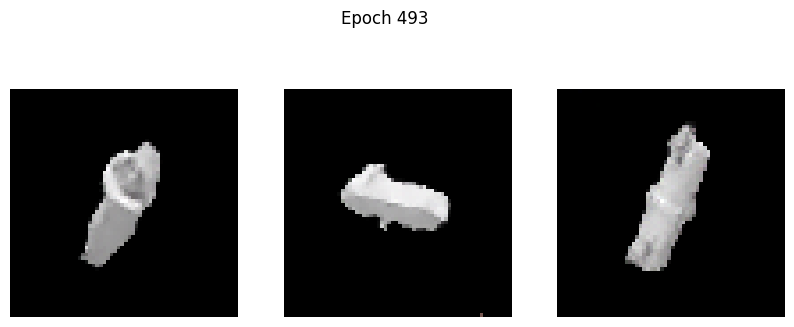

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0248 - g_loss: 5.9686
Epoch 494/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0649 - g_loss: 6.2282

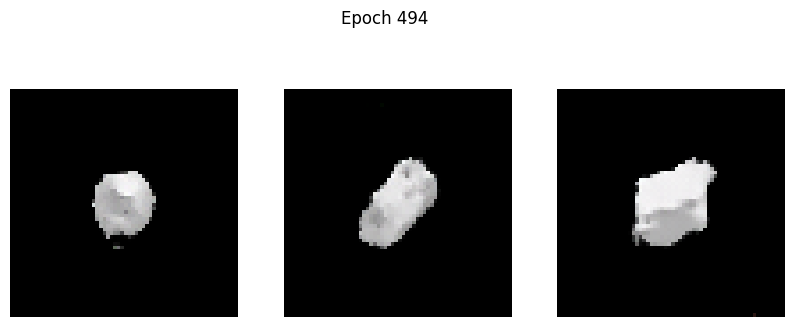

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0650 - g_loss: 6.2279
Epoch 495/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.1547 - g_loss: 5.6291

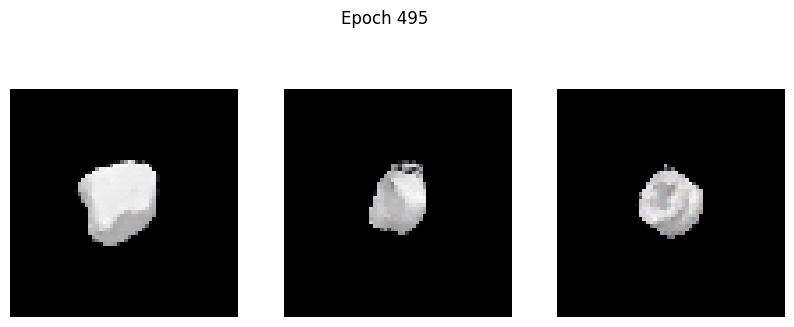

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.1545 - g_loss: 5.6304
Epoch 496/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: -0.0615 - g_loss: 6.3295

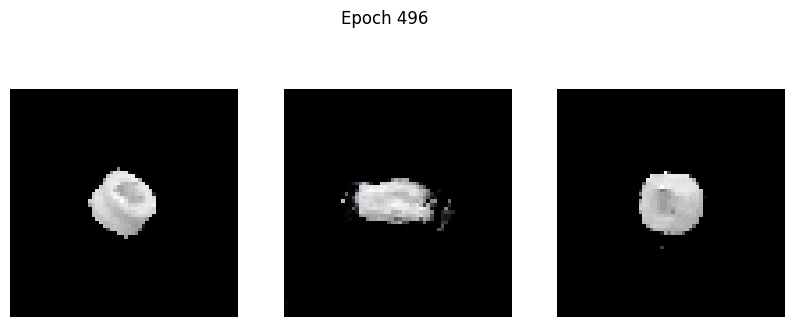

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - d_loss: -0.0615 - g_loss: 6.3290
Epoch 497/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.1252 - g_loss: 6.3691

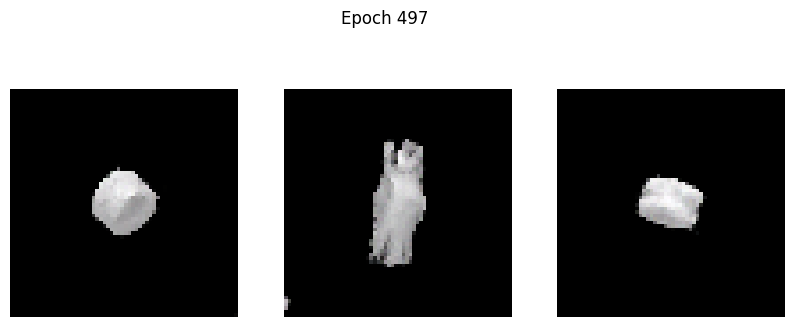

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.1246 - g_loss: 6.3699
Epoch 498/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1050 - g_loss: 7.3366

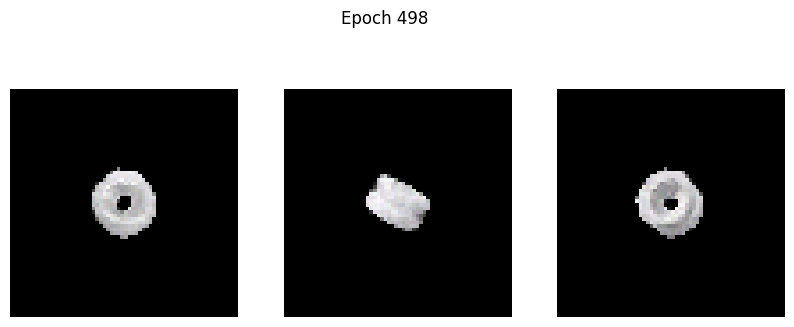

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1036 - g_loss: 7.3278
Epoch 499/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.1087 - g_loss: 6.2575

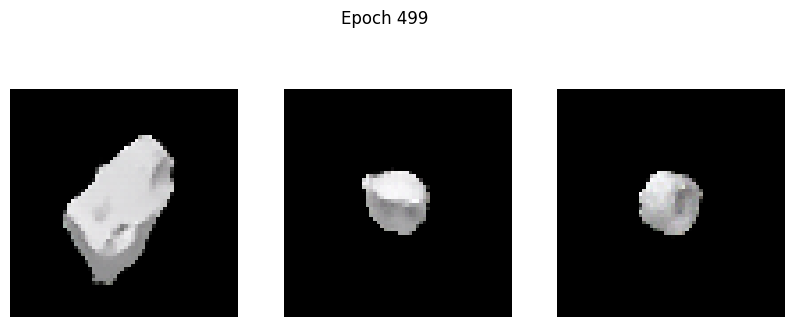

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.1082 - g_loss: 6.2596
Epoch 500/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.0130 - g_loss: 6.9459

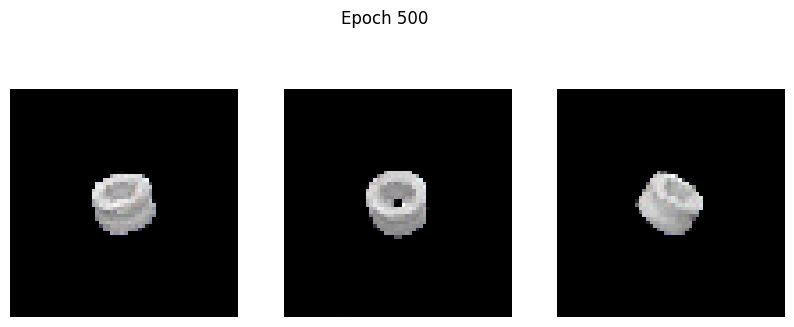

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.0128 - g_loss: 6.9433


In [8]:
# Hyperparameters
EPOCHS = 500  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [9]:
generator.save('generator_model.keras')
print("Generator model saved as 'generator_model.keras'")

Generator model saved as 'generator_model.keras'


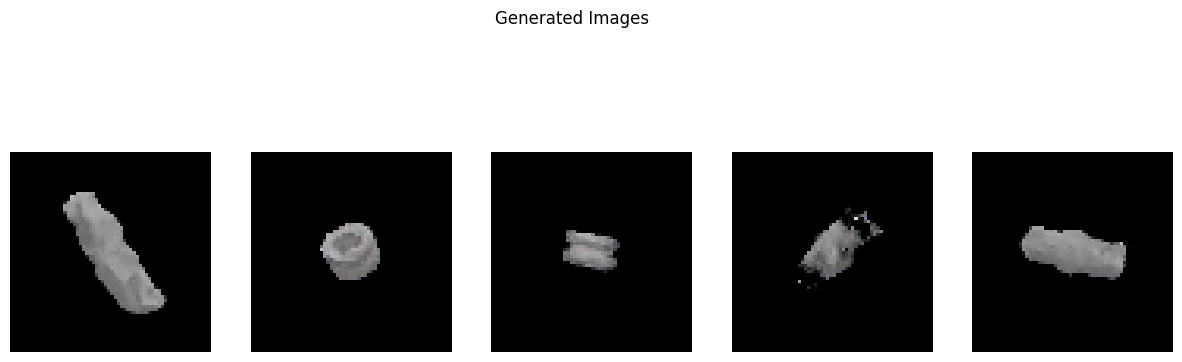

In [10]:
num_generated_images = 5
random_latent_vectors = tf.random.normal(shape=(num_generated_images, latent_dim))

generated_images = generator(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5 # Denormalize to [0, 255]
generated_images = tf.cast(generated_images, tf.uint8)

plt.figure(figsize=(15, 5))
for i in range(num_generated_images):
    plt.subplot(1, num_generated_images, i + 1)
    plt.imshow(generated_images[i].numpy())
    plt.axis('off')
plt.suptitle("Generated Images")
plt.show()

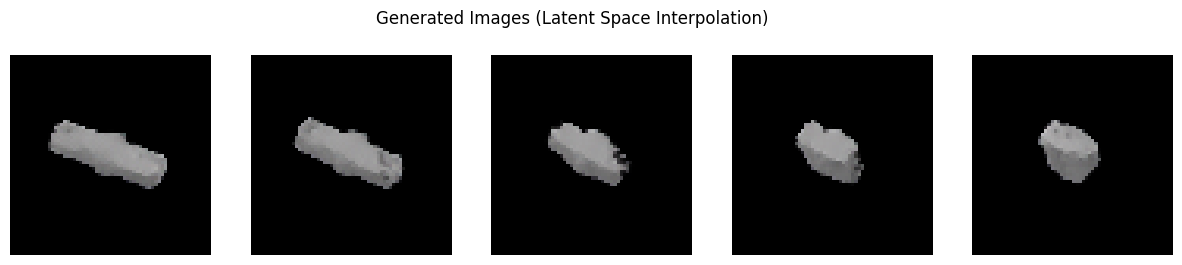

In [11]:
num_interpolation_steps = 5

# Generate two random latent vectors
start_latent_vector = tf.random.normal(shape=(1, latent_dim))
end_latent_vector = tf.random.normal(shape=(1, latent_dim))

# Perform linear interpolation in latent space
interpolated_latent_vectors = []
for i in range(num_interpolation_steps):
    alpha = i / (num_interpolation_steps - 1)
    interpolated_vector = (1 - alpha) * start_latent_vector + alpha * end_latent_vector
    interpolated_latent_vectors.append(interpolated_vector)

interpolated_latent_vectors = tf.concat(interpolated_latent_vectors, axis=0)

# Generate images from the interpolated latent vectors
generated_images_interp = generator(interpolated_latent_vectors)
generated_images_interp = (generated_images_interp * 127.5) + 127.5 # Denormalize to [0, 255]
generated_images_interp = tf.cast(generated_images_interp, tf.uint8)

# Display the interpolated images
plt.figure(figsize=(15, 3))
for i in range(num_interpolation_steps):
    plt.subplot(1, num_interpolation_steps, i + 1)
    plt.imshow(generated_images_interp[i].numpy())
    plt.axis('off')
plt.suptitle("Generated Images (Latent Space Interpolation)")
plt.show()